<p style="font-size:14pt;text-align:center;">
Train YOLO network on pascal VOC.
</p>

In [62]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import theano
from theano import tensor as T
import pickle as pk
import re
from copy import deepcopy
import sys
import simplejson

# image processing
from skimage.io import imread
from skimage.transform import resize
from skimage.color import rgb2hsv, hsv2rgb

import lasagne
from lasagne.layers import Pool2DLayer, Conv2DLayer, dropout, \
    DenseLayer, InputLayer, get_output, get_all_params
from lasagne import nonlinearities
from lasagne import layers
    
import bnr_ml.objectdetect.yolo as yolo
from bnr_ml.objectdetect import utils

import pdb

In [2]:
with open('/usr/local/python/bnr_ml/data/PascalVOC/annotations.json', 'r') as f:
    annotations = simplejson.load(f)

In [3]:
def get_label_counts(annotations):
    counts = np.zeros((4,))
    for a in annotations:
        for obj in a['annotations']:
            if obj['label'] == 'car':
                counts[0] += 1
            elif obj['label'] == 'bicycle':
                counts[1] += 1
            elif obj['label'] == 'bike':
                counts[2] += 1
            else:
                counts[3] += 1
    return counts

In [4]:
def fix_labels(annotations):
    for a in annotations:
        a['image'] = '/usr/local/python/bnr_ml/data/PascalVOC/' + a['image']
        new_objs = []
        for obj in a['annotations']:
            lab = obj['label'].lower()
            if 'car' in lab:
                lab = 'car'
            elif 'person' in lab:
                lab = 'person'
            elif 'bike' in lab:
                lab = 'bike'
            elif 'bicycle' in lab:
                lab = 'bicycle'
            else:
                lab = None
                
            if lab != None:
                obj['label'] = lab
                new_objs.append(obj)
        a['annotations'] = new_objs
    return annotations

In [5]:
annotations = np.asarray(fix_labels(annotations))

In [6]:
counts = get_label_counts(annotations)

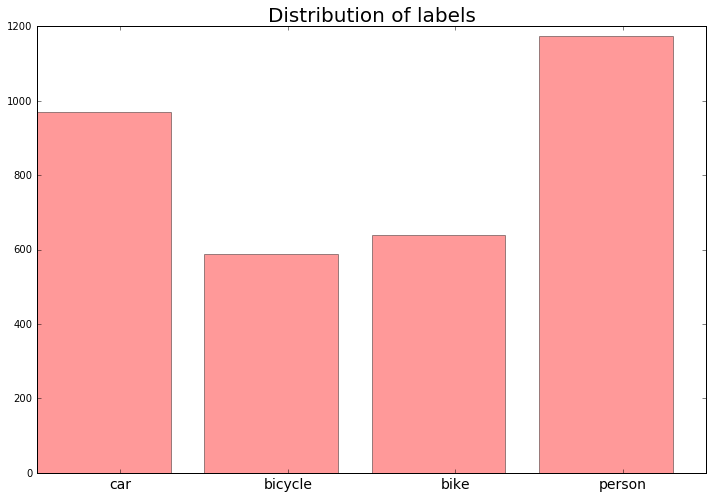

In [7]:
plt.figure(figsize=(12,8))
plt.title('Distribution of labels', fontsize=20)
plt.bar(np.arange(counts.size), counts, color='red', alpha=.4)
plt.xticks(np.arange(counts.size) + .5, ['car', 'bicycle', 'bike', 'person'], fontsize=14)
plt.show()

In [8]:
np.random.seed(1991)

<b>Split the annotations for training and testing, the reason I split by image and not individual object is so that when testing the performance, the network will never have seen any part of the test image.

In [9]:
with open('indices.pkl', 'rb') as f:
    indices = pk.load(f)
    train_idx = indices['train_index']
    test_idx = indices['test_index']

In [10]:
train_annotations = annotations[train_idx]
test_annotations = annotations[test_idx]

In [11]:
def generate_data_2(annotations, C, max_objs=15, size=(200,200), batch_size=100):
    def reformat_image(im, new_size):
        if im.shape.__len__() == 2:
            im = np.repeat(im.reshape(im.shape + (1,)), 3, axis=2)
        elif im.shape[2] > 3:
            im = im[:,:,:3]
        if im.shape[0] == 0 or im.shape[2] == 0:
            return None
        return resize(im, new_size).swapaxes(2,1).swapaxes(1,0)
    def transform_coord(coord, old_size, new_size):
        coord[[0,2]] = np.float_(coord[[0,2]]) / old_size[1]
        coord[[1,3]] = np.float_(coord[[1,3]]) / old_size[0]
        
        if coord[2] >= coord[0]:
            coord[2] -= coord[0]
        else:
            coord[2] = coord[0] - coord[2]
        if coord[3] >= coord[1]:
            coord[3] -= coord[1]
        else:
            coord[3] = coord[1] - coord[3]
        return coord
    def get_num_from_label(label):
        if label == 'car':
            return 0
        elif label == 'bicycle':
            return 1
        elif label == 'bike':
            return 2
        elif label == 'person':
            return 3
        elif label == 'noobj':
            return 4
        else:
            pass
        
#     annotations = np.asarray([[deepcopy(obj) for obj in objs] for objs in annotations]) # deep copy annotations

    fake_truth = np.concatenate((np.asarray([-10.,-10.,.01,.01]), np.zeros((C,))))
    
    np.random.shuffle(annotations)
    
    for i in range(0,annotations.shape[0], batch_size):
        Xbatch = np.zeros((batch_size,3) + size)
        ybatch = np.zeros((batch_size, (4 + C) * max_objs))
        
        for j in range(min(batch_size, annotations.shape[0] - i)):
            annotation = annotations[i+j]
            objs = annotation['annotations']
            im = imread(annotation['image'])
            old_size = np.float_(annotation['size'])
            
            Xbatch[j] = reformat_image(im, size)
            
            for k in range(max_objs):
                if k < objs.__len__():
                    obj = objs[k]
                    coord = np.asarray([
                            obj['x'],
                            obj['y'],
                            obj['w'],
                            obj['h']
                        ], dtype=theano.config.floatX)
                    coord = transform_coord(coord, old_size, size)
                    ybatch[j,k*(4 + C):k*(4 + C) + 4] = coord
                    ybatch[j,k*(4 + C)+4 + get_num_from_label(obj['label'])] += 1
                else:
                    ybatch[j,k*(4 + C):(k + 1)*(4 + C)] = fake_truth
            
        yield Xbatch[:j+1].astype(theano.config.floatX), ybatch[:j+1].astype(theano.config.floatX)

In [12]:
def generate_data_3(annotations, C, max_objs=15, size=(200,200), batch_size=100, augment=10):
    def reformat_image(im, new_size):
        if im.shape.__len__() == 2:
            im = np.repeat(im.reshape(im.shape + (1,)), 3, axis=2)
        elif im.shape[2] > 3:
            im = im[:,:,:3]
        if im.shape[0] == 0 or im.shape[2] == 0:
            return None
        return resize(im, new_size)
    def transform_coord(coord, old_size, new_size):
        coord[[0,2]] *= 1. / old_size[1]
        coord[[1,3]] *= 1. / old_size[0]
        
        if coord[2] >= coord[0]:
            coord[2] -= coord[0]
        else:
            coord[2] = coord[0] - coord[2]
        if coord[3] >= coord[1]:
            coord[3] -= coord[1]
        else:
            coord[3] = coord[1] - coord[3]
        return coord
    def get_num_from_label(label):
        if label == 'car':
            return 0
        elif label == 'bicycle':
            return 1
        elif label == 'bike':
            return 2
        elif label == 'person':
            return 3
        elif label == 'noobj':
            return 4
        else:
            pass
        
    annotations = np.asarray([[deepcopy(obj) for obj in objs] for objs in annotations]) # deep copy annotations

    fake_truth = np.concatenate((np.asarray([-10.,-10.,.01,.01]), np.zeros((C,))))
    
    np.random.shuffle(annotations)
    
    for num in range(augment):
        for i in range(0,annotations.size, batch_size):
            Xbatch = np.zeros((batch_size,3) + size)
            ybatch = np.zeros((batch_size, (4 + C) * max_objs))

            for j in range(min(batch_size, annotations.size - i)):
                objs = annotations[i+j][annotations]
                im = imread(annotations[i+j]['image'])
                old_size = im.shape
                
                old_box = Box(0.,0.,1.,1.)
                iterlap = .8
                new_width = iterlap + (1. - iterlap) * np.random.rand()
                new_height = iterlap +  (1. - iterlap) * np.random.rand()
                new_xi = (1. - new_width) * np.random.rand()
                new_yi = (1. - new_height) * np.random.rand()
                new_box = Box(
                    new_xi,
                    new_yi,
                    new_width + new_xi,
                    new_height + new_yi
                )
                im = new_box.subimage(im)

                im = reformat_image(im, size)
                
                im = rgb2hsv(im)
                im[:,:,[0,2]] *= (1 + .1 * np.random.rand(1,1,2))
                im = hsv2rgb(im)
                
                Xbatch[j] = im.swapaxes(2,1).swapaxes(1,0)

                for k in range(max_objs):
                    if k < objs.__len__():
                        obj = objs[k]
                        coord = np.asarray([
                                obj['x'],
                                obj['y'],
                                obj['w'],
                                obj['h']
                            ])
#                         coord = np.asarray(obj['p1'] + obj['p2']).astype(theano.config.floatX)
                        coord = transform_coord(coord, old_size, size)
                        
                        obj_box = Box(coord[0], coord[1], coord[0] + coord[2], coord[1] + coord[3])
                        
                        if new_box.iou(obj_box) > 0.5:
                            coord[0] -= new_box.xi
                            coord[1] -= new_box.yi
                            coord[[0,2]] /= (new_box.xf - new_box.xi)
                            coord[[1,3]] /= (new_box.yf - new_box.yi)
                            ybatch[j,k*(4 + C):k*(4 + C) + 4] = coord
                            ybatch[j,k*(4 + C)+4 + get_num_from_label(obj['label'])] += 1
                        else:
                            ybatch[j,k*(4 + C):(k + 1)*(4 + C)] = fake_truth

                    else:
                        ybatch[j,k*(4 + C):(k + 1)*(4 + C)] = fake_truth

            yield Xbatch[:j+1].astype(theano.config.floatX), ybatch[:j+1].astype(theano.config.floatX)

In [13]:
def generate_data(annotations, C, size=(200,200), batch_size=100):
    '''
    augment: how many times do you want the data to be replicated
    '''
    def get_objects(annotations):
        objs = []
        for im in annotations:
            objs.extend([deepcopy(obj) for obj in im])
        return np.asarray(objs)
    def get_num_from_label(label):
        if label == 'car':
            return 0
        elif label == 'bicycle':
            return 1
        elif label == 'bike':
            return 2
        elif label == 'person':
            return 3
        elif label == 'noobj':
            return 4
        else:
            pass
#             print('This shouldn\'t happen')
    def subsample_objs(objs, obj_idx, size):
        idx = obj_idx[np.random.random_integers(0,obj_idx.size-1, size=(size,))]
        copy_obj = []
        for obj in objs[idx]:
            copy_obj.append(deepcopy(obj))
        return np.asarray(copy_obj)
    def set_label_to_noobj(objs, obj_idx):
        N = np.int_(np.float_(obj_idx.size) / 5)
        idx = np.arange(obj_idx.size)
        np.random.shuffle(idx)
        for obj in objs[obj_idx[idx[:N]]]:
            obj['label']  = 'noobj'
        return objs
    
    # return flat list of objects
    objs = get_objects(annotations)
    
    # get number from label
    labels = np.asarray([get_num_from_label(obj['label']) for obj in objs])
    
    idx = np.arange(labels.size)
    idx_car = idx[labels==0]
    idx_bicycle = idx[labels==1]
    idx_bike = idx[labels==2]
    idx_person = idx[labels==3]
        
    max_labels = np.max([idx_car.size, idx_bicycle.size, idx_bike.size, idx_person.size])
    
    # get subsamples to get equal number of classes
    new_car = subsample_objs(objs, idx_car, max_labels - idx_car.size)
    new_bicycle = subsample_objs(objs, idx_bicycle, max_labels - idx_bicycle.size)
    new_bike = subsample_objs(objs, idx_bike, max_labels - idx_bike.size)
    new_person = subsample_objs(objs, idx_person, max_labels - idx_person.size)
    
    # add new samples
    objs = np.concatenate((objs, new_car, new_bicycle, new_bike, new_person))
    
    np.random.shuffle(objs)
    
    cnt = 0
    while cnt < objs.size:
        Xbatch = np.zeros((batch_size, 3) + size)
        ybatch = np.zeros((batch_size, 4 + C))
        batch_cnt = 0
        for j in range(batch_size):
            if cnt < objs.size:
                obj = objs[cnt]
                im = imread(obj['image'])
                im = im.astype(theano.config.floatX) / 255
                xscale, yscale = np.float_(size[1]) / im.shape[1], np.float_(size[0]) / im.shape[0]
#                 pdb.set_trace()
                coord = np.asarray(obj['p1'] + obj['p2']).astype(theano.config.floatX)
                coord[[0,2]] *= (xscale / 200)
                coord[[1,3]] *= (yscale / 200)
                if coord[2] >= coord[0]:
                    coord[2] -= coord[0]
                else:
                    coord[2] = coord[0] - coord[2]
                if coord[3] >= coord[1]:
                    coord[3] -= coord[1]
                else:
                    coord[3] = coord[1] - coord[3]
                    
                if coord[2] < 0 or coord[3] < 0:
                    print image
                    
                if im.shape.__len__() == 2:
                    im = im.reshape(im.shape + (1,))
                    im = np.concatenate((im, im, im), axis=2)
                elif im.shape[2] == 4:
                    im = im[:,:,:3]
                if not (im.shape[0] == 0 or im.shape[1] == 0):
                    im = resize(im, size).swapaxes(2,1).swapaxes(1,0)
                    Xbatch[batch_cnt] = im
                    ybatch[batch_cnt, :4] =  coord
                    ybatch[batch_cnt, 4 + get_num_from_label(obj['label'])] += 1
                    batch_cnt += 1
            cnt += 1
        if batch_cnt < batch_size - 1:
            Xbatch, ybatch = Xbatch[:batch_cnt], ybatch[:batch_cnt]
        yield Xbatch.astype(theano.config.floatX), ybatch.astype(theano.config.floatX)

<b>Now we define the net for recognition.</b>

In [14]:
S = (6,6)
B = 2
C = 4

In [350]:
num_epochs = 1000
batch_size = 10
input_shape = (224,224)

In [397]:
test_net = False
if test_net:
    Xtest, ytest = [t for t in generate_data_2(train_annotations[:10], C, batch_size=batch_size)][0]
    Xtest, ytest = theano.shared(Xtest), theano.shared(ytest)
    input_var = Xtest
else:
    input_var=None

In [398]:
net = {}
net['input'] = InputLayer((None, 3) + input_shape, input_var=input_var)
net['conv1_1'] = Conv2DLayer(net['input'], 64, 3, pad=1, nonlinearity=nonlinearities.leaky_rectify)
net['conv1_2'] = Conv2DLayer(net['conv1_1'], 64, 3, pad=1, nonlinearity=nonlinearities.leaky_rectify)
net['pool1'] = Pool2DLayer(net['conv1_2'], 2)
net['conv2_1'] = Conv2DLayer( net['pool1'], 128, 3, pad=1, nonlinearity=nonlinearities.leaky_rectify)
net['conv2_2'] = Conv2DLayer(net['conv2_1'], 128, 3, pad=1, nonlinearity=nonlinearities.leaky_rectify)
net['pool2'] = Pool2DLayer(net['conv2_2'], 2)
net['conv3_1'] = Conv2DLayer(net['pool2'], 256, 3, pad=1, nonlinearity=nonlinearities.leaky_rectify)
net['conv3_2'] = Conv2DLayer(net['conv3_1'], 256, 3, pad=1, nonlinearity=nonlinearities.leaky_rectify)
net['conv3_3'] = Conv2DLayer(net['conv3_2'], 256, 3, pad=1, nonlinearity=nonlinearities.leaky_rectify)
net['pool3'] = Pool2DLayer(net['conv3_3'], 2)
net['conv4_1'] = Conv2DLayer(net['pool3'], 512, 3, pad=1, nonlinearity=nonlinearities.leaky_rectify)
net['conv4_2'] = Conv2DLayer(net['conv4_1'], 512, 3, pad=1, nonlinearity=nonlinearities.leaky_rectify)
net['conv4_3'] = Conv2DLayer(net['conv4_2'], 512, 3, pad=1, nonlinearity=nonlinearities.leaky_rectify)
net['pool4'] = Pool2DLayer(net['conv4_3'], 2)
net['conv5_1'] = Conv2DLayer(net['pool4'], 512, 3, pad=1, nonlinearity=nonlinearities.leaky_rectify)
net['conv5_2'] = Conv2DLayer(net['conv5_1'], 512, 3, pad=1, nonlinearity=nonlinearities.leaky_rectify)
net['conv5_3'] = Conv2DLayer(net['conv5_2'], 512, 3, pad=1, nonlinearity=nonlinearities.leaky_rectify)
net['pool5'] = Pool2DLayer(net['conv5_3'], 2)
net['fc6'] = DenseLayer(net['pool5'], num_units=2048, nonlinearity=None)
net['fc6_dropout'] = dropout(net['fc6'], p=0.0)
net['fc7'] = DenseLayer(net['fc6_dropout'], num_units=2048, nonlinearity=None)
net['fc7_dropout'] = dropout(net['fc7'], p=0.0)
# net['fc8'] = DenseLayer(net['fc7_dropout'], num_units=1000, nonlinearity=None)
# net['prob'] = NonlinearityLayer(net['fc8'], nonlinearities.softmax)

<b>Load pre-trained weights</b>

In [399]:
load_pretrained = True
if load_pretrained:
    with open('/usr/local/python/bnr_ml/data/pretrained/vgg16.pkl', 'rb') as f:
        weights = pk.load(f)['param values']
        lasagne.layers.set_all_param_values(net['conv5_3'], weights[:-6])

<b>Add extra layers to network for detection</b>

In [400]:
net['fc6'] = DenseLayer(net['pool5'], 2048, nonlinearity=None)
net['output'] = DenseLayer(dropout(net['fc6'], p=.0), (B * (C + 1) + 4) * (S[0] * S[1]), nonlinearity=None)
# net['output'] = DenseLayer(dropout(net['dense1'], p=.0), (B * 5 + C) * S[0]*S[1])

In [401]:
load_weights = False
if load_weights:
    with open('yolo_weights.pkl', 'rb') as f:
        weights = pk.load(f)
        lasagne.layers.set_all_param_values(net['output'], weights)

<b>Train the network

In [405]:
reload(yolo)

<module 'bnr_ml.objectdetect.yolo' from '/usr/local/python/bnr_ml/objectdetect/yolo.py'>

In [406]:
yl = yolo.YoloObjectDetector(net, (None, 3) + input_shape, C, S, B) 

In [407]:
gen_fn = lambda ann, shape, batch_size: generate_data_2(ann, C, size=shape, batch_size=batch_size)

cost = yl._get_cost_optim_multi(yl.output, ytest, S, B, C)

In [408]:
train_loss, test_loss = yl.train(
    gen_fn,
    train_annotations[:1],
    test_annotations[:1],
    lr=1e-6,
    epochs=4000
)

Getting cost...
Creating cost variable took 0.7629 seconds
Compiling...


  0%|          | 0/4000 [00:00<?, ?it/s]

Compiling functions took 37.0884 seconds
Beginning training...
2.9638645649


  0%|          | 1/4000 [00:03<3:47:11,  3.41s/it]

Epoch 0
------
Train Loss: 2.9639, Test Loss: 40.1421
0.850002408028


  0%|          | 2/4000 [00:06<3:46:22,  3.40s/it]

Epoch 1
------
Train Loss: 0.8500, Test Loss: 40.2420
2.45399618149


  0%|          | 3/4000 [00:10<3:45:51,  3.39s/it]

Epoch 2
------
Train Loss: 2.4540, Test Loss: 40.2329
1.33156836033


  0%|          | 4/4000 [00:13<3:45:29,  3.39s/it]

Epoch 3
------
Train Loss: 1.3316, Test Loss: 40.2336
0.54920232296


  0%|          | 5/4000 [00:16<3:45:12,  3.38s/it]

Epoch 4
------
Train Loss: 0.5492, Test Loss: 40.2029
0.603726863861


  0%|          | 6/4000 [00:20<3:45:01,  3.38s/it]

Epoch 5
------
Train Loss: 0.6037, Test Loss: 40.1466
0.843646645546


  0%|          | 7/4000 [00:23<3:44:50,  3.38s/it]

Epoch 6
------
Train Loss: 0.8436, Test Loss: 40.1389
0.694934725761


  0%|          | 8/4000 [00:27<3:44:46,  3.38s/it]

Epoch 7
------
Train Loss: 0.6949, Test Loss: 40.0443
0.567329466343


  0%|          | 9/4000 [00:30<3:44:32,  3.38s/it]

Epoch 8
------
Train Loss: 0.5673, Test Loss: 40.0214
0.43735229969


  0%|          | 10/4000 [00:33<3:44:27,  3.38s/it]

Epoch 9
------
Train Loss: 0.4374, Test Loss: 40.0079
0.366105258465


  0%|          | 11/4000 [00:37<3:44:25,  3.38s/it]

Epoch 10
------
Train Loss: 0.3661, Test Loss: 39.9237
0.328739911318


  0%|          | 12/4000 [00:40<3:44:15,  3.37s/it]

Epoch 11
------
Train Loss: 0.3287, Test Loss: 40.0244
0.290057361126


  0%|          | 13/4000 [00:43<3:44:03,  3.37s/it]

Epoch 12
------
Train Loss: 0.2901, Test Loss: 39.8562
0.306655943394


  0%|          | 14/4000 [00:47<3:44:05,  3.37s/it]

Epoch 13
------
Train Loss: 0.3067, Test Loss: 40.0649
0.344381928444


  0%|          | 15/4000 [00:50<3:43:53,  3.37s/it]

Epoch 14
------
Train Loss: 0.3444, Test Loss: 39.7914
0.416736990213


  0%|          | 16/4000 [00:54<3:43:57,  3.37s/it]

Epoch 15
------
Train Loss: 0.4167, Test Loss: 40.1143
0.492323994637


  0%|          | 17/4000 [00:57<3:43:49,  3.37s/it]

Epoch 16
------
Train Loss: 0.4923, Test Loss: 39.7268
0.608377456665


  0%|          | 18/4000 [01:00<3:43:52,  3.37s/it]

Epoch 17
------
Train Loss: 0.6084, Test Loss: 40.1353
0.732418298721


  0%|          | 19/4000 [01:04<3:43:51,  3.37s/it]

Epoch 18
------
Train Loss: 0.7324, Test Loss: 39.7501
0.699907004833


  0%|          | 20/4000 [01:07<3:43:49,  3.37s/it]

Epoch 19
------
Train Loss: 0.6999, Test Loss: 40.1078
0.578358948231


  1%|          | 21/4000 [01:10<3:43:49,  3.38s/it]

Epoch 20
------
Train Loss: 0.5784, Test Loss: 39.8318
0.532679915428


  1%|          | 22/4000 [01:14<3:43:46,  3.38s/it]

Epoch 21
------
Train Loss: 0.5327, Test Loss: 40.0010
0.605040431023


  1%|          | 23/4000 [01:17<3:43:41,  3.37s/it]

Epoch 22
------
Train Loss: 0.6050, Test Loss: 39.9564
1.00038421154


  1%|          | 24/4000 [01:20<3:43:29,  3.37s/it]

Epoch 23
------
Train Loss: 1.0004, Test Loss: 39.9262
0.904943823814


  1%|          | 25/4000 [01:24<3:43:22,  3.37s/it]

Epoch 24
------
Train Loss: 0.9049, Test Loss: 39.9994
0.678741753101


  1%|          | 26/4000 [01:27<3:43:24,  3.37s/it]

Epoch 25
------
Train Loss: 0.6787, Test Loss: 39.8745
0.676934659481


  1%|          | 27/4000 [01:31<3:43:27,  3.37s/it]

Epoch 26
------
Train Loss: 0.6769, Test Loss: 39.9880
0.73233628273


  1%|          | 28/4000 [01:34<3:43:24,  3.37s/it]

Epoch 27
------
Train Loss: 0.7323, Test Loss: 39.8833
1.12413454056


  1%|          | 29/4000 [01:37<3:43:24,  3.38s/it]

Epoch 28
------
Train Loss: 1.1241, Test Loss: 39.9133
0.811930537224


  1%|          | 30/4000 [01:41<3:43:19,  3.38s/it]

Epoch 29
------
Train Loss: 0.8119, Test Loss: 39.9087
0.758069694042


  1%|          | 31/4000 [01:44<3:43:12,  3.37s/it]

Epoch 30
------
Train Loss: 0.7581, Test Loss: 39.8557
0.909155070782


  1%|          | 32/4000 [01:47<3:43:05,  3.37s/it]

Epoch 31
------
Train Loss: 0.9092, Test Loss: 39.9162
0.727152824402


  1%|          | 33/4000 [01:51<3:43:06,  3.37s/it]

Epoch 32
------
Train Loss: 0.7272, Test Loss: 39.8559
0.577726244926


  1%|          | 34/4000 [01:54<3:43:04,  3.37s/it]

Epoch 33
------
Train Loss: 0.5777, Test Loss: 39.8856
0.567552089691


  1%|          | 35/4000 [01:58<3:43:02,  3.38s/it]

Epoch 34
------
Train Loss: 0.5676, Test Loss: 39.8661
0.55734038353


  1%|          | 36/4000 [02:01<3:42:50,  3.37s/it]

Epoch 35
------
Train Loss: 0.5573, Test Loss: 39.8295
0.619559824467


  1%|          | 37/4000 [02:04<3:42:41,  3.37s/it]

Epoch 36
------
Train Loss: 0.6196, Test Loss: 39.8598
0.559205412865


  1%|          | 38/4000 [02:08<3:42:37,  3.37s/it]

Epoch 37
------
Train Loss: 0.5592, Test Loss: 39.7879
0.582826733589


  1%|          | 39/4000 [02:11<3:42:39,  3.37s/it]

Epoch 38
------
Train Loss: 0.5828, Test Loss: 39.8548
0.759130835533


  1%|          | 40/4000 [02:14<3:42:40,  3.37s/it]

Epoch 39
------
Train Loss: 0.7591, Test Loss: 39.7660
0.90455019474


  1%|          | 41/4000 [02:18<3:42:41,  3.37s/it]

Epoch 40
------
Train Loss: 0.9046, Test Loss: 39.8553
0.651755750179


  1%|          | 42/4000 [02:21<3:42:37,  3.37s/it]

Epoch 41
------
Train Loss: 0.6518, Test Loss: 39.7849
0.484238386154


  1%|          | 43/4000 [02:25<3:42:27,  3.37s/it]

Epoch 42
------
Train Loss: 0.4842, Test Loss: 39.8262
0.597033321857


  1%|          | 44/4000 [02:28<3:42:27,  3.37s/it]

Epoch 43
------
Train Loss: 0.5970, Test Loss: 39.7860
0.666310548782


  1%|          | 45/4000 [02:31<3:42:25,  3.37s/it]

Epoch 44
------
Train Loss: 0.6663, Test Loss: 39.7969
0.583004653454


  1%|          | 46/4000 [02:35<3:42:23,  3.37s/it]

Epoch 45
------
Train Loss: 0.5830, Test Loss: 39.7798
0.440018326044


  1%|          | 47/4000 [02:38<3:42:12,  3.37s/it]

Epoch 46
------
Train Loss: 0.4400, Test Loss: 39.7697
0.372171700001


  1%|          | 48/4000 [02:41<3:42:05,  3.37s/it]

Epoch 47
------
Train Loss: 0.3722, Test Loss: 39.7794
0.312060505152


  1%|          | 49/4000 [02:45<3:42:11,  3.37s/it]

Epoch 48
------
Train Loss: 0.3121, Test Loss: 39.7585
0.328739583492


  1%|▏         | 50/4000 [02:48<3:42:15,  3.38s/it]

Epoch 49
------
Train Loss: 0.3287, Test Loss: 39.7784
0.473711311817


  1%|▏         | 51/4000 [02:52<3:42:16,  3.38s/it]

Epoch 50
------
Train Loss: 0.4737, Test Loss: 39.7337
0.528891444206


  1%|▏         | 52/4000 [02:55<3:42:09,  3.38s/it]

Epoch 51
------
Train Loss: 0.5289, Test Loss: 39.7883
0.423094958067


  1%|▏         | 53/4000 [02:58<3:42:07,  3.38s/it]

Epoch 52
------
Train Loss: 0.4231, Test Loss: 39.6934
0.534861445427


  1%|▏         | 54/4000 [03:02<3:42:07,  3.38s/it]

Epoch 53
------
Train Loss: 0.5349, Test Loss: 39.8056
0.681477367878


  1%|▏         | 55/4000 [03:05<3:42:05,  3.38s/it]

Epoch 54
------
Train Loss: 0.6815, Test Loss: 39.6615
0.903061926365


  1%|▏         | 56/4000 [03:08<3:42:04,  3.38s/it]

Epoch 55
------
Train Loss: 0.9031, Test Loss: 39.8441
0.788990199566


  1%|▏         | 57/4000 [03:12<3:42:07,  3.38s/it]

Epoch 56
------
Train Loss: 0.7890, Test Loss: 39.6461
0.561814963818


  1%|▏         | 58/4000 [03:15<3:41:55,  3.38s/it]

Epoch 57
------
Train Loss: 0.5618, Test Loss: 39.8300
0.491471678019


  1%|▏         | 59/4000 [03:19<3:41:48,  3.38s/it]

Epoch 58
------
Train Loss: 0.4915, Test Loss: 39.6205
0.566641867161


  2%|▏         | 60/4000 [03:22<3:41:48,  3.38s/it]

Epoch 59
------
Train Loss: 0.5666, Test Loss: 39.8438
0.489831060171


  2%|▏         | 61/4000 [03:25<3:41:47,  3.38s/it]

Epoch 60
------
Train Loss: 0.4898, Test Loss: 39.5993
0.491655468941


  2%|▏         | 62/4000 [03:29<3:41:45,  3.38s/it]

Epoch 61
------
Train Loss: 0.4917, Test Loss: 39.8473
0.441383391619


  2%|▏         | 63/4000 [03:32<3:41:41,  3.38s/it]

Epoch 62
------
Train Loss: 0.4414, Test Loss: 39.5769
0.799093067646


  2%|▏         | 64/4000 [03:36<3:41:37,  3.38s/it]

Epoch 63
------
Train Loss: 0.7991, Test Loss: 39.7738
0.613505721092


  2%|▏         | 65/4000 [03:39<3:41:35,  3.38s/it]

Epoch 64
------
Train Loss: 0.6135, Test Loss: 39.6016
0.64866822958


  2%|▏         | 66/4000 [03:42<3:41:39,  3.38s/it]

Epoch 65
------
Train Loss: 0.6487, Test Loss: 39.7031
0.687084913254


  2%|▏         | 67/4000 [03:46<3:41:47,  3.38s/it]

Epoch 66
------
Train Loss: 0.6871, Test Loss: 39.5777
0.464782208204


  2%|▏         | 68/4000 [03:49<3:41:45,  3.38s/it]

Epoch 67
------
Train Loss: 0.4648, Test Loss: 39.6635
0.376559078693


  2%|▏         | 69/4000 [03:52<3:41:51,  3.39s/it]

Epoch 68
------
Train Loss: 0.3766, Test Loss: 39.5700
0.412395358086


  2%|▏         | 70/4000 [03:56<3:41:42,  3.38s/it]

Epoch 69
------
Train Loss: 0.4124, Test Loss: 39.6504
0.498698860407


  2%|▏         | 71/4000 [03:59<3:41:43,  3.39s/it]

Epoch 70
------
Train Loss: 0.4987, Test Loss: 39.5804
0.700110971928


  2%|▏         | 72/4000 [04:03<3:41:47,  3.39s/it]

Epoch 71
------
Train Loss: 0.7001, Test Loss: 39.6584
0.810793578625


  2%|▏         | 73/4000 [04:06<3:41:37,  3.39s/it]

Epoch 72
------
Train Loss: 0.8108, Test Loss: 39.6106
0.793849229813


  2%|▏         | 74/4000 [04:09<3:41:38,  3.39s/it]

Epoch 73
------
Train Loss: 0.7938, Test Loss: 39.6564
0.612222850323


  2%|▏         | 75/4000 [04:13<3:41:33,  3.39s/it]

Epoch 74
------
Train Loss: 0.6122, Test Loss: 39.5857
0.407291859388


  2%|▏         | 76/4000 [04:16<3:41:34,  3.39s/it]

Epoch 75
------
Train Loss: 0.4073, Test Loss: 39.6371
0.376819133759


  2%|▏         | 77/4000 [04:20<3:41:34,  3.39s/it]

Epoch 76
------
Train Loss: 0.3768, Test Loss: 39.6021
0.548429250717


  2%|▏         | 78/4000 [04:23<3:41:30,  3.39s/it]

Epoch 77
------
Train Loss: 0.5484, Test Loss: 39.6406
0.770589292049


  2%|▏         | 79/4000 [04:26<3:41:29,  3.39s/it]

Epoch 78
------
Train Loss: 0.7706, Test Loss: 39.6449
0.584378957748


  2%|▏         | 80/4000 [04:30<3:41:23,  3.39s/it]

Epoch 79
------
Train Loss: 0.5844, Test Loss: 39.6325
0.635976314545


  2%|▏         | 81/4000 [04:33<3:41:18,  3.39s/it]

Epoch 80
------
Train Loss: 0.6360, Test Loss: 39.6319
0.640346348286


  2%|▏         | 82/4000 [04:36<3:41:11,  3.39s/it]

Epoch 81
------
Train Loss: 0.6403, Test Loss: 39.6625
0.721274137497


  2%|▏         | 83/4000 [04:40<3:41:12,  3.39s/it]

Epoch 82
------
Train Loss: 0.7213, Test Loss: 39.6180
0.925868749619


  2%|▏         | 84/4000 [04:43<3:41:11,  3.39s/it]

Epoch 83
------
Train Loss: 0.9259, Test Loss: 39.6896
0.869487166405


  2%|▏         | 85/4000 [04:47<3:41:01,  3.39s/it]

Epoch 84
------
Train Loss: 0.8695, Test Loss: 39.5875
0.74873316288


  2%|▏         | 86/4000 [04:50<3:41:03,  3.39s/it]

Epoch 85
------
Train Loss: 0.7487, Test Loss: 39.7138
0.576403737068


  2%|▏         | 87/4000 [04:53<3:40:57,  3.39s/it]

Epoch 86
------
Train Loss: 0.5764, Test Loss: 39.5353
0.602231025696


  2%|▏         | 88/4000 [04:57<3:40:51,  3.39s/it]

Epoch 87
------
Train Loss: 0.6022, Test Loss: 39.7258
0.777794361115


  2%|▏         | 89/4000 [05:00<3:40:54,  3.39s/it]

Epoch 88
------
Train Loss: 0.7778, Test Loss: 39.5070
1.14052677155


  2%|▏         | 90/4000 [05:04<3:40:53,  3.39s/it]

Epoch 89
------
Train Loss: 1.1405, Test Loss: 39.7088
0.837546229362


  2%|▏         | 91/4000 [05:07<3:40:45,  3.39s/it]

Epoch 90
------
Train Loss: 0.8375, Test Loss: 39.5165
0.583616316319


  2%|▏         | 92/4000 [05:10<3:40:46,  3.39s/it]

Epoch 91
------
Train Loss: 0.5836, Test Loss: 39.6960
0.542405426502


  2%|▏         | 93/4000 [05:14<3:40:36,  3.39s/it]

Epoch 92
------
Train Loss: 0.5424, Test Loss: 39.5962
0.501938998699


  2%|▏         | 94/4000 [05:17<3:40:22,  3.39s/it]

Epoch 93
------
Train Loss: 0.5019, Test Loss: 39.6703
0.499068677425


  2%|▏         | 95/4000 [05:21<3:40:26,  3.39s/it]

Epoch 94
------
Train Loss: 0.4991, Test Loss: 39.7126
0.498176127672


  2%|▏         | 96/4000 [05:24<3:40:29,  3.39s/it]

Epoch 95
------
Train Loss: 0.4982, Test Loss: 39.6236
0.503307521343


  2%|▏         | 97/4000 [05:27<3:40:27,  3.39s/it]

Epoch 96
------
Train Loss: 0.5033, Test Loss: 39.8012
0.534790635109


  2%|▏         | 98/4000 [05:31<3:40:25,  3.39s/it]

Epoch 97
------
Train Loss: 0.5348, Test Loss: 39.5805
0.605948448181


  2%|▏         | 99/4000 [05:34<3:40:23,  3.39s/it]

Epoch 98
------
Train Loss: 0.6059, Test Loss: 39.8199
0.843158304691


  2%|▎         | 100/4000 [05:37<3:40:20,  3.39s/it]

Epoch 99
------
Train Loss: 0.8432, Test Loss: 39.5955
1.17911756039


  3%|▎         | 101/4000 [05:41<3:40:13,  3.39s/it]

Epoch 100
------
Train Loss: 1.1791, Test Loss: 39.7370
1.05170869827


  3%|▎         | 102/4000 [05:44<3:40:07,  3.39s/it]

Epoch 101
------
Train Loss: 1.0517, Test Loss: 39.6168
0.884409189224


  3%|▎         | 103/4000 [05:48<3:40:07,  3.39s/it]

Epoch 102
------
Train Loss: 0.8844, Test Loss: 39.5811
0.879244923592


  3%|▎         | 104/4000 [05:51<3:40:01,  3.39s/it]

Epoch 103
------
Train Loss: 0.8792, Test Loss: 39.6841
0.960283339024


  3%|▎         | 105/4000 [05:54<3:39:55,  3.39s/it]

Epoch 104
------
Train Loss: 0.9603, Test Loss: 39.4232
1.19897067547


  3%|▎         | 106/4000 [05:58<3:39:48,  3.39s/it]

Epoch 105
------
Train Loss: 1.1990, Test Loss: 39.7513
0.8995013237


  3%|▎         | 107/4000 [06:01<3:39:48,  3.39s/it]

Epoch 106
------
Train Loss: 0.8995, Test Loss: 39.3478
0.727738976479


  3%|▎         | 108/4000 [06:05<3:39:50,  3.39s/it]

Epoch 107
------
Train Loss: 0.7277, Test Loss: 39.7474
0.591559112072


  3%|▎         | 109/4000 [06:08<3:39:50,  3.39s/it]

Epoch 108
------
Train Loss: 0.5916, Test Loss: 39.3315
0.644987285137


  3%|▎         | 110/4000 [06:11<3:39:43,  3.39s/it]

Epoch 109
------
Train Loss: 0.6450, Test Loss: 39.7315
0.691622674465


  3%|▎         | 111/4000 [06:15<3:39:44,  3.39s/it]

Epoch 110
------
Train Loss: 0.6916, Test Loss: 39.3872
0.747356832027


  3%|▎         | 112/4000 [06:18<3:39:31,  3.39s/it]

Epoch 111
------
Train Loss: 0.7474, Test Loss: 39.6211
0.649775028229


  3%|▎         | 113/4000 [06:22<3:39:35,  3.39s/it]

Epoch 112
------
Train Loss: 0.6498, Test Loss: 39.4953
0.666821420193


  3%|▎         | 114/4000 [06:25<3:39:32,  3.39s/it]

Epoch 113
------
Train Loss: 0.6668, Test Loss: 39.5405
0.59933757782


  3%|▎         | 115/4000 [06:28<3:39:31,  3.39s/it]

Epoch 114
------
Train Loss: 0.5993, Test Loss: 39.5694
0.517208456993


  3%|▎         | 116/4000 [06:32<3:39:27,  3.39s/it]

Epoch 115
------
Train Loss: 0.5172, Test Loss: 39.5020
0.615038335323


  3%|▎         | 117/4000 [06:35<3:39:25,  3.39s/it]

Epoch 116
------
Train Loss: 0.6150, Test Loss: 39.5586
0.546699285507


  3%|▎         | 118/4000 [06:39<3:39:24,  3.39s/it]

Epoch 117
------
Train Loss: 0.5467, Test Loss: 39.5359
0.545687735081


  3%|▎         | 119/4000 [06:42<3:39:18,  3.39s/it]

Epoch 118
------
Train Loss: 0.5457, Test Loss: 39.5191
0.578205347061


  3%|▎         | 120/4000 [06:45<3:39:09,  3.39s/it]

Epoch 119
------
Train Loss: 0.5782, Test Loss: 39.5390
0.778114557266


  3%|▎         | 121/4000 [06:49<3:39:06,  3.39s/it]

Epoch 120
------
Train Loss: 0.7781, Test Loss: 39.5235
1.0268791914


  3%|▎         | 122/4000 [06:52<3:39:06,  3.39s/it]

Epoch 121
------
Train Loss: 1.0269, Test Loss: 39.5348
0.913192212582


  3%|▎         | 123/4000 [06:55<3:39:06,  3.39s/it]

Epoch 122
------
Train Loss: 0.9132, Test Loss: 39.5852
1.22511160374


  3%|▎         | 124/4000 [06:59<3:38:53,  3.39s/it]

Epoch 123
------
Train Loss: 1.2251, Test Loss: 39.4618
0.664742410183


  3%|▎         | 125/4000 [07:02<3:38:54,  3.39s/it]

Epoch 124
------
Train Loss: 0.6647, Test Loss: 39.6129
0.556047856808


  3%|▎         | 126/4000 [07:06<3:38:52,  3.39s/it]

Epoch 125
------
Train Loss: 0.5560, Test Loss: 39.3862
0.540937066078


  3%|▎         | 127/4000 [07:09<3:38:46,  3.39s/it]

Epoch 126
------
Train Loss: 0.5409, Test Loss: 39.6023
0.589092671871


  3%|▎         | 128/4000 [07:12<3:38:46,  3.39s/it]

Epoch 127
------
Train Loss: 0.5891, Test Loss: 39.3605
0.898139357567


  3%|▎         | 129/4000 [07:16<3:38:45,  3.39s/it]

Epoch 128
------
Train Loss: 0.8981, Test Loss: 39.5872
0.782625555992


  3%|▎         | 130/4000 [07:19<3:38:43,  3.39s/it]

Epoch 129
------
Train Loss: 0.7826, Test Loss: 39.3753
0.477584272623


  3%|▎         | 131/4000 [07:23<3:38:34,  3.39s/it]

Epoch 130
------
Train Loss: 0.4776, Test Loss: 39.5796
0.389360904694


  3%|▎         | 132/4000 [07:26<3:38:33,  3.39s/it]

Epoch 131
------
Train Loss: 0.3894, Test Loss: 39.3896
0.44065657258


  3%|▎         | 133/4000 [07:29<3:38:22,  3.39s/it]

Epoch 132
------
Train Loss: 0.4407, Test Loss: 39.5497
0.5802090168


  3%|▎         | 134/4000 [07:33<3:38:16,  3.39s/it]

Epoch 133
------
Train Loss: 0.5802, Test Loss: 39.4266
0.596759140491


  3%|▎         | 135/4000 [07:36<3:38:19,  3.39s/it]

Epoch 134
------
Train Loss: 0.5968, Test Loss: 39.4854
0.498267352581


  3%|▎         | 136/4000 [07:40<3:38:16,  3.39s/it]

Epoch 135
------
Train Loss: 0.4983, Test Loss: 39.4800
0.411087572575


  3%|▎         | 137/4000 [07:43<3:38:17,  3.39s/it]

Epoch 136
------
Train Loss: 0.4111, Test Loss: 39.4315
0.485446870327


  3%|▎         | 138/4000 [07:46<3:38:05,  3.39s/it]

Epoch 137
------
Train Loss: 0.4854, Test Loss: 39.5056
0.543156325817


  3%|▎         | 139/4000 [07:50<3:38:04,  3.39s/it]

Epoch 138
------
Train Loss: 0.5432, Test Loss: 39.4666
0.468180209398


  4%|▎         | 140/4000 [07:53<3:38:02,  3.39s/it]

Epoch 139
------
Train Loss: 0.4682, Test Loss: 39.4871
0.429251015186


  4%|▎         | 141/4000 [07:56<3:37:48,  3.39s/it]

Epoch 140
------
Train Loss: 0.4293, Test Loss: 39.5191
0.415293693542


  4%|▎         | 142/4000 [08:00<3:37:50,  3.39s/it]

Epoch 141
------
Train Loss: 0.4153, Test Loss: 39.4909
0.436806946993


  4%|▎         | 143/4000 [08:03<3:37:52,  3.39s/it]

Epoch 142
------
Train Loss: 0.4368, Test Loss: 39.6231
0.42786821723


  4%|▎         | 144/4000 [08:07<3:37:47,  3.39s/it]

Epoch 143
------
Train Loss: 0.4279, Test Loss: 39.5273
0.436872929335


  4%|▎         | 145/4000 [08:10<3:37:46,  3.39s/it]

Epoch 144
------
Train Loss: 0.4369, Test Loss: 39.6471
0.445408970118


  4%|▎         | 146/4000 [08:13<3:37:38,  3.39s/it]

Epoch 145
------
Train Loss: 0.4454, Test Loss: 39.5345
0.393528878689


  4%|▎         | 147/4000 [08:17<3:37:37,  3.39s/it]

Epoch 146
------
Train Loss: 0.3935, Test Loss: 39.6411
0.345531523228


  4%|▎         | 148/4000 [08:20<3:37:36,  3.39s/it]

Epoch 147
------
Train Loss: 0.3455, Test Loss: 39.5418
0.349620759487


  4%|▎         | 149/4000 [08:24<3:37:34,  3.39s/it]

Epoch 148
------
Train Loss: 0.3496, Test Loss: 39.6051
0.421591281891


  4%|▍         | 150/4000 [08:27<3:37:21,  3.39s/it]

Epoch 149
------
Train Loss: 0.4216, Test Loss: 39.5243
0.486611127853


  4%|▍         | 151/4000 [08:30<3:37:21,  3.39s/it]

Epoch 150
------
Train Loss: 0.4866, Test Loss: 39.5615
0.450697034597


  4%|▍         | 152/4000 [08:34<3:37:21,  3.39s/it]

Epoch 151
------
Train Loss: 0.4507, Test Loss: 39.4945
0.435582727194


  4%|▍         | 153/4000 [08:37<3:37:19,  3.39s/it]

Epoch 152
------
Train Loss: 0.4356, Test Loss: 39.5548
0.498520761728


  4%|▍         | 154/4000 [08:41<3:37:11,  3.39s/it]

Epoch 153
------
Train Loss: 0.4985, Test Loss: 39.4819
0.651365935802


  4%|▍         | 155/4000 [08:44<3:37:11,  3.39s/it]

Epoch 154
------
Train Loss: 0.6514, Test Loss: 39.5422
0.554785311222


  4%|▍         | 156/4000 [08:47<3:37:09,  3.39s/it]

Epoch 155
------
Train Loss: 0.5548, Test Loss: 39.4493
0.569900035858


  4%|▍         | 157/4000 [08:51<3:37:08,  3.39s/it]

Epoch 156
------
Train Loss: 0.5699, Test Loss: 39.5087
0.586437940598


  4%|▍         | 158/4000 [08:54<3:37:06,  3.39s/it]

Epoch 157
------
Train Loss: 0.5864, Test Loss: 39.4874
0.430904686451


  4%|▍         | 159/4000 [08:57<3:37:03,  3.39s/it]

Epoch 158
------
Train Loss: 0.4309, Test Loss: 39.5125
0.349398612976


  4%|▍         | 160/4000 [09:01<3:37:01,  3.39s/it]

Epoch 159
------
Train Loss: 0.3494, Test Loss: 39.5003
0.372851997614


  4%|▍         | 161/4000 [09:04<3:36:50,  3.39s/it]

Epoch 160
------
Train Loss: 0.3729, Test Loss: 39.4967
0.51866799593


  4%|▍         | 162/4000 [09:08<3:36:43,  3.39s/it]

Epoch 161
------
Train Loss: 0.5187, Test Loss: 39.4949
0.570584118366


  4%|▍         | 163/4000 [09:11<3:36:41,  3.39s/it]

Epoch 162
------
Train Loss: 0.5706, Test Loss: 39.5008
0.634728848934


  4%|▍         | 164/4000 [09:14<3:36:37,  3.39s/it]

Epoch 163
------
Train Loss: 0.6347, Test Loss: 39.4091
1.06274056435


  4%|▍         | 165/4000 [09:18<3:36:30,  3.39s/it]

Epoch 164
------
Train Loss: 1.0627, Test Loss: 39.5154
0.773982167244


  4%|▍         | 166/4000 [09:21<3:36:26,  3.39s/it]

Epoch 165
------
Train Loss: 0.7740, Test Loss: 39.3400
0.5146022439


  4%|▍         | 167/4000 [09:25<3:36:23,  3.39s/it]

Epoch 166
------
Train Loss: 0.5146, Test Loss: 39.5429
0.364495068789


  4%|▍         | 168/4000 [09:28<3:36:24,  3.39s/it]

Epoch 167
------
Train Loss: 0.3645, Test Loss: 39.3424
0.292786806822


  4%|▍         | 169/4000 [09:31<3:36:13,  3.39s/it]

Epoch 168
------
Train Loss: 0.2928, Test Loss: 39.5307
0.278846263885


  4%|▍         | 170/4000 [09:35<3:36:12,  3.39s/it]

Epoch 169
------
Train Loss: 0.2788, Test Loss: 39.3514
0.340008378029


  4%|▍         | 171/4000 [09:38<3:36:04,  3.39s/it]

Epoch 170
------
Train Loss: 0.3400, Test Loss: 39.5271
0.333858251572


  4%|▍         | 172/4000 [09:41<3:35:59,  3.39s/it]

Epoch 171
------
Train Loss: 0.3339, Test Loss: 39.3694
0.361723780632


  4%|▍         | 173/4000 [09:45<3:35:52,  3.38s/it]

Epoch 172
------
Train Loss: 0.3617, Test Loss: 39.4940
0.408957898617


  4%|▍         | 174/4000 [09:48<3:35:57,  3.39s/it]

Epoch 173
------
Train Loss: 0.4090, Test Loss: 39.4279
0.488135904074


  4%|▍         | 175/4000 [09:52<3:35:57,  3.39s/it]

Epoch 174
------
Train Loss: 0.4881, Test Loss: 39.4125
0.609150409698


  4%|▍         | 176/4000 [09:55<3:35:47,  3.39s/it]

Epoch 175
------
Train Loss: 0.6092, Test Loss: 39.5291
0.56728720665


  4%|▍         | 177/4000 [09:58<3:35:47,  3.39s/it]

Epoch 176
------
Train Loss: 0.5673, Test Loss: 39.3025
0.584523260593


  4%|▍         | 178/4000 [10:02<3:35:50,  3.39s/it]

Epoch 177
------
Train Loss: 0.5845, Test Loss: 39.6085
0.536700069904


  4%|▍         | 179/4000 [10:05<3:35:52,  3.39s/it]

Epoch 178
------
Train Loss: 0.5367, Test Loss: 39.2619
0.541060984135


  4%|▍         | 180/4000 [10:09<3:35:52,  3.39s/it]

Epoch 179
------
Train Loss: 0.5411, Test Loss: 39.5900
0.478454649448


  5%|▍         | 181/4000 [10:12<3:35:44,  3.39s/it]

Epoch 180
------
Train Loss: 0.4785, Test Loss: 39.2939
0.556090593338


  5%|▍         | 182/4000 [10:15<3:35:34,  3.39s/it]

Epoch 181
------
Train Loss: 0.5561, Test Loss: 39.5205
0.773560643196


  5%|▍         | 183/4000 [10:19<3:35:36,  3.39s/it]

Epoch 182
------
Train Loss: 0.7736, Test Loss: 39.3501
0.455180108547


  5%|▍         | 184/4000 [10:22<3:35:29,  3.39s/it]

Epoch 183
------
Train Loss: 0.4552, Test Loss: 39.4433
0.400462239981


  5%|▍         | 185/4000 [10:26<3:35:25,  3.39s/it]

Epoch 184
------
Train Loss: 0.4005, Test Loss: 39.4778
0.515696704388


  5%|▍         | 186/4000 [10:29<3:35:26,  3.39s/it]

Epoch 185
------
Train Loss: 0.5157, Test Loss: 39.3815
0.513146042824


  5%|▍         | 187/4000 [10:32<3:35:18,  3.39s/it]

Epoch 186
------
Train Loss: 0.5131, Test Loss: 39.5625
0.446307390928


  5%|▍         | 188/4000 [10:36<3:35:11,  3.39s/it]

Epoch 187
------
Train Loss: 0.4463, Test Loss: 39.3363
0.425902843475


  5%|▍         | 189/4000 [10:39<3:35:12,  3.39s/it]

Epoch 188
------
Train Loss: 0.4259, Test Loss: 39.5940
0.499800175428


  5%|▍         | 190/4000 [10:42<3:35:06,  3.39s/it]

Epoch 189
------
Train Loss: 0.4998, Test Loss: 39.3250
0.743775963783


  5%|▍         | 191/4000 [10:46<3:35:03,  3.39s/it]

Epoch 190
------
Train Loss: 0.7438, Test Loss: 39.6254
0.52675652504


  5%|▍         | 192/4000 [10:49<3:35:03,  3.39s/it]

Epoch 191
------
Train Loss: 0.5268, Test Loss: 39.3215
0.362496107817


  5%|▍         | 193/4000 [10:53<3:34:57,  3.39s/it]

Epoch 192
------
Train Loss: 0.3625, Test Loss: 39.6148
0.55990666151


  5%|▍         | 194/4000 [10:56<3:34:47,  3.39s/it]

Epoch 193
------
Train Loss: 0.5599, Test Loss: 39.4159
0.833623170853


  5%|▍         | 195/4000 [10:59<3:34:49,  3.39s/it]

Epoch 194
------
Train Loss: 0.8336, Test Loss: 39.4659
0.648510634899


  5%|▍         | 196/4000 [11:03<3:34:51,  3.39s/it]

Epoch 195
------
Train Loss: 0.6485, Test Loss: 39.5500
0.509988486767


  5%|▍         | 197/4000 [11:06<3:34:50,  3.39s/it]

Epoch 196
------
Train Loss: 0.5100, Test Loss: 39.3931
0.406035810709


  5%|▍         | 198/4000 [11:10<3:34:49,  3.39s/it]

Epoch 197
------
Train Loss: 0.4060, Test Loss: 39.5795
0.465584278107


  5%|▍         | 199/4000 [11:13<3:34:38,  3.39s/it]

Epoch 198
------
Train Loss: 0.4656, Test Loss: 39.3930
0.432121127844


  5%|▌         | 200/4000 [11:16<3:34:35,  3.39s/it]

Epoch 199
------
Train Loss: 0.4321, Test Loss: 39.5620
0.429744541645


  5%|▌         | 201/4000 [11:20<3:34:26,  3.39s/it]

Epoch 200
------
Train Loss: 0.4297, Test Loss: 39.3811
0.453644037247


  5%|▌         | 202/4000 [11:23<3:34:27,  3.39s/it]

Epoch 201
------
Train Loss: 0.4536, Test Loss: 39.4958
0.551807761192


  5%|▌         | 203/4000 [11:27<3:34:22,  3.39s/it]

Epoch 202
------
Train Loss: 0.5518, Test Loss: 39.4443
0.560069620609


  5%|▌         | 204/4000 [11:30<3:34:12,  3.39s/it]

Epoch 203
------
Train Loss: 0.5601, Test Loss: 39.4081
0.59165841341


  5%|▌         | 205/4000 [11:33<3:34:15,  3.39s/it]

Epoch 204
------
Train Loss: 0.5917, Test Loss: 39.4866
0.648487925529


  5%|▌         | 206/4000 [11:37<3:34:16,  3.39s/it]

Epoch 205
------
Train Loss: 0.6485, Test Loss: 39.3877
0.738839507103


  5%|▌         | 207/4000 [11:40<3:34:15,  3.39s/it]

Epoch 206
------
Train Loss: 0.7388, Test Loss: 39.5095
0.572576284409


  5%|▌         | 208/4000 [11:43<3:34:12,  3.39s/it]

Epoch 207
------
Train Loss: 0.5726, Test Loss: 39.4144
0.412624001503


  5%|▌         | 209/4000 [11:47<3:34:10,  3.39s/it]

Epoch 208
------
Train Loss: 0.4126, Test Loss: 39.4850
0.374663800001


  5%|▌         | 210/4000 [11:50<3:34:09,  3.39s/it]

Epoch 209
------
Train Loss: 0.3747, Test Loss: 39.4405
0.441151916981


  5%|▌         | 211/4000 [11:54<3:34:03,  3.39s/it]

Epoch 210
------
Train Loss: 0.4412, Test Loss: 39.4235
0.575814604759


  5%|▌         | 212/4000 [11:57<3:33:53,  3.39s/it]

Epoch 211
------
Train Loss: 0.5758, Test Loss: 39.4599
0.482818305492


  5%|▌         | 213/4000 [12:00<3:33:55,  3.39s/it]

Epoch 212
------
Train Loss: 0.4828, Test Loss: 39.3385
0.461101412773


  5%|▌         | 214/4000 [12:04<3:33:52,  3.39s/it]

Epoch 213
------
Train Loss: 0.4611, Test Loss: 39.4770
0.412079960108


  5%|▌         | 215/4000 [12:07<3:33:55,  3.39s/it]

Epoch 214
------
Train Loss: 0.4121, Test Loss: 39.2661
0.414062142372


  5%|▌         | 216/4000 [12:11<3:33:54,  3.39s/it]

Epoch 215
------
Train Loss: 0.4141, Test Loss: 39.5642
0.444290995598


  5%|▌         | 217/4000 [12:14<3:33:48,  3.39s/it]

Epoch 216
------
Train Loss: 0.4443, Test Loss: 39.2161
0.507796525955


  5%|▌         | 218/4000 [12:17<3:33:45,  3.39s/it]

Epoch 217
------
Train Loss: 0.5078, Test Loss: 39.6224
0.515360414982


  5%|▌         | 219/4000 [12:21<3:33:43,  3.39s/it]

Epoch 218
------
Train Loss: 0.5154, Test Loss: 39.2602
0.433508872986


  6%|▌         | 220/4000 [12:24<3:33:41,  3.39s/it]

Epoch 219
------
Train Loss: 0.4335, Test Loss: 39.5733
0.365768164396


  6%|▌         | 221/4000 [12:28<3:33:28,  3.39s/it]

Epoch 220
------
Train Loss: 0.3658, Test Loss: 39.3460
0.388707101345


  6%|▌         | 222/4000 [12:31<3:33:28,  3.39s/it]

Epoch 221
------
Train Loss: 0.3887, Test Loss: 39.4826
0.489529877901


  6%|▌         | 223/4000 [12:34<3:33:24,  3.39s/it]

Epoch 222
------
Train Loss: 0.4895, Test Loss: 39.4210
0.404132544994


  6%|▌         | 224/4000 [12:38<3:33:20,  3.39s/it]

Epoch 223
------
Train Loss: 0.4041, Test Loss: 39.4481
0.450589329004


  6%|▌         | 225/4000 [12:41<3:33:18,  3.39s/it]

Epoch 224
------
Train Loss: 0.4506, Test Loss: 39.4847
0.445429742336


  6%|▌         | 226/4000 [12:44<3:33:17,  3.39s/it]

Epoch 225
------
Train Loss: 0.4454, Test Loss: 39.3977
0.439242631197


  6%|▌         | 227/4000 [12:48<3:33:06,  3.39s/it]

Epoch 226
------
Train Loss: 0.4392, Test Loss: 39.5293
0.503599703312


  6%|▌         | 228/4000 [12:51<3:33:00,  3.39s/it]

Epoch 227
------
Train Loss: 0.5036, Test Loss: 39.3859
0.545380651951


  6%|▌         | 229/4000 [12:55<3:32:51,  3.39s/it]

Epoch 228
------
Train Loss: 0.5454, Test Loss: 39.5122
0.46475893259


  6%|▌         | 230/4000 [12:58<3:32:46,  3.39s/it]

Epoch 229
------
Train Loss: 0.4648, Test Loss: 39.3750
0.427345752716


  6%|▌         | 231/4000 [13:01<3:32:46,  3.39s/it]

Epoch 230
------
Train Loss: 0.4273, Test Loss: 39.4544
0.415645927191


  6%|▌         | 232/4000 [13:05<3:32:41,  3.39s/it]

Epoch 231
------
Train Loss: 0.4156, Test Loss: 39.4112
0.384073197842


  6%|▌         | 233/4000 [13:08<3:32:38,  3.39s/it]

Epoch 232
------
Train Loss: 0.3841, Test Loss: 39.4146
0.33412706852


  6%|▌         | 234/4000 [13:12<3:32:37,  3.39s/it]

Epoch 233
------
Train Loss: 0.3341, Test Loss: 39.4611
0.305045485497


  6%|▌         | 235/4000 [13:15<3:32:40,  3.39s/it]

Epoch 234
------
Train Loss: 0.3050, Test Loss: 39.3636
0.345132529736


  6%|▌         | 236/4000 [13:18<3:32:34,  3.39s/it]

Epoch 235
------
Train Loss: 0.3451, Test Loss: 39.5042
0.332574099302


  6%|▌         | 237/4000 [13:22<3:32:34,  3.39s/it]

Epoch 236
------
Train Loss: 0.3326, Test Loss: 39.3006
0.493507742882


  6%|▌         | 238/4000 [13:25<3:32:33,  3.39s/it]

Epoch 237
------
Train Loss: 0.4935, Test Loss: 39.4822
1.12907207012


  6%|▌         | 239/4000 [13:29<3:32:23,  3.39s/it]

Epoch 238
------
Train Loss: 1.1291, Test Loss: 39.3032
0.878278374672


  6%|▌         | 240/4000 [13:32<3:32:16,  3.39s/it]

Epoch 239
------
Train Loss: 0.8783, Test Loss: 39.4592
0.594198822975


  6%|▌         | 241/4000 [13:35<3:32:17,  3.39s/it]

Epoch 240
------
Train Loss: 0.5942, Test Loss: 39.4054
0.439064621925


  6%|▌         | 242/4000 [13:39<3:32:10,  3.39s/it]

Epoch 241
------
Train Loss: 0.4391, Test Loss: 39.4455
0.345714479685


  6%|▌         | 243/4000 [13:42<3:32:01,  3.39s/it]

Epoch 242
------
Train Loss: 0.3457, Test Loss: 39.4599
0.361245453358


  6%|▌         | 244/4000 [13:45<3:32:03,  3.39s/it]

Epoch 243
------
Train Loss: 0.3612, Test Loss: 39.4263
0.549379050732


  6%|▌         | 245/4000 [13:49<3:32:01,  3.39s/it]

Epoch 244
------
Train Loss: 0.5494, Test Loss: 39.4995
0.564068734646


  6%|▌         | 246/4000 [13:52<3:31:58,  3.39s/it]

Epoch 245
------
Train Loss: 0.5641, Test Loss: 39.3835
0.519782543182


  6%|▌         | 247/4000 [13:56<3:31:51,  3.39s/it]

Epoch 246
------
Train Loss: 0.5198, Test Loss: 39.5473
0.373327791691


  6%|▌         | 248/4000 [13:59<3:31:51,  3.39s/it]

Epoch 247
------
Train Loss: 0.3733, Test Loss: 39.3115
0.296696901321


  6%|▌         | 249/4000 [14:02<3:31:45,  3.39s/it]

Epoch 248
------
Train Loss: 0.2967, Test Loss: 39.5866
0.296258538961


  6%|▋         | 250/4000 [14:06<3:31:46,  3.39s/it]

Epoch 249
------
Train Loss: 0.2963, Test Loss: 39.2758
0.322215080261


  6%|▋         | 251/4000 [14:09<3:31:48,  3.39s/it]

Epoch 250
------
Train Loss: 0.3222, Test Loss: 39.5482
0.393881142139


  6%|▋         | 252/4000 [14:13<3:31:39,  3.39s/it]

Epoch 251
------
Train Loss: 0.3939, Test Loss: 39.3038
0.704380750656


  6%|▋         | 253/4000 [14:16<3:31:40,  3.39s/it]

Epoch 252
------
Train Loss: 0.7044, Test Loss: 39.3957
0.589842319489


  6%|▋         | 254/4000 [14:19<3:31:39,  3.39s/it]

Epoch 253
------
Train Loss: 0.5898, Test Loss: 39.4688
0.553650319576


  6%|▋         | 255/4000 [14:23<3:31:37,  3.39s/it]

Epoch 254
------
Train Loss: 0.5537, Test Loss: 39.2148
0.504870176315


  6%|▋         | 256/4000 [14:26<3:31:34,  3.39s/it]

Epoch 255
------
Train Loss: 0.5049, Test Loss: 39.5309
0.451141387224


  6%|▋         | 257/4000 [14:30<3:31:28,  3.39s/it]

Epoch 256
------
Train Loss: 0.4511, Test Loss: 39.1840
0.568334877491


  6%|▋         | 258/4000 [14:33<3:31:25,  3.39s/it]

Epoch 257
------
Train Loss: 0.5683, Test Loss: 39.5168
0.927084922791


  6%|▋         | 259/4000 [14:36<3:31:24,  3.39s/it]

Epoch 258
------
Train Loss: 0.9271, Test Loss: 39.2185
0.430812388659


  6%|▋         | 260/4000 [14:40<3:31:21,  3.39s/it]

Epoch 259
------
Train Loss: 0.4308, Test Loss: 39.4543
0.373380661011


  7%|▋         | 261/4000 [14:43<3:31:20,  3.39s/it]

Epoch 260
------
Train Loss: 0.3734, Test Loss: 39.3073
0.403597950935


  7%|▋         | 262/4000 [14:46<3:31:18,  3.39s/it]

Epoch 261
------
Train Loss: 0.4036, Test Loss: 39.3416
0.435183703899


  7%|▋         | 263/4000 [14:50<3:31:12,  3.39s/it]

Epoch 262
------
Train Loss: 0.4352, Test Loss: 39.3417
0.486335456371


  7%|▋         | 264/4000 [14:53<3:31:09,  3.39s/it]

Epoch 263
------
Train Loss: 0.4863, Test Loss: 39.2210
0.461192786694


  7%|▋         | 265/4000 [14:57<3:31:05,  3.39s/it]

Epoch 264
------
Train Loss: 0.4612, Test Loss: 39.3749
0.501604735851


  7%|▋         | 266/4000 [15:00<3:30:53,  3.39s/it]

Epoch 265
------
Train Loss: 0.5016, Test Loss: 39.1762
0.683036744595


  7%|▋         | 267/4000 [15:03<3:30:54,  3.39s/it]

Epoch 266
------
Train Loss: 0.6830, Test Loss: 39.4241
0.828917920589


  7%|▋         | 268/4000 [15:07<3:30:53,  3.39s/it]

Epoch 267
------
Train Loss: 0.8289, Test Loss: 39.1491
0.532104551792


  7%|▋         | 269/4000 [15:10<3:30:47,  3.39s/it]

Epoch 268
------
Train Loss: 0.5321, Test Loss: 39.4284
0.706327676773


  7%|▋         | 270/4000 [15:14<3:30:46,  3.39s/it]

Epoch 269
------
Train Loss: 0.7063, Test Loss: 39.1851
0.735651254654


  7%|▋         | 271/4000 [15:17<3:30:43,  3.39s/it]

Epoch 270
------
Train Loss: 0.7357, Test Loss: 39.3721
0.47574493289


  7%|▋         | 272/4000 [15:20<3:30:31,  3.39s/it]

Epoch 271
------
Train Loss: 0.4757, Test Loss: 39.2918
0.413725614548


  7%|▋         | 273/4000 [15:24<3:30:24,  3.39s/it]

Epoch 272
------
Train Loss: 0.4137, Test Loss: 39.2569
0.390741795301


  7%|▋         | 274/4000 [15:27<3:30:19,  3.39s/it]

Epoch 273
------
Train Loss: 0.3907, Test Loss: 39.4168
0.371201425791


  7%|▋         | 275/4000 [15:31<3:30:15,  3.39s/it]

Epoch 274
------
Train Loss: 0.3712, Test Loss: 39.1778
0.399349749088


  7%|▋         | 276/4000 [15:34<3:30:07,  3.39s/it]

Epoch 275
------
Train Loss: 0.3993, Test Loss: 39.5065
0.463329017162


  7%|▋         | 277/4000 [15:37<3:30:10,  3.39s/it]

Epoch 276
------
Train Loss: 0.4633, Test Loss: 39.1714
0.755280554295


  7%|▋         | 278/4000 [15:41<3:30:11,  3.39s/it]

Epoch 277
------
Train Loss: 0.7553, Test Loss: 39.5092
0.513135910034


  7%|▋         | 279/4000 [15:44<3:30:06,  3.39s/it]

Epoch 278
------
Train Loss: 0.5131, Test Loss: 39.1931
0.414009749889


  7%|▋         | 280/4000 [15:47<3:30:04,  3.39s/it]

Epoch 279
------
Train Loss: 0.4140, Test Loss: 39.4279
0.353247582912


  7%|▋         | 281/4000 [15:51<3:30:03,  3.39s/it]

Epoch 280
------
Train Loss: 0.3532, Test Loss: 39.2220
0.354259729385


  7%|▋         | 282/4000 [15:54<3:30:00,  3.39s/it]

Epoch 281
------
Train Loss: 0.3543, Test Loss: 39.3291
0.37723338604


  7%|▋         | 283/4000 [15:58<3:29:59,  3.39s/it]

Epoch 282
------
Train Loss: 0.3772, Test Loss: 39.2184
0.428363412619


  7%|▋         | 284/4000 [16:01<3:29:47,  3.39s/it]

Epoch 283
------
Train Loss: 0.4284, Test Loss: 39.2300
0.48210605979


  7%|▋         | 285/4000 [16:04<3:29:45,  3.39s/it]

Epoch 284
------
Train Loss: 0.4821, Test Loss: 39.2565
0.417236596346


  7%|▋         | 286/4000 [16:08<3:29:38,  3.39s/it]

Epoch 285
------
Train Loss: 0.4172, Test Loss: 39.1735
0.380624771118


  7%|▋         | 287/4000 [16:11<3:29:41,  3.39s/it]

Epoch 286
------
Train Loss: 0.3806, Test Loss: 39.2186
0.493968784809


  7%|▋         | 288/4000 [16:15<3:29:43,  3.39s/it]

Epoch 287
------
Train Loss: 0.4940, Test Loss: 39.1781
0.590054452419


  7%|▋         | 289/4000 [16:18<3:29:33,  3.39s/it]

Epoch 288
------
Train Loss: 0.5901, Test Loss: 39.2564
0.638734519482


  7%|▋         | 290/4000 [16:21<3:29:33,  3.39s/it]

Epoch 289
------
Train Loss: 0.6387, Test Loss: 39.2541
0.479562938213


  7%|▋         | 291/4000 [16:25<3:29:23,  3.39s/it]

Epoch 290
------
Train Loss: 0.4796, Test Loss: 39.2271
0.337823867798


  7%|▋         | 292/4000 [16:28<3:29:18,  3.39s/it]

Epoch 291
------
Train Loss: 0.3378, Test Loss: 39.2461
0.274591982365


  7%|▋         | 293/4000 [16:32<3:29:20,  3.39s/it]

Epoch 292
------
Train Loss: 0.2746, Test Loss: 39.2448
0.297632575035


  7%|▋         | 294/4000 [16:35<3:29:21,  3.39s/it]

Epoch 293
------
Train Loss: 0.2976, Test Loss: 39.2440
0.569545805454


  7%|▋         | 295/4000 [16:38<3:29:18,  3.39s/it]

Epoch 294
------
Train Loss: 0.5695, Test Loss: 39.2617
0.45945289731


  7%|▋         | 296/4000 [16:42<3:29:15,  3.39s/it]

Epoch 295
------
Train Loss: 0.4595, Test Loss: 39.2435
0.308339387178


  7%|▋         | 297/4000 [16:45<3:29:15,  3.39s/it]

Epoch 296
------
Train Loss: 0.3083, Test Loss: 39.2538
0.366472154856


  7%|▋         | 298/4000 [16:48<3:29:07,  3.39s/it]

Epoch 297
------
Train Loss: 0.3665, Test Loss: 39.2596
0.408194720745


  7%|▋         | 299/4000 [16:52<3:29:01,  3.39s/it]

Epoch 298
------
Train Loss: 0.4082, Test Loss: 39.2497
0.413318514824


  8%|▊         | 300/4000 [16:55<3:29:01,  3.39s/it]

Epoch 299
------
Train Loss: 0.4133, Test Loss: 39.3361
0.439969271421


  8%|▊         | 301/4000 [16:59<3:28:59,  3.39s/it]

Epoch 300
------
Train Loss: 0.4400, Test Loss: 39.2683
0.449782162905


  8%|▊         | 302/4000 [17:02<3:28:53,  3.39s/it]

Epoch 301
------
Train Loss: 0.4498, Test Loss: 39.3505
0.383487075567


  8%|▊         | 303/4000 [17:05<3:28:52,  3.39s/it]

Epoch 302
------
Train Loss: 0.3835, Test Loss: 39.3100
0.44585454464


  8%|▊         | 304/4000 [17:09<3:28:48,  3.39s/it]

Epoch 303
------
Train Loss: 0.4459, Test Loss: 39.3393
0.576010465622


  8%|▊         | 305/4000 [17:12<3:28:34,  3.39s/it]

Epoch 304
------
Train Loss: 0.5760, Test Loss: 39.4114
0.705631911755


  8%|▊         | 306/4000 [17:16<3:28:27,  3.39s/it]

Epoch 305
------
Train Loss: 0.7056, Test Loss: 39.3389
0.600009799004


  8%|▊         | 307/4000 [17:19<3:28:29,  3.39s/it]

Epoch 306
------
Train Loss: 0.6000, Test Loss: 39.5650
0.611091315746


  8%|▊         | 308/4000 [17:22<3:28:20,  3.39s/it]

Epoch 307
------
Train Loss: 0.6111, Test Loss: 39.3235
0.465378761292


  8%|▊         | 309/4000 [17:26<3:28:13,  3.38s/it]

Epoch 308
------
Train Loss: 0.4654, Test Loss: 39.6163
0.401576280594


  8%|▊         | 310/4000 [17:29<3:28:14,  3.39s/it]

Epoch 309
------
Train Loss: 0.4016, Test Loss: 39.3326
0.429218113422


  8%|▊         | 311/4000 [17:33<3:28:18,  3.39s/it]

Epoch 310
------
Train Loss: 0.4292, Test Loss: 39.5947
0.621387898922


  8%|▊         | 312/4000 [17:36<3:28:17,  3.39s/it]

Epoch 311
------
Train Loss: 0.6214, Test Loss: 39.3674
0.571278274059


  8%|▊         | 313/4000 [17:39<3:28:13,  3.39s/it]

Epoch 312
------
Train Loss: 0.5713, Test Loss: 39.5651
0.413730293512


  8%|▊         | 314/4000 [17:43<3:28:07,  3.39s/it]

Epoch 313
------
Train Loss: 0.4137, Test Loss: 39.4481
0.459664106369


  8%|▊         | 315/4000 [17:46<3:28:09,  3.39s/it]

Epoch 314
------
Train Loss: 0.4597, Test Loss: 39.5148
0.547329366207


  8%|▊         | 316/4000 [17:49<3:28:09,  3.39s/it]

Epoch 315
------
Train Loss: 0.5473, Test Loss: 39.5263
0.517774581909


  8%|▊         | 317/4000 [17:53<3:28:06,  3.39s/it]

Epoch 316
------
Train Loss: 0.5178, Test Loss: 39.5065
0.60624152422


  8%|▊         | 318/4000 [17:56<3:28:03,  3.39s/it]

Epoch 317
------
Train Loss: 0.6062, Test Loss: 39.5647
0.78264516592


  8%|▊         | 319/4000 [18:00<3:27:56,  3.39s/it]

Epoch 318
------
Train Loss: 0.7826, Test Loss: 39.5617
0.89161914587


  8%|▊         | 320/4000 [18:03<3:27:55,  3.39s/it]

Epoch 319
------
Train Loss: 0.8916, Test Loss: 39.5263
0.527436196804


  8%|▊         | 321/4000 [18:06<3:27:52,  3.39s/it]

Epoch 320
------
Train Loss: 0.5274, Test Loss: 39.6131
0.493846088648


  8%|▊         | 322/4000 [18:10<3:27:51,  3.39s/it]

Epoch 321
------
Train Loss: 0.4938, Test Loss: 39.4966
0.460066109896


  8%|▊         | 323/4000 [18:13<3:27:48,  3.39s/it]

Epoch 322
------
Train Loss: 0.4601, Test Loss: 39.6964
0.444725632668


  8%|▊         | 324/4000 [18:17<3:27:47,  3.39s/it]

Epoch 323
------
Train Loss: 0.4447, Test Loss: 39.4431
0.420039921999


  8%|▊         | 325/4000 [18:20<3:27:44,  3.39s/it]

Epoch 324
------
Train Loss: 0.4200, Test Loss: 39.6906
0.430068105459


  8%|▊         | 326/4000 [18:23<3:27:30,  3.39s/it]

Epoch 325
------
Train Loss: 0.4301, Test Loss: 39.4708
0.412840336561


  8%|▊         | 327/4000 [18:27<3:27:26,  3.39s/it]

Epoch 326
------
Train Loss: 0.4128, Test Loss: 39.6211
0.364683300257


  8%|▊         | 328/4000 [18:30<3:27:20,  3.39s/it]

Epoch 327
------
Train Loss: 0.3647, Test Loss: 39.5229
0.343068420887


  8%|▊         | 329/4000 [18:34<3:27:16,  3.39s/it]

Epoch 328
------
Train Loss: 0.3431, Test Loss: 39.5085
0.346180140972


  8%|▊         | 330/4000 [18:37<3:27:11,  3.39s/it]

Epoch 329
------
Train Loss: 0.3462, Test Loss: 39.5411
0.419065624475


  8%|▊         | 331/4000 [18:40<3:27:13,  3.39s/it]

Epoch 330
------
Train Loss: 0.4191, Test Loss: 39.4220
0.548732101917


  8%|▊         | 332/4000 [18:44<3:27:03,  3.39s/it]

Epoch 331
------
Train Loss: 0.5487, Test Loss: 39.5399
0.476378470659


  8%|▊         | 333/4000 [18:47<3:27:05,  3.39s/it]

Epoch 332
------
Train Loss: 0.4764, Test Loss: 39.3837
0.424000650644


  8%|▊         | 334/4000 [18:50<3:27:00,  3.39s/it]

Epoch 333
------
Train Loss: 0.4240, Test Loss: 39.5404
0.351101100445


  8%|▊         | 335/4000 [18:54<3:27:00,  3.39s/it]

Epoch 334
------
Train Loss: 0.3511, Test Loss: 39.4004
0.297487348318


  8%|▊         | 336/4000 [18:57<3:27:02,  3.39s/it]

Epoch 335
------
Train Loss: 0.2975, Test Loss: 39.4574
0.287052094936


  8%|▊         | 337/4000 [19:01<3:27:01,  3.39s/it]

Epoch 336
------
Train Loss: 0.2871, Test Loss: 39.4394
0.350377976894


  8%|▊         | 338/4000 [19:04<3:26:54,  3.39s/it]

Epoch 337
------
Train Loss: 0.3504, Test Loss: 39.3727
0.447163909674


  8%|▊         | 339/4000 [19:07<3:26:53,  3.39s/it]

Epoch 338
------
Train Loss: 0.4472, Test Loss: 39.5388
0.463220268488


  8%|▊         | 340/4000 [19:11<3:26:51,  3.39s/it]

Epoch 339
------
Train Loss: 0.4632, Test Loss: 39.2947
0.405357867479


  9%|▊         | 341/4000 [19:14<3:26:46,  3.39s/it]

Epoch 340
------
Train Loss: 0.4054, Test Loss: 39.5962
0.410494565964


  9%|▊         | 342/4000 [19:18<3:26:39,  3.39s/it]

Epoch 341
------
Train Loss: 0.4105, Test Loss: 39.2426
0.404524296522


  9%|▊         | 343/4000 [19:21<3:26:35,  3.39s/it]

Epoch 342
------
Train Loss: 0.4045, Test Loss: 39.5769
0.386220574379


  9%|▊         | 344/4000 [19:24<3:26:35,  3.39s/it]

Epoch 343
------
Train Loss: 0.3862, Test Loss: 39.2923
0.419552415609


  9%|▊         | 345/4000 [19:28<3:26:33,  3.39s/it]

Epoch 344
------
Train Loss: 0.4196, Test Loss: 39.5435
0.519628942013


  9%|▊         | 346/4000 [19:31<3:26:21,  3.39s/it]

Epoch 345
------
Train Loss: 0.5196, Test Loss: 39.4010
0.6964854002


  9%|▊         | 347/4000 [19:35<3:26:12,  3.39s/it]

Epoch 346
------
Train Loss: 0.6965, Test Loss: 39.5053
0.644663691521


  9%|▊         | 348/4000 [19:38<3:26:17,  3.39s/it]

Epoch 347
------
Train Loss: 0.6447, Test Loss: 39.5393
0.631052434444


  9%|▊         | 349/4000 [19:41<3:26:17,  3.39s/it]

Epoch 348
------
Train Loss: 0.6311, Test Loss: 39.4295
0.805291652679


  9%|▉         | 350/4000 [19:45<3:26:14,  3.39s/it]

Epoch 349
------
Train Loss: 0.8053, Test Loss: 39.5515
0.737802803516


  9%|▉         | 351/4000 [19:48<3:26:11,  3.39s/it]

Epoch 350
------
Train Loss: 0.7378, Test Loss: 39.4190
0.478385180235


  9%|▉         | 352/4000 [19:51<3:26:04,  3.39s/it]

Epoch 351
------
Train Loss: 0.4784, Test Loss: 39.5304
0.441942125559


  9%|▉         | 353/4000 [19:55<3:26:03,  3.39s/it]

Epoch 352
------
Train Loss: 0.4419, Test Loss: 39.5251
0.4502132833


  9%|▉         | 354/4000 [19:58<3:26:01,  3.39s/it]

Epoch 353
------
Train Loss: 0.4502, Test Loss: 39.4468
0.491162359715


  9%|▉         | 355/4000 [20:02<3:26:01,  3.39s/it]

Epoch 354
------
Train Loss: 0.4912, Test Loss: 39.6129
0.746450185776


  9%|▉         | 356/4000 [20:05<3:25:53,  3.39s/it]

Epoch 355
------
Train Loss: 0.7465, Test Loss: 39.3725
0.721708118916


  9%|▉         | 357/4000 [20:08<3:25:45,  3.39s/it]

Epoch 356
------
Train Loss: 0.7217, Test Loss: 39.6945
0.429033666849


  9%|▉         | 358/4000 [20:12<3:25:40,  3.39s/it]

Epoch 357
------
Train Loss: 0.4290, Test Loss: 39.3459
0.333428740501


  9%|▉         | 359/4000 [20:15<3:25:32,  3.39s/it]

Epoch 358
------
Train Loss: 0.3334, Test Loss: 39.7582
0.428763628006


  9%|▉         | 360/4000 [20:19<3:25:24,  3.39s/it]

Epoch 359
------
Train Loss: 0.4288, Test Loss: 39.3853
0.524844944477


  9%|▉         | 361/4000 [20:22<3:25:25,  3.39s/it]

Epoch 360
------
Train Loss: 0.5248, Test Loss: 39.7062
0.465803295374


  9%|▉         | 362/4000 [20:25<3:25:17,  3.39s/it]

Epoch 361
------
Train Loss: 0.4658, Test Loss: 39.5015
0.39085817337


  9%|▉         | 363/4000 [20:29<3:25:13,  3.39s/it]

Epoch 362
------
Train Loss: 0.3909, Test Loss: 39.6050
0.347756326199


  9%|▉         | 364/4000 [20:32<3:25:05,  3.38s/it]

Epoch 363
------
Train Loss: 0.3478, Test Loss: 39.5972
0.446299761534


  9%|▉         | 365/4000 [20:36<3:25:09,  3.39s/it]

Epoch 364
------
Train Loss: 0.4463, Test Loss: 39.5730
0.881148934364


  9%|▉         | 366/4000 [20:39<3:25:11,  3.39s/it]

Epoch 365
------
Train Loss: 0.8811, Test Loss: 39.6896
0.399565756321


  9%|▉         | 367/4000 [20:42<3:25:13,  3.39s/it]

Epoch 366
------
Train Loss: 0.3996, Test Loss: 39.6054
0.286785453558


  9%|▉         | 368/4000 [20:46<3:25:12,  3.39s/it]

Epoch 367
------
Train Loss: 0.2868, Test Loss: 39.6697
0.305992037058


  9%|▉         | 369/4000 [20:49<3:25:11,  3.39s/it]

Epoch 368
------
Train Loss: 0.3060, Test Loss: 39.6157
0.389540344477


  9%|▉         | 370/4000 [20:52<3:25:05,  3.39s/it]

Epoch 369
------
Train Loss: 0.3895, Test Loss: 39.6188
0.490560919046


  9%|▉         | 371/4000 [20:56<3:25:01,  3.39s/it]

Epoch 370
------
Train Loss: 0.4906, Test Loss: 39.6033
0.464134633541


  9%|▉         | 372/4000 [20:59<3:24:50,  3.39s/it]

Epoch 371
------
Train Loss: 0.4641, Test Loss: 39.5729
0.407739192247


  9%|▉         | 373/4000 [21:03<3:24:51,  3.39s/it]

Epoch 372
------
Train Loss: 0.4077, Test Loss: 39.6154
0.311962962151


  9%|▉         | 374/4000 [21:06<3:24:42,  3.39s/it]

Epoch 373
------
Train Loss: 0.3120, Test Loss: 39.5542
0.281790524721


  9%|▉         | 375/4000 [21:09<3:24:32,  3.39s/it]

Epoch 374
------
Train Loss: 0.2818, Test Loss: 39.6007
0.314710199833


  9%|▉         | 376/4000 [21:13<3:24:35,  3.39s/it]

Epoch 375
------
Train Loss: 0.3147, Test Loss: 39.6083
0.319486290216


  9%|▉         | 377/4000 [21:16<3:24:35,  3.39s/it]

Epoch 376
------
Train Loss: 0.3195, Test Loss: 39.6074
0.344993978739


  9%|▉         | 378/4000 [21:20<3:24:34,  3.39s/it]

Epoch 377
------
Train Loss: 0.3450, Test Loss: 39.6509
0.399371743202


  9%|▉         | 379/4000 [21:23<3:24:23,  3.39s/it]

Epoch 378
------
Train Loss: 0.3994, Test Loss: 39.6380
0.509392619133


 10%|▉         | 380/4000 [21:26<3:24:23,  3.39s/it]

Epoch 379
------
Train Loss: 0.5094, Test Loss: 39.6698
0.614461898804


 10%|▉         | 381/4000 [21:30<3:24:23,  3.39s/it]

Epoch 380
------
Train Loss: 0.6145, Test Loss: 39.7421
0.520704507828


 10%|▉         | 382/4000 [21:33<3:24:14,  3.39s/it]

Epoch 381
------
Train Loss: 0.5207, Test Loss: 39.6738
0.403829336166


 10%|▉         | 383/4000 [21:37<3:24:09,  3.39s/it]

Epoch 382
------
Train Loss: 0.4038, Test Loss: 39.7956
0.323160260916


 10%|▉         | 384/4000 [21:40<3:24:11,  3.39s/it]

Epoch 383
------
Train Loss: 0.3232, Test Loss: 39.6344
0.285981714725


 10%|▉         | 385/4000 [21:43<3:24:12,  3.39s/it]

Epoch 384
------
Train Loss: 0.2860, Test Loss: 39.8033
0.271606266499


 10%|▉         | 386/4000 [21:47<3:24:12,  3.39s/it]

Epoch 385
------
Train Loss: 0.2716, Test Loss: 39.6552
0.292571038008


 10%|▉         | 387/4000 [21:50<3:24:08,  3.39s/it]

Epoch 386
------
Train Loss: 0.2926, Test Loss: 39.7977
0.329708069563


 10%|▉         | 388/4000 [21:53<3:24:07,  3.39s/it]

Epoch 387
------
Train Loss: 0.3297, Test Loss: 39.6463
0.368065565825


 10%|▉         | 389/4000 [21:57<3:23:59,  3.39s/it]

Epoch 388
------
Train Loss: 0.3681, Test Loss: 39.7711
0.36865645647


 10%|▉         | 390/4000 [22:00<3:23:48,  3.39s/it]

Epoch 389
------
Train Loss: 0.3687, Test Loss: 39.6841
0.389044106007


 10%|▉         | 391/4000 [22:04<3:23:46,  3.39s/it]

Epoch 390
------
Train Loss: 0.3890, Test Loss: 39.6962
0.409839212894


 10%|▉         | 392/4000 [22:07<3:23:38,  3.39s/it]

Epoch 391
------
Train Loss: 0.4098, Test Loss: 39.7610
0.38954782486


 10%|▉         | 393/4000 [22:10<3:23:38,  3.39s/it]

Epoch 392
------
Train Loss: 0.3895, Test Loss: 39.6407
0.438831686974


 10%|▉         | 394/4000 [22:14<3:23:31,  3.39s/it]

Epoch 393
------
Train Loss: 0.4388, Test Loss: 39.8223
0.593285858631


 10%|▉         | 395/4000 [22:17<3:23:22,  3.38s/it]

Epoch 394
------
Train Loss: 0.5933, Test Loss: 39.6420
0.497733563185


 10%|▉         | 396/4000 [22:21<3:23:16,  3.38s/it]

Epoch 395
------
Train Loss: 0.4977, Test Loss: 39.8888
0.412515252829


 10%|▉         | 397/4000 [22:24<3:23:10,  3.38s/it]

Epoch 396
------
Train Loss: 0.4125, Test Loss: 39.6281
0.493239760399


 10%|▉         | 398/4000 [22:27<3:23:06,  3.38s/it]

Epoch 397
------
Train Loss: 0.4932, Test Loss: 39.8260
0.51503020525


 10%|▉         | 399/4000 [22:31<3:23:06,  3.38s/it]

Epoch 398
------
Train Loss: 0.5150, Test Loss: 39.6508
0.554383337498


 10%|█         | 400/4000 [22:34<3:23:10,  3.39s/it]

Epoch 399
------
Train Loss: 0.5544, Test Loss: 39.7834
0.611726462841


 10%|█         | 401/4000 [22:37<3:23:13,  3.39s/it]

Epoch 400
------
Train Loss: 0.6117, Test Loss: 39.6798
0.533199846745


 10%|█         | 402/4000 [22:41<3:23:05,  3.39s/it]

Epoch 401
------
Train Loss: 0.5332, Test Loss: 39.8033
0.43058308959


 10%|█         | 403/4000 [22:44<3:23:08,  3.39s/it]

Epoch 402
------
Train Loss: 0.4306, Test Loss: 39.6844
0.287696510553


 10%|█         | 404/4000 [22:48<3:23:06,  3.39s/it]

Epoch 403
------
Train Loss: 0.2877, Test Loss: 39.8137
0.226413652301


 10%|█         | 405/4000 [22:51<3:22:54,  3.39s/it]

Epoch 404
------
Train Loss: 0.2264, Test Loss: 39.6449
0.271786719561


 10%|█         | 406/4000 [22:54<3:22:55,  3.39s/it]

Epoch 405
------
Train Loss: 0.2718, Test Loss: 39.8651
0.373011112213


 10%|█         | 407/4000 [22:58<3:22:58,  3.39s/it]

Epoch 406
------
Train Loss: 0.3730, Test Loss: 39.5493
0.498492628336


 10%|█         | 408/4000 [23:01<3:22:47,  3.39s/it]

Epoch 407
------
Train Loss: 0.4985, Test Loss: 39.8854
0.636750102043


 10%|█         | 409/4000 [23:05<3:22:49,  3.39s/it]

Epoch 408
------
Train Loss: 0.6368, Test Loss: 39.4647
0.650173604488


 10%|█         | 410/4000 [23:08<3:22:50,  3.39s/it]

Epoch 409
------
Train Loss: 0.6502, Test Loss: 39.7792
0.42922359705


 10%|█         | 411/4000 [23:11<3:22:49,  3.39s/it]

Epoch 410
------
Train Loss: 0.4292, Test Loss: 39.5335
0.389674812555


 10%|█         | 412/4000 [23:15<3:22:47,  3.39s/it]

Epoch 411
------
Train Loss: 0.3897, Test Loss: 39.7078
0.427997946739


 10%|█         | 413/4000 [23:18<3:22:43,  3.39s/it]

Epoch 412
------
Train Loss: 0.4280, Test Loss: 39.6447
0.406225323677


 10%|█         | 414/4000 [23:22<3:22:39,  3.39s/it]

Epoch 413
------
Train Loss: 0.4062, Test Loss: 39.6331
0.558297038078


 10%|█         | 415/4000 [23:25<3:22:27,  3.39s/it]

Epoch 414
------
Train Loss: 0.5583, Test Loss: 39.6881
0.737382948399


 10%|█         | 416/4000 [23:28<3:22:28,  3.39s/it]

Epoch 415
------
Train Loss: 0.7374, Test Loss: 39.5809
0.431785017252


 10%|█         | 417/4000 [23:32<3:22:24,  3.39s/it]

Epoch 416
------
Train Loss: 0.4318, Test Loss: 39.6579
0.300212442875


 10%|█         | 418/4000 [23:35<3:22:24,  3.39s/it]

Epoch 417
------
Train Loss: 0.3002, Test Loss: 39.6114
0.276259988546


 10%|█         | 419/4000 [23:39<3:22:24,  3.39s/it]

Epoch 418
------
Train Loss: 0.2763, Test Loss: 39.6692
0.319767653942


 10%|█         | 420/4000 [23:42<3:22:22,  3.39s/it]

Epoch 419
------
Train Loss: 0.3198, Test Loss: 39.6641
0.392483860254


 11%|█         | 421/4000 [23:45<3:22:19,  3.39s/it]

Epoch 420
------
Train Loss: 0.3925, Test Loss: 39.6519
0.421302855015


 11%|█         | 422/4000 [23:49<3:22:18,  3.39s/it]

Epoch 421
------
Train Loss: 0.4213, Test Loss: 39.7062
0.40834286809


 11%|█         | 423/4000 [23:52<3:22:04,  3.39s/it]

Epoch 422
------
Train Loss: 0.4083, Test Loss: 39.5990
0.437882661819


 11%|█         | 424/4000 [23:55<3:21:59,  3.39s/it]

Epoch 423
------
Train Loss: 0.4379, Test Loss: 39.7244
0.594017744064


 11%|█         | 425/4000 [23:59<3:22:00,  3.39s/it]

Epoch 424
------
Train Loss: 0.5940, Test Loss: 39.5359
0.800557434559


 11%|█         | 426/4000 [24:02<3:21:52,  3.39s/it]

Epoch 425
------
Train Loss: 0.8006, Test Loss: 39.7293
0.567012965679


 11%|█         | 427/4000 [24:06<3:21:51,  3.39s/it]

Epoch 426
------
Train Loss: 0.5670, Test Loss: 39.5390
0.386384934187


 11%|█         | 428/4000 [24:09<3:21:54,  3.39s/it]

Epoch 427
------
Train Loss: 0.3864, Test Loss: 39.6584
0.407449573278


 11%|█         | 429/4000 [24:12<3:21:51,  3.39s/it]

Epoch 428
------
Train Loss: 0.4074, Test Loss: 39.6103
0.424086630344


 11%|█         | 430/4000 [24:16<3:21:44,  3.39s/it]

Epoch 429
------
Train Loss: 0.4241, Test Loss: 39.6143
0.403489261866


 11%|█         | 431/4000 [24:19<3:21:45,  3.39s/it]

Epoch 430
------
Train Loss: 0.4035, Test Loss: 39.6410
0.314348787069


 11%|█         | 432/4000 [24:23<3:21:43,  3.39s/it]

Epoch 431
------
Train Loss: 0.3143, Test Loss: 39.5890
0.297743409872


 11%|█         | 433/4000 [24:26<3:21:31,  3.39s/it]

Epoch 432
------
Train Loss: 0.2977, Test Loss: 39.6910
0.342864334583


 11%|█         | 434/4000 [24:29<3:21:28,  3.39s/it]

Epoch 433
------
Train Loss: 0.3429, Test Loss: 39.5936
0.498434156179


 11%|█         | 435/4000 [24:33<3:21:21,  3.39s/it]

Epoch 434
------
Train Loss: 0.4984, Test Loss: 39.7407
0.449804276228


 11%|█         | 436/4000 [24:36<3:21:09,  3.39s/it]

Epoch 435
------
Train Loss: 0.4498, Test Loss: 39.6883
0.433468520641


 11%|█         | 437/4000 [24:40<3:21:05,  3.39s/it]

Epoch 436
------
Train Loss: 0.4335, Test Loss: 39.6475
0.493086606264


 11%|█         | 438/4000 [24:43<3:21:07,  3.39s/it]

Epoch 437
------
Train Loss: 0.4931, Test Loss: 39.7661
0.63833129406


 11%|█         | 439/4000 [24:46<3:21:08,  3.39s/it]

Epoch 438
------
Train Loss: 0.6383, Test Loss: 39.5360
1.05326068401


 11%|█         | 440/4000 [24:50<3:21:05,  3.39s/it]

Epoch 439
------
Train Loss: 1.0533, Test Loss: 39.7554
0.770430922508


 11%|█         | 441/4000 [24:53<3:21:05,  3.39s/it]

Epoch 440
------
Train Loss: 0.7704, Test Loss: 39.5041
0.455701649189


 11%|█         | 442/4000 [24:56<3:20:59,  3.39s/it]

Epoch 441
------
Train Loss: 0.4557, Test Loss: 39.7909
0.288859307766


 11%|█         | 443/4000 [25:00<3:20:57,  3.39s/it]

Epoch 442
------
Train Loss: 0.2889, Test Loss: 39.5808
0.258679866791


 11%|█         | 444/4000 [25:03<3:20:52,  3.39s/it]

Epoch 443
------
Train Loss: 0.2587, Test Loss: 39.7446
0.294312536716


 11%|█         | 445/4000 [25:07<3:20:48,  3.39s/it]

Epoch 444
------
Train Loss: 0.2943, Test Loss: 39.6870
0.349736869335


 11%|█         | 446/4000 [25:10<3:20:44,  3.39s/it]

Epoch 445
------
Train Loss: 0.3497, Test Loss: 39.6655
0.371646136045


 11%|█         | 447/4000 [25:13<3:20:45,  3.39s/it]

Epoch 446
------
Train Loss: 0.3716, Test Loss: 39.7716
0.419877231121


 11%|█         | 448/4000 [25:17<3:20:43,  3.39s/it]

Epoch 447
------
Train Loss: 0.4199, Test Loss: 39.5132
0.464594691992


 11%|█         | 449/4000 [25:20<3:20:33,  3.39s/it]

Epoch 448
------
Train Loss: 0.4646, Test Loss: 39.7992
0.443717002869


 11%|█▏        | 450/4000 [25:24<3:20:32,  3.39s/it]

Epoch 449
------
Train Loss: 0.4437, Test Loss: 39.4573
0.384583979845


 11%|█▏        | 451/4000 [25:27<3:20:30,  3.39s/it]

Epoch 450
------
Train Loss: 0.3846, Test Loss: 39.7143
0.30584231019


 11%|█▏        | 452/4000 [25:30<3:20:29,  3.39s/it]

Epoch 451
------
Train Loss: 0.3058, Test Loss: 39.4529
0.28386464715


 11%|█▏        | 453/4000 [25:34<3:20:29,  3.39s/it]

Epoch 452
------
Train Loss: 0.2839, Test Loss: 39.6390
0.350763171911


 11%|█▏        | 454/4000 [25:37<3:20:27,  3.39s/it]

Epoch 453
------
Train Loss: 0.3508, Test Loss: 39.5128
0.417191743851


 11%|█▏        | 455/4000 [25:41<3:20:25,  3.39s/it]

Epoch 454
------
Train Loss: 0.4172, Test Loss: 39.5478
0.575556397438


 11%|█▏        | 456/4000 [25:44<3:20:15,  3.39s/it]

Epoch 455
------
Train Loss: 0.5756, Test Loss: 39.5644
0.803412675858


 11%|█▏        | 457/4000 [25:47<3:20:10,  3.39s/it]

Epoch 456
------
Train Loss: 0.8034, Test Loss: 39.4870
1.08900845051


 11%|█▏        | 458/4000 [25:51<3:20:10,  3.39s/it]

Epoch 457
------
Train Loss: 1.0890, Test Loss: 39.5950
0.9646448493


 11%|█▏        | 459/4000 [25:54<3:20:10,  3.39s/it]

Epoch 458
------
Train Loss: 0.9646, Test Loss: 39.4532
0.675517678261


 12%|█▏        | 460/4000 [25:58<3:20:08,  3.39s/it]

Epoch 459
------
Train Loss: 0.6755, Test Loss: 39.6003
0.500021100044


 12%|█▏        | 461/4000 [26:01<3:20:05,  3.39s/it]

Epoch 460
------
Train Loss: 0.5000, Test Loss: 39.4331
0.380331397057


 12%|█▏        | 462/4000 [26:04<3:19:50,  3.39s/it]

Epoch 461
------
Train Loss: 0.3803, Test Loss: 39.6315
0.293426454067


 12%|█▏        | 463/4000 [26:08<3:19:48,  3.39s/it]

Epoch 462
------
Train Loss: 0.2934, Test Loss: 39.3804
0.286872893572


 12%|█▏        | 464/4000 [26:11<3:19:42,  3.39s/it]

Epoch 463
------
Train Loss: 0.2869, Test Loss: 39.6142
0.362065464258


 12%|█▏        | 465/4000 [26:14<3:19:34,  3.39s/it]

Epoch 464
------
Train Loss: 0.3621, Test Loss: 39.3814
0.461086004972


 12%|█▏        | 466/4000 [26:18<3:19:30,  3.39s/it]

Epoch 465
------
Train Loss: 0.4611, Test Loss: 39.5832
0.470478355885


 12%|█▏        | 467/4000 [26:21<3:19:31,  3.39s/it]

Epoch 466
------
Train Loss: 0.4705, Test Loss: 39.4128
0.424555838108


 12%|█▏        | 468/4000 [26:25<3:19:24,  3.39s/it]

Epoch 467
------
Train Loss: 0.4246, Test Loss: 39.5208
0.422845482826


 12%|█▏        | 469/4000 [26:28<3:19:19,  3.39s/it]

Epoch 468
------
Train Loss: 0.4228, Test Loss: 39.4958
0.495979994535


 12%|█▏        | 470/4000 [26:31<3:19:20,  3.39s/it]

Epoch 469
------
Train Loss: 0.4960, Test Loss: 39.4062
0.463305264711


 12%|█▏        | 471/4000 [26:35<3:19:21,  3.39s/it]

Epoch 470
------
Train Loss: 0.4633, Test Loss: 39.4797
0.41748252511


 12%|█▏        | 472/4000 [26:38<3:19:21,  3.39s/it]

Epoch 471
------
Train Loss: 0.4175, Test Loss: 39.3128
0.393784433603


 12%|█▏        | 473/4000 [26:42<3:19:20,  3.39s/it]

Epoch 472
------
Train Loss: 0.3938, Test Loss: 39.4566
0.360759168863


 12%|█▏        | 474/4000 [26:45<3:19:09,  3.39s/it]

Epoch 473
------
Train Loss: 0.3608, Test Loss: 39.2680
0.350699424744


 12%|█▏        | 475/4000 [26:48<3:19:04,  3.39s/it]

Epoch 474
------
Train Loss: 0.3507, Test Loss: 39.4220
0.347164988518


 12%|█▏        | 476/4000 [26:52<3:19:00,  3.39s/it]

Epoch 475
------
Train Loss: 0.3472, Test Loss: 39.2751
0.49685126543


 12%|█▏        | 477/4000 [26:55<3:19:00,  3.39s/it]

Epoch 476
------
Train Loss: 0.4969, Test Loss: 39.3941
0.693831861019


 12%|█▏        | 478/4000 [26:58<3:18:58,  3.39s/it]

Epoch 477
------
Train Loss: 0.6938, Test Loss: 39.2944
0.394500613213


 12%|█▏        | 479/4000 [27:02<3:18:56,  3.39s/it]

Epoch 478
------
Train Loss: 0.3945, Test Loss: 39.3995
0.300615668297


 12%|█▏        | 480/4000 [27:05<3:18:48,  3.39s/it]

Epoch 479
------
Train Loss: 0.3006, Test Loss: 39.2985
0.282297670841


 12%|█▏        | 481/4000 [27:09<3:18:50,  3.39s/it]

Epoch 480
------
Train Loss: 0.2823, Test Loss: 39.4333
0.285198032856


 12%|█▏        | 482/4000 [27:12<3:18:47,  3.39s/it]

Epoch 481
------
Train Loss: 0.2852, Test Loss: 39.3653
0.333192497492


 12%|█▏        | 483/4000 [27:15<3:18:44,  3.39s/it]

Epoch 482
------
Train Loss: 0.3332, Test Loss: 39.4621
0.359111726284


 12%|█▏        | 484/4000 [27:19<3:18:34,  3.39s/it]

Epoch 483
------
Train Loss: 0.3591, Test Loss: 39.4473
0.297174543142


 12%|█▏        | 485/4000 [27:22<3:18:21,  3.39s/it]

Epoch 484
------
Train Loss: 0.2972, Test Loss: 39.4504
0.295973449945


 12%|█▏        | 486/4000 [27:26<3:18:18,  3.39s/it]

Epoch 485
------
Train Loss: 0.2960, Test Loss: 39.5047
0.396611720324


 12%|█▏        | 487/4000 [27:29<3:18:12,  3.39s/it]

Epoch 486
------
Train Loss: 0.3966, Test Loss: 39.4199
0.565293490887


 12%|█▏        | 488/4000 [27:32<3:18:17,  3.39s/it]

Epoch 487
------
Train Loss: 0.5653, Test Loss: 39.5411
0.595321774483


 12%|█▏        | 489/4000 [27:36<3:18:18,  3.39s/it]

Epoch 488
------
Train Loss: 0.5953, Test Loss: 39.3800
0.472195088863


 12%|█▏        | 490/4000 [27:39<3:18:18,  3.39s/it]

Epoch 489
------
Train Loss: 0.4722, Test Loss: 39.4971
0.421217530966


 12%|█▏        | 491/4000 [27:43<3:18:13,  3.39s/it]

Epoch 490
------
Train Loss: 0.4212, Test Loss: 39.3997
0.364522010088


 12%|█▏        | 492/4000 [27:46<3:18:06,  3.39s/it]

Epoch 491
------
Train Loss: 0.3645, Test Loss: 39.4540
0.30696401


 12%|█▏        | 493/4000 [27:49<3:17:59,  3.39s/it]

Epoch 492
------
Train Loss: 0.3070, Test Loss: 39.4255
0.322897791862


 12%|█▏        | 494/4000 [27:53<3:17:55,  3.39s/it]

Epoch 493
------
Train Loss: 0.3229, Test Loss: 39.4319
0.541491508484


 12%|█▏        | 495/4000 [27:56<3:17:58,  3.39s/it]

Epoch 494
------
Train Loss: 0.5415, Test Loss: 39.4018
0.458170771599


 12%|█▏        | 496/4000 [27:59<3:18:00,  3.39s/it]

Epoch 495
------
Train Loss: 0.4582, Test Loss: 39.4571
0.373254686594


 12%|█▏        | 497/4000 [28:03<3:17:50,  3.39s/it]

Epoch 496
------
Train Loss: 0.3733, Test Loss: 39.3011
0.445037007332


 12%|█▏        | 498/4000 [28:06<3:17:50,  3.39s/it]

Epoch 497
------
Train Loss: 0.4450, Test Loss: 39.5040
0.465318500996


 12%|█▏        | 499/4000 [28:10<3:17:50,  3.39s/it]

Epoch 498
------
Train Loss: 0.4653, Test Loss: 39.2486
0.426959991455


 12%|█▎        | 500/4000 [28:13<3:17:49,  3.39s/it]

Epoch 499
------
Train Loss: 0.4270, Test Loss: 39.5145
0.369650810957


 13%|█▎        | 501/4000 [28:16<3:17:44,  3.39s/it]

Epoch 500
------
Train Loss: 0.3697, Test Loss: 39.2746
0.435726761818


 13%|█▎        | 502/4000 [28:20<3:17:36,  3.39s/it]

Epoch 501
------
Train Loss: 0.4357, Test Loss: 39.5573
0.705361962318


 13%|█▎        | 503/4000 [28:23<3:17:31,  3.39s/it]

Epoch 502
------
Train Loss: 0.7054, Test Loss: 39.3273
0.574895858765


 13%|█▎        | 504/4000 [28:27<3:17:29,  3.39s/it]

Epoch 503
------
Train Loss: 0.5749, Test Loss: 39.5830
0.389556020498


 13%|█▎        | 505/4000 [28:30<3:17:28,  3.39s/it]

Epoch 504
------
Train Loss: 0.3896, Test Loss: 39.4134
0.301165223122


 13%|█▎        | 506/4000 [28:33<3:17:28,  3.39s/it]

Epoch 505
------
Train Loss: 0.3012, Test Loss: 39.5160
0.362866282463


 13%|█▎        | 507/4000 [28:37<3:17:17,  3.39s/it]

Epoch 506
------
Train Loss: 0.3629, Test Loss: 39.4907
0.592300057411


 13%|█▎        | 508/4000 [28:40<3:17:10,  3.39s/it]

Epoch 507
------
Train Loss: 0.5923, Test Loss: 39.4335
0.591035366058


 13%|█▎        | 509/4000 [28:44<3:17:13,  3.39s/it]

Epoch 508
------
Train Loss: 0.5910, Test Loss: 39.5496
0.441675037146


 13%|█▎        | 510/4000 [28:47<3:17:05,  3.39s/it]

Epoch 509
------
Train Loss: 0.4417, Test Loss: 39.3891
0.362971663475


 13%|█▎        | 511/4000 [28:50<3:16:55,  3.39s/it]

Epoch 510
------
Train Loss: 0.3630, Test Loss: 39.5746
0.308704376221


 13%|█▎        | 512/4000 [28:54<3:16:59,  3.39s/it]

Epoch 511
------
Train Loss: 0.3087, Test Loss: 39.3556
0.299372255802


 13%|█▎        | 513/4000 [28:57<3:17:00,  3.39s/it]

Epoch 512
------
Train Loss: 0.2994, Test Loss: 39.5551
0.298895120621


 13%|█▎        | 514/4000 [29:01<3:17:01,  3.39s/it]

Epoch 513
------
Train Loss: 0.2989, Test Loss: 39.3445
0.302277565002


 13%|█▎        | 515/4000 [29:04<3:16:52,  3.39s/it]

Epoch 514
------
Train Loss: 0.3023, Test Loss: 39.4964
0.300627082586


 13%|█▎        | 516/4000 [29:07<3:16:51,  3.39s/it]

Epoch 515
------
Train Loss: 0.3006, Test Loss: 39.4222
0.322566002607


 13%|█▎        | 517/4000 [29:11<3:16:51,  3.39s/it]

Epoch 516
------
Train Loss: 0.3226, Test Loss: 39.3657
0.404227435589


 13%|█▎        | 518/4000 [29:14<3:16:47,  3.39s/it]

Epoch 517
------
Train Loss: 0.4042, Test Loss: 39.4374
0.613270819187


 13%|█▎        | 519/4000 [29:17<3:16:46,  3.39s/it]

Epoch 518
------
Train Loss: 0.6133, Test Loss: 39.2619
1.03838908672


 13%|█▎        | 520/4000 [29:21<3:16:36,  3.39s/it]

Epoch 519
------
Train Loss: 1.0384, Test Loss: 39.3913
0.935676813126


 13%|█▎        | 521/4000 [29:24<3:16:31,  3.39s/it]

Epoch 520
------
Train Loss: 0.9357, Test Loss: 39.2461
0.725053489208


 13%|█▎        | 522/4000 [29:28<3:16:24,  3.39s/it]

Epoch 521
------
Train Loss: 0.7251, Test Loss: 39.3503
0.574684262276


 13%|█▎        | 523/4000 [29:31<3:16:24,  3.39s/it]

Epoch 522
------
Train Loss: 0.5747, Test Loss: 39.4257
0.452987879515


 13%|█▎        | 524/4000 [29:34<3:16:23,  3.39s/it]

Epoch 523
------
Train Loss: 0.4530, Test Loss: 39.2844
0.377435684204


 13%|█▎        | 525/4000 [29:38<3:16:16,  3.39s/it]

Epoch 524
------
Train Loss: 0.3774, Test Loss: 39.4763
0.306467324495


 13%|█▎        | 526/4000 [29:41<3:16:16,  3.39s/it]

Epoch 525
------
Train Loss: 0.3065, Test Loss: 39.2243
0.248989760876


 13%|█▎        | 527/4000 [29:45<3:16:14,  3.39s/it]

Epoch 526
------
Train Loss: 0.2490, Test Loss: 39.4939
0.220231324434


 13%|█▎        | 528/4000 [29:48<3:16:03,  3.39s/it]

Epoch 527
------
Train Loss: 0.2202, Test Loss: 39.1631
0.213370874524


 13%|█▎        | 529/4000 [29:51<3:16:03,  3.39s/it]

Epoch 528
------
Train Loss: 0.2134, Test Loss: 39.5231
0.233667105436


 13%|█▎        | 530/4000 [29:55<3:15:57,  3.39s/it]

Epoch 529
------
Train Loss: 0.2337, Test Loss: 39.1471
0.298617064953


 13%|█▎        | 531/4000 [29:58<3:16:01,  3.39s/it]

Epoch 530
------
Train Loss: 0.2986, Test Loss: 39.5560
0.444971948862


 13%|█▎        | 532/4000 [30:02<3:16:01,  3.39s/it]

Epoch 531
------
Train Loss: 0.4450, Test Loss: 39.1896
0.688508450985


 13%|█▎        | 533/4000 [30:05<3:15:59,  3.39s/it]

Epoch 532
------
Train Loss: 0.6885, Test Loss: 39.5314
0.701237916946


 13%|█▎        | 534/4000 [30:08<3:15:57,  3.39s/it]

Epoch 533
------
Train Loss: 0.7012, Test Loss: 39.3228
0.661245405674


 13%|█▎        | 535/4000 [30:12<3:15:49,  3.39s/it]

Epoch 534
------
Train Loss: 0.6612, Test Loss: 39.4348
0.656080007553


 13%|█▎        | 536/4000 [30:15<3:15:44,  3.39s/it]

Epoch 535
------
Train Loss: 0.6561, Test Loss: 39.4487
0.3920122087


 13%|█▎        | 537/4000 [30:18<3:15:35,  3.39s/it]

Epoch 536
------
Train Loss: 0.3920, Test Loss: 39.3950
0.371472746134


 13%|█▎        | 538/4000 [30:22<3:15:35,  3.39s/it]

Epoch 537
------
Train Loss: 0.3715, Test Loss: 39.4257
0.626264512539


 13%|█▎        | 539/4000 [30:25<3:15:28,  3.39s/it]

Epoch 538
------
Train Loss: 0.6263, Test Loss: 39.4355
0.423972725868


 14%|█▎        | 540/4000 [30:29<3:15:28,  3.39s/it]

Epoch 539
------
Train Loss: 0.4240, Test Loss: 39.3887
0.301383405924


 14%|█▎        | 541/4000 [30:32<3:15:25,  3.39s/it]

Epoch 540
------
Train Loss: 0.3014, Test Loss: 39.4487
0.295355051756


 14%|█▎        | 542/4000 [30:35<3:15:23,  3.39s/it]

Epoch 541
------
Train Loss: 0.2954, Test Loss: 39.3678
0.288608789444


 14%|█▎        | 543/4000 [30:39<3:15:21,  3.39s/it]

Epoch 542
------
Train Loss: 0.2886, Test Loss: 39.4423
0.331071346998


 14%|█▎        | 544/4000 [30:42<3:15:20,  3.39s/it]

Epoch 543
------
Train Loss: 0.3311, Test Loss: 39.3669
0.480998009443


 14%|█▎        | 545/4000 [30:46<3:15:19,  3.39s/it]

Epoch 544
------
Train Loss: 0.4810, Test Loss: 39.4739
0.412943452597


 14%|█▎        | 546/4000 [30:49<3:15:16,  3.39s/it]

Epoch 545
------
Train Loss: 0.4129, Test Loss: 39.4614
0.34979480505


 14%|█▎        | 547/4000 [30:52<3:15:11,  3.39s/it]

Epoch 546
------
Train Loss: 0.3498, Test Loss: 39.4036
0.361458957195


 14%|█▎        | 548/4000 [30:56<3:15:01,  3.39s/it]

Epoch 547
------
Train Loss: 0.3615, Test Loss: 39.5170
0.34599417448


 14%|█▎        | 549/4000 [30:59<3:14:58,  3.39s/it]

Epoch 548
------
Train Loss: 0.3460, Test Loss: 39.3061
0.335536658764


 14%|█▍        | 550/4000 [31:03<3:14:58,  3.39s/it]

Epoch 549
------
Train Loss: 0.3355, Test Loss: 39.5851
0.412841767073


 14%|█▍        | 551/4000 [31:06<3:14:49,  3.39s/it]

Epoch 550
------
Train Loss: 0.4128, Test Loss: 39.2760
0.729189634323


 14%|█▍        | 552/4000 [31:09<3:14:44,  3.39s/it]

Epoch 551
------
Train Loss: 0.7292, Test Loss: 39.6080
0.557655632496


 14%|█▍        | 553/4000 [31:13<3:14:44,  3.39s/it]

Epoch 552
------
Train Loss: 0.5577, Test Loss: 39.3163
0.37314593792


 14%|█▍        | 554/4000 [31:16<3:14:42,  3.39s/it]

Epoch 553
------
Train Loss: 0.3731, Test Loss: 39.5227
0.297224074602


 14%|█▍        | 555/4000 [31:19<3:14:31,  3.39s/it]

Epoch 554
------
Train Loss: 0.2972, Test Loss: 39.3591
0.31205868721


 14%|█▍        | 556/4000 [31:23<3:14:32,  3.39s/it]

Epoch 555
------
Train Loss: 0.3121, Test Loss: 39.4099
0.380941808224


 14%|█▍        | 557/4000 [31:26<3:14:31,  3.39s/it]

Epoch 556
------
Train Loss: 0.3809, Test Loss: 39.4531
0.349003762007


 14%|█▍        | 558/4000 [31:30<3:14:31,  3.39s/it]

Epoch 557
------
Train Loss: 0.3490, Test Loss: 39.3489
0.34182831645


 14%|█▍        | 559/4000 [31:33<3:14:29,  3.39s/it]

Epoch 558
------
Train Loss: 0.3418, Test Loss: 39.5020
0.296468526125


 14%|█▍        | 560/4000 [31:36<3:14:25,  3.39s/it]

Epoch 559
------
Train Loss: 0.2965, Test Loss: 39.3435
0.263860583305


 14%|█▍        | 561/4000 [31:40<3:14:21,  3.39s/it]

Epoch 560
------
Train Loss: 0.2639, Test Loss: 39.5397
0.234345734119


 14%|█▍        | 562/4000 [31:43<3:14:09,  3.39s/it]

Epoch 561
------
Train Loss: 0.2343, Test Loss: 39.3487
0.250542461872


 14%|█▍        | 563/4000 [31:47<3:14:09,  3.39s/it]

Epoch 562
------
Train Loss: 0.2505, Test Loss: 39.5141
0.335113346577


 14%|█▍        | 564/4000 [31:50<3:14:04,  3.39s/it]

Epoch 563
------
Train Loss: 0.3351, Test Loss: 39.3506
0.453647911549


 14%|█▍        | 565/4000 [31:53<3:13:55,  3.39s/it]

Epoch 564
------
Train Loss: 0.4536, Test Loss: 39.4233
0.579691171646


 14%|█▍        | 566/4000 [31:57<3:13:58,  3.39s/it]

Epoch 565
------
Train Loss: 0.5797, Test Loss: 39.3480
0.588229894638


 14%|█▍        | 567/4000 [32:00<3:13:47,  3.39s/it]

Epoch 566
------
Train Loss: 0.5882, Test Loss: 39.3192
0.452074170113


 14%|█▍        | 568/4000 [32:04<3:13:41,  3.39s/it]

Epoch 567
------
Train Loss: 0.4521, Test Loss: 39.3662
0.422629326582


 14%|█▍        | 569/4000 [32:07<3:13:37,  3.39s/it]

Epoch 568
------
Train Loss: 0.4226, Test Loss: 39.3322
0.527039408684


 14%|█▍        | 570/4000 [32:10<3:13:31,  3.39s/it]

Epoch 569
------
Train Loss: 0.5270, Test Loss: 39.3482
0.592623233795


 14%|█▍        | 571/4000 [32:14<3:13:36,  3.39s/it]

Epoch 570
------
Train Loss: 0.5926, Test Loss: 39.4171
0.796538829803


 14%|█▍        | 572/4000 [32:17<3:13:37,  3.39s/it]

Epoch 571
------
Train Loss: 0.7965, Test Loss: 39.3346
0.41748893261


 14%|█▍        | 573/4000 [32:20<3:13:36,  3.39s/it]

Epoch 572
------
Train Loss: 0.4175, Test Loss: 39.4169
0.281359255314


 14%|█▍        | 574/4000 [32:24<3:13:36,  3.39s/it]

Epoch 573
------
Train Loss: 0.2814, Test Loss: 39.2643
0.250927209854


 14%|█▍        | 575/4000 [32:27<3:13:33,  3.39s/it]

Epoch 574
------
Train Loss: 0.2509, Test Loss: 39.4066
0.326518654823


 14%|█▍        | 576/4000 [32:31<3:13:20,  3.39s/it]

Epoch 575
------
Train Loss: 0.3265, Test Loss: 39.2060
0.357951849699


 14%|█▍        | 577/4000 [32:34<3:13:23,  3.39s/it]

Epoch 576
------
Train Loss: 0.3580, Test Loss: 39.4076
0.33632338047


 14%|█▍        | 578/4000 [32:37<3:13:20,  3.39s/it]

Epoch 577
------
Train Loss: 0.3363, Test Loss: 39.1666
0.420391470194


 14%|█▍        | 579/4000 [32:41<3:13:12,  3.39s/it]

Epoch 578
------
Train Loss: 0.4204, Test Loss: 39.4101
0.511292040348


 14%|█▍        | 580/4000 [32:44<3:13:03,  3.39s/it]

Epoch 579
------
Train Loss: 0.5113, Test Loss: 39.2554
0.513462483883


 15%|█▍        | 581/4000 [32:48<3:13:04,  3.39s/it]

Epoch 580
------
Train Loss: 0.5135, Test Loss: 39.2680
0.424283176661


 15%|█▍        | 582/4000 [32:51<3:13:05,  3.39s/it]

Epoch 581
------
Train Loss: 0.4243, Test Loss: 39.3407
0.762937784195


 15%|█▍        | 583/4000 [32:54<3:13:05,  3.39s/it]

Epoch 582
------
Train Loss: 0.7629, Test Loss: 39.1592
0.424779295921


 15%|█▍        | 584/4000 [32:58<3:13:02,  3.39s/it]

Epoch 583
------
Train Loss: 0.4248, Test Loss: 39.3725
0.435180932283


 15%|█▍        | 585/4000 [33:01<3:13:02,  3.39s/it]

Epoch 584
------
Train Loss: 0.4352, Test Loss: 39.1214
0.436654418707


 15%|█▍        | 586/4000 [33:05<3:12:56,  3.39s/it]

Epoch 585
------
Train Loss: 0.4367, Test Loss: 39.3558
0.556539773941


 15%|█▍        | 587/4000 [33:08<3:12:52,  3.39s/it]

Epoch 586
------
Train Loss: 0.5565, Test Loss: 39.1470
0.635613977909


 15%|█▍        | 588/4000 [33:11<3:12:51,  3.39s/it]

Epoch 587
------
Train Loss: 0.6356, Test Loss: 39.3794
0.370747625828


 15%|█▍        | 589/4000 [33:15<3:12:42,  3.39s/it]

Epoch 588
------
Train Loss: 0.3707, Test Loss: 39.1739
0.340133845806


 15%|█▍        | 590/4000 [33:18<3:12:35,  3.39s/it]

Epoch 589
------
Train Loss: 0.3401, Test Loss: 39.3549
0.394297987223


 15%|█▍        | 591/4000 [33:22<3:12:33,  3.39s/it]

Epoch 590
------
Train Loss: 0.3943, Test Loss: 39.1639
0.449153006077


 15%|█▍        | 592/4000 [33:25<3:12:30,  3.39s/it]

Epoch 591
------
Train Loss: 0.4492, Test Loss: 39.3429
0.528571724892


 15%|█▍        | 593/4000 [33:28<3:12:21,  3.39s/it]

Epoch 592
------
Train Loss: 0.5286, Test Loss: 39.1546
0.59986436367


 15%|█▍        | 594/4000 [33:32<3:12:24,  3.39s/it]

Epoch 593
------
Train Loss: 0.5999, Test Loss: 39.3603
0.560844480991


 15%|█▍        | 595/4000 [33:35<3:12:23,  3.39s/it]

Epoch 594
------
Train Loss: 0.5608, Test Loss: 39.1460
0.438629865646


 15%|█▍        | 596/4000 [33:38<3:12:20,  3.39s/it]

Epoch 595
------
Train Loss: 0.4386, Test Loss: 39.3524
0.365884691477


 15%|█▍        | 597/4000 [33:42<3:12:14,  3.39s/it]

Epoch 596
------
Train Loss: 0.3659, Test Loss: 39.1742
0.29796025157


 15%|█▍        | 598/4000 [33:45<3:12:03,  3.39s/it]

Epoch 597
------
Train Loss: 0.2980, Test Loss: 39.3442
0.246081262827


 15%|█▍        | 599/4000 [33:49<3:12:02,  3.39s/it]

Epoch 598
------
Train Loss: 0.2461, Test Loss: 39.1905
0.268993377686


 15%|█▌        | 600/4000 [33:52<3:11:56,  3.39s/it]

Epoch 599
------
Train Loss: 0.2690, Test Loss: 39.3220
0.367085188627


 15%|█▌        | 601/4000 [33:55<3:11:58,  3.39s/it]

Epoch 600
------
Train Loss: 0.3671, Test Loss: 39.2358
0.408181130886


 15%|█▌        | 602/4000 [33:59<3:11:57,  3.39s/it]

Epoch 601
------
Train Loss: 0.4082, Test Loss: 39.3048
0.393080919981


 15%|█▌        | 603/4000 [34:02<3:11:57,  3.39s/it]

Epoch 602
------
Train Loss: 0.3931, Test Loss: 39.2441
0.338488101959


 15%|█▌        | 604/4000 [34:06<3:11:57,  3.39s/it]

Epoch 603
------
Train Loss: 0.3385, Test Loss: 39.2688
0.289151012897


 15%|█▌        | 605/4000 [34:09<3:11:50,  3.39s/it]

Epoch 604
------
Train Loss: 0.2892, Test Loss: 39.2567
0.280464410782


 15%|█▌        | 606/4000 [34:12<3:11:39,  3.39s/it]

Epoch 605
------
Train Loss: 0.2805, Test Loss: 39.2061
0.317124515772


 15%|█▌        | 607/4000 [34:16<3:11:35,  3.39s/it]

Epoch 606
------
Train Loss: 0.3171, Test Loss: 39.2204
0.350020110607


 15%|█▌        | 608/4000 [34:19<3:11:29,  3.39s/it]

Epoch 607
------
Train Loss: 0.3500, Test Loss: 39.1524
0.508001923561


 15%|█▌        | 609/4000 [34:23<3:11:31,  3.39s/it]

Epoch 608
------
Train Loss: 0.5080, Test Loss: 39.1691
0.722780704498


 15%|█▌        | 610/4000 [34:26<3:11:30,  3.39s/it]

Epoch 609
------
Train Loss: 0.7228, Test Loss: 39.1129
0.860324978828


 15%|█▌        | 611/4000 [34:29<3:11:26,  3.39s/it]

Epoch 610
------
Train Loss: 0.8603, Test Loss: 39.1389
0.644110679626


 15%|█▌        | 612/4000 [34:33<3:11:25,  3.39s/it]

Epoch 611
------
Train Loss: 0.6441, Test Loss: 39.1751
0.42214885354


 15%|█▌        | 613/4000 [34:36<3:11:18,  3.39s/it]

Epoch 612
------
Train Loss: 0.4221, Test Loss: 39.1668
0.382881611586


 15%|█▌        | 614/4000 [34:39<3:11:19,  3.39s/it]

Epoch 613
------
Train Loss: 0.3829, Test Loss: 39.2097
0.577950358391


 15%|█▌        | 615/4000 [34:43<3:11:19,  3.39s/it]

Epoch 614
------
Train Loss: 0.5780, Test Loss: 39.1837
0.38089415431


 15%|█▌        | 616/4000 [34:46<3:11:09,  3.39s/it]

Epoch 615
------
Train Loss: 0.3809, Test Loss: 39.1492
0.30066204071


 15%|█▌        | 617/4000 [34:50<3:11:05,  3.39s/it]

Epoch 616
------
Train Loss: 0.3007, Test Loss: 39.2052
0.380206555128


 15%|█▌        | 618/4000 [34:53<3:10:59,  3.39s/it]

Epoch 617
------
Train Loss: 0.3802, Test Loss: 39.0908
0.450288891792


 15%|█▌        | 619/4000 [34:56<3:10:59,  3.39s/it]

Epoch 618
------
Train Loss: 0.4503, Test Loss: 39.2229
0.43401658535


 16%|█▌        | 620/4000 [35:00<3:10:55,  3.39s/it]

Epoch 619
------
Train Loss: 0.4340, Test Loss: 39.0832
0.397357016802


 16%|█▌        | 621/4000 [35:03<3:10:50,  3.39s/it]

Epoch 620
------
Train Loss: 0.3974, Test Loss: 39.2180
0.472327381372


 16%|█▌        | 622/4000 [35:07<3:10:50,  3.39s/it]

Epoch 621
------
Train Loss: 0.4723, Test Loss: 39.0930
0.572936117649


 16%|█▌        | 623/4000 [35:10<3:10:40,  3.39s/it]

Epoch 622
------
Train Loss: 0.5729, Test Loss: 39.2456
0.71162456274


 16%|█▌        | 624/4000 [35:13<3:10:42,  3.39s/it]

Epoch 623
------
Train Loss: 0.7116, Test Loss: 39.1220
0.41121378541


 16%|█▌        | 625/4000 [35:17<3:10:33,  3.39s/it]

Epoch 624
------
Train Loss: 0.4112, Test Loss: 39.2722
0.286091268063


 16%|█▌        | 626/4000 [35:20<3:10:29,  3.39s/it]

Epoch 625
------
Train Loss: 0.2861, Test Loss: 39.1427
0.253859132528


 16%|█▌        | 627/4000 [35:24<3:10:29,  3.39s/it]

Epoch 626
------
Train Loss: 0.2539, Test Loss: 39.3614
0.428869694471


 16%|█▌        | 628/4000 [35:27<3:10:28,  3.39s/it]

Epoch 627
------
Train Loss: 0.4289, Test Loss: 39.2022
0.419435590506


 16%|█▌        | 629/4000 [35:30<3:10:29,  3.39s/it]

Epoch 628
------
Train Loss: 0.4194, Test Loss: 39.4117
0.441400200129


 16%|█▌        | 630/4000 [35:34<3:10:28,  3.39s/it]

Epoch 629
------
Train Loss: 0.4414, Test Loss: 39.2683
0.431848078966


 16%|█▌        | 631/4000 [35:37<3:10:17,  3.39s/it]

Epoch 630
------
Train Loss: 0.4318, Test Loss: 39.4148
0.379268705845


 16%|█▌        | 632/4000 [35:40<3:10:14,  3.39s/it]

Epoch 631
------
Train Loss: 0.3793, Test Loss: 39.2810
0.508174419403


 16%|█▌        | 633/4000 [35:44<3:10:08,  3.39s/it]

Epoch 632
------
Train Loss: 0.5082, Test Loss: 39.3766
0.598940849304


 16%|█▌        | 634/4000 [35:47<3:10:11,  3.39s/it]

Epoch 633
------
Train Loss: 0.5989, Test Loss: 39.3029
0.301307678223


 16%|█▌        | 635/4000 [35:51<3:10:11,  3.39s/it]

Epoch 634
------
Train Loss: 0.3013, Test Loss: 39.3704
0.351197600365


 16%|█▌        | 636/4000 [35:54<3:10:05,  3.39s/it]

Epoch 635
------
Train Loss: 0.3512, Test Loss: 39.3393
0.468511402607


 16%|█▌        | 637/4000 [35:57<3:10:04,  3.39s/it]

Epoch 636
------
Train Loss: 0.4685, Test Loss: 39.3782
0.461075186729


 16%|█▌        | 638/4000 [36:01<3:10:02,  3.39s/it]

Epoch 637
------
Train Loss: 0.4611, Test Loss: 39.3775
0.423805743456


 16%|█▌        | 639/4000 [36:04<3:10:01,  3.39s/it]

Epoch 638
------
Train Loss: 0.4238, Test Loss: 39.3612
0.326445430517


 16%|█▌        | 640/4000 [36:08<3:10:00,  3.39s/it]

Epoch 639
------
Train Loss: 0.3264, Test Loss: 39.3533
0.295660257339


 16%|█▌        | 641/4000 [36:11<3:09:55,  3.39s/it]

Epoch 640
------
Train Loss: 0.2957, Test Loss: 39.2933
0.288047760725


 16%|█▌        | 642/4000 [36:14<3:09:51,  3.39s/it]

Epoch 641
------
Train Loss: 0.2880, Test Loss: 39.3114
0.248159214854


 16%|█▌        | 643/4000 [36:18<3:09:49,  3.39s/it]

Epoch 642
------
Train Loss: 0.2482, Test Loss: 39.2261
0.282789349556


 16%|█▌        | 644/4000 [36:21<3:09:46,  3.39s/it]

Epoch 643
------
Train Loss: 0.2828, Test Loss: 39.2931
0.317941486835


 16%|█▌        | 645/4000 [36:25<3:09:42,  3.39s/it]

Epoch 644
------
Train Loss: 0.3179, Test Loss: 39.1566
0.356398582458


 16%|█▌        | 646/4000 [36:28<3:09:40,  3.39s/it]

Epoch 645
------
Train Loss: 0.3564, Test Loss: 39.2648
0.362464129925


 16%|█▌        | 647/4000 [36:31<3:09:30,  3.39s/it]

Epoch 646
------
Train Loss: 0.3625, Test Loss: 39.1212
0.339129477739


 16%|█▌        | 648/4000 [36:35<3:09:19,  3.39s/it]

Epoch 647
------
Train Loss: 0.3391, Test Loss: 39.2752
0.316986560822


 16%|█▌        | 649/4000 [36:38<3:09:13,  3.39s/it]

Epoch 648
------
Train Loss: 0.3170, Test Loss: 39.1686
0.323455005884


 16%|█▋        | 650/4000 [36:42<3:09:11,  3.39s/it]

Epoch 649
------
Train Loss: 0.3235, Test Loss: 39.2769
0.404919624329


 16%|█▋        | 651/4000 [36:45<3:09:07,  3.39s/it]

Epoch 650
------
Train Loss: 0.4049, Test Loss: 39.1459
0.341852426529


 16%|█▋        | 652/4000 [36:48<3:09:08,  3.39s/it]

Epoch 651
------
Train Loss: 0.3419, Test Loss: 39.3030
0.411981701851


 16%|█▋        | 653/4000 [36:52<3:09:02,  3.39s/it]

Epoch 652
------
Train Loss: 0.4120, Test Loss: 39.1198
0.77311116457


 16%|█▋        | 654/4000 [36:55<3:08:57,  3.39s/it]

Epoch 653
------
Train Loss: 0.7731, Test Loss: 39.2659
0.576360762119


 16%|█▋        | 655/4000 [36:58<3:08:59,  3.39s/it]

Epoch 654
------
Train Loss: 0.5764, Test Loss: 39.0579
0.457142502069


 16%|█▋        | 656/4000 [37:02<3:08:54,  3.39s/it]

Epoch 655
------
Train Loss: 0.4571, Test Loss: 39.2144
0.360764980316


 16%|█▋        | 657/4000 [37:05<3:08:51,  3.39s/it]

Epoch 656
------
Train Loss: 0.3608, Test Loss: 39.1268
0.266554772854


 16%|█▋        | 658/4000 [37:09<3:08:50,  3.39s/it]

Epoch 657
------
Train Loss: 0.2666, Test Loss: 39.1634
0.262940108776


 16%|█▋        | 659/4000 [37:12<3:08:41,  3.39s/it]

Epoch 658
------
Train Loss: 0.2629, Test Loss: 39.1884
0.350727140903


 16%|█▋        | 660/4000 [37:15<3:08:43,  3.39s/it]

Epoch 659
------
Train Loss: 0.3507, Test Loss: 39.0827
0.470800191164


 17%|█▋        | 661/4000 [37:19<3:08:42,  3.39s/it]

Epoch 660
------
Train Loss: 0.4708, Test Loss: 39.2610
0.760144352913


 17%|█▋        | 662/4000 [37:22<3:08:34,  3.39s/it]

Epoch 661
------
Train Loss: 0.7601, Test Loss: 39.0196
1.04858005047


 17%|█▋        | 663/4000 [37:26<3:08:30,  3.39s/it]

Epoch 662
------
Train Loss: 1.0486, Test Loss: 39.3330
0.877853155136


 17%|█▋        | 664/4000 [37:29<3:08:21,  3.39s/it]

Epoch 663
------
Train Loss: 0.8779, Test Loss: 39.1391
0.707528233528


 17%|█▋        | 665/4000 [37:32<3:08:18,  3.39s/it]

Epoch 664
------
Train Loss: 0.7075, Test Loss: 39.3177
0.421163111925


 17%|█▋        | 666/4000 [37:36<3:08:16,  3.39s/it]

Epoch 665
------
Train Loss: 0.4212, Test Loss: 39.1706
0.319974333048


 17%|█▋        | 667/4000 [37:39<3:08:09,  3.39s/it]

Epoch 666
------
Train Loss: 0.3200, Test Loss: 39.3255
0.291964232922


 17%|█▋        | 668/4000 [37:43<3:08:12,  3.39s/it]

Epoch 667
------
Train Loss: 0.2920, Test Loss: 39.2414
0.32606241107


 17%|█▋        | 669/4000 [37:46<3:08:13,  3.39s/it]

Epoch 668
------
Train Loss: 0.3261, Test Loss: 39.3011
0.341990560293


 17%|█▋        | 670/4000 [37:49<3:08:12,  3.39s/it]

Epoch 669
------
Train Loss: 0.3420, Test Loss: 39.2500
0.360449850559


 17%|█▋        | 671/4000 [37:53<3:08:03,  3.39s/it]

Epoch 670
------
Train Loss: 0.3604, Test Loss: 39.2373
0.452065050602


 17%|█▋        | 672/4000 [37:56<3:07:59,  3.39s/it]

Epoch 671
------
Train Loss: 0.4521, Test Loss: 39.2236
0.447393029928


 17%|█▋        | 673/4000 [37:59<3:07:55,  3.39s/it]

Epoch 672
------
Train Loss: 0.4474, Test Loss: 39.1571
0.601206302643


 17%|█▋        | 674/4000 [38:03<3:07:52,  3.39s/it]

Epoch 673
------
Train Loss: 0.6012, Test Loss: 39.1559
0.461854755878


 17%|█▋        | 675/4000 [38:06<3:07:53,  3.39s/it]

Epoch 674
------
Train Loss: 0.4619, Test Loss: 39.1194
0.280776828527


 17%|█▋        | 676/4000 [38:10<3:07:48,  3.39s/it]

Epoch 675
------
Train Loss: 0.2808, Test Loss: 39.2217
0.301580548286


 17%|█▋        | 677/4000 [38:13<3:07:47,  3.39s/it]

Epoch 676
------
Train Loss: 0.3016, Test Loss: 39.1994
0.372823596001


 17%|█▋        | 678/4000 [38:16<3:07:45,  3.39s/it]

Epoch 677
------
Train Loss: 0.3728, Test Loss: 39.2784
0.558250427246


 17%|█▋        | 679/4000 [38:20<3:07:38,  3.39s/it]

Epoch 678
------
Train Loss: 0.5583, Test Loss: 39.2606
0.967847168446


 17%|█▋        | 680/4000 [38:23<3:07:37,  3.39s/it]

Epoch 679
------
Train Loss: 0.9678, Test Loss: 39.4172
0.849337220192


 17%|█▋        | 681/4000 [38:27<3:07:28,  3.39s/it]

Epoch 680
------
Train Loss: 0.8493, Test Loss: 39.3090
0.799810945988


 17%|█▋        | 682/4000 [38:30<3:07:26,  3.39s/it]

Epoch 681
------
Train Loss: 0.7998, Test Loss: 39.4897
0.456207513809


 17%|█▋        | 683/4000 [38:33<3:07:22,  3.39s/it]

Epoch 682
------
Train Loss: 0.4562, Test Loss: 39.2835
0.445896655321


 17%|█▋        | 684/4000 [38:37<3:07:20,  3.39s/it]

Epoch 683
------
Train Loss: 0.4459, Test Loss: 39.5316
0.703249931335


 17%|█▋        | 685/4000 [38:40<3:07:21,  3.39s/it]

Epoch 684
------
Train Loss: 0.7032, Test Loss: 39.3566
0.461398899555


 17%|█▋        | 686/4000 [38:44<3:07:13,  3.39s/it]

Epoch 685
------
Train Loss: 0.4614, Test Loss: 39.6591
0.499945551157


 17%|█▋        | 687/4000 [38:47<3:07:03,  3.39s/it]

Epoch 686
------
Train Loss: 0.4999, Test Loss: 39.3955
0.573146998882


 17%|█▋        | 688/4000 [38:50<3:07:05,  3.39s/it]

Epoch 687
------
Train Loss: 0.5731, Test Loss: 39.6819
0.433609783649


 17%|█▋        | 689/4000 [38:54<3:07:06,  3.39s/it]

Epoch 688
------
Train Loss: 0.4336, Test Loss: 39.4058
0.478996813297


 17%|█▋        | 690/4000 [38:57<3:06:56,  3.39s/it]

Epoch 689
------
Train Loss: 0.4790, Test Loss: 39.5308
0.623891532421


 17%|█▋        | 691/4000 [39:00<3:06:56,  3.39s/it]

Epoch 690
------
Train Loss: 0.6239, Test Loss: 39.3853
0.778820991516


 17%|█▋        | 692/4000 [39:04<3:06:48,  3.39s/it]

Epoch 691
------
Train Loss: 0.7788, Test Loss: 39.3814
0.691383957863


 17%|█▋        | 693/4000 [39:07<3:06:47,  3.39s/it]

Epoch 692
------
Train Loss: 0.6914, Test Loss: 39.3630
0.584606289864


 17%|█▋        | 694/4000 [39:11<3:06:40,  3.39s/it]

Epoch 693
------
Train Loss: 0.5846, Test Loss: 39.2681
0.49845635891


 17%|█▋        | 695/4000 [39:14<3:06:39,  3.39s/it]

Epoch 694
------
Train Loss: 0.4985, Test Loss: 39.3713
0.635627269745


 17%|█▋        | 696/4000 [39:17<3:06:40,  3.39s/it]

Epoch 695
------
Train Loss: 0.6356, Test Loss: 39.1846
0.947445094585


 17%|█▋        | 697/4000 [39:21<3:06:39,  3.39s/it]

Epoch 696
------
Train Loss: 0.9474, Test Loss: 39.3181
0.490728795528


 17%|█▋        | 698/4000 [39:24<3:06:30,  3.39s/it]

Epoch 697
------
Train Loss: 0.4907, Test Loss: 39.1184
0.402924537659


 17%|█▋        | 699/4000 [39:28<3:06:27,  3.39s/it]

Epoch 698
------
Train Loss: 0.4029, Test Loss: 39.2693
0.380372315645


 18%|█▊        | 700/4000 [39:31<3:06:26,  3.39s/it]

Epoch 699
------
Train Loss: 0.3804, Test Loss: 39.1648
0.397318303585


 18%|█▊        | 701/4000 [39:34<3:06:25,  3.39s/it]

Epoch 700
------
Train Loss: 0.3973, Test Loss: 39.2212
0.396344274282


 18%|█▊        | 702/4000 [39:38<3:06:15,  3.39s/it]

Epoch 701
------
Train Loss: 0.3963, Test Loss: 39.2285
0.399455010891


 18%|█▊        | 703/4000 [39:41<3:06:13,  3.39s/it]

Epoch 702
------
Train Loss: 0.3995, Test Loss: 39.2134
0.368887633085


 18%|█▊        | 704/4000 [39:45<3:06:02,  3.39s/it]

Epoch 703
------
Train Loss: 0.3689, Test Loss: 39.2900
0.330212146044


 18%|█▊        | 705/4000 [39:48<3:05:57,  3.39s/it]

Epoch 704
------
Train Loss: 0.3302, Test Loss: 39.2513
0.391080439091


 18%|█▊        | 706/4000 [39:51<3:05:50,  3.39s/it]

Epoch 705
------
Train Loss: 0.3911, Test Loss: 39.2713
0.356190919876


 18%|█▊        | 707/4000 [39:55<3:05:53,  3.39s/it]

Epoch 706
------
Train Loss: 0.3562, Test Loss: 39.2950
0.333320945501


 18%|█▊        | 708/4000 [39:58<3:05:48,  3.39s/it]

Epoch 707
------
Train Loss: 0.3333, Test Loss: 39.2146
0.305280834436


 18%|█▊        | 709/4000 [40:01<3:05:44,  3.39s/it]

Epoch 708
------
Train Loss: 0.3053, Test Loss: 39.3439
0.289350867271


 18%|█▊        | 710/4000 [40:05<3:05:41,  3.39s/it]

Epoch 709
------
Train Loss: 0.2894, Test Loss: 39.1305
0.332645177841


 18%|█▊        | 711/4000 [40:08<3:05:36,  3.39s/it]

Epoch 710
------
Train Loss: 0.3326, Test Loss: 39.3033
0.368421703577


 18%|█▊        | 712/4000 [40:12<3:05:41,  3.39s/it]

Epoch 711
------
Train Loss: 0.3684, Test Loss: 39.1148
0.365241110325


 18%|█▊        | 713/4000 [40:15<3:05:40,  3.39s/it]

Epoch 712
------
Train Loss: 0.3652, Test Loss: 39.1956
0.347397774458


 18%|█▊        | 714/4000 [40:18<3:05:31,  3.39s/it]

Epoch 713
------
Train Loss: 0.3474, Test Loss: 39.1318
0.34834009409


 18%|█▊        | 715/4000 [40:22<3:05:32,  3.39s/it]

Epoch 714
------
Train Loss: 0.3483, Test Loss: 39.0904
0.373786568642


 18%|█▊        | 716/4000 [40:25<3:05:30,  3.39s/it]

Epoch 715
------
Train Loss: 0.3738, Test Loss: 39.2132
0.373673558235


 18%|█▊        | 717/4000 [40:29<3:05:21,  3.39s/it]

Epoch 716
------
Train Loss: 0.3737, Test Loss: 38.9723
0.407060027122


 18%|█▊        | 718/4000 [40:32<3:05:23,  3.39s/it]

Epoch 717
------
Train Loss: 0.4071, Test Loss: 39.2853
0.526159226894


 18%|█▊        | 719/4000 [40:35<3:05:16,  3.39s/it]

Epoch 718
------
Train Loss: 0.5262, Test Loss: 38.8723
0.726666629314


 18%|█▊        | 720/4000 [40:39<3:05:10,  3.39s/it]

Epoch 719
------
Train Loss: 0.7267, Test Loss: 39.2941
0.559603571892


 18%|█▊        | 721/4000 [40:42<3:05:05,  3.39s/it]

Epoch 720
------
Train Loss: 0.5596, Test Loss: 38.8605
0.475676447153


 18%|█▊        | 722/4000 [40:46<3:05:05,  3.39s/it]

Epoch 721
------
Train Loss: 0.4757, Test Loss: 39.1625
0.455222547054


 18%|█▊        | 723/4000 [40:49<3:05:05,  3.39s/it]

Epoch 722
------
Train Loss: 0.4552, Test Loss: 38.9048
0.363804161549


 18%|█▊        | 724/4000 [40:52<3:04:57,  3.39s/it]

Epoch 723
------
Train Loss: 0.3638, Test Loss: 39.0766
0.33366137743


 18%|█▊        | 725/4000 [40:56<3:04:51,  3.39s/it]

Epoch 724
------
Train Loss: 0.3337, Test Loss: 38.9545
0.314812391996


 18%|█▊        | 726/4000 [40:59<3:04:44,  3.39s/it]

Epoch 725
------
Train Loss: 0.3148, Test Loss: 39.0049
0.299405127764


 18%|█▊        | 727/4000 [41:02<3:04:38,  3.38s/it]

Epoch 726
------
Train Loss: 0.2994, Test Loss: 39.0187
0.344242334366


 18%|█▊        | 728/4000 [41:06<3:04:39,  3.39s/it]

Epoch 727
------
Train Loss: 0.3442, Test Loss: 38.9914
0.467263609171


 18%|█▊        | 729/4000 [41:09<3:04:34,  3.39s/it]

Epoch 728
------
Train Loss: 0.4673, Test Loss: 39.0557
0.60919469595


 18%|█▊        | 730/4000 [41:13<3:04:36,  3.39s/it]

Epoch 729
------
Train Loss: 0.6092, Test Loss: 39.0485
0.748249411583


 18%|█▊        | 731/4000 [41:16<3:04:35,  3.39s/it]

Epoch 730
------
Train Loss: 0.7482, Test Loss: 39.0918
0.549721956253


 18%|█▊        | 732/4000 [41:19<3:04:34,  3.39s/it]

Epoch 731
------
Train Loss: 0.5497, Test Loss: 39.1138
0.50086915493


 18%|█▊        | 733/4000 [41:23<3:04:34,  3.39s/it]

Epoch 732
------
Train Loss: 0.5009, Test Loss: 39.0602
0.383386969566


 18%|█▊        | 734/4000 [41:26<3:04:27,  3.39s/it]

Epoch 733
------
Train Loss: 0.3834, Test Loss: 39.1118
0.294311374426


 18%|█▊        | 735/4000 [41:30<3:04:24,  3.39s/it]

Epoch 734
------
Train Loss: 0.2943, Test Loss: 39.0952
0.299027562141


 18%|█▊        | 736/4000 [41:33<3:04:20,  3.39s/it]

Epoch 735
------
Train Loss: 0.2990, Test Loss: 39.1143
0.311001390219


 18%|█▊        | 737/4000 [41:36<3:04:14,  3.39s/it]

Epoch 736
------
Train Loss: 0.3110, Test Loss: 39.1818
0.318117111921


 18%|█▊        | 738/4000 [41:40<3:04:13,  3.39s/it]

Epoch 737
------
Train Loss: 0.3181, Test Loss: 39.1418
0.347627013922


 18%|█▊        | 739/4000 [41:43<3:04:09,  3.39s/it]

Epoch 738
------
Train Loss: 0.3476, Test Loss: 39.3330
0.471800029278


 18%|█▊        | 740/4000 [41:46<3:04:05,  3.39s/it]

Epoch 739
------
Train Loss: 0.4718, Test Loss: 39.1329
0.596687078476


 19%|█▊        | 741/4000 [41:50<3:04:02,  3.39s/it]

Epoch 740
------
Train Loss: 0.5967, Test Loss: 39.4538
0.531817734241


 19%|█▊        | 742/4000 [41:53<3:03:56,  3.39s/it]

Epoch 741
------
Train Loss: 0.5318, Test Loss: 39.1643
0.504405260086


 19%|█▊        | 743/4000 [41:57<3:03:57,  3.39s/it]

Epoch 742
------
Train Loss: 0.5044, Test Loss: 39.4864
0.631269812584


 19%|█▊        | 744/4000 [42:00<3:03:52,  3.39s/it]

Epoch 743
------
Train Loss: 0.6313, Test Loss: 39.2008
0.770788908005


 19%|█▊        | 745/4000 [42:03<3:03:51,  3.39s/it]

Epoch 744
------
Train Loss: 0.7708, Test Loss: 39.5185
0.489377468824


 19%|█▊        | 746/4000 [42:07<3:03:47,  3.39s/it]

Epoch 745
------
Train Loss: 0.4894, Test Loss: 39.2487
0.394183456898


 19%|█▊        | 747/4000 [42:10<3:03:42,  3.39s/it]

Epoch 746
------
Train Loss: 0.3942, Test Loss: 39.4050
0.39073613286


 19%|█▊        | 748/4000 [42:14<3:03:44,  3.39s/it]

Epoch 747
------
Train Loss: 0.3907, Test Loss: 39.3515
0.359515249729


 19%|█▊        | 749/4000 [42:17<3:03:43,  3.39s/it]

Epoch 748
------
Train Loss: 0.3595, Test Loss: 39.3059
0.365654736757


 19%|█▉        | 750/4000 [42:20<3:03:40,  3.39s/it]

Epoch 749
------
Train Loss: 0.3657, Test Loss: 39.4914
0.702392458916


 19%|█▉        | 751/4000 [42:24<3:03:32,  3.39s/it]

Epoch 750
------
Train Loss: 0.7024, Test Loss: 39.2283
0.535711884499


 19%|█▉        | 752/4000 [42:27<3:03:31,  3.39s/it]

Epoch 751
------
Train Loss: 0.5357, Test Loss: 39.5574
0.52115881443


 19%|█▉        | 753/4000 [42:31<3:03:30,  3.39s/it]

Epoch 752
------
Train Loss: 0.5212, Test Loss: 39.2796
0.373347491026


 19%|█▉        | 754/4000 [42:34<3:03:31,  3.39s/it]

Epoch 753
------
Train Loss: 0.3733, Test Loss: 39.5461
0.324976086617


 19%|█▉        | 755/4000 [42:37<3:03:29,  3.39s/it]

Epoch 754
------
Train Loss: 0.3250, Test Loss: 39.2613
0.275961756706


 19%|█▉        | 756/4000 [42:41<3:03:23,  3.39s/it]

Epoch 755
------
Train Loss: 0.2760, Test Loss: 39.5150
0.250226706266


 19%|█▉        | 757/4000 [42:44<3:03:15,  3.39s/it]

Epoch 756
------
Train Loss: 0.2502, Test Loss: 39.2855
0.305251449347


 19%|█▉        | 758/4000 [42:48<3:03:13,  3.39s/it]

Epoch 757
------
Train Loss: 0.3053, Test Loss: 39.4358
0.545164167881


 19%|█▉        | 759/4000 [42:51<3:03:12,  3.39s/it]

Epoch 758
------
Train Loss: 0.5452, Test Loss: 39.3231
0.444182634354


 19%|█▉        | 760/4000 [42:54<3:03:09,  3.39s/it]

Epoch 759
------
Train Loss: 0.4442, Test Loss: 39.3762
0.373501241207


 19%|█▉        | 761/4000 [42:58<3:03:08,  3.39s/it]

Epoch 760
------
Train Loss: 0.3735, Test Loss: 39.3563
0.378918468952


 19%|█▉        | 762/4000 [43:01<3:02:56,  3.39s/it]

Epoch 761
------
Train Loss: 0.3789, Test Loss: 39.3967
0.320095121861


 19%|█▉        | 763/4000 [43:04<3:02:49,  3.39s/it]

Epoch 762
------
Train Loss: 0.3201, Test Loss: 39.3822
0.261123687029


 19%|█▉        | 764/4000 [43:08<3:02:49,  3.39s/it]

Epoch 763
------
Train Loss: 0.2611, Test Loss: 39.3489
0.286893606186


 19%|█▉        | 765/4000 [43:11<3:02:48,  3.39s/it]

Epoch 764
------
Train Loss: 0.2869, Test Loss: 39.3786
0.454243123531


 19%|█▉        | 766/4000 [43:15<3:02:44,  3.39s/it]

Epoch 765
------
Train Loss: 0.4542, Test Loss: 39.3680
0.669358253479


 19%|█▉        | 767/4000 [43:18<3:02:39,  3.39s/it]

Epoch 766
------
Train Loss: 0.6694, Test Loss: 39.4459
0.309505939484


 19%|█▉        | 768/4000 [43:21<3:02:37,  3.39s/it]

Epoch 767
------
Train Loss: 0.3095, Test Loss: 39.4377
0.269137501717


 19%|█▉        | 769/4000 [43:25<3:02:26,  3.39s/it]

Epoch 768
------
Train Loss: 0.2691, Test Loss: 39.4371
0.308051735163


 19%|█▉        | 770/4000 [43:28<3:02:22,  3.39s/it]

Epoch 769
------
Train Loss: 0.3081, Test Loss: 39.4329
0.335113912821


 19%|█▉        | 771/4000 [43:32<3:02:22,  3.39s/it]

Epoch 770
------
Train Loss: 0.3351, Test Loss: 39.3870
0.344941318035


 19%|█▉        | 772/4000 [43:35<3:02:22,  3.39s/it]

Epoch 771
------
Train Loss: 0.3449, Test Loss: 39.3923
0.369409173727


 19%|█▉        | 773/4000 [43:38<3:02:21,  3.39s/it]

Epoch 772
------
Train Loss: 0.3694, Test Loss: 39.4116
0.504954695702


 19%|█▉        | 774/4000 [43:42<3:02:19,  3.39s/it]

Epoch 773
------
Train Loss: 0.5050, Test Loss: 39.3615
0.43334004283


 19%|█▉        | 775/4000 [43:45<3:02:15,  3.39s/it]

Epoch 774
------
Train Loss: 0.4333, Test Loss: 39.3925
0.511185407639


 19%|█▉        | 776/4000 [43:49<3:02:09,  3.39s/it]

Epoch 775
------
Train Loss: 0.5112, Test Loss: 39.3529
0.385743230581


 19%|█▉        | 777/4000 [43:52<3:02:07,  3.39s/it]

Epoch 776
------
Train Loss: 0.3857, Test Loss: 39.3882
0.321060180664


 19%|█▉        | 778/4000 [43:55<3:02:02,  3.39s/it]

Epoch 777
------
Train Loss: 0.3211, Test Loss: 39.3359
0.267814844847


 19%|█▉        | 779/4000 [43:59<3:01:56,  3.39s/it]

Epoch 778
------
Train Loss: 0.2678, Test Loss: 39.3367
0.261309355497


 20%|█▉        | 780/4000 [44:02<3:01:57,  3.39s/it]

Epoch 779
------
Train Loss: 0.2613, Test Loss: 39.3209
0.277686446905


 20%|█▉        | 781/4000 [44:05<3:01:54,  3.39s/it]

Epoch 780
------
Train Loss: 0.2777, Test Loss: 39.2875
0.301938027143


 20%|█▉        | 782/4000 [44:09<3:01:47,  3.39s/it]

Epoch 781
------
Train Loss: 0.3019, Test Loss: 39.2775
0.315476417542


 20%|█▉        | 783/4000 [44:12<3:01:46,  3.39s/it]

Epoch 782
------
Train Loss: 0.3155, Test Loss: 39.2468
0.39437443018


 20%|█▉        | 784/4000 [44:16<3:01:38,  3.39s/it]

Epoch 783
------
Train Loss: 0.3944, Test Loss: 39.1643
0.447346180677


 20%|█▉        | 785/4000 [44:19<3:01:37,  3.39s/it]

Epoch 784
------
Train Loss: 0.4473, Test Loss: 39.3136
0.611858487129


 20%|█▉        | 786/4000 [44:22<3:01:39,  3.39s/it]

Epoch 785
------
Train Loss: 0.6119, Test Loss: 39.1501
0.333646953106


 20%|█▉        | 787/4000 [44:26<3:01:36,  3.39s/it]

Epoch 786
------
Train Loss: 0.3336, Test Loss: 39.3653
0.354876756668


 20%|█▉        | 788/4000 [44:29<3:01:23,  3.39s/it]

Epoch 787
------
Train Loss: 0.3549, Test Loss: 39.1014
0.408778011799


 20%|█▉        | 789/4000 [44:33<3:01:17,  3.39s/it]

Epoch 788
------
Train Loss: 0.4088, Test Loss: 39.3531
0.423306494951


 20%|█▉        | 790/4000 [44:36<3:01:17,  3.39s/it]

Epoch 789
------
Train Loss: 0.4233, Test Loss: 39.1320
0.431484699249


 20%|█▉        | 791/4000 [44:39<3:01:08,  3.39s/it]

Epoch 790
------
Train Loss: 0.4315, Test Loss: 39.3347
0.43314319849


 20%|█▉        | 792/4000 [44:43<3:01:07,  3.39s/it]

Epoch 791
------
Train Loss: 0.4331, Test Loss: 39.1766
0.336956948042


 20%|█▉        | 793/4000 [44:46<3:01:09,  3.39s/it]

Epoch 792
------
Train Loss: 0.3370, Test Loss: 39.2692
0.296540975571


 20%|█▉        | 794/4000 [44:50<3:00:59,  3.39s/it]

Epoch 793
------
Train Loss: 0.2965, Test Loss: 39.2268
0.259053170681


 20%|█▉        | 795/4000 [44:53<3:00:55,  3.39s/it]

Epoch 794
------
Train Loss: 0.2591, Test Loss: 39.2032
0.260362237692


 20%|█▉        | 796/4000 [44:56<3:00:58,  3.39s/it]

Epoch 795
------
Train Loss: 0.2604, Test Loss: 39.2566
0.275061666965


 20%|█▉        | 797/4000 [45:00<3:00:59,  3.39s/it]

Epoch 796
------
Train Loss: 0.2751, Test Loss: 39.1220
0.419930249453


 20%|█▉        | 798/4000 [45:03<3:00:57,  3.39s/it]

Epoch 797
------
Train Loss: 0.4199, Test Loss: 39.2757
0.501248717308


 20%|█▉        | 799/4000 [45:06<3:00:49,  3.39s/it]

Epoch 798
------
Train Loss: 0.5012, Test Loss: 39.0848
0.45826369524


 20%|██        | 800/4000 [45:10<3:00:49,  3.39s/it]

Epoch 799
------
Train Loss: 0.4583, Test Loss: 39.2825
0.391645103693


 20%|██        | 801/4000 [45:13<3:00:45,  3.39s/it]

Epoch 800
------
Train Loss: 0.3916, Test Loss: 39.1029
0.318899124861


 20%|██        | 802/4000 [45:17<3:00:45,  3.39s/it]

Epoch 801
------
Train Loss: 0.3189, Test Loss: 39.2091
0.262930065393


 20%|██        | 803/4000 [45:20<3:00:44,  3.39s/it]

Epoch 802
------
Train Loss: 0.2629, Test Loss: 39.1578
0.252531409264


 20%|██        | 804/4000 [45:23<3:00:33,  3.39s/it]

Epoch 803
------
Train Loss: 0.2525, Test Loss: 39.1518
0.244587406516


 20%|██        | 805/4000 [45:27<3:00:27,  3.39s/it]

Epoch 804
------
Train Loss: 0.2446, Test Loss: 39.1843
0.286842018366


 20%|██        | 806/4000 [45:30<3:00:24,  3.39s/it]

Epoch 805
------
Train Loss: 0.2868, Test Loss: 39.0951
0.384624391794


 20%|██        | 807/4000 [45:34<3:00:14,  3.39s/it]

Epoch 806
------
Train Loss: 0.3846, Test Loss: 39.2225
0.531242251396


 20%|██        | 808/4000 [45:37<3:00:08,  3.39s/it]

Epoch 807
------
Train Loss: 0.5312, Test Loss: 39.0832
0.508889436722


 20%|██        | 809/4000 [45:40<3:00:10,  3.39s/it]

Epoch 808
------
Train Loss: 0.5089, Test Loss: 39.2629
0.391452282667


 20%|██        | 810/4000 [45:44<3:00:05,  3.39s/it]

Epoch 809
------
Train Loss: 0.3915, Test Loss: 39.1685
0.384415715933


 20%|██        | 811/4000 [45:47<3:00:06,  3.39s/it]

Epoch 810
------
Train Loss: 0.3844, Test Loss: 39.2905
0.485210746527


 20%|██        | 812/4000 [45:51<2:59:59,  3.39s/it]

Epoch 811
------
Train Loss: 0.4852, Test Loss: 39.2692
0.4052516222


 20%|██        | 813/4000 [45:54<2:59:56,  3.39s/it]

Epoch 812
------
Train Loss: 0.4053, Test Loss: 39.3539
0.429765462875


 20%|██        | 814/4000 [45:57<2:59:56,  3.39s/it]

Epoch 813
------
Train Loss: 0.4298, Test Loss: 39.1822
0.355501949787


 20%|██        | 815/4000 [46:01<2:59:55,  3.39s/it]

Epoch 814
------
Train Loss: 0.3555, Test Loss: 39.3177
0.290546536446


 20%|██        | 816/4000 [46:04<2:59:45,  3.39s/it]

Epoch 815
------
Train Loss: 0.2905, Test Loss: 39.1445
0.254767924547


 20%|██        | 817/4000 [46:07<2:59:47,  3.39s/it]

Epoch 816
------
Train Loss: 0.2548, Test Loss: 39.3251
0.272402375937


 20%|██        | 818/4000 [46:11<2:59:44,  3.39s/it]

Epoch 817
------
Train Loss: 0.2724, Test Loss: 39.0702
0.280124098063


 20%|██        | 819/4000 [46:14<2:59:44,  3.39s/it]

Epoch 818
------
Train Loss: 0.2801, Test Loss: 39.3642
0.299983739853


 20%|██        | 820/4000 [46:18<2:59:40,  3.39s/it]

Epoch 819
------
Train Loss: 0.3000, Test Loss: 38.9955
0.352937698364


 21%|██        | 821/4000 [46:21<2:59:38,  3.39s/it]

Epoch 820
------
Train Loss: 0.3529, Test Loss: 39.3833
0.527643322945


 21%|██        | 822/4000 [46:24<2:59:31,  3.39s/it]

Epoch 821
------
Train Loss: 0.5276, Test Loss: 38.9408
0.663672685623


 21%|██        | 823/4000 [46:28<2:59:28,  3.39s/it]

Epoch 822
------
Train Loss: 0.6637, Test Loss: 39.3622
0.443102031946


 21%|██        | 824/4000 [46:31<2:59:23,  3.39s/it]

Epoch 823
------
Train Loss: 0.4431, Test Loss: 38.9736
0.449564576149


 21%|██        | 825/4000 [46:35<2:59:20,  3.39s/it]

Epoch 824
------
Train Loss: 0.4496, Test Loss: 39.2167
0.493723332882


 21%|██        | 826/4000 [46:38<2:59:21,  3.39s/it]

Epoch 825
------
Train Loss: 0.4937, Test Loss: 39.0603
0.561963737011


 21%|██        | 827/4000 [46:41<2:59:19,  3.39s/it]

Epoch 826
------
Train Loss: 0.5620, Test Loss: 39.0583
0.484755188227


 21%|██        | 828/4000 [46:45<2:59:17,  3.39s/it]

Epoch 827
------
Train Loss: 0.4848, Test Loss: 39.1213
0.359437733889


 21%|██        | 829/4000 [46:48<2:59:07,  3.39s/it]

Epoch 828
------
Train Loss: 0.3594, Test Loss: 38.9482
0.266679823399


 21%|██        | 830/4000 [46:52<2:59:06,  3.39s/it]

Epoch 829
------
Train Loss: 0.2667, Test Loss: 39.1306
0.205973863602


 21%|██        | 831/4000 [46:55<2:58:57,  3.39s/it]

Epoch 830
------
Train Loss: 0.2060, Test Loss: 38.8308
0.19462877512


 21%|██        | 832/4000 [46:58<2:58:57,  3.39s/it]

Epoch 831
------
Train Loss: 0.1946, Test Loss: 39.1115
0.208118110895


 21%|██        | 833/4000 [47:02<2:58:56,  3.39s/it]

Epoch 832
------
Train Loss: 0.2081, Test Loss: 38.8155
0.28382101655


 21%|██        | 834/4000 [47:05<2:58:51,  3.39s/it]

Epoch 833
------
Train Loss: 0.2838, Test Loss: 39.0696
0.509637117386


 21%|██        | 835/4000 [47:09<2:58:49,  3.39s/it]

Epoch 834
------
Train Loss: 0.5096, Test Loss: 38.9467
0.51778370142


 21%|██        | 836/4000 [47:12<2:58:45,  3.39s/it]

Epoch 835
------
Train Loss: 0.5178, Test Loss: 38.9631
0.408561140299


 21%|██        | 837/4000 [47:15<2:58:41,  3.39s/it]

Epoch 836
------
Train Loss: 0.4086, Test Loss: 39.0973
0.409280508757


 21%|██        | 838/4000 [47:19<2:58:39,  3.39s/it]

Epoch 837
------
Train Loss: 0.4093, Test Loss: 38.8700
0.396956086159


 21%|██        | 839/4000 [47:22<2:58:32,  3.39s/it]

Epoch 838
------
Train Loss: 0.3970, Test Loss: 39.0942
0.343855321407


 21%|██        | 840/4000 [47:25<2:58:26,  3.39s/it]

Epoch 839
------
Train Loss: 0.3439, Test Loss: 38.8220
0.312872171402


 21%|██        | 841/4000 [47:29<2:58:20,  3.39s/it]

Epoch 840
------
Train Loss: 0.3129, Test Loss: 39.0161
0.275813311338


 21%|██        | 842/4000 [47:32<2:58:22,  3.39s/it]

Epoch 841
------
Train Loss: 0.2758, Test Loss: 38.8742
0.208602637053


 21%|██        | 843/4000 [47:36<2:58:22,  3.39s/it]

Epoch 842
------
Train Loss: 0.2086, Test Loss: 38.9450
0.219427481294


 21%|██        | 844/4000 [47:39<2:58:20,  3.39s/it]

Epoch 843
------
Train Loss: 0.2194, Test Loss: 39.0185
0.532474339008


 21%|██        | 845/4000 [47:42<2:58:17,  3.39s/it]

Epoch 844
------
Train Loss: 0.5325, Test Loss: 38.8395
0.400626301765


 21%|██        | 846/4000 [47:46<2:58:08,  3.39s/it]

Epoch 845
------
Train Loss: 0.4006, Test Loss: 39.1597
0.412011504173


 21%|██        | 847/4000 [47:49<2:58:04,  3.39s/it]

Epoch 846
------
Train Loss: 0.4120, Test Loss: 38.7955
0.460103750229


 21%|██        | 848/4000 [47:53<2:58:03,  3.39s/it]

Epoch 847
------
Train Loss: 0.4601, Test Loss: 39.1430
0.417059123516


 21%|██        | 849/4000 [47:56<2:58:01,  3.39s/it]

Epoch 848
------
Train Loss: 0.4171, Test Loss: 38.8875
0.418930888176


 21%|██▏       | 850/4000 [47:59<2:57:57,  3.39s/it]

Epoch 849
------
Train Loss: 0.4189, Test Loss: 39.0977
0.36004114151


 21%|██▏       | 851/4000 [48:03<2:57:48,  3.39s/it]

Epoch 850
------
Train Loss: 0.3600, Test Loss: 39.0488
0.270109146833


 21%|██▏       | 852/4000 [48:06<2:57:48,  3.39s/it]

Epoch 851
------
Train Loss: 0.2701, Test Loss: 39.0468
0.251137077808


 21%|██▏       | 853/4000 [48:10<2:57:44,  3.39s/it]

Epoch 852
------
Train Loss: 0.2511, Test Loss: 39.1819
0.298247247934


 21%|██▏       | 854/4000 [48:13<2:57:36,  3.39s/it]

Epoch 853
------
Train Loss: 0.2982, Test Loss: 38.9958
0.382567405701


 21%|██▏       | 855/4000 [48:16<2:57:36,  3.39s/it]

Epoch 854
------
Train Loss: 0.3826, Test Loss: 39.2656
0.425212621689


 21%|██▏       | 856/4000 [48:20<2:57:32,  3.39s/it]

Epoch 855
------
Train Loss: 0.4252, Test Loss: 38.9815
0.377492159605


 21%|██▏       | 857/4000 [48:23<2:57:29,  3.39s/it]

Epoch 856
------
Train Loss: 0.3775, Test Loss: 39.3311
0.25389033556


 21%|██▏       | 858/4000 [48:26<2:57:24,  3.39s/it]

Epoch 857
------
Train Loss: 0.2539, Test Loss: 39.0286
0.21268710494


 21%|██▏       | 859/4000 [48:30<2:57:19,  3.39s/it]

Epoch 858
------
Train Loss: 0.2127, Test Loss: 39.3276
0.270646780729


 22%|██▏       | 860/4000 [48:33<2:57:21,  3.39s/it]

Epoch 859
------
Train Loss: 0.2706, Test Loss: 38.9956
0.392157405615


 22%|██▏       | 861/4000 [48:37<2:57:20,  3.39s/it]

Epoch 860
------
Train Loss: 0.3922, Test Loss: 39.2557
0.509960114956


 22%|██▏       | 862/4000 [48:40<2:57:15,  3.39s/it]

Epoch 861
------
Train Loss: 0.5100, Test Loss: 38.9935
0.459391355515


 22%|██▏       | 863/4000 [48:43<2:57:11,  3.39s/it]

Epoch 862
------
Train Loss: 0.4594, Test Loss: 39.1484
0.372246623039


 22%|██▏       | 864/4000 [48:47<2:57:09,  3.39s/it]

Epoch 863
------
Train Loss: 0.3722, Test Loss: 39.0521
0.326301813126


 22%|██▏       | 865/4000 [48:50<2:57:06,  3.39s/it]

Epoch 864
------
Train Loss: 0.3263, Test Loss: 39.0278
0.243494674563


 22%|██▏       | 866/4000 [48:54<2:57:03,  3.39s/it]

Epoch 865
------
Train Loss: 0.2435, Test Loss: 39.0801
0.248717904091


 22%|██▏       | 867/4000 [48:57<2:56:59,  3.39s/it]

Epoch 866
------
Train Loss: 0.2487, Test Loss: 38.9847
0.612198233604


 22%|██▏       | 868/4000 [49:00<2:56:48,  3.39s/it]

Epoch 867
------
Train Loss: 0.6122, Test Loss: 39.1400
0.583092153072


 22%|██▏       | 869/4000 [49:04<2:56:45,  3.39s/it]

Epoch 868
------
Train Loss: 0.5831, Test Loss: 39.0712
0.656847476959


 22%|██▏       | 870/4000 [49:07<2:56:47,  3.39s/it]

Epoch 869
------
Train Loss: 0.6568, Test Loss: 39.1522
0.457151323557


 22%|██▏       | 871/4000 [49:10<2:56:42,  3.39s/it]

Epoch 870
------
Train Loss: 0.4572, Test Loss: 39.0719
0.385619729757


 22%|██▏       | 872/4000 [49:14<2:56:39,  3.39s/it]

Epoch 871
------
Train Loss: 0.3856, Test Loss: 39.1491
0.303794622421


 22%|██▏       | 873/4000 [49:17<2:56:37,  3.39s/it]

Epoch 872
------
Train Loss: 0.3038, Test Loss: 39.0512
0.265186101198


 22%|██▏       | 874/4000 [49:21<2:56:34,  3.39s/it]

Epoch 873
------
Train Loss: 0.2652, Test Loss: 39.1358
0.256800860167


 22%|██▏       | 875/4000 [49:24<2:56:33,  3.39s/it]

Epoch 874
------
Train Loss: 0.2568, Test Loss: 39.0124
0.345625340939


 22%|██▏       | 876/4000 [49:27<2:56:23,  3.39s/it]

Epoch 875
------
Train Loss: 0.3456, Test Loss: 39.1628
0.593222081661


 22%|██▏       | 877/4000 [49:31<2:56:24,  3.39s/it]

Epoch 876
------
Train Loss: 0.5932, Test Loss: 39.0705
0.851797163486


 22%|██▏       | 878/4000 [49:34<2:56:22,  3.39s/it]

Epoch 877
------
Train Loss: 0.8518, Test Loss: 39.2326
0.377418607473


 22%|██▏       | 879/4000 [49:38<2:56:23,  3.39s/it]

Epoch 878
------
Train Loss: 0.3774, Test Loss: 39.2028
0.281013697386


 22%|██▏       | 880/4000 [49:41<2:56:22,  3.39s/it]

Epoch 879
------
Train Loss: 0.2810, Test Loss: 39.1576
0.265664219856


 22%|██▏       | 881/4000 [49:44<2:56:17,  3.39s/it]

Epoch 880
------
Train Loss: 0.2657, Test Loss: 39.2649
0.264624327421


 22%|██▏       | 882/4000 [49:48<2:56:14,  3.39s/it]

Epoch 881
------
Train Loss: 0.2646, Test Loss: 39.0887
0.282209604979


 22%|██▏       | 883/4000 [49:51<2:56:10,  3.39s/it]

Epoch 882
------
Train Loss: 0.2822, Test Loss: 39.2864
0.293456196785


 22%|██▏       | 884/4000 [49:55<2:56:03,  3.39s/it]

Epoch 883
------
Train Loss: 0.2935, Test Loss: 39.0785
0.322844862938


 22%|██▏       | 885/4000 [49:58<2:56:03,  3.39s/it]

Epoch 884
------
Train Loss: 0.3228, Test Loss: 39.2793
0.334435790777


 22%|██▏       | 886/4000 [50:01<2:55:55,  3.39s/it]

Epoch 885
------
Train Loss: 0.3344, Test Loss: 39.1175
0.361771762371


 22%|██▏       | 887/4000 [50:05<2:55:44,  3.39s/it]

Epoch 886
------
Train Loss: 0.3618, Test Loss: 39.1913
0.364668726921


 22%|██▏       | 888/4000 [50:08<2:55:43,  3.39s/it]

Epoch 887
------
Train Loss: 0.3647, Test Loss: 39.2219
0.519430398941


 22%|██▏       | 889/4000 [50:12<2:55:41,  3.39s/it]

Epoch 888
------
Train Loss: 0.5194, Test Loss: 39.1695
0.41238322854


 22%|██▏       | 890/4000 [50:15<2:55:42,  3.39s/it]

Epoch 889
------
Train Loss: 0.4124, Test Loss: 39.3242
0.285329014063


 22%|██▏       | 891/4000 [50:18<2:55:38,  3.39s/it]

Epoch 890
------
Train Loss: 0.2853, Test Loss: 39.1364
0.249583259225


 22%|██▏       | 892/4000 [50:22<2:55:29,  3.39s/it]

Epoch 891
------
Train Loss: 0.2496, Test Loss: 39.2441
0.268866539001


 22%|██▏       | 893/4000 [50:25<2:55:29,  3.39s/it]

Epoch 892
------
Train Loss: 0.2689, Test Loss: 39.1815
0.313127994537


 22%|██▏       | 894/4000 [50:28<2:55:28,  3.39s/it]

Epoch 893
------
Train Loss: 0.3131, Test Loss: 39.1782
0.412975698709


 22%|██▏       | 895/4000 [50:32<2:55:26,  3.39s/it]

Epoch 894
------
Train Loss: 0.4130, Test Loss: 39.1487
0.513474464417


 22%|██▏       | 896/4000 [50:35<2:55:18,  3.39s/it]

Epoch 895
------
Train Loss: 0.5135, Test Loss: 39.0326
0.696050822735


 22%|██▏       | 897/4000 [50:39<2:55:12,  3.39s/it]

Epoch 896
------
Train Loss: 0.6961, Test Loss: 39.0766
0.818519890308


 22%|██▏       | 898/4000 [50:42<2:55:11,  3.39s/it]

Epoch 897
------
Train Loss: 0.8185, Test Loss: 38.9662
0.890009403229


 22%|██▏       | 899/4000 [50:45<2:55:10,  3.39s/it]

Epoch 898
------
Train Loss: 0.8900, Test Loss: 39.0746
0.615706861019


 22%|██▎       | 900/4000 [50:49<2:55:03,  3.39s/it]

Epoch 899
------
Train Loss: 0.6157, Test Loss: 38.9806
0.415077030659


 23%|██▎       | 901/4000 [50:52<2:55:02,  3.39s/it]

Epoch 900
------
Train Loss: 0.4151, Test Loss: 39.0600
0.328581184149


 23%|██▎       | 902/4000 [50:56<2:54:57,  3.39s/it]

Epoch 901
------
Train Loss: 0.3286, Test Loss: 38.9770
0.361656188965


 23%|██▎       | 903/4000 [50:59<2:54:48,  3.39s/it]

Epoch 902
------
Train Loss: 0.3617, Test Loss: 39.0272
0.461638271809


 23%|██▎       | 904/4000 [51:02<2:54:50,  3.39s/it]

Epoch 903
------
Train Loss: 0.4616, Test Loss: 39.0224
0.436693817377


 23%|██▎       | 905/4000 [51:06<2:54:44,  3.39s/it]

Epoch 904
------
Train Loss: 0.4367, Test Loss: 38.9958
0.307636320591


 23%|██▎       | 906/4000 [51:09<2:54:45,  3.39s/it]

Epoch 905
------
Train Loss: 0.3076, Test Loss: 39.0643
0.374539017677


 23%|██▎       | 907/4000 [51:13<2:54:44,  3.39s/it]

Epoch 906
------
Train Loss: 0.3745, Test Loss: 38.8926
0.444464504719


 23%|██▎       | 908/4000 [51:16<2:54:41,  3.39s/it]

Epoch 907
------
Train Loss: 0.4445, Test Loss: 39.1046
0.410382479429


 23%|██▎       | 909/4000 [51:19<2:54:28,  3.39s/it]

Epoch 908
------
Train Loss: 0.4104, Test Loss: 38.9074
0.328521549702


 23%|██▎       | 910/4000 [51:23<2:54:28,  3.39s/it]

Epoch 909
------
Train Loss: 0.3285, Test Loss: 39.1558
0.422976434231


 23%|██▎       | 911/4000 [51:26<2:54:27,  3.39s/it]

Epoch 910
------
Train Loss: 0.4230, Test Loss: 38.9436
0.333187639713


 23%|██▎       | 912/4000 [51:29<2:54:18,  3.39s/it]

Epoch 911
------
Train Loss: 0.3332, Test Loss: 39.1853
0.340104877949


 23%|██▎       | 913/4000 [51:33<2:54:08,  3.38s/it]

Epoch 912
------
Train Loss: 0.3401, Test Loss: 38.9807
0.523218035698


 23%|██▎       | 914/4000 [51:36<2:54:02,  3.38s/it]

Epoch 913
------
Train Loss: 0.5232, Test Loss: 39.1759
0.868793427944


 23%|██▎       | 915/4000 [51:40<2:54:06,  3.39s/it]

Epoch 914
------
Train Loss: 0.8688, Test Loss: 39.0499
0.573386609554


 23%|██▎       | 916/4000 [51:43<2:54:01,  3.39s/it]

Epoch 915
------
Train Loss: 0.5734, Test Loss: 39.2248
0.414651930332


 23%|██▎       | 917/4000 [51:46<2:54:04,  3.39s/it]

Epoch 916
------
Train Loss: 0.4147, Test Loss: 39.0824
0.350824892521


 23%|██▎       | 918/4000 [51:50<2:54:04,  3.39s/it]

Epoch 917
------
Train Loss: 0.3508, Test Loss: 39.1713
0.329647928476


 23%|██▎       | 919/4000 [51:53<2:53:56,  3.39s/it]

Epoch 918
------
Train Loss: 0.3296, Test Loss: 39.0421
0.342158943415


 23%|██▎       | 920/4000 [51:57<2:53:55,  3.39s/it]

Epoch 919
------
Train Loss: 0.3422, Test Loss: 39.1852
0.407441109419


 23%|██▎       | 921/4000 [52:00<2:53:47,  3.39s/it]

Epoch 920
------
Train Loss: 0.4074, Test Loss: 39.0190
0.475815474987


 23%|██▎       | 922/4000 [52:03<2:53:48,  3.39s/it]

Epoch 921
------
Train Loss: 0.4758, Test Loss: 39.2101
0.58500212431


 23%|██▎       | 923/4000 [52:07<2:53:47,  3.39s/it]

Epoch 922
------
Train Loss: 0.5850, Test Loss: 39.0822
0.589895546436


 23%|██▎       | 924/4000 [52:10<2:53:47,  3.39s/it]

Epoch 923
------
Train Loss: 0.5899, Test Loss: 39.1598
0.575918674469


 23%|██▎       | 925/4000 [52:13<2:53:36,  3.39s/it]

Epoch 924
------
Train Loss: 0.5759, Test Loss: 39.1671
0.457624226809


 23%|██▎       | 926/4000 [52:17<2:53:34,  3.39s/it]

Epoch 925
------
Train Loss: 0.4576, Test Loss: 39.1024
0.403910368681


 23%|██▎       | 927/4000 [52:20<2:53:28,  3.39s/it]

Epoch 926
------
Train Loss: 0.4039, Test Loss: 39.2374
0.299634456635


 23%|██▎       | 928/4000 [52:24<2:53:20,  3.39s/it]

Epoch 927
------
Train Loss: 0.2996, Test Loss: 39.0291
0.290582209826


 23%|██▎       | 929/4000 [52:27<2:53:10,  3.38s/it]

Epoch 928
------
Train Loss: 0.2906, Test Loss: 39.3019
0.250619024038


 23%|██▎       | 930/4000 [52:30<2:53:08,  3.38s/it]

Epoch 929
------
Train Loss: 0.2506, Test Loss: 38.9108
0.274456501007


 23%|██▎       | 931/4000 [52:34<2:53:11,  3.39s/it]

Epoch 930
------
Train Loss: 0.2745, Test Loss: 39.3720
0.301744759083


 23%|██▎       | 932/4000 [52:37<2:53:08,  3.39s/it]

Epoch 931
------
Train Loss: 0.3017, Test Loss: 38.8471
0.322171360254


 23%|██▎       | 933/4000 [52:41<2:53:11,  3.39s/it]

Epoch 932
------
Train Loss: 0.3222, Test Loss: 39.3537
0.324995577335


 23%|██▎       | 934/4000 [52:44<2:53:11,  3.39s/it]

Epoch 933
------
Train Loss: 0.3250, Test Loss: 38.9294
0.302734643221


 23%|██▎       | 935/4000 [52:47<2:53:10,  3.39s/it]

Epoch 934
------
Train Loss: 0.3027, Test Loss: 39.2564
0.274154156446


 23%|██▎       | 936/4000 [52:51<2:53:08,  3.39s/it]

Epoch 935
------
Train Loss: 0.2742, Test Loss: 39.1403
0.27766084671


 23%|██▎       | 937/4000 [52:54<2:53:01,  3.39s/it]

Epoch 936
------
Train Loss: 0.2777, Test Loss: 39.0998
0.324197769165


 23%|██▎       | 938/4000 [52:58<2:52:58,  3.39s/it]

Epoch 937
------
Train Loss: 0.3242, Test Loss: 39.2798
0.422449439764


 23%|██▎       | 939/4000 [53:01<2:52:54,  3.39s/it]

Epoch 938
------
Train Loss: 0.4224, Test Loss: 39.0481
0.408802121878


 24%|██▎       | 940/4000 [53:04<2:52:53,  3.39s/it]

Epoch 939
------
Train Loss: 0.4088, Test Loss: 39.3145
0.373798131943


 24%|██▎       | 941/4000 [53:08<2:52:51,  3.39s/it]

Epoch 940
------
Train Loss: 0.3738, Test Loss: 39.0909
0.263230592012


 24%|██▎       | 942/4000 [53:11<2:52:44,  3.39s/it]

Epoch 941
------
Train Loss: 0.2632, Test Loss: 39.2818
0.243282169104


 24%|██▎       | 943/4000 [53:14<2:52:42,  3.39s/it]

Epoch 942
------
Train Loss: 0.2433, Test Loss: 39.1270
0.22021868825


 24%|██▎       | 944/4000 [53:18<2:52:40,  3.39s/it]

Epoch 943
------
Train Loss: 0.2202, Test Loss: 39.1782
0.208857685328


 24%|██▎       | 945/4000 [53:21<2:52:33,  3.39s/it]

Epoch 944
------
Train Loss: 0.2089, Test Loss: 39.1938
0.223287507892


 24%|██▎       | 946/4000 [53:25<2:52:24,  3.39s/it]

Epoch 945
------
Train Loss: 0.2233, Test Loss: 39.1141
0.245216801763


 24%|██▎       | 947/4000 [53:28<2:52:23,  3.39s/it]

Epoch 946
------
Train Loss: 0.2452, Test Loss: 39.3264
0.278310239315


 24%|██▎       | 948/4000 [53:31<2:52:19,  3.39s/it]

Epoch 947
------
Train Loss: 0.2783, Test Loss: 39.1168
0.308518499136


 24%|██▎       | 949/4000 [53:35<2:52:19,  3.39s/it]

Epoch 948
------
Train Loss: 0.3085, Test Loss: 39.4641
0.36009773612


 24%|██▍       | 950/4000 [53:38<2:52:11,  3.39s/it]

Epoch 949
------
Train Loss: 0.3601, Test Loss: 39.1023
0.41344833374


 24%|██▍       | 951/4000 [53:42<2:52:05,  3.39s/it]

Epoch 950
------
Train Loss: 0.4134, Test Loss: 39.4261
0.449438631535


 24%|██▍       | 952/4000 [53:45<2:52:03,  3.39s/it]

Epoch 951
------
Train Loss: 0.4494, Test Loss: 39.1603
0.473157078028


 24%|██▍       | 953/4000 [53:48<2:52:03,  3.39s/it]

Epoch 952
------
Train Loss: 0.4732, Test Loss: 39.3891
0.433510452509


 24%|██▍       | 954/4000 [53:52<2:52:04,  3.39s/it]

Epoch 953
------
Train Loss: 0.4335, Test Loss: 39.2898
0.398854792118


 24%|██▍       | 955/4000 [53:55<2:51:55,  3.39s/it]

Epoch 954
------
Train Loss: 0.3989, Test Loss: 39.3842
0.363784432411


 24%|██▍       | 956/4000 [53:59<2:51:51,  3.39s/it]

Epoch 955
------
Train Loss: 0.3638, Test Loss: 39.3884
0.451076477766


 24%|██▍       | 957/4000 [54:02<2:51:46,  3.39s/it]

Epoch 956
------
Train Loss: 0.4511, Test Loss: 39.4315
0.331530153751


 24%|██▍       | 958/4000 [54:05<2:51:46,  3.39s/it]

Epoch 957
------
Train Loss: 0.3315, Test Loss: 39.4577
0.434194564819


 24%|██▍       | 959/4000 [54:09<2:51:42,  3.39s/it]

Epoch 958
------
Train Loss: 0.4342, Test Loss: 39.3851
0.624706864357


 24%|██▍       | 960/4000 [54:12<2:51:37,  3.39s/it]

Epoch 959
------
Train Loss: 0.6247, Test Loss: 39.3890
0.709687054157


 24%|██▍       | 961/4000 [54:15<2:51:38,  3.39s/it]

Epoch 960
------
Train Loss: 0.7097, Test Loss: 39.3692
0.575371325016


 24%|██▍       | 962/4000 [54:19<2:51:30,  3.39s/it]

Epoch 961
------
Train Loss: 0.5754, Test Loss: 39.3802
0.493271172047


 24%|██▍       | 963/4000 [54:22<2:51:30,  3.39s/it]

Epoch 962
------
Train Loss: 0.4933, Test Loss: 39.3747
0.459692776203


 24%|██▍       | 964/4000 [54:26<2:51:26,  3.39s/it]

Epoch 963
------
Train Loss: 0.4597, Test Loss: 39.3888
0.360282957554


 24%|██▍       | 965/4000 [54:29<2:51:26,  3.39s/it]

Epoch 964
------
Train Loss: 0.3603, Test Loss: 39.3477
0.223571121693


 24%|██▍       | 966/4000 [54:32<2:51:24,  3.39s/it]

Epoch 965
------
Train Loss: 0.2236, Test Loss: 39.3665
0.185921087861


 24%|██▍       | 967/4000 [54:36<2:51:23,  3.39s/it]

Epoch 966
------
Train Loss: 0.1859, Test Loss: 39.2912
0.200468793511


 24%|██▍       | 968/4000 [54:39<2:51:19,  3.39s/it]

Epoch 967
------
Train Loss: 0.2005, Test Loss: 39.3106
0.252711832523


 24%|██▍       | 969/4000 [54:43<2:51:11,  3.39s/it]

Epoch 968
------
Train Loss: 0.2527, Test Loss: 39.1609
0.376500457525


 24%|██▍       | 970/4000 [54:46<2:51:05,  3.39s/it]

Epoch 969
------
Train Loss: 0.3765, Test Loss: 39.3413
0.518787741661


 24%|██▍       | 971/4000 [54:49<2:51:07,  3.39s/it]

Epoch 970
------
Train Loss: 0.5188, Test Loss: 39.1547
0.439188659191


 24%|██▍       | 972/4000 [54:53<2:51:02,  3.39s/it]

Epoch 971
------
Train Loss: 0.4392, Test Loss: 39.3108
0.390099585056


 24%|██▍       | 973/4000 [54:56<2:51:00,  3.39s/it]

Epoch 972
------
Train Loss: 0.3901, Test Loss: 39.1545
0.331685394049


 24%|██▍       | 974/4000 [55:00<2:50:53,  3.39s/it]

Epoch 973
------
Train Loss: 0.3317, Test Loss: 39.2016
0.28570753336


 24%|██▍       | 975/4000 [55:03<2:50:53,  3.39s/it]

Epoch 974
------
Train Loss: 0.2857, Test Loss: 39.2246
0.437020123005


 24%|██▍       | 976/4000 [55:06<2:50:48,  3.39s/it]

Epoch 975
------
Train Loss: 0.4370, Test Loss: 39.1461
0.411331951618


 24%|██▍       | 977/4000 [55:10<2:50:47,  3.39s/it]

Epoch 976
------
Train Loss: 0.4113, Test Loss: 39.3270
0.270437061787


 24%|██▍       | 978/4000 [55:13<2:50:46,  3.39s/it]

Epoch 977
------
Train Loss: 0.2704, Test Loss: 39.0758
0.282906502485


 24%|██▍       | 979/4000 [55:16<2:50:42,  3.39s/it]

Epoch 978
------
Train Loss: 0.2829, Test Loss: 39.3539
0.405886918306


 24%|██▍       | 980/4000 [55:20<2:50:41,  3.39s/it]

Epoch 979
------
Train Loss: 0.4059, Test Loss: 39.1153
0.303223639727


 25%|██▍       | 981/4000 [55:23<2:50:35,  3.39s/it]

Epoch 980
------
Train Loss: 0.3032, Test Loss: 39.2845
0.291512340307


 25%|██▍       | 982/4000 [55:27<2:50:31,  3.39s/it]

Epoch 981
------
Train Loss: 0.2915, Test Loss: 39.1671
0.357410758734


 25%|██▍       | 983/4000 [55:30<2:50:26,  3.39s/it]

Epoch 982
------
Train Loss: 0.3574, Test Loss: 39.1671
0.554097890854


 25%|██▍       | 984/4000 [55:33<2:50:22,  3.39s/it]

Epoch 983
------
Train Loss: 0.5541, Test Loss: 39.2152
0.39392003417


 25%|██▍       | 985/4000 [55:37<2:50:18,  3.39s/it]

Epoch 984
------
Train Loss: 0.3939, Test Loss: 38.9793
0.296512842178


 25%|██▍       | 986/4000 [55:40<2:50:17,  3.39s/it]

Epoch 985
------
Train Loss: 0.2965, Test Loss: 39.2529
0.328953146935


 25%|██▍       | 987/4000 [55:44<2:50:16,  3.39s/it]

Epoch 986
------
Train Loss: 0.3290, Test Loss: 38.9304
0.310376316309


 25%|██▍       | 988/4000 [55:47<2:50:13,  3.39s/it]

Epoch 987
------
Train Loss: 0.3104, Test Loss: 39.2750
0.288852959871


 25%|██▍       | 989/4000 [55:50<2:50:11,  3.39s/it]

Epoch 988
------
Train Loss: 0.2889, Test Loss: 38.9680
0.318639665842


 25%|██▍       | 990/4000 [55:54<2:50:02,  3.39s/it]

Epoch 989
------
Train Loss: 0.3186, Test Loss: 39.2298
0.390482485294


 25%|██▍       | 991/4000 [55:57<2:49:57,  3.39s/it]

Epoch 990
------
Train Loss: 0.3905, Test Loss: 39.1329
0.38190215826


 25%|██▍       | 992/4000 [56:01<2:49:49,  3.39s/it]

Epoch 991
------
Train Loss: 0.3819, Test Loss: 39.1932
0.34453099966


 25%|██▍       | 993/4000 [56:04<2:49:48,  3.39s/it]

Epoch 992
------
Train Loss: 0.3445, Test Loss: 39.2316
0.301020056009


 25%|██▍       | 994/4000 [56:07<2:49:41,  3.39s/it]

Epoch 993
------
Train Loss: 0.3010, Test Loss: 39.1661
0.254201292992


 25%|██▍       | 995/4000 [56:11<2:49:35,  3.39s/it]

Epoch 994
------
Train Loss: 0.2542, Test Loss: 39.2577
0.220972299576


 25%|██▍       | 996/4000 [56:14<2:49:32,  3.39s/it]

Epoch 995
------
Train Loss: 0.2210, Test Loss: 39.1297
0.248331964016


 25%|██▍       | 997/4000 [56:17<2:49:24,  3.38s/it]

Epoch 996
------
Train Loss: 0.2483, Test Loss: 39.2797
0.375646531582


 25%|██▍       | 998/4000 [56:21<2:49:28,  3.39s/it]

Epoch 997
------
Train Loss: 0.3756, Test Loss: 39.1780
0.490179508924


 25%|██▍       | 999/4000 [56:24<2:49:25,  3.39s/it]

Epoch 998
------
Train Loss: 0.4902, Test Loss: 39.2402
0.454243093729


 25%|██▌       | 1000/4000 [56:28<2:49:26,  3.39s/it]

Epoch 999
------
Train Loss: 0.4542, Test Loss: 39.2237
0.563325226307


 25%|██▌       | 1001/4000 [56:31<2:49:24,  3.39s/it]

Epoch 1000
------
Train Loss: 0.5633, Test Loss: 39.1999
0.61731004715


 25%|██▌       | 1002/4000 [56:34<2:49:24,  3.39s/it]

Epoch 1001
------
Train Loss: 0.6173, Test Loss: 39.2887
0.637225031853


 25%|██▌       | 1003/4000 [56:38<2:49:18,  3.39s/it]

Epoch 1002
------
Train Loss: 0.6372, Test Loss: 39.1657
0.58162945509


 25%|██▌       | 1004/4000 [56:41<2:49:17,  3.39s/it]

Epoch 1003
------
Train Loss: 0.5816, Test Loss: 39.3379
0.474318832159


 25%|██▌       | 1005/4000 [56:45<2:49:15,  3.39s/it]

Epoch 1004
------
Train Loss: 0.4743, Test Loss: 39.1949
0.506343066692


 25%|██▌       | 1006/4000 [56:48<2:49:13,  3.39s/it]

Epoch 1005
------
Train Loss: 0.5063, Test Loss: 39.3837
0.582596540451


 25%|██▌       | 1007/4000 [56:51<2:49:10,  3.39s/it]

Epoch 1006
------
Train Loss: 0.5826, Test Loss: 39.2727
0.469316214323


 25%|██▌       | 1008/4000 [56:55<2:49:07,  3.39s/it]

Epoch 1007
------
Train Loss: 0.4693, Test Loss: 39.4079
0.393935680389


 25%|██▌       | 1009/4000 [56:58<2:49:04,  3.39s/it]

Epoch 1008
------
Train Loss: 0.3939, Test Loss: 39.4372
0.367561370134


 25%|██▌       | 1010/4000 [57:02<2:48:54,  3.39s/it]

Epoch 1009
------
Train Loss: 0.3676, Test Loss: 39.3478
0.324274361134


 25%|██▌       | 1011/4000 [57:05<2:48:49,  3.39s/it]

Epoch 1010
------
Train Loss: 0.3243, Test Loss: 39.5208
0.330759197474


 25%|██▌       | 1012/4000 [57:08<2:48:40,  3.39s/it]

Epoch 1011
------
Train Loss: 0.3308, Test Loss: 39.2371
0.419248193502


 25%|██▌       | 1013/4000 [57:12<2:48:34,  3.39s/it]

Epoch 1012
------
Train Loss: 0.4192, Test Loss: 39.5358
0.334753543139


 25%|██▌       | 1014/4000 [57:15<2:48:29,  3.39s/it]

Epoch 1013
------
Train Loss: 0.3348, Test Loss: 39.1541
0.257983505726


 25%|██▌       | 1015/4000 [57:18<2:48:30,  3.39s/it]

Epoch 1014
------
Train Loss: 0.2580, Test Loss: 39.4977
0.219947874546


 25%|██▌       | 1016/4000 [57:22<2:48:29,  3.39s/it]

Epoch 1015
------
Train Loss: 0.2199, Test Loss: 39.1332
0.22772808373


 25%|██▌       | 1017/4000 [57:25<2:48:22,  3.39s/it]

Epoch 1016
------
Train Loss: 0.2277, Test Loss: 39.3923
0.262875825167


 25%|██▌       | 1018/4000 [57:29<2:48:18,  3.39s/it]

Epoch 1017
------
Train Loss: 0.2629, Test Loss: 39.1678
0.378726184368


 25%|██▌       | 1019/4000 [57:32<2:48:20,  3.39s/it]

Epoch 1018
------
Train Loss: 0.3787, Test Loss: 39.2463
0.551623880863


 26%|██▌       | 1020/4000 [57:35<2:48:14,  3.39s/it]

Epoch 1019
------
Train Loss: 0.5516, Test Loss: 39.2439
0.43443223834


 26%|██▌       | 1021/4000 [57:39<2:48:10,  3.39s/it]

Epoch 1020
------
Train Loss: 0.4344, Test Loss: 39.1299
0.423633128405


 26%|██▌       | 1022/4000 [57:42<2:48:02,  3.39s/it]

Epoch 1021
------
Train Loss: 0.4236, Test Loss: 39.3428
0.564031600952


 26%|██▌       | 1023/4000 [57:46<2:48:06,  3.39s/it]

Epoch 1022
------
Train Loss: 0.5640, Test Loss: 39.2264
0.487902253866


 26%|██▌       | 1024/4000 [57:49<2:48:02,  3.39s/it]

Epoch 1023
------
Train Loss: 0.4879, Test Loss: 39.3158
0.672313451767


 26%|██▌       | 1025/4000 [57:52<2:47:54,  3.39s/it]

Epoch 1024
------
Train Loss: 0.6723, Test Loss: 39.2993
0.672596335411


 26%|██▌       | 1026/4000 [57:56<2:47:56,  3.39s/it]

Epoch 1025
------
Train Loss: 0.6726, Test Loss: 39.2386
0.580465316772


 26%|██▌       | 1027/4000 [57:59<2:47:51,  3.39s/it]

Epoch 1026
------
Train Loss: 0.5805, Test Loss: 39.3656
0.346659034491


 26%|██▌       | 1028/4000 [58:03<2:47:53,  3.39s/it]

Epoch 1027
------
Train Loss: 0.3467, Test Loss: 39.2084
0.299495398998


 26%|██▌       | 1029/4000 [58:06<2:47:51,  3.39s/it]

Epoch 1028
------
Train Loss: 0.2995, Test Loss: 39.4313
0.330145835876


 26%|██▌       | 1030/4000 [58:09<2:47:51,  3.39s/it]

Epoch 1029
------
Train Loss: 0.3301, Test Loss: 39.1790
0.324698001146


 26%|██▌       | 1031/4000 [58:13<2:47:44,  3.39s/it]

Epoch 1030
------
Train Loss: 0.3247, Test Loss: 39.4016
0.294906288385


 26%|██▌       | 1032/4000 [58:16<2:47:39,  3.39s/it]

Epoch 1031
------
Train Loss: 0.2949, Test Loss: 39.1940
0.295828133821


 26%|██▌       | 1033/4000 [58:19<2:47:40,  3.39s/it]

Epoch 1032
------
Train Loss: 0.2958, Test Loss: 39.3861
0.416044175625


 26%|██▌       | 1034/4000 [58:23<2:47:36,  3.39s/it]

Epoch 1033
------
Train Loss: 0.4160, Test Loss: 39.2729
0.365649878979


 26%|██▌       | 1035/4000 [58:26<2:47:26,  3.39s/it]

Epoch 1034
------
Train Loss: 0.3656, Test Loss: 39.3873
0.337491035461


 26%|██▌       | 1036/4000 [58:30<2:47:21,  3.39s/it]

Epoch 1035
------
Train Loss: 0.3375, Test Loss: 39.3408
0.375169605017


 26%|██▌       | 1037/4000 [58:33<2:47:17,  3.39s/it]

Epoch 1036
------
Train Loss: 0.3752, Test Loss: 39.4008
0.437260240316


 26%|██▌       | 1038/4000 [58:36<2:47:08,  3.39s/it]

Epoch 1037
------
Train Loss: 0.4373, Test Loss: 39.4072
0.449535608292


 26%|██▌       | 1039/4000 [58:40<2:47:07,  3.39s/it]

Epoch 1038
------
Train Loss: 0.4495, Test Loss: 39.3967
0.398082822561


 26%|██▌       | 1040/4000 [58:43<2:47:02,  3.39s/it]

Epoch 1039
------
Train Loss: 0.3981, Test Loss: 39.4404
0.463092058897


 26%|██▌       | 1041/4000 [58:47<2:46:55,  3.38s/it]

Epoch 1040
------
Train Loss: 0.4631, Test Loss: 39.3863
0.523725032806


 26%|██▌       | 1042/4000 [58:50<2:46:49,  3.38s/it]

Epoch 1041
------
Train Loss: 0.5237, Test Loss: 39.4448
0.373642474413


 26%|██▌       | 1043/4000 [58:53<2:46:54,  3.39s/it]

Epoch 1042
------
Train Loss: 0.3736, Test Loss: 39.3991
0.262588351965


 26%|██▌       | 1044/4000 [58:57<2:46:54,  3.39s/it]

Epoch 1043
------
Train Loss: 0.2626, Test Loss: 39.4620
0.219981774688


 26%|██▌       | 1045/4000 [59:00<2:46:54,  3.39s/it]

Epoch 1044
------
Train Loss: 0.2200, Test Loss: 39.3914
0.199165076017


 26%|██▌       | 1046/4000 [59:03<2:46:53,  3.39s/it]

Epoch 1045
------
Train Loss: 0.1992, Test Loss: 39.4646
0.21100795269


 26%|██▌       | 1047/4000 [59:07<2:46:51,  3.39s/it]

Epoch 1046
------
Train Loss: 0.2110, Test Loss: 39.3530
0.220142692327


 26%|██▌       | 1048/4000 [59:10<2:46:48,  3.39s/it]

Epoch 1047
------
Train Loss: 0.2201, Test Loss: 39.5199
0.254277616739


 26%|██▌       | 1049/4000 [59:14<2:46:36,  3.39s/it]

Epoch 1048
------
Train Loss: 0.2543, Test Loss: 39.2912
0.317360281944


 26%|██▋       | 1050/4000 [59:17<2:46:35,  3.39s/it]

Epoch 1049
------
Train Loss: 0.3174, Test Loss: 39.5239
0.31328779459


 26%|██▋       | 1051/4000 [59:20<2:46:30,  3.39s/it]

Epoch 1050
------
Train Loss: 0.3133, Test Loss: 39.2519
0.274193048477


 26%|██▋       | 1052/4000 [59:24<2:46:31,  3.39s/it]

Epoch 1051
------
Train Loss: 0.2742, Test Loss: 39.4822
0.236805483699


 26%|██▋       | 1053/4000 [59:27<2:46:25,  3.39s/it]

Epoch 1052
------
Train Loss: 0.2368, Test Loss: 39.2076
0.219650685787


 26%|██▋       | 1054/4000 [59:31<2:46:21,  3.39s/it]

Epoch 1053
------
Train Loss: 0.2197, Test Loss: 39.4711
0.276894539595


 26%|██▋       | 1055/4000 [59:34<2:46:20,  3.39s/it]

Epoch 1054
------
Train Loss: 0.2769, Test Loss: 39.1071
0.330170989037


 26%|██▋       | 1056/4000 [59:37<2:46:14,  3.39s/it]

Epoch 1055
------
Train Loss: 0.3302, Test Loss: 39.4784
0.376919299364


 26%|██▋       | 1057/4000 [59:41<2:46:11,  3.39s/it]

Epoch 1056
------
Train Loss: 0.3769, Test Loss: 39.0104
0.398841440678


 26%|██▋       | 1058/4000 [59:44<2:46:11,  3.39s/it]

Epoch 1057
------
Train Loss: 0.3988, Test Loss: 39.3543
0.363836348057


 26%|██▋       | 1059/4000 [59:48<2:46:09,  3.39s/it]

Epoch 1058
------
Train Loss: 0.3638, Test Loss: 39.0901
0.305400282145


 26%|██▋       | 1060/4000 [59:51<2:46:02,  3.39s/it]

Epoch 1059
------
Train Loss: 0.3054, Test Loss: 39.1862
0.289294034243


 27%|██▋       | 1061/4000 [59:54<2:46:02,  3.39s/it]

Epoch 1060
------
Train Loss: 0.2893, Test Loss: 39.2061
0.306871980429


 27%|██▋       | 1062/4000 [59:58<2:45:58,  3.39s/it]

Epoch 1061
------
Train Loss: 0.3069, Test Loss: 39.0505
0.290786027908


 27%|██▋       | 1063/4000 [1:00:01<2:45:57,  3.39s/it]

Epoch 1062
------
Train Loss: 0.2908, Test Loss: 39.3085
0.279240936041


 27%|██▋       | 1064/4000 [1:00:04<2:45:51,  3.39s/it]

Epoch 1063
------
Train Loss: 0.2792, Test Loss: 38.9261
0.234365314245


 27%|██▋       | 1065/4000 [1:00:08<2:45:48,  3.39s/it]

Epoch 1064
------
Train Loss: 0.2344, Test Loss: 39.2850
0.210655137897


 27%|██▋       | 1066/4000 [1:00:11<2:45:47,  3.39s/it]

Epoch 1065
------
Train Loss: 0.2107, Test Loss: 38.9606
0.247657239437


 27%|██▋       | 1067/4000 [1:00:15<2:45:44,  3.39s/it]

Epoch 1066
------
Train Loss: 0.2477, Test Loss: 39.2727
0.556890964508


 27%|██▋       | 1068/4000 [1:00:18<2:45:41,  3.39s/it]

Epoch 1067
------
Train Loss: 0.5569, Test Loss: 39.0354
0.510039865971


 27%|██▋       | 1069/4000 [1:00:21<2:45:33,  3.39s/it]

Epoch 1068
------
Train Loss: 0.5100, Test Loss: 39.2610
0.66307669878


 27%|██▋       | 1070/4000 [1:00:25<2:45:24,  3.39s/it]

Epoch 1069
------
Train Loss: 0.6631, Test Loss: 39.2022
0.48843511939


 27%|██▋       | 1071/4000 [1:00:28<2:45:19,  3.39s/it]

Epoch 1070
------
Train Loss: 0.4884, Test Loss: 39.1675
0.516969561577


 27%|██▋       | 1072/4000 [1:00:32<2:45:24,  3.39s/it]

Epoch 1071
------
Train Loss: 0.5170, Test Loss: 39.2953
0.370385140181


 27%|██▋       | 1073/4000 [1:00:35<2:45:19,  3.39s/it]

Epoch 1072
------
Train Loss: 0.3704, Test Loss: 39.0955
0.27980992198


 27%|██▋       | 1074/4000 [1:00:38<2:45:13,  3.39s/it]

Epoch 1073
------
Train Loss: 0.2798, Test Loss: 39.3281
0.23753631115


 27%|██▋       | 1075/4000 [1:00:42<2:45:07,  3.39s/it]

Epoch 1074
------
Train Loss: 0.2375, Test Loss: 39.1368
0.363581955433


 27%|██▋       | 1076/4000 [1:00:45<2:45:04,  3.39s/it]

Epoch 1075
------
Train Loss: 0.3636, Test Loss: 39.3520
0.655155539513


 27%|██▋       | 1077/4000 [1:00:49<2:44:57,  3.39s/it]

Epoch 1076
------
Train Loss: 0.6552, Test Loss: 39.2408
0.801040768623


 27%|██▋       | 1078/4000 [1:00:52<2:45:00,  3.39s/it]

Epoch 1077
------
Train Loss: 0.8010, Test Loss: 39.2937
0.485483288765


 27%|██▋       | 1079/4000 [1:00:55<2:44:55,  3.39s/it]

Epoch 1078
------
Train Loss: 0.4855, Test Loss: 39.3186
0.412087887526


 27%|██▋       | 1080/4000 [1:00:59<2:44:55,  3.39s/it]

Epoch 1079
------
Train Loss: 0.4121, Test Loss: 39.2614
0.362802505493


 27%|██▋       | 1081/4000 [1:01:02<2:44:49,  3.39s/it]

Epoch 1080
------
Train Loss: 0.3628, Test Loss: 39.4385
0.36145529151


 27%|██▋       | 1082/4000 [1:01:05<2:44:45,  3.39s/it]

Epoch 1081
------
Train Loss: 0.3615, Test Loss: 39.2637
0.437707841396


 27%|██▋       | 1083/4000 [1:01:09<2:44:47,  3.39s/it]

Epoch 1082
------
Train Loss: 0.4377, Test Loss: 39.4877
0.39993712306


 27%|██▋       | 1084/4000 [1:01:12<2:44:44,  3.39s/it]

Epoch 1083
------
Train Loss: 0.3999, Test Loss: 39.2789
0.244278088212


 27%|██▋       | 1085/4000 [1:01:16<2:44:42,  3.39s/it]

Epoch 1084
------
Train Loss: 0.2443, Test Loss: 39.5510
0.252528250217


 27%|██▋       | 1086/4000 [1:01:19<2:44:41,  3.39s/it]

Epoch 1085
------
Train Loss: 0.2525, Test Loss: 39.2274
0.363865792751


 27%|██▋       | 1087/4000 [1:01:22<2:44:31,  3.39s/it]

Epoch 1086
------
Train Loss: 0.3639, Test Loss: 39.5052
0.437246978283


 27%|██▋       | 1088/4000 [1:01:26<2:44:30,  3.39s/it]

Epoch 1087
------
Train Loss: 0.4372, Test Loss: 39.2569
0.447475701571


 27%|██▋       | 1089/4000 [1:01:29<2:44:28,  3.39s/it]

Epoch 1088
------
Train Loss: 0.4475, Test Loss: 39.4695
0.407206773758


 27%|██▋       | 1090/4000 [1:01:33<2:44:19,  3.39s/it]

Epoch 1089
------
Train Loss: 0.4072, Test Loss: 39.2465
0.352895498276


 27%|██▋       | 1091/4000 [1:01:36<2:44:17,  3.39s/it]

Epoch 1090
------
Train Loss: 0.3529, Test Loss: 39.3824
0.281977713108


 27%|██▋       | 1092/4000 [1:01:39<2:44:07,  3.39s/it]

Epoch 1091
------
Train Loss: 0.2820, Test Loss: 39.2884
0.243589088321


 27%|██▋       | 1093/4000 [1:01:43<2:44:06,  3.39s/it]

Epoch 1092
------
Train Loss: 0.2436, Test Loss: 39.3097
0.22187949717


 27%|██▋       | 1094/4000 [1:01:46<2:43:59,  3.39s/it]

Epoch 1093
------
Train Loss: 0.2219, Test Loss: 39.3005
0.24393735826


 27%|██▋       | 1095/4000 [1:01:50<2:43:57,  3.39s/it]

Epoch 1094
------
Train Loss: 0.2439, Test Loss: 39.2679
0.254641771317


 27%|██▋       | 1096/4000 [1:01:53<2:43:59,  3.39s/it]

Epoch 1095
------
Train Loss: 0.2546, Test Loss: 39.3199
0.257386624813


 27%|██▋       | 1097/4000 [1:01:56<2:43:59,  3.39s/it]

Epoch 1096
------
Train Loss: 0.2574, Test Loss: 39.2381
0.292281091213


 27%|██▋       | 1098/4000 [1:02:00<2:43:58,  3.39s/it]

Epoch 1097
------
Train Loss: 0.2923, Test Loss: 39.2701
0.324627488852


 27%|██▋       | 1099/4000 [1:02:03<2:43:56,  3.39s/it]

Epoch 1098
------
Train Loss: 0.3246, Test Loss: 39.2256
0.370371818542


 28%|██▊       | 1100/4000 [1:02:06<2:43:54,  3.39s/it]

Epoch 1099
------
Train Loss: 0.3704, Test Loss: 39.2061
0.70440864563


 28%|██▊       | 1101/4000 [1:02:10<2:43:49,  3.39s/it]

Epoch 1100
------
Train Loss: 0.7044, Test Loss: 39.2100
0.502710580826


 28%|██▊       | 1102/4000 [1:02:13<2:43:42,  3.39s/it]

Epoch 1101
------
Train Loss: 0.5027, Test Loss: 39.2177
0.365357875824


 28%|██▊       | 1103/4000 [1:02:17<2:43:39,  3.39s/it]

Epoch 1102
------
Train Loss: 0.3654, Test Loss: 39.2787
0.355406105518


 28%|██▊       | 1104/4000 [1:02:20<2:43:36,  3.39s/it]

Epoch 1103
------
Train Loss: 0.3554, Test Loss: 39.1273
0.386271297932


 28%|██▊       | 1105/4000 [1:02:23<2:43:29,  3.39s/it]

Epoch 1104
------
Train Loss: 0.3863, Test Loss: 39.2612
0.350146532059


 28%|██▊       | 1106/4000 [1:02:27<2:43:29,  3.39s/it]

Epoch 1105
------
Train Loss: 0.3501, Test Loss: 39.0710
0.336558431387


 28%|██▊       | 1107/4000 [1:02:30<2:43:22,  3.39s/it]

Epoch 1106
------
Train Loss: 0.3366, Test Loss: 39.2371
0.317642360926


 28%|██▊       | 1108/4000 [1:02:34<2:43:22,  3.39s/it]

Epoch 1107
------
Train Loss: 0.3176, Test Loss: 39.0334
0.292757600546


 28%|██▊       | 1109/4000 [1:02:37<2:43:19,  3.39s/it]

Epoch 1108
------
Train Loss: 0.2928, Test Loss: 39.1398
0.319786787033


 28%|██▊       | 1110/4000 [1:02:40<2:43:15,  3.39s/it]

Epoch 1109
------
Train Loss: 0.3198, Test Loss: 39.0613
0.327553272247


 28%|██▊       | 1111/4000 [1:02:44<2:43:15,  3.39s/it]

Epoch 1110
------
Train Loss: 0.3276, Test Loss: 39.0575
0.303144574165


 28%|██▊       | 1112/4000 [1:02:47<2:43:07,  3.39s/it]

Epoch 1111
------
Train Loss: 0.3031, Test Loss: 39.1433
0.269762516022


 28%|██▊       | 1113/4000 [1:02:51<2:43:05,  3.39s/it]

Epoch 1112
------
Train Loss: 0.2698, Test Loss: 38.9541
0.283337175846


 28%|██▊       | 1114/4000 [1:02:54<2:42:55,  3.39s/it]

Epoch 1113
------
Train Loss: 0.2833, Test Loss: 39.2034
0.254705369473


 28%|██▊       | 1115/4000 [1:02:57<2:42:56,  3.39s/it]

Epoch 1114
------
Train Loss: 0.2547, Test Loss: 38.9122
0.218484461308


 28%|██▊       | 1116/4000 [1:03:01<2:42:48,  3.39s/it]

Epoch 1115
------
Train Loss: 0.2185, Test Loss: 39.1877
0.202269494534


 28%|██▊       | 1117/4000 [1:03:04<2:42:50,  3.39s/it]

Epoch 1116
------
Train Loss: 0.2023, Test Loss: 38.8975
0.238803118467


 28%|██▊       | 1118/4000 [1:03:07<2:42:49,  3.39s/it]

Epoch 1117
------
Train Loss: 0.2388, Test Loss: 39.1553
0.259140998125


 28%|██▊       | 1119/4000 [1:03:11<2:42:47,  3.39s/it]

Epoch 1118
------
Train Loss: 0.2591, Test Loss: 38.8897
0.242462471128


 28%|██▊       | 1120/4000 [1:03:14<2:42:43,  3.39s/it]

Epoch 1119
------
Train Loss: 0.2425, Test Loss: 39.1755
0.283445298672


 28%|██▊       | 1121/4000 [1:03:18<2:42:41,  3.39s/it]

Epoch 1120
------
Train Loss: 0.2834, Test Loss: 38.9605
0.427900791168


 28%|██▊       | 1122/4000 [1:03:21<2:42:35,  3.39s/it]

Epoch 1121
------
Train Loss: 0.4279, Test Loss: 39.1232
0.644148290157


 28%|██▊       | 1123/4000 [1:03:24<2:42:31,  3.39s/it]

Epoch 1122
------
Train Loss: 0.6441, Test Loss: 39.2634
0.449111521244


 28%|██▊       | 1124/4000 [1:03:28<2:42:27,  3.39s/it]

Epoch 1123
------
Train Loss: 0.4491, Test Loss: 39.1310
0.353665947914


 28%|██▊       | 1125/4000 [1:03:31<2:42:26,  3.39s/it]

Epoch 1124
------
Train Loss: 0.3537, Test Loss: 39.4458
0.272721737623


 28%|██▊       | 1126/4000 [1:03:35<2:42:19,  3.39s/it]

Epoch 1125
------
Train Loss: 0.2727, Test Loss: 39.1098
0.256474852562


 28%|██▊       | 1127/4000 [1:03:38<2:42:18,  3.39s/it]

Epoch 1126
------
Train Loss: 0.2565, Test Loss: 39.4832
0.33122125268


 28%|██▊       | 1128/4000 [1:03:41<2:42:15,  3.39s/it]

Epoch 1127
------
Train Loss: 0.3312, Test Loss: 39.1417
0.424805879593


 28%|██▊       | 1129/4000 [1:03:45<2:42:14,  3.39s/it]

Epoch 1128
------
Train Loss: 0.4248, Test Loss: 39.5229
0.452794343233


 28%|██▊       | 1130/4000 [1:03:48<2:42:12,  3.39s/it]

Epoch 1129
------
Train Loss: 0.4528, Test Loss: 39.1969
0.442468851805


 28%|██▊       | 1131/4000 [1:03:52<2:42:09,  3.39s/it]

Epoch 1130
------
Train Loss: 0.4425, Test Loss: 39.4968
0.464446246624


 28%|██▊       | 1132/4000 [1:03:55<2:42:08,  3.39s/it]

Epoch 1131
------
Train Loss: 0.4644, Test Loss: 39.3111
0.46042484045


 28%|██▊       | 1133/4000 [1:03:58<2:42:04,  3.39s/it]

Epoch 1132
------
Train Loss: 0.4604, Test Loss: 39.4175
0.419369459152


 28%|██▊       | 1134/4000 [1:04:02<2:41:59,  3.39s/it]

Epoch 1133
------
Train Loss: 0.4194, Test Loss: 39.3906
0.376734703779


 28%|██▊       | 1135/4000 [1:04:05<2:41:55,  3.39s/it]

Epoch 1134
------
Train Loss: 0.3767, Test Loss: 39.2880
0.548517048359


 28%|██▊       | 1136/4000 [1:04:09<2:41:54,  3.39s/it]

Epoch 1135
------
Train Loss: 0.5485, Test Loss: 39.3602
0.567416727543


 28%|██▊       | 1137/4000 [1:04:12<2:41:50,  3.39s/it]

Epoch 1136
------
Train Loss: 0.5674, Test Loss: 39.2178
0.292916864157


 28%|██▊       | 1138/4000 [1:04:15<2:41:47,  3.39s/it]

Epoch 1137
------
Train Loss: 0.2929, Test Loss: 39.2882
0.269908189774


 28%|██▊       | 1139/4000 [1:04:19<2:41:43,  3.39s/it]

Epoch 1138
------
Train Loss: 0.2699, Test Loss: 39.2695
0.302318006754


 28%|██▊       | 1140/4000 [1:04:22<2:41:34,  3.39s/it]

Epoch 1139
------
Train Loss: 0.3023, Test Loss: 39.2299
0.379969477654


 29%|██▊       | 1141/4000 [1:04:25<2:41:27,  3.39s/it]

Epoch 1140
------
Train Loss: 0.3800, Test Loss: 39.3991
0.454299122095


 29%|██▊       | 1142/4000 [1:04:29<2:41:25,  3.39s/it]

Epoch 1141
------
Train Loss: 0.4543, Test Loss: 39.2036
0.575602352619


 29%|██▊       | 1143/4000 [1:04:32<2:41:26,  3.39s/it]

Epoch 1142
------
Train Loss: 0.5756, Test Loss: 39.5492
0.467521935701


 29%|██▊       | 1144/4000 [1:04:36<2:41:23,  3.39s/it]

Epoch 1143
------
Train Loss: 0.4675, Test Loss: 39.2459
0.329832702875


 29%|██▊       | 1145/4000 [1:04:39<2:41:15,  3.39s/it]

Epoch 1144
------
Train Loss: 0.3298, Test Loss: 39.6037
0.332724839449


 29%|██▊       | 1146/4000 [1:04:42<2:41:15,  3.39s/it]

Epoch 1145
------
Train Loss: 0.3327, Test Loss: 39.2937
0.432184636593


 29%|██▊       | 1147/4000 [1:04:46<2:41:05,  3.39s/it]

Epoch 1146
------
Train Loss: 0.4322, Test Loss: 39.5554
0.637955904007


 29%|██▊       | 1148/4000 [1:04:49<2:41:00,  3.39s/it]

Epoch 1147
------
Train Loss: 0.6380, Test Loss: 39.3235
0.709589660168


 29%|██▊       | 1149/4000 [1:04:53<2:41:00,  3.39s/it]

Epoch 1148
------
Train Loss: 0.7096, Test Loss: 39.3808
0.679262697697


 29%|██▉       | 1150/4000 [1:04:56<2:40:59,  3.39s/it]

Epoch 1149
------
Train Loss: 0.6793, Test Loss: 39.3846
0.646531939507


 29%|██▉       | 1151/4000 [1:04:59<2:40:53,  3.39s/it]

Epoch 1150
------
Train Loss: 0.6465, Test Loss: 39.3065
0.593318998814


 29%|██▉       | 1152/4000 [1:05:03<2:40:49,  3.39s/it]

Epoch 1151
------
Train Loss: 0.5933, Test Loss: 39.4523
0.483930587769


 29%|██▉       | 1153/4000 [1:05:06<2:40:48,  3.39s/it]

Epoch 1152
------
Train Loss: 0.4839, Test Loss: 39.3086
0.481425613165


 29%|██▉       | 1154/4000 [1:05:10<2:40:45,  3.39s/it]

Epoch 1153
------
Train Loss: 0.4814, Test Loss: 39.4941
0.360946685076


 29%|██▉       | 1155/4000 [1:05:13<2:40:45,  3.39s/it]

Epoch 1154
------
Train Loss: 0.3609, Test Loss: 39.3588
0.27351140976


 29%|██▉       | 1156/4000 [1:05:16<2:40:44,  3.39s/it]

Epoch 1155
------
Train Loss: 0.2735, Test Loss: 39.4702
0.231242775917


 29%|██▉       | 1157/4000 [1:05:20<2:40:38,  3.39s/it]

Epoch 1156
------
Train Loss: 0.2312, Test Loss: 39.4292
0.240539506078


 29%|██▉       | 1158/4000 [1:05:23<2:40:35,  3.39s/it]

Epoch 1157
------
Train Loss: 0.2405, Test Loss: 39.4036
0.304263800383


 29%|██▉       | 1159/4000 [1:05:26<2:40:29,  3.39s/it]

Epoch 1158
------
Train Loss: 0.3043, Test Loss: 39.5188
0.366649150848


 29%|██▉       | 1160/4000 [1:05:30<2:40:28,  3.39s/it]

Epoch 1159
------
Train Loss: 0.3666, Test Loss: 39.3634
0.401679188013


 29%|██▉       | 1161/4000 [1:05:33<2:40:23,  3.39s/it]

Epoch 1160
------
Train Loss: 0.4017, Test Loss: 39.5150
0.498580157757


 29%|██▉       | 1162/4000 [1:05:37<2:40:19,  3.39s/it]

Epoch 1161
------
Train Loss: 0.4986, Test Loss: 39.3948
0.427273362875


 29%|██▉       | 1163/4000 [1:05:40<2:40:19,  3.39s/it]

Epoch 1162
------
Train Loss: 0.4273, Test Loss: 39.4662
0.362459987402


 29%|██▉       | 1164/4000 [1:05:43<2:40:11,  3.39s/it]

Epoch 1163
------
Train Loss: 0.3625, Test Loss: 39.4841
0.321905851364


 29%|██▉       | 1165/4000 [1:05:47<2:40:09,  3.39s/it]

Epoch 1164
------
Train Loss: 0.3219, Test Loss: 39.4032
0.263091951609


 29%|██▉       | 1166/4000 [1:05:50<2:40:03,  3.39s/it]

Epoch 1165
------
Train Loss: 0.2631, Test Loss: 39.5582
0.257913976908


 29%|██▉       | 1167/4000 [1:05:54<2:40:01,  3.39s/it]

Epoch 1166
------
Train Loss: 0.2579, Test Loss: 39.3038
0.316237360239


 29%|██▉       | 1168/4000 [1:05:57<2:40:00,  3.39s/it]

Epoch 1167
------
Train Loss: 0.3162, Test Loss: 39.5725
0.317610800266


 29%|██▉       | 1169/4000 [1:06:00<2:39:58,  3.39s/it]

Epoch 1168
------
Train Loss: 0.3176, Test Loss: 39.1628
0.319006711245


 29%|██▉       | 1170/4000 [1:06:04<2:39:54,  3.39s/it]

Epoch 1169
------
Train Loss: 0.3190, Test Loss: 39.5719
0.294069468975


 29%|██▉       | 1171/4000 [1:06:07<2:39:50,  3.39s/it]

Epoch 1170
------
Train Loss: 0.2941, Test Loss: 39.0613
0.310108393431


 29%|██▉       | 1172/4000 [1:06:11<2:39:39,  3.39s/it]

Epoch 1171
------
Train Loss: 0.3101, Test Loss: 39.4914
0.350455760956


 29%|██▉       | 1173/4000 [1:06:14<2:39:38,  3.39s/it]

Epoch 1172
------
Train Loss: 0.3505, Test Loss: 39.1271
0.300806850195


 29%|██▉       | 1174/4000 [1:06:17<2:39:29,  3.39s/it]

Epoch 1173
------
Train Loss: 0.3008, Test Loss: 39.3700
0.319555461407


 29%|██▉       | 1175/4000 [1:06:21<2:39:27,  3.39s/it]

Epoch 1174
------
Train Loss: 0.3196, Test Loss: 39.2172
0.384379327297


 29%|██▉       | 1176/4000 [1:06:24<2:39:30,  3.39s/it]

Epoch 1175
------
Train Loss: 0.3844, Test Loss: 39.1946
0.293105900288


 29%|██▉       | 1177/4000 [1:06:27<2:39:30,  3.39s/it]

Epoch 1176
------
Train Loss: 0.2931, Test Loss: 39.2732
0.311965078115


 29%|██▉       | 1178/4000 [1:06:31<2:39:24,  3.39s/it]

Epoch 1177
------
Train Loss: 0.3120, Test Loss: 39.0915
0.359093815088


 29%|██▉       | 1179/4000 [1:06:34<2:39:20,  3.39s/it]

Epoch 1178
------
Train Loss: 0.3591, Test Loss: 39.2253
0.486510038376


 30%|██▉       | 1180/4000 [1:06:38<2:39:19,  3.39s/it]

Epoch 1179
------
Train Loss: 0.4865, Test Loss: 39.0066
0.654138028622


 30%|██▉       | 1181/4000 [1:06:41<2:39:10,  3.39s/it]

Epoch 1180
------
Train Loss: 0.6541, Test Loss: 39.0540
0.648192822933


 30%|██▉       | 1182/4000 [1:06:44<2:39:04,  3.39s/it]

Epoch 1181
------
Train Loss: 0.6482, Test Loss: 39.0321
0.325350493193


 30%|██▉       | 1183/4000 [1:06:48<2:39:03,  3.39s/it]

Epoch 1182
------
Train Loss: 0.3254, Test Loss: 39.0745
0.342894583941


 30%|██▉       | 1184/4000 [1:06:51<2:38:57,  3.39s/it]

Epoch 1183
------
Train Loss: 0.3429, Test Loss: 39.0726
0.667608678341


 30%|██▉       | 1185/4000 [1:06:55<2:38:58,  3.39s/it]

Epoch 1184
------
Train Loss: 0.6676, Test Loss: 39.1422
0.347384542227


 30%|██▉       | 1186/4000 [1:06:58<2:38:58,  3.39s/it]

Epoch 1185
------
Train Loss: 0.3474, Test Loss: 39.1413
0.319891929626


 30%|██▉       | 1187/4000 [1:07:01<2:38:58,  3.39s/it]

Epoch 1186
------
Train Loss: 0.3199, Test Loss: 39.2086
0.306718170643


 30%|██▉       | 1188/4000 [1:07:05<2:38:57,  3.39s/it]

Epoch 1187
------
Train Loss: 0.3067, Test Loss: 39.1208
0.316549181938


 30%|██▉       | 1189/4000 [1:07:08<2:38:51,  3.39s/it]

Epoch 1188
------
Train Loss: 0.3165, Test Loss: 39.2900
0.55977243185


 30%|██▉       | 1190/4000 [1:07:12<2:38:45,  3.39s/it]

Epoch 1189
------
Train Loss: 0.5598, Test Loss: 39.1149
0.94560277462


 30%|██▉       | 1191/4000 [1:07:15<2:38:39,  3.39s/it]

Epoch 1190
------
Train Loss: 0.9456, Test Loss: 39.3543
0.483857959509


 30%|██▉       | 1192/4000 [1:07:18<2:38:32,  3.39s/it]

Epoch 1191
------
Train Loss: 0.4839, Test Loss: 39.1713
0.548930108547


 30%|██▉       | 1193/4000 [1:07:22<2:38:33,  3.39s/it]

Epoch 1192
------
Train Loss: 0.5489, Test Loss: 39.4626
0.405908375978


 30%|██▉       | 1194/4000 [1:07:25<2:38:31,  3.39s/it]

Epoch 1193
------
Train Loss: 0.4059, Test Loss: 39.3238
0.254745334387


 30%|██▉       | 1195/4000 [1:07:28<2:38:24,  3.39s/it]

Epoch 1194
------
Train Loss: 0.2547, Test Loss: 39.4995
0.294092863798


 30%|██▉       | 1196/4000 [1:07:32<2:38:24,  3.39s/it]

Epoch 1195
------
Train Loss: 0.2941, Test Loss: 39.3965
0.370884180069


 30%|██▉       | 1197/4000 [1:07:35<2:38:14,  3.39s/it]

Epoch 1196
------
Train Loss: 0.3709, Test Loss: 39.4197
0.390365898609


 30%|██▉       | 1198/4000 [1:07:39<2:38:08,  3.39s/it]

Epoch 1197
------
Train Loss: 0.3904, Test Loss: 39.5144
0.387742370367


 30%|██▉       | 1199/4000 [1:07:42<2:38:06,  3.39s/it]

Epoch 1198
------
Train Loss: 0.3877, Test Loss: 39.3689
0.296473443508


 30%|███       | 1200/4000 [1:07:45<2:38:03,  3.39s/it]

Epoch 1199
------
Train Loss: 0.2965, Test Loss: 39.5439
0.282187730074


 30%|███       | 1201/4000 [1:07:49<2:38:04,  3.39s/it]

Epoch 1200
------
Train Loss: 0.2822, Test Loss: 39.1983
0.278190404177


 30%|███       | 1202/4000 [1:07:52<2:37:56,  3.39s/it]

Epoch 1201
------
Train Loss: 0.2782, Test Loss: 39.5451
0.246405318379


 30%|███       | 1203/4000 [1:07:56<2:37:50,  3.39s/it]

Epoch 1202
------
Train Loss: 0.2464, Test Loss: 39.1876
0.250365108252


 30%|███       | 1204/4000 [1:07:59<2:37:50,  3.39s/it]

Epoch 1203
------
Train Loss: 0.2504, Test Loss: 39.5234
0.291174948215


 30%|███       | 1205/4000 [1:08:02<2:37:47,  3.39s/it]

Epoch 1204
------
Train Loss: 0.2912, Test Loss: 39.3074
0.25639206171


 30%|███       | 1206/4000 [1:08:06<2:37:40,  3.39s/it]

Epoch 1205
------
Train Loss: 0.2564, Test Loss: 39.4803
0.260488331318


 30%|███       | 1207/4000 [1:08:09<2:37:34,  3.39s/it]

Epoch 1206
------
Train Loss: 0.2605, Test Loss: 39.4001
0.28870433569


 30%|███       | 1208/4000 [1:08:13<2:37:33,  3.39s/it]

Epoch 1207
------
Train Loss: 0.2887, Test Loss: 39.3866
0.457531541586


 30%|███       | 1209/4000 [1:08:16<2:37:36,  3.39s/it]

Epoch 1208
------
Train Loss: 0.4575, Test Loss: 39.3950
0.539427995682


 30%|███       | 1210/4000 [1:08:19<2:37:35,  3.39s/it]

Epoch 1209
------
Train Loss: 0.5394, Test Loss: 39.2809
0.391577959061


 30%|███       | 1211/4000 [1:08:23<2:37:27,  3.39s/it]

Epoch 1210
------
Train Loss: 0.3916, Test Loss: 39.3213
0.351644277573


 30%|███       | 1212/4000 [1:08:26<2:37:21,  3.39s/it]

Epoch 1211
------
Train Loss: 0.3516, Test Loss: 39.2710
0.368580132723


 30%|███       | 1213/4000 [1:08:29<2:37:24,  3.39s/it]

Epoch 1212
------
Train Loss: 0.3686, Test Loss: 39.3065
0.35891699791


 30%|███       | 1214/4000 [1:08:33<2:37:22,  3.39s/it]

Epoch 1213
------
Train Loss: 0.3589, Test Loss: 39.3270
0.282554388046


 30%|███       | 1215/4000 [1:08:36<2:37:21,  3.39s/it]

Epoch 1214
------
Train Loss: 0.2826, Test Loss: 39.2780
0.249143838882


 30%|███       | 1216/4000 [1:08:40<2:37:13,  3.39s/it]

Epoch 1215
------
Train Loss: 0.2491, Test Loss: 39.3655
0.215365126729


 30%|███       | 1217/4000 [1:08:43<2:37:12,  3.39s/it]

Epoch 1216
------
Train Loss: 0.2154, Test Loss: 39.2543
0.220571607351


 30%|███       | 1218/4000 [1:08:46<2:37:09,  3.39s/it]

Epoch 1217
------
Train Loss: 0.2206, Test Loss: 39.3628
0.251121610403


 30%|███       | 1219/4000 [1:08:50<2:37:02,  3.39s/it]

Epoch 1218
------
Train Loss: 0.2511, Test Loss: 39.2900
0.277684628963


 30%|███       | 1220/4000 [1:08:53<2:37:03,  3.39s/it]

Epoch 1219
------
Train Loss: 0.2777, Test Loss: 39.3224
0.292440623045


 31%|███       | 1221/4000 [1:08:57<2:36:55,  3.39s/it]

Epoch 1220
------
Train Loss: 0.2924, Test Loss: 39.3451
0.256797641516


 31%|███       | 1222/4000 [1:09:00<2:36:56,  3.39s/it]

Epoch 1221
------
Train Loss: 0.2568, Test Loss: 39.2455
0.240498259664


 31%|███       | 1223/4000 [1:09:03<2:36:54,  3.39s/it]

Epoch 1222
------
Train Loss: 0.2405, Test Loss: 39.3979
0.232825815678


 31%|███       | 1224/4000 [1:09:07<2:36:52,  3.39s/it]

Epoch 1223
------
Train Loss: 0.2328, Test Loss: 39.1520
0.319405794144


 31%|███       | 1225/4000 [1:09:10<2:36:47,  3.39s/it]

Epoch 1224
------
Train Loss: 0.3194, Test Loss: 39.3953
0.469262361526


 31%|███       | 1226/4000 [1:09:14<2:36:45,  3.39s/it]

Epoch 1225
------
Train Loss: 0.4693, Test Loss: 39.0330
0.429221242666


 31%|███       | 1227/4000 [1:09:17<2:36:36,  3.39s/it]

Epoch 1226
------
Train Loss: 0.4292, Test Loss: 39.3531
0.363470435143


 31%|███       | 1228/4000 [1:09:20<2:36:35,  3.39s/it]

Epoch 1227
------
Train Loss: 0.3635, Test Loss: 38.9924
0.404665231705


 31%|███       | 1229/4000 [1:09:24<2:36:35,  3.39s/it]

Epoch 1228
------
Train Loss: 0.4047, Test Loss: 39.2939
0.48807144165


 31%|███       | 1230/4000 [1:09:27<2:36:33,  3.39s/it]

Epoch 1229
------
Train Loss: 0.4881, Test Loss: 39.1370
0.486248314381


 31%|███       | 1231/4000 [1:09:30<2:36:27,  3.39s/it]

Epoch 1230
------
Train Loss: 0.4862, Test Loss: 39.2077
0.501159369946


 31%|███       | 1232/4000 [1:09:34<2:36:25,  3.39s/it]

Epoch 1231
------
Train Loss: 0.5012, Test Loss: 39.3698
0.605185985565


 31%|███       | 1233/4000 [1:09:37<2:36:23,  3.39s/it]

Epoch 1232
------
Train Loss: 0.6052, Test Loss: 39.3019
0.441632896662


 31%|███       | 1234/4000 [1:09:41<2:36:17,  3.39s/it]

Epoch 1233
------
Train Loss: 0.4416, Test Loss: 39.4198
0.231677934527


 31%|███       | 1235/4000 [1:09:44<2:36:10,  3.39s/it]

Epoch 1234
------
Train Loss: 0.2317, Test Loss: 39.3650
0.235621958971


 31%|███       | 1236/4000 [1:09:47<2:36:06,  3.39s/it]

Epoch 1235
------
Train Loss: 0.2356, Test Loss: 39.3862
0.345434874296


 31%|███       | 1237/4000 [1:09:51<2:35:58,  3.39s/it]

Epoch 1236
------
Train Loss: 0.3454, Test Loss: 39.5241
0.459872663021


 31%|███       | 1238/4000 [1:09:54<2:35:59,  3.39s/it]

Epoch 1237
------
Train Loss: 0.4599, Test Loss: 39.2991
0.502250909805


 31%|███       | 1239/4000 [1:09:58<2:35:57,  3.39s/it]

Epoch 1238
------
Train Loss: 0.5023, Test Loss: 39.6215
0.437480390072


 31%|███       | 1240/4000 [1:10:01<2:35:57,  3.39s/it]

Epoch 1239
------
Train Loss: 0.4375, Test Loss: 39.2257
0.380315244198


 31%|███       | 1241/4000 [1:10:04<2:35:56,  3.39s/it]

Epoch 1240
------
Train Loss: 0.3803, Test Loss: 39.6604
0.349181979895


 31%|███       | 1242/4000 [1:10:08<2:35:53,  3.39s/it]

Epoch 1241
------
Train Loss: 0.3492, Test Loss: 39.1605
0.283929675817


 31%|███       | 1243/4000 [1:10:11<2:35:43,  3.39s/it]

Epoch 1242
------
Train Loss: 0.2839, Test Loss: 39.6588
0.23634724319


 31%|███       | 1244/4000 [1:10:15<2:35:40,  3.39s/it]

Epoch 1243
------
Train Loss: 0.2363, Test Loss: 39.1291
0.2372610569


 31%|███       | 1245/4000 [1:10:18<2:35:38,  3.39s/it]

Epoch 1244
------
Train Loss: 0.2373, Test Loss: 39.6275
0.266240864992


 31%|███       | 1246/4000 [1:10:21<2:35:37,  3.39s/it]

Epoch 1245
------
Train Loss: 0.2662, Test Loss: 39.1160
0.325527966022


 31%|███       | 1247/4000 [1:10:25<2:35:35,  3.39s/it]

Epoch 1246
------
Train Loss: 0.3255, Test Loss: 39.4735
0.378502398729


 31%|███       | 1248/4000 [1:10:28<2:35:28,  3.39s/it]

Epoch 1247
------
Train Loss: 0.3785, Test Loss: 39.2279
0.349433720112


 31%|███       | 1249/4000 [1:10:31<2:35:19,  3.39s/it]

Epoch 1248
------
Train Loss: 0.3494, Test Loss: 39.2724
0.288878947496


 31%|███▏      | 1250/4000 [1:10:35<2:35:14,  3.39s/it]

Epoch 1249
------
Train Loss: 0.2889, Test Loss: 39.3205
0.229247942567


 31%|███▏      | 1251/4000 [1:10:38<2:35:15,  3.39s/it]

Epoch 1250
------
Train Loss: 0.2292, Test Loss: 39.1799
0.194847583771


 31%|███▏      | 1252/4000 [1:10:42<2:35:12,  3.39s/it]

Epoch 1251
------
Train Loss: 0.1948, Test Loss: 39.3366
0.22363679111


 31%|███▏      | 1253/4000 [1:10:45<2:35:06,  3.39s/it]

Epoch 1252
------
Train Loss: 0.2236, Test Loss: 39.1469
0.306325525045


 31%|███▏      | 1254/4000 [1:10:48<2:34:59,  3.39s/it]

Epoch 1253
------
Train Loss: 0.3063, Test Loss: 39.2953
0.31143039465


 31%|███▏      | 1255/4000 [1:10:52<2:34:55,  3.39s/it]

Epoch 1254
------
Train Loss: 0.3114, Test Loss: 39.1115
0.315483510494


 31%|███▏      | 1256/4000 [1:10:55<2:34:53,  3.39s/it]

Epoch 1255
------
Train Loss: 0.3155, Test Loss: 39.1992
0.307618051767


 31%|███▏      | 1257/4000 [1:10:59<2:34:47,  3.39s/it]

Epoch 1256
------
Train Loss: 0.3076, Test Loss: 39.1274
0.346774369478


 31%|███▏      | 1258/4000 [1:11:02<2:34:43,  3.39s/it]

Epoch 1257
------
Train Loss: 0.3468, Test Loss: 39.1464
0.461549460888


 31%|███▏      | 1259/4000 [1:11:05<2:34:45,  3.39s/it]

Epoch 1258
------
Train Loss: 0.4615, Test Loss: 39.2027
0.714712202549


 32%|███▏      | 1260/4000 [1:11:09<2:34:47,  3.39s/it]

Epoch 1259
------
Train Loss: 0.7147, Test Loss: 39.1920
0.375440597534


 32%|███▏      | 1261/4000 [1:11:12<2:34:46,  3.39s/it]

Epoch 1260
------
Train Loss: 0.3754, Test Loss: 39.2661
0.328281402588


 32%|███▏      | 1262/4000 [1:11:16<2:34:39,  3.39s/it]

Epoch 1261
------
Train Loss: 0.3283, Test Loss: 39.2447
0.321613550186


 32%|███▏      | 1263/4000 [1:11:19<2:34:39,  3.39s/it]

Epoch 1262
------
Train Loss: 0.3216, Test Loss: 39.2150
0.325047463179


 32%|███▏      | 1264/4000 [1:11:22<2:34:31,  3.39s/it]

Epoch 1263
------
Train Loss: 0.3250, Test Loss: 39.2234
0.32114341855


 32%|███▏      | 1265/4000 [1:11:26<2:34:29,  3.39s/it]

Epoch 1264
------
Train Loss: 0.3211, Test Loss: 39.1641
0.314069241285


 32%|███▏      | 1266/4000 [1:11:29<2:34:29,  3.39s/it]

Epoch 1265
------
Train Loss: 0.3141, Test Loss: 39.2890
0.303997844458


 32%|███▏      | 1267/4000 [1:11:32<2:34:22,  3.39s/it]

Epoch 1266
------
Train Loss: 0.3040, Test Loss: 39.1661
0.299925595522


 32%|███▏      | 1268/4000 [1:11:36<2:34:22,  3.39s/it]

Epoch 1267
------
Train Loss: 0.2999, Test Loss: 39.3405
0.408004581928


 32%|███▏      | 1269/4000 [1:11:39<2:34:18,  3.39s/it]

Epoch 1268
------
Train Loss: 0.4080, Test Loss: 39.2281
0.557505249977


 32%|███▏      | 1270/4000 [1:11:43<2:34:17,  3.39s/it]

Epoch 1269
------
Train Loss: 0.5575, Test Loss: 39.4088
0.317252963781


 32%|███▏      | 1271/4000 [1:11:46<2:34:15,  3.39s/it]

Epoch 1270
------
Train Loss: 0.3173, Test Loss: 39.2867
0.238949775696


 32%|███▏      | 1272/4000 [1:11:49<2:34:04,  3.39s/it]

Epoch 1271
------
Train Loss: 0.2389, Test Loss: 39.3708
0.182543128729


 32%|███▏      | 1273/4000 [1:11:53<2:34:00,  3.39s/it]

Epoch 1272
------
Train Loss: 0.1825, Test Loss: 39.3339
0.182005286217


 32%|███▏      | 1274/4000 [1:11:56<2:33:52,  3.39s/it]

Epoch 1273
------
Train Loss: 0.1820, Test Loss: 39.2548
0.317413926125


 32%|███▏      | 1275/4000 [1:12:00<2:33:54,  3.39s/it]

Epoch 1274
------
Train Loss: 0.3174, Test Loss: 39.3252
0.631788790226


 32%|███▏      | 1276/4000 [1:12:03<2:33:49,  3.39s/it]

Epoch 1275
------
Train Loss: 0.6318, Test Loss: 39.0660
0.40406113863


 32%|███▏      | 1277/4000 [1:12:06<2:33:49,  3.39s/it]

Epoch 1276
------
Train Loss: 0.4041, Test Loss: 39.3058
0.258288651705


 32%|███▏      | 1278/4000 [1:12:10<2:33:40,  3.39s/it]

Epoch 1277
------
Train Loss: 0.2583, Test Loss: 38.9781
0.256070524454


 32%|███▏      | 1279/4000 [1:12:13<2:33:40,  3.39s/it]

Epoch 1278
------
Train Loss: 0.2561, Test Loss: 39.3116
0.440435230732


 32%|███▏      | 1280/4000 [1:12:17<2:33:33,  3.39s/it]

Epoch 1279
------
Train Loss: 0.4404, Test Loss: 39.0183
0.509455144405


 32%|███▏      | 1281/4000 [1:12:20<2:33:33,  3.39s/it]

Epoch 1280
------
Train Loss: 0.5095, Test Loss: 39.3258
0.359142959118


 32%|███▏      | 1282/4000 [1:12:23<2:33:34,  3.39s/it]

Epoch 1281
------
Train Loss: 0.3591, Test Loss: 39.1570
0.373910069466


 32%|███▏      | 1283/4000 [1:12:27<2:33:34,  3.39s/it]

Epoch 1282
------
Train Loss: 0.3739, Test Loss: 39.2394
0.398903608322


 32%|███▏      | 1284/4000 [1:12:30<2:33:25,  3.39s/it]

Epoch 1283
------
Train Loss: 0.3989, Test Loss: 39.2520
0.490610301495


 32%|███▏      | 1285/4000 [1:12:33<2:33:25,  3.39s/it]

Epoch 1284
------
Train Loss: 0.4906, Test Loss: 39.1573
0.320416986942


 32%|███▏      | 1286/4000 [1:12:37<2:33:20,  3.39s/it]

Epoch 1285
------
Train Loss: 0.3204, Test Loss: 39.2262
0.280458539724


 32%|███▏      | 1287/4000 [1:12:40<2:33:16,  3.39s/it]

Epoch 1286
------
Train Loss: 0.2805, Test Loss: 39.1782
0.258335798979


 32%|███▏      | 1288/4000 [1:12:44<2:33:15,  3.39s/it]

Epoch 1287
------
Train Loss: 0.2583, Test Loss: 39.2287
0.219664514065


 32%|███▏      | 1289/4000 [1:12:47<2:33:09,  3.39s/it]

Epoch 1288
------
Train Loss: 0.2197, Test Loss: 39.2634
0.220782533288


 32%|███▏      | 1290/4000 [1:12:50<2:33:07,  3.39s/it]

Epoch 1289
------
Train Loss: 0.2208, Test Loss: 39.1880
0.263561576605


 32%|███▏      | 1291/4000 [1:12:54<2:33:06,  3.39s/it]

Epoch 1290
------
Train Loss: 0.2636, Test Loss: 39.3027
0.467052638531


 32%|███▏      | 1292/4000 [1:12:57<2:33:01,  3.39s/it]

Epoch 1291
------
Train Loss: 0.4671, Test Loss: 39.1981
0.393326163292


 32%|███▏      | 1293/4000 [1:13:01<2:32:58,  3.39s/it]

Epoch 1292
------
Train Loss: 0.3933, Test Loss: 39.3965
0.243994861841


 32%|███▏      | 1294/4000 [1:13:04<2:32:55,  3.39s/it]

Epoch 1293
------
Train Loss: 0.2440, Test Loss: 39.1775
0.236917436123


 32%|███▏      | 1295/4000 [1:13:07<2:32:54,  3.39s/it]

Epoch 1294
------
Train Loss: 0.2369, Test Loss: 39.3575
0.263386398554


 32%|███▏      | 1296/4000 [1:13:11<2:32:50,  3.39s/it]

Epoch 1295
------
Train Loss: 0.2634, Test Loss: 39.1762
0.298295676708


 32%|███▏      | 1297/4000 [1:13:14<2:32:47,  3.39s/it]

Epoch 1296
------
Train Loss: 0.2983, Test Loss: 39.2893
0.399547100067


 32%|███▏      | 1298/4000 [1:13:18<2:32:41,  3.39s/it]

Epoch 1297
------
Train Loss: 0.3995, Test Loss: 39.1682
0.30371183157


 32%|███▏      | 1299/4000 [1:13:21<2:32:39,  3.39s/it]

Epoch 1298
------
Train Loss: 0.3037, Test Loss: 39.2591
0.330229848623


 32%|███▎      | 1300/4000 [1:13:24<2:32:36,  3.39s/it]

Epoch 1299
------
Train Loss: 0.3302, Test Loss: 39.1804
0.370534867048


 33%|███▎      | 1301/4000 [1:13:28<2:32:29,  3.39s/it]

Epoch 1300
------
Train Loss: 0.3705, Test Loss: 39.2286
0.430186212063


 33%|███▎      | 1302/4000 [1:13:31<2:32:21,  3.39s/it]

Epoch 1301
------
Train Loss: 0.4302, Test Loss: 39.1043
0.538568675518


 33%|███▎      | 1303/4000 [1:13:35<2:32:20,  3.39s/it]

Epoch 1302
------
Train Loss: 0.5386, Test Loss: 39.1776
0.544060945511


 33%|███▎      | 1304/4000 [1:13:38<2:32:17,  3.39s/it]

Epoch 1303
------
Train Loss: 0.5441, Test Loss: 39.0189
0.525605022907


 33%|███▎      | 1305/4000 [1:13:41<2:32:16,  3.39s/it]

Epoch 1304
------
Train Loss: 0.5256, Test Loss: 39.1260
0.541123449802


 33%|███▎      | 1306/4000 [1:13:45<2:32:14,  3.39s/it]

Epoch 1305
------
Train Loss: 0.5411, Test Loss: 38.9348
0.663356661797


 33%|███▎      | 1307/4000 [1:13:48<2:32:06,  3.39s/it]

Epoch 1306
------
Train Loss: 0.6634, Test Loss: 39.1323
0.471119493246


 33%|███▎      | 1308/4000 [1:13:51<2:31:59,  3.39s/it]

Epoch 1307
------
Train Loss: 0.4711, Test Loss: 38.9029
0.439252316952


 33%|███▎      | 1309/4000 [1:13:55<2:31:59,  3.39s/it]

Epoch 1308
------
Train Loss: 0.4393, Test Loss: 39.1323
0.492703586817


 33%|███▎      | 1310/4000 [1:13:58<2:31:58,  3.39s/it]

Epoch 1309
------
Train Loss: 0.4927, Test Loss: 38.8926
0.490546137094


 33%|███▎      | 1311/4000 [1:14:02<2:31:54,  3.39s/it]

Epoch 1310
------
Train Loss: 0.4905, Test Loss: 39.1767
0.495885372162


 33%|███▎      | 1312/4000 [1:14:05<2:31:53,  3.39s/it]

Epoch 1311
------
Train Loss: 0.4959, Test Loss: 39.0247
0.402048975229


 33%|███▎      | 1313/4000 [1:14:08<2:31:50,  3.39s/it]

Epoch 1312
------
Train Loss: 0.4020, Test Loss: 39.1682
0.373214811087


 33%|███▎      | 1314/4000 [1:14:12<2:31:47,  3.39s/it]

Epoch 1313
------
Train Loss: 0.3732, Test Loss: 39.0674
0.410264998674


 33%|███▎      | 1315/4000 [1:14:15<2:31:44,  3.39s/it]

Epoch 1314
------
Train Loss: 0.4103, Test Loss: 39.2146
0.361794769764


 33%|███▎      | 1316/4000 [1:14:19<2:31:41,  3.39s/it]

Epoch 1315
------
Train Loss: 0.3618, Test Loss: 39.0695
0.294207155704


 33%|███▎      | 1317/4000 [1:14:22<2:31:40,  3.39s/it]

Epoch 1316
------
Train Loss: 0.2942, Test Loss: 39.3712
0.219779983163


 33%|███▎      | 1318/4000 [1:14:25<2:31:37,  3.39s/it]

Epoch 1317
------
Train Loss: 0.2198, Test Loss: 39.0971
0.228321895003


 33%|███▎      | 1319/4000 [1:14:29<2:31:33,  3.39s/it]

Epoch 1318
------
Train Loss: 0.2283, Test Loss: 39.4182
0.393612593412


 33%|███▎      | 1320/4000 [1:14:32<2:31:28,  3.39s/it]

Epoch 1319
------
Train Loss: 0.3936, Test Loss: 39.1111
0.627275466919


 33%|███▎      | 1321/4000 [1:14:36<2:31:26,  3.39s/it]

Epoch 1320
------
Train Loss: 0.6273, Test Loss: 39.4307
0.346747159958


 33%|███▎      | 1322/4000 [1:14:39<2:31:19,  3.39s/it]

Epoch 1321
------
Train Loss: 0.3467, Test Loss: 39.0875
0.261539012194


 33%|███▎      | 1323/4000 [1:14:42<2:31:11,  3.39s/it]

Epoch 1322
------
Train Loss: 0.2615, Test Loss: 39.4016
0.248332038522


 33%|███▎      | 1324/4000 [1:14:46<2:31:05,  3.39s/it]

Epoch 1323
------
Train Loss: 0.2483, Test Loss: 39.1588
0.228123113513


 33%|███▎      | 1325/4000 [1:14:49<2:31:02,  3.39s/it]

Epoch 1324
------
Train Loss: 0.2281, Test Loss: 39.3352
0.232627823949


 33%|███▎      | 1326/4000 [1:14:52<2:31:01,  3.39s/it]

Epoch 1325
------
Train Loss: 0.2326, Test Loss: 39.2311
0.252723515034


 33%|███▎      | 1327/4000 [1:14:56<2:30:59,  3.39s/it]

Epoch 1326
------
Train Loss: 0.2527, Test Loss: 39.2410
0.297968357801


 33%|███▎      | 1328/4000 [1:14:59<2:30:54,  3.39s/it]

Epoch 1327
------
Train Loss: 0.2980, Test Loss: 39.3693
0.359822928905


 33%|███▎      | 1329/4000 [1:15:03<2:30:54,  3.39s/it]

Epoch 1328
------
Train Loss: 0.3598, Test Loss: 39.1780
0.390638589859


 33%|███▎      | 1330/4000 [1:15:06<2:30:46,  3.39s/it]

Epoch 1329
------
Train Loss: 0.3906, Test Loss: 39.5463
0.392909705639


 33%|███▎      | 1331/4000 [1:15:09<2:30:45,  3.39s/it]

Epoch 1330
------
Train Loss: 0.3929, Test Loss: 39.1195
0.480129688978


 33%|███▎      | 1332/4000 [1:15:13<2:30:37,  3.39s/it]

Epoch 1331
------
Train Loss: 0.4801, Test Loss: 39.5032
0.611507952213


 33%|███▎      | 1333/4000 [1:15:16<2:30:33,  3.39s/it]

Epoch 1332
------
Train Loss: 0.6115, Test Loss: 39.0993
0.46782669425


 33%|███▎      | 1334/4000 [1:15:20<2:30:33,  3.39s/it]

Epoch 1333
------
Train Loss: 0.4678, Test Loss: 39.4596
0.335202306509


 33%|███▎      | 1335/4000 [1:15:23<2:30:32,  3.39s/it]

Epoch 1334
------
Train Loss: 0.3352, Test Loss: 39.1912
0.35277569294


 33%|███▎      | 1336/4000 [1:15:26<2:30:25,  3.39s/it]

Epoch 1335
------
Train Loss: 0.3528, Test Loss: 39.4014
0.524288475513


 33%|███▎      | 1337/4000 [1:15:30<2:30:26,  3.39s/it]

Epoch 1336
------
Train Loss: 0.5243, Test Loss: 39.3083
0.429775446653


 33%|███▎      | 1338/4000 [1:15:33<2:30:24,  3.39s/it]

Epoch 1337
------
Train Loss: 0.4298, Test Loss: 39.3445
0.208661660552


 33%|███▎      | 1339/4000 [1:15:37<2:30:24,  3.39s/it]

Epoch 1338
------
Train Loss: 0.2087, Test Loss: 39.4499
0.190878227353


 34%|███▎      | 1340/4000 [1:15:40<2:30:14,  3.39s/it]

Epoch 1339
------
Train Loss: 0.1909, Test Loss: 39.2449
0.250563651323


 34%|███▎      | 1341/4000 [1:15:43<2:30:08,  3.39s/it]

Epoch 1340
------
Train Loss: 0.2506, Test Loss: 39.5360
0.455129653215


 34%|███▎      | 1342/4000 [1:15:47<2:30:00,  3.39s/it]

Epoch 1341
------
Train Loss: 0.4551, Test Loss: 39.2220
0.432768523693


 34%|███▎      | 1343/4000 [1:15:50<2:30:02,  3.39s/it]

Epoch 1342
------
Train Loss: 0.4328, Test Loss: 39.5554
0.664236485958


 34%|███▎      | 1344/4000 [1:15:53<2:29:56,  3.39s/it]

Epoch 1343
------
Train Loss: 0.6642, Test Loss: 39.3458
0.662995755672


 34%|███▎      | 1345/4000 [1:15:57<2:29:57,  3.39s/it]

Epoch 1344
------
Train Loss: 0.6630, Test Loss: 39.4133
0.366074502468


 34%|███▎      | 1346/4000 [1:16:00<2:29:56,  3.39s/it]

Epoch 1345
------
Train Loss: 0.3661, Test Loss: 39.4302
0.262636125088


 34%|███▎      | 1347/4000 [1:16:04<2:29:55,  3.39s/it]

Epoch 1346
------
Train Loss: 0.2626, Test Loss: 39.3158
0.433428257704


 34%|███▎      | 1348/4000 [1:16:07<2:29:48,  3.39s/it]

Epoch 1347
------
Train Loss: 0.4334, Test Loss: 39.4700
0.625996828079


 34%|███▎      | 1349/4000 [1:16:10<2:29:48,  3.39s/it]

Epoch 1348
------
Train Loss: 0.6260, Test Loss: 39.3488
0.597348153591


 34%|███▍      | 1350/4000 [1:16:14<2:29:46,  3.39s/it]

Epoch 1349
------
Train Loss: 0.5973, Test Loss: 39.5242
0.276057034731


 34%|███▍      | 1351/4000 [1:16:17<2:29:43,  3.39s/it]

Epoch 1350
------
Train Loss: 0.2761, Test Loss: 39.3624
0.194688186049


 34%|███▍      | 1352/4000 [1:16:21<2:29:41,  3.39s/it]

Epoch 1351
------
Train Loss: 0.1947, Test Loss: 39.5321
0.197435215116


 34%|███▍      | 1353/4000 [1:16:24<2:29:37,  3.39s/it]

Epoch 1352
------
Train Loss: 0.1974, Test Loss: 39.3830
0.220524773002


 34%|███▍      | 1354/4000 [1:16:27<2:29:34,  3.39s/it]

Epoch 1353
------
Train Loss: 0.2205, Test Loss: 39.4608
0.246614411473


 34%|███▍      | 1355/4000 [1:16:31<2:29:25,  3.39s/it]

Epoch 1354
------
Train Loss: 0.2466, Test Loss: 39.3729
0.257897228003


 34%|███▍      | 1356/4000 [1:16:34<2:29:19,  3.39s/it]

Epoch 1355
------
Train Loss: 0.2579, Test Loss: 39.4101
0.268527001143


 34%|███▍      | 1357/4000 [1:16:38<2:29:18,  3.39s/it]

Epoch 1356
------
Train Loss: 0.2685, Test Loss: 39.3642
0.326473981142


 34%|███▍      | 1358/4000 [1:16:41<2:29:17,  3.39s/it]

Epoch 1357
------
Train Loss: 0.3265, Test Loss: 39.4005
0.545649886131


 34%|███▍      | 1359/4000 [1:16:44<2:29:12,  3.39s/it]

Epoch 1358
------
Train Loss: 0.5456, Test Loss: 39.3330
0.360799193382


 34%|███▍      | 1360/4000 [1:16:48<2:29:04,  3.39s/it]

Epoch 1359
------
Train Loss: 0.3608, Test Loss: 39.4949
0.294316500425


 34%|███▍      | 1361/4000 [1:16:51<2:29:01,  3.39s/it]

Epoch 1360
------
Train Loss: 0.2943, Test Loss: 39.2712
0.352088451385


 34%|███▍      | 1362/4000 [1:16:54<2:28:55,  3.39s/it]

Epoch 1361
------
Train Loss: 0.3521, Test Loss: 39.5505
0.58730328083


 34%|███▍      | 1363/4000 [1:16:58<2:28:49,  3.39s/it]

Epoch 1362
------
Train Loss: 0.5873, Test Loss: 39.2426
0.428271323442


 34%|███▍      | 1364/4000 [1:17:01<2:28:50,  3.39s/it]

Epoch 1363
------
Train Loss: 0.4283, Test Loss: 39.5915
0.291680693626


 34%|███▍      | 1365/4000 [1:17:05<2:28:48,  3.39s/it]

Epoch 1364
------
Train Loss: 0.2917, Test Loss: 39.2640
0.266263008118


 34%|███▍      | 1366/4000 [1:17:08<2:28:47,  3.39s/it]

Epoch 1365
------
Train Loss: 0.2663, Test Loss: 39.6084
0.327244251966


 34%|███▍      | 1367/4000 [1:17:11<2:28:44,  3.39s/it]

Epoch 1366
------
Train Loss: 0.3272, Test Loss: 39.3210
0.268425345421


 34%|███▍      | 1368/4000 [1:17:15<2:28:42,  3.39s/it]

Epoch 1367
------
Train Loss: 0.2684, Test Loss: 39.5258
0.20926015079


 34%|███▍      | 1369/4000 [1:17:18<2:28:40,  3.39s/it]

Epoch 1368
------
Train Loss: 0.2093, Test Loss: 39.3710
0.22595410049


 34%|███▍      | 1370/4000 [1:17:22<2:28:35,  3.39s/it]

Epoch 1369
------
Train Loss: 0.2260, Test Loss: 39.4213
0.251335173845


 34%|███▍      | 1371/4000 [1:17:25<2:28:32,  3.39s/it]

Epoch 1370
------
Train Loss: 0.2513, Test Loss: 39.4213
0.295983761549


 34%|███▍      | 1372/4000 [1:17:28<2:28:31,  3.39s/it]

Epoch 1371
------
Train Loss: 0.2960, Test Loss: 39.3079
0.363624662161


 34%|███▍      | 1373/4000 [1:17:32<2:28:29,  3.39s/it]

Epoch 1372
------
Train Loss: 0.3636, Test Loss: 39.4211
0.378941327333


 34%|███▍      | 1374/4000 [1:17:35<2:28:25,  3.39s/it]

Epoch 1373
------
Train Loss: 0.3789, Test Loss: 39.1835
0.370580375195


 34%|███▍      | 1375/4000 [1:17:39<2:28:18,  3.39s/it]

Epoch 1374
------
Train Loss: 0.3706, Test Loss: 39.4417
0.352565646172


 34%|███▍      | 1376/4000 [1:17:42<2:28:16,  3.39s/it]

Epoch 1375
------
Train Loss: 0.3526, Test Loss: 39.1973
0.383879303932


 34%|███▍      | 1377/4000 [1:17:45<2:28:14,  3.39s/it]

Epoch 1376
------
Train Loss: 0.3839, Test Loss: 39.4221
0.383295238018


 34%|███▍      | 1378/4000 [1:17:49<2:28:04,  3.39s/it]

Epoch 1377
------
Train Loss: 0.3833, Test Loss: 39.2051
0.340032428503


 34%|███▍      | 1379/4000 [1:17:52<2:28:05,  3.39s/it]

Epoch 1378
------
Train Loss: 0.3400, Test Loss: 39.2904
0.281121224165


 34%|███▍      | 1380/4000 [1:17:56<2:27:59,  3.39s/it]

Epoch 1379
------
Train Loss: 0.2811, Test Loss: 39.2987
0.253147065639


 35%|███▍      | 1381/4000 [1:17:59<2:27:51,  3.39s/it]

Epoch 1380
------
Train Loss: 0.2531, Test Loss: 39.2430
0.29907143116


 35%|███▍      | 1382/4000 [1:18:02<2:27:52,  3.39s/it]

Epoch 1381
------
Train Loss: 0.2991, Test Loss: 39.3307
0.269693344831


 35%|███▍      | 1383/4000 [1:18:06<2:27:45,  3.39s/it]

Epoch 1382
------
Train Loss: 0.2697, Test Loss: 39.2931
0.254322558641


 35%|███▍      | 1384/4000 [1:18:09<2:27:46,  3.39s/it]

Epoch 1383
------
Train Loss: 0.2543, Test Loss: 39.4100
0.265877813101


 35%|███▍      | 1385/4000 [1:18:12<2:27:39,  3.39s/it]

Epoch 1384
------
Train Loss: 0.2659, Test Loss: 39.3545
0.278892457485


 35%|███▍      | 1386/4000 [1:18:16<2:27:38,  3.39s/it]

Epoch 1385
------
Train Loss: 0.2789, Test Loss: 39.3916
0.263333946466


 35%|███▍      | 1387/4000 [1:18:19<2:27:35,  3.39s/it]

Epoch 1386
------
Train Loss: 0.2633, Test Loss: 39.3691
0.207524001598


 35%|███▍      | 1388/4000 [1:18:23<2:27:35,  3.39s/it]

Epoch 1387
------
Train Loss: 0.2075, Test Loss: 39.3436
0.167301103473


 35%|███▍      | 1389/4000 [1:18:26<2:27:33,  3.39s/it]

Epoch 1388
------
Train Loss: 0.1673, Test Loss: 39.3943
0.173165038228


 35%|███▍      | 1390/4000 [1:18:29<2:27:25,  3.39s/it]

Epoch 1389
------
Train Loss: 0.1732, Test Loss: 39.3227
0.290591359138


 35%|███▍      | 1391/4000 [1:18:33<2:27:22,  3.39s/it]

Epoch 1390
------
Train Loss: 0.2906, Test Loss: 39.3537
0.24087536335


 35%|███▍      | 1392/4000 [1:18:36<2:27:15,  3.39s/it]

Epoch 1391
------
Train Loss: 0.2409, Test Loss: 39.2901
0.214843332767


 35%|███▍      | 1393/4000 [1:18:40<2:27:16,  3.39s/it]

Epoch 1392
------
Train Loss: 0.2148, Test Loss: 39.3256
0.299139350653


 35%|███▍      | 1394/4000 [1:18:43<2:27:16,  3.39s/it]

Epoch 1393
------
Train Loss: 0.2991, Test Loss: 39.3087
0.358956634998


 35%|███▍      | 1395/4000 [1:18:46<2:27:15,  3.39s/it]

Epoch 1394
------
Train Loss: 0.3590, Test Loss: 39.2150
0.345316946507


 35%|███▍      | 1396/4000 [1:18:50<2:27:09,  3.39s/it]

Epoch 1395
------
Train Loss: 0.3453, Test Loss: 39.3056
0.275226563215


 35%|███▍      | 1397/4000 [1:18:53<2:27:02,  3.39s/it]

Epoch 1396
------
Train Loss: 0.2752, Test Loss: 39.1797
0.205799371004


 35%|███▍      | 1398/4000 [1:18:57<2:27:01,  3.39s/it]

Epoch 1397
------
Train Loss: 0.2058, Test Loss: 39.2989
0.205433785915


 35%|███▍      | 1399/4000 [1:19:00<2:27:01,  3.39s/it]

Epoch 1398
------
Train Loss: 0.2054, Test Loss: 39.2095
0.180350467563


 35%|███▌      | 1400/4000 [1:19:03<2:27:00,  3.39s/it]

Epoch 1399
------
Train Loss: 0.1804, Test Loss: 39.2681
0.208238586783


 35%|███▌      | 1401/4000 [1:19:07<2:26:56,  3.39s/it]

Epoch 1400
------
Train Loss: 0.2082, Test Loss: 39.2325
0.256333351135


 35%|███▌      | 1402/4000 [1:19:10<2:26:48,  3.39s/it]

Epoch 1401
------
Train Loss: 0.2563, Test Loss: 39.1480
0.311874419451


 35%|███▌      | 1403/4000 [1:19:13<2:26:48,  3.39s/it]

Epoch 1402
------
Train Loss: 0.3119, Test Loss: 39.2846
0.335152029991


 35%|███▌      | 1404/4000 [1:19:17<2:26:42,  3.39s/it]

Epoch 1403
------
Train Loss: 0.3352, Test Loss: 39.0011
0.356055796146


 35%|███▌      | 1405/4000 [1:19:20<2:26:41,  3.39s/it]

Epoch 1404
------
Train Loss: 0.3561, Test Loss: 39.2981
0.415545493364


 35%|███▌      | 1406/4000 [1:19:24<2:26:39,  3.39s/it]

Epoch 1405
------
Train Loss: 0.4155, Test Loss: 38.9236
0.409718334675


 35%|███▌      | 1407/4000 [1:19:27<2:26:36,  3.39s/it]

Epoch 1406
------
Train Loss: 0.4097, Test Loss: 39.3384
0.33312407136


 35%|███▌      | 1408/4000 [1:19:30<2:26:33,  3.39s/it]

Epoch 1407
------
Train Loss: 0.3331, Test Loss: 38.9900
0.290032833815


 35%|███▌      | 1409/4000 [1:19:34<2:26:23,  3.39s/it]

Epoch 1408
------
Train Loss: 0.2900, Test Loss: 39.3304
0.281283646822


 35%|███▌      | 1410/4000 [1:19:37<2:26:21,  3.39s/it]

Epoch 1409
------
Train Loss: 0.2813, Test Loss: 39.0839
0.289679855108


 35%|███▌      | 1411/4000 [1:19:41<2:26:21,  3.39s/it]

Epoch 1410
------
Train Loss: 0.2897, Test Loss: 39.2459
0.274293482304


 35%|███▌      | 1412/4000 [1:19:44<2:26:15,  3.39s/it]

Epoch 1411
------
Train Loss: 0.2743, Test Loss: 39.1736
0.25633636117


 35%|███▌      | 1413/4000 [1:19:47<2:26:13,  3.39s/it]

Epoch 1412
------
Train Loss: 0.2563, Test Loss: 39.1946
0.226406723261


 35%|███▌      | 1414/4000 [1:19:51<2:26:04,  3.39s/it]

Epoch 1413
------
Train Loss: 0.2264, Test Loss: 39.3062
0.204537883401


 35%|███▌      | 1415/4000 [1:19:54<2:26:05,  3.39s/it]

Epoch 1414
------
Train Loss: 0.2045, Test Loss: 39.1050
0.227518752217


 35%|███▌      | 1416/4000 [1:19:58<2:26:03,  3.39s/it]

Epoch 1415
------
Train Loss: 0.2275, Test Loss: 39.3802
0.313206166029


 35%|███▌      | 1417/4000 [1:20:01<2:26:00,  3.39s/it]

Epoch 1416
------
Train Loss: 0.3132, Test Loss: 39.0973
0.291836500168


 35%|███▌      | 1418/4000 [1:20:04<2:25:54,  3.39s/it]

Epoch 1417
------
Train Loss: 0.2918, Test Loss: 39.4293
0.270036607981


 35%|███▌      | 1419/4000 [1:20:08<2:25:52,  3.39s/it]

Epoch 1418
------
Train Loss: 0.2700, Test Loss: 39.1746
0.262398034334


 36%|███▌      | 1420/4000 [1:20:11<2:25:44,  3.39s/it]

Epoch 1419
------
Train Loss: 0.2624, Test Loss: 39.3937
0.285315990448


 36%|███▌      | 1421/4000 [1:20:15<2:25:45,  3.39s/it]

Epoch 1420
------
Train Loss: 0.2853, Test Loss: 39.2042
0.261254012585


 36%|███▌      | 1422/4000 [1:20:18<2:25:40,  3.39s/it]

Epoch 1421
------
Train Loss: 0.2613, Test Loss: 39.2769
0.226816654205


 36%|███▌      | 1423/4000 [1:20:21<2:25:39,  3.39s/it]

Epoch 1422
------
Train Loss: 0.2268, Test Loss: 39.2608
0.226552531123


 36%|███▌      | 1424/4000 [1:20:25<2:25:30,  3.39s/it]

Epoch 1423
------
Train Loss: 0.2266, Test Loss: 39.2190
0.242896825075


 36%|███▌      | 1425/4000 [1:20:28<2:25:29,  3.39s/it]

Epoch 1424
------
Train Loss: 0.2429, Test Loss: 39.2646
0.304926007986


 36%|███▌      | 1426/4000 [1:20:31<2:25:27,  3.39s/it]

Epoch 1425
------
Train Loss: 0.3049, Test Loss: 39.2078
0.307667374611


 36%|███▌      | 1427/4000 [1:20:35<2:25:19,  3.39s/it]

Epoch 1426
------
Train Loss: 0.3077, Test Loss: 39.1879
0.345005750656


 36%|███▌      | 1428/4000 [1:20:38<2:25:14,  3.39s/it]

Epoch 1427
------
Train Loss: 0.3450, Test Loss: 39.2570
0.291909873486


 36%|███▌      | 1429/4000 [1:20:42<2:25:09,  3.39s/it]

Epoch 1428
------
Train Loss: 0.2919, Test Loss: 39.1452
0.271406918764


 36%|███▌      | 1430/4000 [1:20:45<2:25:07,  3.39s/it]

Epoch 1429
------
Train Loss: 0.2714, Test Loss: 39.3017
0.329445898533


 36%|███▌      | 1431/4000 [1:20:48<2:25:07,  3.39s/it]

Epoch 1430
------
Train Loss: 0.3294, Test Loss: 39.1626
0.409475177526


 36%|███▌      | 1432/4000 [1:20:52<2:25:00,  3.39s/it]

Epoch 1431
------
Train Loss: 0.4095, Test Loss: 39.3605
0.25985661149


 36%|███▌      | 1433/4000 [1:20:55<2:24:55,  3.39s/it]

Epoch 1432
------
Train Loss: 0.2599, Test Loss: 39.1456
0.28885152936


 36%|███▌      | 1434/4000 [1:20:59<2:24:51,  3.39s/it]

Epoch 1433
------
Train Loss: 0.2889, Test Loss: 39.2750
0.355559021235


 36%|███▌      | 1435/4000 [1:21:02<2:24:53,  3.39s/it]

Epoch 1434
------
Train Loss: 0.3556, Test Loss: 39.0542
0.379371851683


 36%|███▌      | 1436/4000 [1:21:05<2:24:52,  3.39s/it]

Epoch 1435
------
Train Loss: 0.3794, Test Loss: 39.1915
0.438775360584


 36%|███▌      | 1437/4000 [1:21:09<2:24:48,  3.39s/it]

Epoch 1436
------
Train Loss: 0.4388, Test Loss: 39.0652
0.432474344969


 36%|███▌      | 1438/4000 [1:21:12<2:24:40,  3.39s/it]

Epoch 1437
------
Train Loss: 0.4325, Test Loss: 39.1529
0.285375386477


 36%|███▌      | 1439/4000 [1:21:16<2:24:39,  3.39s/it]

Epoch 1438
------
Train Loss: 0.2854, Test Loss: 39.1019
0.235174685717


 36%|███▌      | 1440/4000 [1:21:19<2:24:34,  3.39s/it]

Epoch 1439
------
Train Loss: 0.2352, Test Loss: 39.0713
0.450961470604


 36%|███▌      | 1441/4000 [1:21:22<2:24:33,  3.39s/it]

Epoch 1440
------
Train Loss: 0.4510, Test Loss: 39.1278
0.415798455477


 36%|███▌      | 1442/4000 [1:21:26<2:24:31,  3.39s/it]

Epoch 1441
------
Train Loss: 0.4158, Test Loss: 39.1343
0.25519990921


 36%|███▌      | 1443/4000 [1:21:29<2:24:27,  3.39s/it]

Epoch 1442
------
Train Loss: 0.2552, Test Loss: 39.1521
0.26738524437


 36%|███▌      | 1444/4000 [1:21:32<2:24:22,  3.39s/it]

Epoch 1443
------
Train Loss: 0.2674, Test Loss: 39.1663
0.250481158495


 36%|███▌      | 1445/4000 [1:21:36<2:24:23,  3.39s/it]

Epoch 1444
------
Train Loss: 0.2505, Test Loss: 39.1034
0.25417265296


 36%|███▌      | 1446/4000 [1:21:39<2:24:15,  3.39s/it]

Epoch 1445
------
Train Loss: 0.2542, Test Loss: 39.1508
0.208213210106


 36%|███▌      | 1447/4000 [1:21:43<2:24:08,  3.39s/it]

Epoch 1446
------
Train Loss: 0.2082, Test Loss: 39.0419
0.176710188389


 36%|███▌      | 1448/4000 [1:21:46<2:24:04,  3.39s/it]

Epoch 1447
------
Train Loss: 0.1767, Test Loss: 39.1411
0.222395822406


 36%|███▌      | 1449/4000 [1:21:49<2:24:05,  3.39s/it]

Epoch 1448
------
Train Loss: 0.2224, Test Loss: 39.0495
0.332918196917


 36%|███▋      | 1450/4000 [1:21:53<2:24:02,  3.39s/it]

Epoch 1449
------
Train Loss: 0.3329, Test Loss: 39.1668
0.613646745682


 36%|███▋      | 1451/4000 [1:21:56<2:24:01,  3.39s/it]

Epoch 1450
------
Train Loss: 0.6136, Test Loss: 39.2028
0.710429906845


 36%|███▋      | 1452/4000 [1:22:00<2:23:51,  3.39s/it]

Epoch 1451
------
Train Loss: 0.7104, Test Loss: 39.2184
0.416751205921


 36%|███▋      | 1453/4000 [1:22:03<2:23:48,  3.39s/it]

Epoch 1452
------
Train Loss: 0.4168, Test Loss: 39.2968
0.35264313221


 36%|███▋      | 1454/4000 [1:22:06<2:23:50,  3.39s/it]

Epoch 1453
------
Train Loss: 0.3526, Test Loss: 39.1992
0.381444007158


 36%|███▋      | 1455/4000 [1:22:10<2:23:47,  3.39s/it]

Epoch 1454
------
Train Loss: 0.3814, Test Loss: 39.3008
0.543399393559


 36%|███▋      | 1456/4000 [1:22:13<2:23:39,  3.39s/it]

Epoch 1455
------
Train Loss: 0.5434, Test Loss: 39.2280
0.713594317436


 36%|███▋      | 1457/4000 [1:22:17<2:23:36,  3.39s/it]

Epoch 1456
------
Train Loss: 0.7136, Test Loss: 39.3345
0.621739029884


 36%|███▋      | 1458/4000 [1:22:20<2:23:30,  3.39s/it]

Epoch 1457
------
Train Loss: 0.6217, Test Loss: 39.3379
0.848237991333


 36%|███▋      | 1459/4000 [1:22:23<2:23:25,  3.39s/it]

Epoch 1458
------
Train Loss: 0.8482, Test Loss: 39.4440
0.482900261879


 36%|███▋      | 1460/4000 [1:22:27<2:23:22,  3.39s/it]

Epoch 1459
------
Train Loss: 0.4829, Test Loss: 39.4047
0.418492943048


 37%|███▋      | 1461/4000 [1:22:30<2:23:23,  3.39s/it]

Epoch 1460
------
Train Loss: 0.4185, Test Loss: 39.4565
0.42564329505


 37%|███▋      | 1462/4000 [1:22:33<2:23:15,  3.39s/it]

Epoch 1461
------
Train Loss: 0.4256, Test Loss: 39.3771
0.506336927414


 37%|███▋      | 1463/4000 [1:22:37<2:23:11,  3.39s/it]

Epoch 1462
------
Train Loss: 0.5063, Test Loss: 39.4779
0.406056582928


 37%|███▋      | 1464/4000 [1:22:40<2:23:13,  3.39s/it]

Epoch 1463
------
Train Loss: 0.4061, Test Loss: 39.3338
0.245391383767


 37%|███▋      | 1465/4000 [1:22:44<2:23:09,  3.39s/it]

Epoch 1464
------
Train Loss: 0.2454, Test Loss: 39.5140
0.264640659094


 37%|███▋      | 1466/4000 [1:22:47<2:23:02,  3.39s/it]

Epoch 1465
------
Train Loss: 0.2646, Test Loss: 39.1938
0.339414417744


 37%|███▋      | 1467/4000 [1:22:50<2:23:03,  3.39s/it]

Epoch 1466
------
Train Loss: 0.3394, Test Loss: 39.4703
0.413386166096


 37%|███▋      | 1468/4000 [1:22:54<2:23:00,  3.39s/it]

Epoch 1467
------
Train Loss: 0.4134, Test Loss: 39.1811
0.526006340981


 37%|███▋      | 1469/4000 [1:22:57<2:22:55,  3.39s/it]

Epoch 1468
------
Train Loss: 0.5260, Test Loss: 39.4847
0.356458604336


 37%|███▋      | 1470/4000 [1:23:01<2:22:55,  3.39s/it]

Epoch 1469
------
Train Loss: 0.3565, Test Loss: 39.1772
0.293148696423


 37%|███▋      | 1471/4000 [1:23:04<2:22:53,  3.39s/it]

Epoch 1470
------
Train Loss: 0.2931, Test Loss: 39.4670
0.277732163668


 37%|███▋      | 1472/4000 [1:23:07<2:22:52,  3.39s/it]

Epoch 1471
------
Train Loss: 0.2777, Test Loss: 39.1634
0.426906377077


 37%|███▋      | 1473/4000 [1:23:11<2:22:52,  3.39s/it]

Epoch 1472
------
Train Loss: 0.4269, Test Loss: 39.4047
0.289315372705


 37%|███▋      | 1474/4000 [1:23:14<2:22:43,  3.39s/it]

Epoch 1473
------
Train Loss: 0.2893, Test Loss: 39.0916
0.229198247194


 37%|███▋      | 1475/4000 [1:23:18<2:22:36,  3.39s/it]

Epoch 1474
------
Train Loss: 0.2292, Test Loss: 39.2862
0.297883629799


 37%|███▋      | 1476/4000 [1:23:21<2:22:37,  3.39s/it]

Epoch 1475
------
Train Loss: 0.2979, Test Loss: 39.0428
0.381059259176


 37%|███▋      | 1477/4000 [1:23:24<2:22:33,  3.39s/it]

Epoch 1476
------
Train Loss: 0.3811, Test Loss: 39.1810
0.403777569532


 37%|███▋      | 1478/4000 [1:23:28<2:22:32,  3.39s/it]

Epoch 1477
------
Train Loss: 0.4038, Test Loss: 39.1088
0.373545914888


 37%|███▋      | 1479/4000 [1:23:31<2:22:24,  3.39s/it]

Epoch 1478
------
Train Loss: 0.3735, Test Loss: 38.9865
0.307707309723


 37%|███▋      | 1480/4000 [1:23:34<2:22:24,  3.39s/it]

Epoch 1479
------
Train Loss: 0.3077, Test Loss: 39.1289
0.239107981324


 37%|███▋      | 1481/4000 [1:23:38<2:22:22,  3.39s/it]

Epoch 1480
------
Train Loss: 0.2391, Test Loss: 38.8976
0.208234131336


 37%|███▋      | 1482/4000 [1:23:41<2:22:16,  3.39s/it]

Epoch 1481
------
Train Loss: 0.2082, Test Loss: 39.1923
0.218910172582


 37%|███▋      | 1483/4000 [1:23:45<2:22:16,  3.39s/it]

Epoch 1482
------
Train Loss: 0.2189, Test Loss: 38.8946
0.310187578201


 37%|███▋      | 1484/4000 [1:23:48<2:22:14,  3.39s/it]

Epoch 1483
------
Train Loss: 0.3102, Test Loss: 39.2588
0.315154969692


 37%|███▋      | 1485/4000 [1:23:51<2:22:11,  3.39s/it]

Epoch 1484
------
Train Loss: 0.3152, Test Loss: 38.9143
0.311215519905


 37%|███▋      | 1486/4000 [1:23:55<2:22:02,  3.39s/it]

Epoch 1485
------
Train Loss: 0.3112, Test Loss: 39.2216
0.345666646957


 37%|███▋      | 1487/4000 [1:23:58<2:22:01,  3.39s/it]

Epoch 1486
------
Train Loss: 0.3457, Test Loss: 38.9300
0.322821319103


 37%|███▋      | 1488/4000 [1:24:02<2:21:57,  3.39s/it]

Epoch 1487
------
Train Loss: 0.3228, Test Loss: 39.1593
0.252289235592


 37%|███▋      | 1489/4000 [1:24:05<2:21:57,  3.39s/it]

Epoch 1488
------
Train Loss: 0.2523, Test Loss: 39.1191
0.217315480113


 37%|███▋      | 1490/4000 [1:24:08<2:21:54,  3.39s/it]

Epoch 1489
------
Train Loss: 0.2173, Test Loss: 39.1357
0.283791720867


 37%|███▋      | 1491/4000 [1:24:12<2:21:49,  3.39s/it]

Epoch 1490
------
Train Loss: 0.2838, Test Loss: 39.2394
0.464311003685


 37%|███▋      | 1492/4000 [1:24:15<2:21:42,  3.39s/it]

Epoch 1491
------
Train Loss: 0.4643, Test Loss: 39.1178
0.429341554642


 37%|███▋      | 1493/4000 [1:24:19<2:21:39,  3.39s/it]

Epoch 1492
------
Train Loss: 0.4293, Test Loss: 39.3650
0.450758963823


 37%|███▋      | 1494/4000 [1:24:22<2:21:38,  3.39s/it]

Epoch 1493
------
Train Loss: 0.4508, Test Loss: 39.1715
0.348517686129


 37%|███▋      | 1495/4000 [1:24:25<2:21:34,  3.39s/it]

Epoch 1494
------
Train Loss: 0.3485, Test Loss: 39.4217
0.381553113461


 37%|███▋      | 1496/4000 [1:24:29<2:21:28,  3.39s/it]

Epoch 1495
------
Train Loss: 0.3816, Test Loss: 39.2961
0.414833754301


 37%|███▋      | 1497/4000 [1:24:32<2:21:24,  3.39s/it]

Epoch 1496
------
Train Loss: 0.4148, Test Loss: 39.3744
0.433418095112


 37%|███▋      | 1498/4000 [1:24:36<2:21:17,  3.39s/it]

Epoch 1497
------
Train Loss: 0.4334, Test Loss: 39.4079
0.572445809841


 37%|███▋      | 1499/4000 [1:24:39<2:21:18,  3.39s/it]

Epoch 1498
------
Train Loss: 0.5724, Test Loss: 39.4001
0.618000328541


 38%|███▊      | 1500/4000 [1:24:42<2:21:18,  3.39s/it]

Epoch 1499
------
Train Loss: 0.6180, Test Loss: 39.6081
0.584927201271


 38%|███▊      | 1501/4000 [1:24:46<2:21:15,  3.39s/it]

Epoch 1500
------
Train Loss: 0.5849, Test Loss: 39.4338
0.662747621536


 38%|███▊      | 1502/4000 [1:24:49<2:21:09,  3.39s/it]

Epoch 1501
------
Train Loss: 0.6627, Test Loss: 39.6921
0.501312971115


 38%|███▊      | 1503/4000 [1:24:52<2:21:08,  3.39s/it]

Epoch 1502
------
Train Loss: 0.5013, Test Loss: 39.4884
0.404901981354


 38%|███▊      | 1504/4000 [1:24:56<2:21:06,  3.39s/it]

Epoch 1503
------
Train Loss: 0.4049, Test Loss: 39.6292
0.310845941305


 38%|███▊      | 1505/4000 [1:24:59<2:21:04,  3.39s/it]

Epoch 1504
------
Train Loss: 0.3108, Test Loss: 39.5276
0.263695180416


 38%|███▊      | 1506/4000 [1:25:03<2:20:55,  3.39s/it]

Epoch 1505
------
Train Loss: 0.2637, Test Loss: 39.5186
0.250544101


 38%|███▊      | 1507/4000 [1:25:06<2:20:53,  3.39s/it]

Epoch 1506
------
Train Loss: 0.2505, Test Loss: 39.6355
0.307272255421


 38%|███▊      | 1508/4000 [1:25:09<2:20:45,  3.39s/it]

Epoch 1507
------
Train Loss: 0.3073, Test Loss: 39.4934
0.57025372982


 38%|███▊      | 1509/4000 [1:25:13<2:20:44,  3.39s/it]

Epoch 1508
------
Train Loss: 0.5703, Test Loss: 39.7541
0.533083200455


 38%|███▊      | 1510/4000 [1:25:16<2:20:43,  3.39s/it]

Epoch 1509
------
Train Loss: 0.5331, Test Loss: 39.4797
0.341983318329


 38%|███▊      | 1511/4000 [1:25:20<2:20:40,  3.39s/it]

Epoch 1510
------
Train Loss: 0.3420, Test Loss: 39.8014
0.280199289322


 38%|███▊      | 1512/4000 [1:25:23<2:20:34,  3.39s/it]

Epoch 1511
------
Train Loss: 0.2802, Test Loss: 39.4908
0.248284325004


 38%|███▊      | 1513/4000 [1:25:26<2:20:29,  3.39s/it]

Epoch 1512
------
Train Loss: 0.2483, Test Loss: 39.7261
0.268723905087


 38%|███▊      | 1514/4000 [1:25:30<2:20:28,  3.39s/it]

Epoch 1513
------
Train Loss: 0.2687, Test Loss: 39.5396
0.290088653564


 38%|███▊      | 1515/4000 [1:25:33<2:20:24,  3.39s/it]

Epoch 1514
------
Train Loss: 0.2901, Test Loss: 39.6595
0.32270154357


 38%|███▊      | 1516/4000 [1:25:37<2:20:23,  3.39s/it]

Epoch 1515
------
Train Loss: 0.3227, Test Loss: 39.5605
0.430698096752


 38%|███▊      | 1517/4000 [1:25:40<2:20:15,  3.39s/it]

Epoch 1516
------
Train Loss: 0.4307, Test Loss: 39.5142
0.559260129929


 38%|███▊      | 1518/4000 [1:25:43<2:20:07,  3.39s/it]

Epoch 1517
------
Train Loss: 0.5593, Test Loss: 39.5063
0.707161962986


 38%|███▊      | 1519/4000 [1:25:47<2:20:10,  3.39s/it]

Epoch 1518
------
Train Loss: 0.7072, Test Loss: 39.4181
0.603049218655


 38%|███▊      | 1520/4000 [1:25:50<2:20:05,  3.39s/it]

Epoch 1519
------
Train Loss: 0.6030, Test Loss: 39.4174
0.538758993149


 38%|███▊      | 1521/4000 [1:25:53<2:20:05,  3.39s/it]

Epoch 1520
------
Train Loss: 0.5388, Test Loss: 39.2982
0.470079004765


 38%|███▊      | 1522/4000 [1:25:57<2:20:00,  3.39s/it]

Epoch 1521
------
Train Loss: 0.4701, Test Loss: 39.2856
0.454948753119


 38%|███▊      | 1523/4000 [1:26:00<2:19:53,  3.39s/it]

Epoch 1522
------
Train Loss: 0.4549, Test Loss: 39.1868
0.397537827492


 38%|███▊      | 1524/4000 [1:26:04<2:19:52,  3.39s/it]

Epoch 1523
------
Train Loss: 0.3975, Test Loss: 39.2049
0.373468339443


 38%|███▊      | 1525/4000 [1:26:07<2:19:49,  3.39s/it]

Epoch 1524
------
Train Loss: 0.3735, Test Loss: 39.1913
0.358637392521


 38%|███▊      | 1526/4000 [1:26:10<2:19:43,  3.39s/it]

Epoch 1525
------
Train Loss: 0.3586, Test Loss: 39.1734
0.540128052235


 38%|███▊      | 1527/4000 [1:26:14<2:19:42,  3.39s/it]

Epoch 1526
------
Train Loss: 0.5401, Test Loss: 39.2451
0.335135430098


 38%|███▊      | 1528/4000 [1:26:17<2:19:33,  3.39s/it]

Epoch 1527
------
Train Loss: 0.3351, Test Loss: 39.2436
0.275824338198


 38%|███▊      | 1529/4000 [1:26:21<2:19:33,  3.39s/it]

Epoch 1528
------
Train Loss: 0.2758, Test Loss: 39.2842
0.249471321702


 38%|███▊      | 1530/4000 [1:26:24<2:19:32,  3.39s/it]

Epoch 1529
------
Train Loss: 0.2495, Test Loss: 39.2684
0.268655627966


 38%|███▊      | 1531/4000 [1:26:27<2:19:26,  3.39s/it]

Epoch 1530
------
Train Loss: 0.2687, Test Loss: 39.2251
0.345583021641


 38%|███▊      | 1532/4000 [1:26:31<2:19:26,  3.39s/it]

Epoch 1531
------
Train Loss: 0.3456, Test Loss: 39.2414
0.299209684134


 38%|███▊      | 1533/4000 [1:26:34<2:19:24,  3.39s/it]

Epoch 1532
------
Train Loss: 0.2992, Test Loss: 39.1830
0.360214531422


 38%|███▊      | 1534/4000 [1:26:38<2:19:19,  3.39s/it]

Epoch 1533
------
Train Loss: 0.3602, Test Loss: 39.2089
0.402196139097


 38%|███▊      | 1535/4000 [1:26:41<2:19:10,  3.39s/it]

Epoch 1534
------
Train Loss: 0.4022, Test Loss: 39.2627
0.306638300419


 38%|███▊      | 1536/4000 [1:26:44<2:19:09,  3.39s/it]

Epoch 1535
------
Train Loss: 0.3066, Test Loss: 39.1707
0.259747833014


 38%|███▊      | 1537/4000 [1:26:48<2:19:08,  3.39s/it]

Epoch 1536
------
Train Loss: 0.2597, Test Loss: 39.3622
0.281939506531


 38%|███▊      | 1538/4000 [1:26:51<2:19:02,  3.39s/it]

Epoch 1537
------
Train Loss: 0.2819, Test Loss: 39.0908
0.302459746599


 38%|███▊      | 1539/4000 [1:26:54<2:18:59,  3.39s/it]

Epoch 1538
------
Train Loss: 0.3025, Test Loss: 39.3997
0.279449373484


 38%|███▊      | 1540/4000 [1:26:58<2:18:59,  3.39s/it]

Epoch 1539
------
Train Loss: 0.2794, Test Loss: 39.1057
0.247966766357


 39%|███▊      | 1541/4000 [1:27:01<2:18:51,  3.39s/it]

Epoch 1540
------
Train Loss: 0.2480, Test Loss: 39.3848
0.216556325555


 39%|███▊      | 1542/4000 [1:27:05<2:18:51,  3.39s/it]

Epoch 1541
------
Train Loss: 0.2166, Test Loss: 39.1227
0.196948155761


 39%|███▊      | 1543/4000 [1:27:08<2:18:42,  3.39s/it]

Epoch 1542
------
Train Loss: 0.1969, Test Loss: 39.3570
0.192697167397


 39%|███▊      | 1544/4000 [1:27:11<2:18:42,  3.39s/it]

Epoch 1543
------
Train Loss: 0.1927, Test Loss: 39.1824
0.206420943141


 39%|███▊      | 1545/4000 [1:27:15<2:18:36,  3.39s/it]

Epoch 1544
------
Train Loss: 0.2064, Test Loss: 39.2564
0.232848450541


 39%|███▊      | 1546/4000 [1:27:18<2:18:35,  3.39s/it]

Epoch 1545
------
Train Loss: 0.2328, Test Loss: 39.2380
0.271889865398


 39%|███▊      | 1547/4000 [1:27:22<2:18:30,  3.39s/it]

Epoch 1546
------
Train Loss: 0.2719, Test Loss: 39.2144
0.301337838173


 39%|███▊      | 1548/4000 [1:27:25<2:18:27,  3.39s/it]

Epoch 1547
------
Train Loss: 0.3013, Test Loss: 39.2915
0.344650954008


 39%|███▊      | 1549/4000 [1:27:28<2:18:21,  3.39s/it]

Epoch 1548
------
Train Loss: 0.3447, Test Loss: 39.2194
0.350575208664


 39%|███▉      | 1550/4000 [1:27:32<2:18:16,  3.39s/it]

Epoch 1549
------
Train Loss: 0.3506, Test Loss: 39.3599
0.341218441725


 39%|███▉      | 1551/4000 [1:27:35<2:18:18,  3.39s/it]

Epoch 1550
------
Train Loss: 0.3412, Test Loss: 39.2529
0.300666868687


 39%|███▉      | 1552/4000 [1:27:39<2:18:16,  3.39s/it]

Epoch 1551
------
Train Loss: 0.3007, Test Loss: 39.3974
0.280124157667


 39%|███▉      | 1553/4000 [1:27:42<2:18:15,  3.39s/it]

Epoch 1552
------
Train Loss: 0.2801, Test Loss: 39.3691
0.324783653021


 39%|███▉      | 1554/4000 [1:27:45<2:18:13,  3.39s/it]

Epoch 1553
------
Train Loss: 0.3248, Test Loss: 39.4303
0.351040095091


 39%|███▉      | 1555/4000 [1:27:49<2:18:05,  3.39s/it]

Epoch 1554
------
Train Loss: 0.3510, Test Loss: 39.6065
0.390735298395


 39%|███▉      | 1556/4000 [1:27:52<2:18:03,  3.39s/it]

Epoch 1555
------
Train Loss: 0.3907, Test Loss: 39.4697
0.35172984004


 39%|███▉      | 1557/4000 [1:27:55<2:18:01,  3.39s/it]

Epoch 1556
------
Train Loss: 0.3517, Test Loss: 39.6698
0.430604636669


 39%|███▉      | 1558/4000 [1:27:59<2:17:58,  3.39s/it]

Epoch 1557
------
Train Loss: 0.4306, Test Loss: 39.5235
0.658535778522


 39%|███▉      | 1559/4000 [1:28:02<2:17:55,  3.39s/it]

Epoch 1558
------
Train Loss: 0.6585, Test Loss: 39.6753
0.326767593622


 39%|███▉      | 1560/4000 [1:28:06<2:17:54,  3.39s/it]

Epoch 1559
------
Train Loss: 0.3268, Test Loss: 39.6119
0.248496204615


 39%|███▉      | 1561/4000 [1:28:09<2:17:49,  3.39s/it]

Epoch 1560
------
Train Loss: 0.2485, Test Loss: 39.6117
0.283938199282


 39%|███▉      | 1562/4000 [1:28:12<2:17:41,  3.39s/it]

Epoch 1561
------
Train Loss: 0.2839, Test Loss: 39.6671
0.321614831686


 39%|███▉      | 1563/4000 [1:28:16<2:17:41,  3.39s/it]

Epoch 1562
------
Train Loss: 0.3216, Test Loss: 39.4151
0.369351953268


 39%|███▉      | 1564/4000 [1:28:19<2:17:39,  3.39s/it]

Epoch 1563
------
Train Loss: 0.3694, Test Loss: 39.6428
0.341963022947


 39%|███▉      | 1565/4000 [1:28:23<2:17:37,  3.39s/it]

Epoch 1564
------
Train Loss: 0.3420, Test Loss: 39.2693
0.332588434219


 39%|███▉      | 1566/4000 [1:28:26<2:17:33,  3.39s/it]

Epoch 1565
------
Train Loss: 0.3326, Test Loss: 39.6798
0.21351569891


 39%|███▉      | 1567/4000 [1:28:29<2:17:27,  3.39s/it]

Epoch 1566
------
Train Loss: 0.2135, Test Loss: 39.2429
0.155437082052


 39%|███▉      | 1568/4000 [1:28:33<2:17:25,  3.39s/it]

Epoch 1567
------
Train Loss: 0.1554, Test Loss: 39.7334
0.156799212098


 39%|███▉      | 1569/4000 [1:28:36<2:17:20,  3.39s/it]

Epoch 1568
------
Train Loss: 0.1568, Test Loss: 39.2769
0.189899653196


 39%|███▉      | 1570/4000 [1:28:40<2:17:17,  3.39s/it]

Epoch 1569
------
Train Loss: 0.1899, Test Loss: 39.7282
0.255277037621


 39%|███▉      | 1571/4000 [1:28:43<2:17:11,  3.39s/it]

Epoch 1570
------
Train Loss: 0.2553, Test Loss: 39.2871
0.369297027588


 39%|███▉      | 1572/4000 [1:28:46<2:17:04,  3.39s/it]

Epoch 1571
------
Train Loss: 0.3693, Test Loss: 39.5979
0.686182320118


 39%|███▉      | 1573/4000 [1:28:50<2:17:04,  3.39s/it]

Epoch 1572
------
Train Loss: 0.6862, Test Loss: 39.3761
0.69864654541


 39%|███▉      | 1574/4000 [1:28:53<2:17:03,  3.39s/it]

Epoch 1573
------
Train Loss: 0.6986, Test Loss: 39.4594
0.478436350822


 39%|███▉      | 1575/4000 [1:28:57<2:17:01,  3.39s/it]

Epoch 1574
------
Train Loss: 0.4784, Test Loss: 39.4843
0.388984233141


 39%|███▉      | 1576/4000 [1:29:00<2:16:55,  3.39s/it]

Epoch 1575
------
Train Loss: 0.3890, Test Loss: 39.3530
0.299262315035


 39%|███▉      | 1577/4000 [1:29:03<2:16:53,  3.39s/it]

Epoch 1576
------
Train Loss: 0.2993, Test Loss: 39.5279
0.279614806175


 39%|███▉      | 1578/4000 [1:29:07<2:16:51,  3.39s/it]

Epoch 1577
------
Train Loss: 0.2796, Test Loss: 39.3900
0.317103952169


 39%|███▉      | 1579/4000 [1:29:10<2:16:51,  3.39s/it]

Epoch 1578
------
Train Loss: 0.3171, Test Loss: 39.5651
0.287215977907


 40%|███▉      | 1580/4000 [1:29:13<2:16:47,  3.39s/it]

Epoch 1579
------
Train Loss: 0.2872, Test Loss: 39.3647
0.231207087636


 40%|███▉      | 1581/4000 [1:29:17<2:16:37,  3.39s/it]

Epoch 1580
------
Train Loss: 0.2312, Test Loss: 39.4640
0.198973119259


 40%|███▉      | 1582/4000 [1:29:20<2:16:33,  3.39s/it]

Epoch 1581
------
Train Loss: 0.1990, Test Loss: 39.3780
0.198007881641


 40%|███▉      | 1583/4000 [1:29:24<2:16:31,  3.39s/it]

Epoch 1582
------
Train Loss: 0.1980, Test Loss: 39.4116
0.28615090251


 40%|███▉      | 1584/4000 [1:29:27<2:16:27,  3.39s/it]

Epoch 1583
------
Train Loss: 0.2862, Test Loss: 39.3955
0.522957026958


 40%|███▉      | 1585/4000 [1:29:30<2:16:23,  3.39s/it]

Epoch 1584
------
Train Loss: 0.5230, Test Loss: 39.3609
0.332575052977


 40%|███▉      | 1586/4000 [1:29:34<2:16:20,  3.39s/it]

Epoch 1585
------
Train Loss: 0.3326, Test Loss: 39.4803
0.308079868555


 40%|███▉      | 1587/4000 [1:29:37<2:16:14,  3.39s/it]

Epoch 1586
------
Train Loss: 0.3081, Test Loss: 39.3718
0.329444795847


 40%|███▉      | 1588/4000 [1:29:41<2:16:13,  3.39s/it]

Epoch 1587
------
Train Loss: 0.3294, Test Loss: 39.5272
0.315436780453


 40%|███▉      | 1589/4000 [1:29:44<2:16:11,  3.39s/it]

Epoch 1588
------
Train Loss: 0.3154, Test Loss: 39.3825
0.455157667398


 40%|███▉      | 1590/4000 [1:29:47<2:16:09,  3.39s/it]

Epoch 1589
------
Train Loss: 0.4552, Test Loss: 39.5539
0.360473185778


 40%|███▉      | 1591/4000 [1:29:51<2:16:03,  3.39s/it]

Epoch 1590
------
Train Loss: 0.3605, Test Loss: 39.4576
0.352743864059


 40%|███▉      | 1592/4000 [1:29:54<2:15:55,  3.39s/it]

Epoch 1591
------
Train Loss: 0.3527, Test Loss: 39.5800
0.494308292866


 40%|███▉      | 1593/4000 [1:29:58<2:15:50,  3.39s/it]

Epoch 1592
------
Train Loss: 0.4943, Test Loss: 39.4823
0.660451114178


 40%|███▉      | 1594/4000 [1:30:01<2:15:50,  3.39s/it]

Epoch 1593
------
Train Loss: 0.6605, Test Loss: 39.5495
0.539663493633


 40%|███▉      | 1595/4000 [1:30:04<2:15:45,  3.39s/it]

Epoch 1594
------
Train Loss: 0.5397, Test Loss: 39.4721
0.415929347277


 40%|███▉      | 1596/4000 [1:30:08<2:15:48,  3.39s/it]

Epoch 1595
------
Train Loss: 0.4159, Test Loss: 39.4913
0.321027696133


 40%|███▉      | 1597/4000 [1:30:11<2:15:47,  3.39s/it]

Epoch 1596
------
Train Loss: 0.3210, Test Loss: 39.4601
0.342922091484


 40%|███▉      | 1598/4000 [1:30:14<2:15:46,  3.39s/it]

Epoch 1597
------
Train Loss: 0.3429, Test Loss: 39.4652
0.519641041756


 40%|███▉      | 1599/4000 [1:30:18<2:15:44,  3.39s/it]

Epoch 1598
------
Train Loss: 0.5196, Test Loss: 39.4766
0.413015365601


 40%|████      | 1600/4000 [1:30:21<2:15:42,  3.39s/it]

Epoch 1599
------
Train Loss: 0.4130, Test Loss: 39.4724
0.307443082333


 40%|████      | 1601/4000 [1:30:25<2:15:33,  3.39s/it]

Epoch 1600
------
Train Loss: 0.3074, Test Loss: 39.5112
0.261093318462


 40%|████      | 1602/4000 [1:30:28<2:15:29,  3.39s/it]

Epoch 1601
------
Train Loss: 0.2611, Test Loss: 39.5218
0.334559172392


 40%|████      | 1603/4000 [1:30:31<2:15:25,  3.39s/it]

Epoch 1602
------
Train Loss: 0.3346, Test Loss: 39.5214
0.261405050755


 40%|████      | 1604/4000 [1:30:35<2:15:17,  3.39s/it]

Epoch 1603
------
Train Loss: 0.2614, Test Loss: 39.5823
0.26778614521


 40%|████      | 1605/4000 [1:30:38<2:15:17,  3.39s/it]

Epoch 1604
------
Train Loss: 0.2678, Test Loss: 39.5457
0.286005347967


 40%|████      | 1606/4000 [1:30:42<2:15:10,  3.39s/it]

Epoch 1605
------
Train Loss: 0.2860, Test Loss: 39.6257
0.334820687771


 40%|████      | 1607/4000 [1:30:45<2:15:11,  3.39s/it]

Epoch 1606
------
Train Loss: 0.3348, Test Loss: 39.5193
0.353289276361


 40%|████      | 1608/4000 [1:30:48<2:15:11,  3.39s/it]

Epoch 1607
------
Train Loss: 0.3533, Test Loss: 39.5906
0.269477546215


 40%|████      | 1609/4000 [1:30:52<2:15:10,  3.39s/it]

Epoch 1608
------
Train Loss: 0.2695, Test Loss: 39.5426
0.213385626674


 40%|████      | 1610/4000 [1:30:55<2:15:08,  3.39s/it]

Epoch 1609
------
Train Loss: 0.2134, Test Loss: 39.5291
0.251270055771


 40%|████      | 1611/4000 [1:30:59<2:15:00,  3.39s/it]

Epoch 1610
------
Train Loss: 0.2513, Test Loss: 39.5988
0.304152607918


 40%|████      | 1612/4000 [1:31:02<2:14:58,  3.39s/it]

Epoch 1611
------
Train Loss: 0.3042, Test Loss: 39.4753
0.351993918419


 40%|████      | 1613/4000 [1:31:05<2:14:55,  3.39s/it]

Epoch 1612
------
Train Loss: 0.3520, Test Loss: 39.6997
0.281090408564


 40%|████      | 1614/4000 [1:31:09<2:14:55,  3.39s/it]

Epoch 1613
------
Train Loss: 0.2811, Test Loss: 39.4499
0.219155862927


 40%|████      | 1615/4000 [1:31:12<2:14:52,  3.39s/it]

Epoch 1614
------
Train Loss: 0.2192, Test Loss: 39.7614
0.223558932543


 40%|████      | 1616/4000 [1:31:15<2:14:44,  3.39s/it]

Epoch 1615
------
Train Loss: 0.2236, Test Loss: 39.4191
0.336655318737


 40%|████      | 1617/4000 [1:31:19<2:14:40,  3.39s/it]

Epoch 1616
------
Train Loss: 0.3367, Test Loss: 39.7931
0.308799982071


 40%|████      | 1618/4000 [1:31:22<2:14:39,  3.39s/it]

Epoch 1617
------
Train Loss: 0.3088, Test Loss: 39.3729
0.392640352249


 40%|████      | 1619/4000 [1:31:26<2:14:30,  3.39s/it]

Epoch 1618
------
Train Loss: 0.3926, Test Loss: 39.7439
0.565026521683


 40%|████      | 1620/4000 [1:31:29<2:14:20,  3.39s/it]

Epoch 1619
------
Train Loss: 0.5650, Test Loss: 39.2869
0.536049008369


 41%|████      | 1621/4000 [1:31:32<2:14:19,  3.39s/it]

Epoch 1620
------
Train Loss: 0.5360, Test Loss: 39.5681
0.427502512932


 41%|████      | 1622/4000 [1:31:36<2:14:16,  3.39s/it]

Epoch 1621
------
Train Loss: 0.4275, Test Loss: 39.2341
0.458166688681


 41%|████      | 1623/4000 [1:31:39<2:14:15,  3.39s/it]

Epoch 1622
------
Train Loss: 0.4582, Test Loss: 39.4019
0.26004165411


 41%|████      | 1624/4000 [1:31:43<2:14:07,  3.39s/it]

Epoch 1623
------
Train Loss: 0.2600, Test Loss: 39.3185
0.319428175688


 41%|████      | 1625/4000 [1:31:46<2:14:03,  3.39s/it]

Epoch 1624
------
Train Loss: 0.3194, Test Loss: 39.2941
0.47146192193


 41%|████      | 1626/4000 [1:31:49<2:14:05,  3.39s/it]

Epoch 1625
------
Train Loss: 0.4715, Test Loss: 39.3774
0.372253805399


 41%|████      | 1627/4000 [1:31:53<2:14:06,  3.39s/it]

Epoch 1626
------
Train Loss: 0.3723, Test Loss: 39.2305
0.29692402482


 41%|████      | 1628/4000 [1:31:56<2:14:02,  3.39s/it]

Epoch 1627
------
Train Loss: 0.2969, Test Loss: 39.3972
0.323839426041


 41%|████      | 1629/4000 [1:32:00<2:13:56,  3.39s/it]

Epoch 1628
------
Train Loss: 0.3238, Test Loss: 39.1375
0.315881282091


 41%|████      | 1630/4000 [1:32:03<2:13:49,  3.39s/it]

Epoch 1629
------
Train Loss: 0.3159, Test Loss: 39.3858
0.326130747795


 41%|████      | 1631/4000 [1:32:06<2:13:45,  3.39s/it]

Epoch 1630
------
Train Loss: 0.3261, Test Loss: 39.1772
0.332606643438


 41%|████      | 1632/4000 [1:32:10<2:13:45,  3.39s/it]

Epoch 1631
------
Train Loss: 0.3326, Test Loss: 39.3377
0.314969211817


 41%|████      | 1633/4000 [1:32:13<2:13:44,  3.39s/it]

Epoch 1632
------
Train Loss: 0.3150, Test Loss: 39.2898
0.303709238768


 41%|████      | 1634/4000 [1:32:16<2:13:40,  3.39s/it]

Epoch 1633
------
Train Loss: 0.3037, Test Loss: 39.3256
0.356438100338


 41%|████      | 1635/4000 [1:32:20<2:13:38,  3.39s/it]

Epoch 1634
------
Train Loss: 0.3564, Test Loss: 39.3815
0.532502710819


 41%|████      | 1636/4000 [1:32:23<2:13:32,  3.39s/it]

Epoch 1635
------
Train Loss: 0.5325, Test Loss: 39.3117
0.410435587168


 41%|████      | 1637/4000 [1:32:27<2:13:31,  3.39s/it]

Epoch 1636
------
Train Loss: 0.4104, Test Loss: 39.3876
0.291761130095


 41%|████      | 1638/4000 [1:32:30<2:13:25,  3.39s/it]

Epoch 1637
------
Train Loss: 0.2918, Test Loss: 39.3464
0.243244916201


 41%|████      | 1639/4000 [1:32:33<2:13:25,  3.39s/it]

Epoch 1638
------
Train Loss: 0.2432, Test Loss: 39.3982
0.210698097944


 41%|████      | 1640/4000 [1:32:37<2:13:18,  3.39s/it]

Epoch 1639
------
Train Loss: 0.2107, Test Loss: 39.3992
0.219318836927


 41%|████      | 1641/4000 [1:32:40<2:13:18,  3.39s/it]

Epoch 1640
------
Train Loss: 0.2193, Test Loss: 39.3169
0.215437307954


 41%|████      | 1642/4000 [1:32:44<2:13:17,  3.39s/it]

Epoch 1641
------
Train Loss: 0.2154, Test Loss: 39.4423
0.240745067596


 41%|████      | 1643/4000 [1:32:47<2:13:10,  3.39s/it]

Epoch 1642
------
Train Loss: 0.2407, Test Loss: 39.2650
0.248283982277


 41%|████      | 1644/4000 [1:32:50<2:13:04,  3.39s/it]

Epoch 1643
------
Train Loss: 0.2483, Test Loss: 39.4244
0.298788279295


 41%|████      | 1645/4000 [1:32:54<2:13:02,  3.39s/it]

Epoch 1644
------
Train Loss: 0.2988, Test Loss: 39.1604
0.446497738361


 41%|████      | 1646/4000 [1:32:57<2:13:00,  3.39s/it]

Epoch 1645
------
Train Loss: 0.4465, Test Loss: 39.3460
0.352985799313


 41%|████      | 1647/4000 [1:33:01<2:12:56,  3.39s/it]

Epoch 1646
------
Train Loss: 0.3530, Test Loss: 39.1244
0.275223255157


 41%|████      | 1648/4000 [1:33:04<2:12:47,  3.39s/it]

Epoch 1647
------
Train Loss: 0.2752, Test Loss: 39.3001
0.317092329264


 41%|████      | 1649/4000 [1:33:07<2:12:42,  3.39s/it]

Epoch 1648
------
Train Loss: 0.3171, Test Loss: 39.2354
0.410358130932


 41%|████▏     | 1650/4000 [1:33:11<2:12:43,  3.39s/it]

Epoch 1649
------
Train Loss: 0.4104, Test Loss: 39.2921
0.546451866627


 41%|████▏     | 1651/4000 [1:33:14<2:12:36,  3.39s/it]

Epoch 1650
------
Train Loss: 0.5465, Test Loss: 39.3640
0.573029994965


 41%|████▏     | 1652/4000 [1:33:17<2:12:29,  3.39s/it]

Epoch 1651
------
Train Loss: 0.5730, Test Loss: 39.3507
0.39532583952


 41%|████▏     | 1653/4000 [1:33:21<2:12:26,  3.39s/it]

Epoch 1652
------
Train Loss: 0.3953, Test Loss: 39.4612
0.332629442215


 41%|████▏     | 1654/4000 [1:33:24<2:12:22,  3.39s/it]

Epoch 1653
------
Train Loss: 0.3326, Test Loss: 39.4471
0.353010177612


 41%|████▏     | 1655/4000 [1:33:28<2:12:24,  3.39s/it]

Epoch 1654
------
Train Loss: 0.3530, Test Loss: 39.4773
0.356032639742


 41%|████▏     | 1656/4000 [1:33:31<2:12:25,  3.39s/it]

Epoch 1655
------
Train Loss: 0.3560, Test Loss: 39.5132
0.345062494278


 41%|████▏     | 1657/4000 [1:33:34<2:12:16,  3.39s/it]

Epoch 1656
------
Train Loss: 0.3451, Test Loss: 39.4798
0.292051941156


 41%|████▏     | 1658/4000 [1:33:38<2:12:17,  3.39s/it]

Epoch 1657
------
Train Loss: 0.2921, Test Loss: 39.6007
0.241757050157


 41%|████▏     | 1659/4000 [1:33:41<2:12:11,  3.39s/it]

Epoch 1658
------
Train Loss: 0.2418, Test Loss: 39.4856
0.312135159969


 42%|████▏     | 1660/4000 [1:33:45<2:12:11,  3.39s/it]

Epoch 1659
------
Train Loss: 0.3121, Test Loss: 39.6967
0.617748618126


 42%|████▏     | 1661/4000 [1:33:48<2:12:10,  3.39s/it]

Epoch 1660
------
Train Loss: 0.6177, Test Loss: 39.5100
0.310558617115


 42%|████▏     | 1662/4000 [1:33:51<2:12:05,  3.39s/it]

Epoch 1661
------
Train Loss: 0.3106, Test Loss: 39.7271
0.209531396627


 42%|████▏     | 1663/4000 [1:33:55<2:12:02,  3.39s/it]

Epoch 1662
------
Train Loss: 0.2095, Test Loss: 39.5519
0.235376030207


 42%|████▏     | 1664/4000 [1:33:58<2:11:58,  3.39s/it]

Epoch 1663
------
Train Loss: 0.2354, Test Loss: 39.6973
0.280407845974


 42%|████▏     | 1665/4000 [1:34:02<2:11:56,  3.39s/it]

Epoch 1664
------
Train Loss: 0.2804, Test Loss: 39.5550
0.309006899595


 42%|████▏     | 1666/4000 [1:34:05<2:11:52,  3.39s/it]

Epoch 1665
------
Train Loss: 0.3090, Test Loss: 39.6447
0.344159752131


 42%|████▏     | 1667/4000 [1:34:08<2:11:45,  3.39s/it]

Epoch 1666
------
Train Loss: 0.3442, Test Loss: 39.5466
0.316103756428


 42%|████▏     | 1668/4000 [1:34:12<2:11:37,  3.39s/it]

Epoch 1667
------
Train Loss: 0.3161, Test Loss: 39.4774
0.330168664455


 42%|████▏     | 1669/4000 [1:34:15<2:11:32,  3.39s/it]

Epoch 1668
------
Train Loss: 0.3302, Test Loss: 39.5210
0.275869309902


 42%|████▏     | 1670/4000 [1:34:18<2:11:32,  3.39s/it]

Epoch 1669
------
Train Loss: 0.2759, Test Loss: 39.4243
0.241640850902


 42%|████▏     | 1671/4000 [1:34:22<2:11:32,  3.39s/it]

Epoch 1670
------
Train Loss: 0.2416, Test Loss: 39.5065
0.187092721462


 42%|████▏     | 1672/4000 [1:34:25<2:11:32,  3.39s/it]

Epoch 1671
------
Train Loss: 0.1871, Test Loss: 39.3803
0.220377340913


 42%|████▏     | 1673/4000 [1:34:29<2:11:26,  3.39s/it]

Epoch 1672
------
Train Loss: 0.2204, Test Loss: 39.4937
0.296401053667


 42%|████▏     | 1674/4000 [1:34:32<2:11:18,  3.39s/it]

Epoch 1673
------
Train Loss: 0.2964, Test Loss: 39.3345
0.462103307247


 42%|████▏     | 1675/4000 [1:34:35<2:11:15,  3.39s/it]

Epoch 1674
------
Train Loss: 0.4621, Test Loss: 39.5389
0.770539402962


 42%|████▏     | 1676/4000 [1:34:39<2:11:10,  3.39s/it]

Epoch 1675
------
Train Loss: 0.7705, Test Loss: 39.4179
0.563417851925


 42%|████▏     | 1677/4000 [1:34:42<2:11:12,  3.39s/it]

Epoch 1676
------
Train Loss: 0.5634, Test Loss: 39.6098
0.503130674362


 42%|████▏     | 1678/4000 [1:34:46<2:11:11,  3.39s/it]

Epoch 1677
------
Train Loss: 0.5031, Test Loss: 39.4959
0.25183531642


 42%|████▏     | 1679/4000 [1:34:49<2:11:11,  3.39s/it]

Epoch 1678
------
Train Loss: 0.2518, Test Loss: 39.6565
0.170684576035


 42%|████▏     | 1680/4000 [1:34:52<2:11:08,  3.39s/it]

Epoch 1679
------
Train Loss: 0.1707, Test Loss: 39.4999
0.190522685647


 42%|████▏     | 1681/4000 [1:34:56<2:11:02,  3.39s/it]

Epoch 1680
------
Train Loss: 0.1905, Test Loss: 39.6743
0.198146313429


 42%|████▏     | 1682/4000 [1:34:59<2:11:01,  3.39s/it]

Epoch 1681
------
Train Loss: 0.1981, Test Loss: 39.5173
0.215113818645


 42%|████▏     | 1683/4000 [1:35:03<2:10:51,  3.39s/it]

Epoch 1682
------
Train Loss: 0.2151, Test Loss: 39.6731
0.235021665692


 42%|████▏     | 1684/4000 [1:35:06<2:10:51,  3.39s/it]

Epoch 1683
------
Train Loss: 0.2350, Test Loss: 39.5395
0.277513772249


 42%|████▏     | 1685/4000 [1:35:09<2:10:44,  3.39s/it]

Epoch 1684
------
Train Loss: 0.2775, Test Loss: 39.6012
0.354833126068


 42%|████▏     | 1686/4000 [1:35:13<2:10:43,  3.39s/it]

Epoch 1685
------
Train Loss: 0.3548, Test Loss: 39.6473
0.384732455015


 42%|████▏     | 1687/4000 [1:35:16<2:10:41,  3.39s/it]

Epoch 1686
------
Train Loss: 0.3847, Test Loss: 39.5703
0.256197392941


 42%|████▏     | 1688/4000 [1:35:20<2:10:37,  3.39s/it]

Epoch 1687
------
Train Loss: 0.2562, Test Loss: 39.7368
0.381191760302


 42%|████▏     | 1689/4000 [1:35:23<2:10:31,  3.39s/it]

Epoch 1688
------
Train Loss: 0.3812, Test Loss: 39.3830
0.601689815521


 42%|████▏     | 1690/4000 [1:35:26<2:10:24,  3.39s/it]

Epoch 1689
------
Train Loss: 0.6017, Test Loss: 39.6967
0.46251270175


 42%|████▏     | 1691/4000 [1:35:30<2:10:23,  3.39s/it]

Epoch 1690
------
Train Loss: 0.4625, Test Loss: 39.1714
0.311157912016


 42%|████▏     | 1692/4000 [1:35:33<2:10:23,  3.39s/it]

Epoch 1691
------
Train Loss: 0.3112, Test Loss: 39.6337
0.253374159336


 42%|████▏     | 1693/4000 [1:35:36<2:10:18,  3.39s/it]

Epoch 1692
------
Train Loss: 0.2534, Test Loss: 39.2295
0.224710032344


 42%|████▏     | 1694/4000 [1:35:40<2:10:13,  3.39s/it]

Epoch 1693
------
Train Loss: 0.2247, Test Loss: 39.5581
0.270699501038


 42%|████▏     | 1695/4000 [1:35:43<2:10:09,  3.39s/it]

Epoch 1694
------
Train Loss: 0.2707, Test Loss: 39.4270
0.448179215193


 42%|████▏     | 1696/4000 [1:35:47<2:10:06,  3.39s/it]

Epoch 1695
------
Train Loss: 0.4482, Test Loss: 39.4471
0.397869437933


 42%|████▏     | 1697/4000 [1:35:50<2:10:00,  3.39s/it]

Epoch 1696
------
Train Loss: 0.3979, Test Loss: 39.6371
0.244216442108


 42%|████▏     | 1698/4000 [1:35:53<2:10:01,  3.39s/it]

Epoch 1697
------
Train Loss: 0.2442, Test Loss: 39.4016
0.223951011896


 42%|████▏     | 1699/4000 [1:35:57<2:10:00,  3.39s/it]

Epoch 1698
------
Train Loss: 0.2240, Test Loss: 39.6497
0.218634009361


 42%|████▎     | 1700/4000 [1:36:00<2:09:57,  3.39s/it]

Epoch 1699
------
Train Loss: 0.2186, Test Loss: 39.4213
0.239290386438


 43%|████▎     | 1701/4000 [1:36:04<2:09:48,  3.39s/it]

Epoch 1700
------
Train Loss: 0.2393, Test Loss: 39.6462
0.310117095709


 43%|████▎     | 1702/4000 [1:36:07<2:09:41,  3.39s/it]

Epoch 1701
------
Train Loss: 0.3101, Test Loss: 39.3767
0.39702630043


 43%|████▎     | 1703/4000 [1:36:10<2:09:37,  3.39s/it]

Epoch 1702
------
Train Loss: 0.3970, Test Loss: 39.5793
0.39282387495


 43%|████▎     | 1704/4000 [1:36:14<2:09:37,  3.39s/it]

Epoch 1703
------
Train Loss: 0.3928, Test Loss: 39.3886
0.418585449457


 43%|████▎     | 1705/4000 [1:36:17<2:09:33,  3.39s/it]

Epoch 1704
------
Train Loss: 0.4186, Test Loss: 39.4551
0.426066607237


 43%|████▎     | 1706/4000 [1:36:20<2:09:27,  3.39s/it]

Epoch 1705
------
Train Loss: 0.4261, Test Loss: 39.3818
0.467165112495


 43%|████▎     | 1707/4000 [1:36:24<2:09:28,  3.39s/it]

Epoch 1706
------
Train Loss: 0.4672, Test Loss: 39.4211
0.508791387081


 43%|████▎     | 1708/4000 [1:36:27<2:09:21,  3.39s/it]

Epoch 1707
------
Train Loss: 0.5088, Test Loss: 39.4041
0.391907602549


 43%|████▎     | 1709/4000 [1:36:31<2:09:21,  3.39s/it]

Epoch 1708
------
Train Loss: 0.3919, Test Loss: 39.4037
0.278304040432


 43%|████▎     | 1710/4000 [1:36:34<2:09:17,  3.39s/it]

Epoch 1709
------
Train Loss: 0.2783, Test Loss: 39.3509
0.25000077486


 43%|████▎     | 1711/4000 [1:36:37<2:09:16,  3.39s/it]

Epoch 1710
------
Train Loss: 0.2500, Test Loss: 39.3708
0.229963555932


 43%|████▎     | 1712/4000 [1:36:41<2:09:14,  3.39s/it]

Epoch 1711
------
Train Loss: 0.2300, Test Loss: 39.3495
0.258314877748


 43%|████▎     | 1713/4000 [1:36:44<2:09:13,  3.39s/it]

Epoch 1712
------
Train Loss: 0.2583, Test Loss: 39.4277
0.281203359365


 43%|████▎     | 1714/4000 [1:36:48<2:09:10,  3.39s/it]

Epoch 1713
------
Train Loss: 0.2812, Test Loss: 39.3977
0.28928565979


 43%|████▎     | 1715/4000 [1:36:51<2:09:04,  3.39s/it]

Epoch 1714
------
Train Loss: 0.2893, Test Loss: 39.4595
0.297052234411


 43%|████▎     | 1716/4000 [1:36:54<2:08:57,  3.39s/it]

Epoch 1715
------
Train Loss: 0.2971, Test Loss: 39.4002
0.29974681139


 43%|████▎     | 1717/4000 [1:36:58<2:08:52,  3.39s/it]

Epoch 1716
------
Train Loss: 0.2997, Test Loss: 39.4954
0.314353138208


 43%|████▎     | 1718/4000 [1:37:01<2:08:45,  3.39s/it]

Epoch 1717
------
Train Loss: 0.3144, Test Loss: 39.5029
0.329819142818


 43%|████▎     | 1719/4000 [1:37:05<2:08:42,  3.39s/it]

Epoch 1718
------
Train Loss: 0.3298, Test Loss: 39.5360
0.302337348461


 43%|████▎     | 1720/4000 [1:37:08<2:08:43,  3.39s/it]

Epoch 1719
------
Train Loss: 0.3023, Test Loss: 39.6556
0.313501060009


 43%|████▎     | 1721/4000 [1:37:11<2:08:41,  3.39s/it]

Epoch 1720
------
Train Loss: 0.3135, Test Loss: 39.5621
0.390178620815


 43%|████▎     | 1722/4000 [1:37:15<2:08:38,  3.39s/it]

Epoch 1721
------
Train Loss: 0.3902, Test Loss: 39.8000
0.558237195015


 43%|████▎     | 1723/4000 [1:37:18<2:08:31,  3.39s/it]

Epoch 1722
------
Train Loss: 0.5582, Test Loss: 39.5611
0.800409257412


 43%|████▎     | 1724/4000 [1:37:21<2:08:32,  3.39s/it]

Epoch 1723
------
Train Loss: 0.8004, Test Loss: 39.9326
0.786491572857


 43%|████▎     | 1725/4000 [1:37:25<2:08:25,  3.39s/it]

Epoch 1724
------
Train Loss: 0.7865, Test Loss: 39.6429
0.582803010941


 43%|████▎     | 1726/4000 [1:37:28<2:08:22,  3.39s/it]

Epoch 1725
------
Train Loss: 0.5828, Test Loss: 39.9563
0.364149004221


 43%|████▎     | 1727/4000 [1:37:32<2:08:22,  3.39s/it]

Epoch 1726
------
Train Loss: 0.3641, Test Loss: 39.7273
0.352346479893


 43%|████▎     | 1728/4000 [1:37:35<2:08:20,  3.39s/it]

Epoch 1727
------
Train Loss: 0.3523, Test Loss: 39.9120
0.331669867039


 43%|████▎     | 1729/4000 [1:37:38<2:08:13,  3.39s/it]

Epoch 1728
------
Train Loss: 0.3317, Test Loss: 39.7542
0.326031625271


 43%|████▎     | 1730/4000 [1:37:42<2:08:12,  3.39s/it]

Epoch 1729
------
Train Loss: 0.3260, Test Loss: 39.8031
0.264925539494


 43%|████▎     | 1731/4000 [1:37:45<2:08:09,  3.39s/it]

Epoch 1730
------
Train Loss: 0.2649, Test Loss: 39.8556
0.294423878193


 43%|████▎     | 1732/4000 [1:37:49<2:08:09,  3.39s/it]

Epoch 1731
------
Train Loss: 0.2944, Test Loss: 39.7868
0.615119159222


 43%|████▎     | 1733/4000 [1:37:52<2:08:07,  3.39s/it]

Epoch 1732
------
Train Loss: 0.6151, Test Loss: 40.0276
0.427113711834


 43%|████▎     | 1734/4000 [1:37:55<2:08:04,  3.39s/it]

Epoch 1733
------
Train Loss: 0.4271, Test Loss: 39.8148
0.272854119539


 43%|████▎     | 1735/4000 [1:37:59<2:07:59,  3.39s/it]

Epoch 1734
------
Train Loss: 0.2729, Test Loss: 40.1131
0.285630345345


 43%|████▎     | 1736/4000 [1:38:02<2:07:57,  3.39s/it]

Epoch 1735
------
Train Loss: 0.2856, Test Loss: 39.8035
0.278969377279


 43%|████▎     | 1737/4000 [1:38:06<2:07:51,  3.39s/it]

Epoch 1736
------
Train Loss: 0.2790, Test Loss: 40.0771
0.25714212656


 43%|████▎     | 1738/4000 [1:38:09<2:07:45,  3.39s/it]

Epoch 1737
------
Train Loss: 0.2571, Test Loss: 39.8565
0.270545989275


 43%|████▎     | 1739/4000 [1:38:12<2:07:40,  3.39s/it]

Epoch 1738
------
Train Loss: 0.2705, Test Loss: 40.0390
0.352468192577


 44%|████▎     | 1740/4000 [1:38:16<2:07:39,  3.39s/it]

Epoch 1739
------
Train Loss: 0.3525, Test Loss: 39.8601
0.628944337368


 44%|████▎     | 1741/4000 [1:38:19<2:07:37,  3.39s/it]

Epoch 1740
------
Train Loss: 0.6289, Test Loss: 39.9664
0.510594367981


 44%|████▎     | 1742/4000 [1:38:22<2:07:33,  3.39s/it]

Epoch 1741
------
Train Loss: 0.5106, Test Loss: 39.8019
0.432063907385


 44%|████▎     | 1743/4000 [1:38:26<2:07:29,  3.39s/it]

Epoch 1742
------
Train Loss: 0.4321, Test Loss: 39.8959
0.515597641468


 44%|████▎     | 1744/4000 [1:38:29<2:07:23,  3.39s/it]

Epoch 1743
------
Train Loss: 0.5156, Test Loss: 39.6836
0.332185536623


 44%|████▎     | 1745/4000 [1:38:33<2:07:22,  3.39s/it]

Epoch 1744
------
Train Loss: 0.3322, Test Loss: 39.8692
0.31588280201


 44%|████▎     | 1746/4000 [1:38:36<2:07:14,  3.39s/it]

Epoch 1745
------
Train Loss: 0.3159, Test Loss: 39.5624
0.349252223969


 44%|████▎     | 1747/4000 [1:38:39<2:07:07,  3.39s/it]

Epoch 1746
------
Train Loss: 0.3493, Test Loss: 39.7927
0.313301473856


 44%|████▎     | 1748/4000 [1:38:43<2:07:08,  3.39s/it]

Epoch 1747
------
Train Loss: 0.3133, Test Loss: 39.5246
0.266206949949


 44%|████▎     | 1749/4000 [1:38:46<2:07:03,  3.39s/it]

Epoch 1748
------
Train Loss: 0.2662, Test Loss: 39.7214
0.196442961693


 44%|████▍     | 1750/4000 [1:38:50<2:07:01,  3.39s/it]

Epoch 1749
------
Train Loss: 0.1964, Test Loss: 39.5446
0.175064191222


 44%|████▍     | 1751/4000 [1:38:53<2:06:56,  3.39s/it]

Epoch 1750
------
Train Loss: 0.1751, Test Loss: 39.7116
0.314913451672


 44%|████▍     | 1752/4000 [1:38:56<2:06:56,  3.39s/it]

Epoch 1751
------
Train Loss: 0.3149, Test Loss: 39.5697
0.553026437759


 44%|████▍     | 1753/4000 [1:39:00<2:06:57,  3.39s/it]

Epoch 1752
------
Train Loss: 0.5530, Test Loss: 39.6430
0.317343294621


 44%|████▍     | 1754/4000 [1:39:03<2:06:55,  3.39s/it]

Epoch 1753
------
Train Loss: 0.3173, Test Loss: 39.6090
0.329344153404


 44%|████▍     | 1755/4000 [1:39:07<2:06:49,  3.39s/it]

Epoch 1754
------
Train Loss: 0.3293, Test Loss: 39.5218
0.34872841835


 44%|████▍     | 1756/4000 [1:39:10<2:06:47,  3.39s/it]

Epoch 1755
------
Train Loss: 0.3487, Test Loss: 39.6103
0.316300779581


 44%|████▍     | 1757/4000 [1:39:13<2:06:45,  3.39s/it]

Epoch 1756
------
Train Loss: 0.3163, Test Loss: 39.4623
0.30922472477


 44%|████▍     | 1758/4000 [1:39:17<2:06:38,  3.39s/it]

Epoch 1757
------
Train Loss: 0.3092, Test Loss: 39.6343
0.26088771224


 44%|████▍     | 1759/4000 [1:39:20<2:06:37,  3.39s/it]

Epoch 1758
------
Train Loss: 0.2609, Test Loss: 39.5740
0.173769459128


 44%|████▍     | 1760/4000 [1:39:23<2:06:31,  3.39s/it]

Epoch 1759
------
Train Loss: 0.1738, Test Loss: 39.6099
0.162335664034


 44%|████▍     | 1761/4000 [1:39:27<2:06:23,  3.39s/it]

Epoch 1760
------
Train Loss: 0.1623, Test Loss: 39.5732
0.22563098371


 44%|████▍     | 1762/4000 [1:39:30<2:06:22,  3.39s/it]

Epoch 1761
------
Train Loss: 0.2256, Test Loss: 39.4614
0.308759003878


 44%|████▍     | 1763/4000 [1:39:34<2:06:21,  3.39s/it]

Epoch 1762
------
Train Loss: 0.3088, Test Loss: 39.5193
0.508503377438


 44%|████▍     | 1764/4000 [1:39:37<2:06:17,  3.39s/it]

Epoch 1763
------
Train Loss: 0.5085, Test Loss: 39.3287
0.60766273737


 44%|████▍     | 1765/4000 [1:39:40<2:06:11,  3.39s/it]

Epoch 1764
------
Train Loss: 0.6077, Test Loss: 39.4934
0.509056985378


 44%|████▍     | 1766/4000 [1:39:44<2:06:10,  3.39s/it]

Epoch 1765
------
Train Loss: 0.5091, Test Loss: 39.2601
0.330472677946


 44%|████▍     | 1767/4000 [1:39:47<2:06:09,  3.39s/it]

Epoch 1766
------
Train Loss: 0.3305, Test Loss: 39.4420
0.269374728203


 44%|████▍     | 1768/4000 [1:39:51<2:06:01,  3.39s/it]

Epoch 1767
------
Train Loss: 0.2694, Test Loss: 39.2419
0.183273732662


 44%|████▍     | 1769/4000 [1:39:54<2:06:00,  3.39s/it]

Epoch 1768
------
Train Loss: 0.1833, Test Loss: 39.3719
0.183100581169


 44%|████▍     | 1770/4000 [1:39:57<2:05:58,  3.39s/it]

Epoch 1769
------
Train Loss: 0.1831, Test Loss: 39.3117
0.251167923212


 44%|████▍     | 1771/4000 [1:40:01<2:05:51,  3.39s/it]

Epoch 1770
------
Train Loss: 0.2512, Test Loss: 39.3751
0.227213904262


 44%|████▍     | 1772/4000 [1:40:04<2:05:47,  3.39s/it]

Epoch 1771
------
Train Loss: 0.2272, Test Loss: 39.4278
0.277699768543


 44%|████▍     | 1773/4000 [1:40:08<2:05:47,  3.39s/it]

Epoch 1772
------
Train Loss: 0.2777, Test Loss: 39.3752
0.344211578369


 44%|████▍     | 1774/4000 [1:40:11<2:05:44,  3.39s/it]

Epoch 1773
------
Train Loss: 0.3442, Test Loss: 39.5100
0.300031155348


 44%|████▍     | 1775/4000 [1:40:14<2:05:44,  3.39s/it]

Epoch 1774
------
Train Loss: 0.3000, Test Loss: 39.3892
0.269920527935


 44%|████▍     | 1776/4000 [1:40:18<2:05:42,  3.39s/it]

Epoch 1775
------
Train Loss: 0.2699, Test Loss: 39.4798
0.299885600805


 44%|████▍     | 1777/4000 [1:40:21<2:05:37,  3.39s/it]

Epoch 1776
------
Train Loss: 0.2999, Test Loss: 39.4670
0.416073292494


 44%|████▍     | 1778/4000 [1:40:24<2:05:30,  3.39s/it]

Epoch 1777
------
Train Loss: 0.4161, Test Loss: 39.5291
0.425985753536


 44%|████▍     | 1779/4000 [1:40:28<2:05:28,  3.39s/it]

Epoch 1778
------
Train Loss: 0.4260, Test Loss: 39.6390
0.321592181921


 44%|████▍     | 1780/4000 [1:40:31<2:05:20,  3.39s/it]

Epoch 1779
------
Train Loss: 0.3216, Test Loss: 39.5260
0.351350814104


 45%|████▍     | 1781/4000 [1:40:35<2:05:17,  3.39s/it]

Epoch 1780
------
Train Loss: 0.3514, Test Loss: 39.7089
0.53074669838


 45%|████▍     | 1782/4000 [1:40:38<2:05:12,  3.39s/it]

Epoch 1781
------
Train Loss: 0.5307, Test Loss: 39.5117
0.405898928642


 45%|████▍     | 1783/4000 [1:40:41<2:05:08,  3.39s/it]

Epoch 1782
------
Train Loss: 0.4059, Test Loss: 39.7955
0.252265781164


 45%|████▍     | 1784/4000 [1:40:45<2:05:07,  3.39s/it]

Epoch 1783
------
Train Loss: 0.2523, Test Loss: 39.5171
0.242828786373


 45%|████▍     | 1785/4000 [1:40:48<2:05:07,  3.39s/it]

Epoch 1784
------
Train Loss: 0.2428, Test Loss: 39.8649
0.281049728394


 45%|████▍     | 1786/4000 [1:40:52<2:05:05,  3.39s/it]

Epoch 1785
------
Train Loss: 0.2810, Test Loss: 39.5236
0.255029678345


 45%|████▍     | 1787/4000 [1:40:55<2:05:04,  3.39s/it]

Epoch 1786
------
Train Loss: 0.2550, Test Loss: 39.8459
0.23334454


 45%|████▍     | 1788/4000 [1:40:58<2:05:01,  3.39s/it]

Epoch 1787
------
Train Loss: 0.2333, Test Loss: 39.5298
0.222582563758


 45%|████▍     | 1789/4000 [1:41:02<2:04:58,  3.39s/it]

Epoch 1788
------
Train Loss: 0.2226, Test Loss: 39.7291
0.204866439104


 45%|████▍     | 1790/4000 [1:41:05<2:04:54,  3.39s/it]

Epoch 1789
------
Train Loss: 0.2049, Test Loss: 39.5486
0.22843401134


 45%|████▍     | 1791/4000 [1:41:09<2:04:45,  3.39s/it]

Epoch 1790
------
Train Loss: 0.2284, Test Loss: 39.5833
0.244699686766


 45%|████▍     | 1792/4000 [1:41:12<2:04:41,  3.39s/it]

Epoch 1791
------
Train Loss: 0.2447, Test Loss: 39.5526
0.248144134879


 45%|████▍     | 1793/4000 [1:41:15<2:04:38,  3.39s/it]

Epoch 1792
------
Train Loss: 0.2481, Test Loss: 39.4133
0.241705566645


 45%|████▍     | 1794/4000 [1:41:19<2:04:38,  3.39s/it]

Epoch 1793
------
Train Loss: 0.2417, Test Loss: 39.6783
0.260234922171


 45%|████▍     | 1795/4000 [1:41:22<2:04:35,  3.39s/it]

Epoch 1794
------
Train Loss: 0.2602, Test Loss: 39.3961
0.215786859393


 45%|████▍     | 1796/4000 [1:41:25<2:04:26,  3.39s/it]

Epoch 1795
------
Train Loss: 0.2158, Test Loss: 39.7317
0.241238519549


 45%|████▍     | 1797/4000 [1:41:29<2:04:22,  3.39s/it]

Epoch 1796
------
Train Loss: 0.2412, Test Loss: 39.3611
0.327741116285


 45%|████▍     | 1798/4000 [1:41:32<2:04:18,  3.39s/it]

Epoch 1797
------
Train Loss: 0.3277, Test Loss: 39.6755
0.383339107037


 45%|████▍     | 1799/4000 [1:41:36<2:04:14,  3.39s/it]

Epoch 1798
------
Train Loss: 0.3833, Test Loss: 39.3585
0.592647790909


 45%|████▌     | 1800/4000 [1:41:39<2:04:15,  3.39s/it]

Epoch 1799
------
Train Loss: 0.5926, Test Loss: 39.6238
0.539375722408


 45%|████▌     | 1801/4000 [1:41:42<2:04:13,  3.39s/it]

Epoch 1800
------
Train Loss: 0.5394, Test Loss: 39.4053
0.418450295925


 45%|████▌     | 1802/4000 [1:41:46<2:04:11,  3.39s/it]

Epoch 1801
------
Train Loss: 0.4185, Test Loss: 39.5047
0.519949495792


 45%|████▌     | 1803/4000 [1:41:49<2:04:09,  3.39s/it]

Epoch 1802
------
Train Loss: 0.5199, Test Loss: 39.3564
0.427908658981


 45%|████▌     | 1804/4000 [1:41:53<2:04:05,  3.39s/it]

Epoch 1803
------
Train Loss: 0.4279, Test Loss: 39.4201
0.295760154724


 45%|████▌     | 1805/4000 [1:41:56<2:04:03,  3.39s/it]

Epoch 1804
------
Train Loss: 0.2958, Test Loss: 39.2802
0.211927831173


 45%|████▌     | 1806/4000 [1:41:59<2:03:57,  3.39s/it]

Epoch 1805
------
Train Loss: 0.2119, Test Loss: 39.3570
0.193464994431


 45%|████▌     | 1807/4000 [1:42:03<2:03:49,  3.39s/it]

Epoch 1806
------
Train Loss: 0.1935, Test Loss: 39.2194
0.182152435184


 45%|████▌     | 1808/4000 [1:42:06<2:03:41,  3.39s/it]

Epoch 1807
------
Train Loss: 0.1822, Test Loss: 39.3330
0.194271326065


 45%|████▌     | 1809/4000 [1:42:10<2:03:41,  3.39s/it]

Epoch 1808
------
Train Loss: 0.1943, Test Loss: 39.2888
0.254322886467


 45%|████▌     | 1810/4000 [1:42:13<2:03:34,  3.39s/it]

Epoch 1809
------
Train Loss: 0.2543, Test Loss: 39.2967
0.447180390358


 45%|████▌     | 1811/4000 [1:42:16<2:03:30,  3.39s/it]

Epoch 1810
------
Train Loss: 0.4472, Test Loss: 39.4025
0.467261701822


 45%|████▌     | 1812/4000 [1:42:20<2:03:27,  3.39s/it]

Epoch 1811
------
Train Loss: 0.4673, Test Loss: 39.4008
0.458251833916


 45%|████▌     | 1813/4000 [1:42:23<2:03:26,  3.39s/it]

Epoch 1812
------
Train Loss: 0.4583, Test Loss: 39.4518
0.739857554436


 45%|████▌     | 1814/4000 [1:42:26<2:03:27,  3.39s/it]

Epoch 1813
------
Train Loss: 0.7399, Test Loss: 39.3177
0.379364609718


 45%|████▌     | 1815/4000 [1:42:30<2:03:21,  3.39s/it]

Epoch 1814
------
Train Loss: 0.3794, Test Loss: 39.4781
0.296405702829


 45%|████▌     | 1816/4000 [1:42:33<2:03:21,  3.39s/it]

Epoch 1815
------
Train Loss: 0.2964, Test Loss: 39.3066
0.338232576847


 45%|████▌     | 1817/4000 [1:42:37<2:03:20,  3.39s/it]

Epoch 1816
------
Train Loss: 0.3382, Test Loss: 39.4876
0.596409976482


 45%|████▌     | 1818/4000 [1:42:40<2:03:19,  3.39s/it]

Epoch 1817
------
Train Loss: 0.5964, Test Loss: 39.3790
0.595955014229


 45%|████▌     | 1819/4000 [1:42:43<2:03:17,  3.39s/it]

Epoch 1818
------
Train Loss: 0.5960, Test Loss: 39.5136
0.381451696157


 46%|████▌     | 1820/4000 [1:42:47<2:03:13,  3.39s/it]

Epoch 1819
------
Train Loss: 0.3815, Test Loss: 39.4704
0.3018450737


 46%|████▌     | 1821/4000 [1:42:50<2:03:11,  3.39s/it]

Epoch 1820
------
Train Loss: 0.3018, Test Loss: 39.3700
0.295203387737


 46%|████▌     | 1822/4000 [1:42:54<2:03:03,  3.39s/it]

Epoch 1821
------
Train Loss: 0.2952, Test Loss: 39.4740
0.274422943592


 46%|████▌     | 1823/4000 [1:42:57<2:03:02,  3.39s/it]

Epoch 1822
------
Train Loss: 0.2744, Test Loss: 39.2351
0.24778854847


 46%|████▌     | 1824/4000 [1:43:00<2:02:59,  3.39s/it]

Epoch 1823
------
Train Loss: 0.2478, Test Loss: 39.5153
0.260467886925


 46%|████▌     | 1825/4000 [1:43:04<2:02:53,  3.39s/it]

Epoch 1824
------
Train Loss: 0.2605, Test Loss: 39.2077
0.304218530655


 46%|████▌     | 1826/4000 [1:43:07<2:02:52,  3.39s/it]

Epoch 1825
------
Train Loss: 0.3042, Test Loss: 39.5350
0.475493997335


 46%|████▌     | 1827/4000 [1:43:11<2:02:48,  3.39s/it]

Epoch 1826
------
Train Loss: 0.4755, Test Loss: 39.3672
0.668115437031


 46%|████▌     | 1828/4000 [1:43:14<2:02:45,  3.39s/it]

Epoch 1827
------
Train Loss: 0.6681, Test Loss: 39.5391
0.397856920958


 46%|████▌     | 1829/4000 [1:43:17<2:02:37,  3.39s/it]

Epoch 1828
------
Train Loss: 0.3979, Test Loss: 39.5649
0.268438577652


 46%|████▌     | 1830/4000 [1:43:21<2:02:33,  3.39s/it]

Epoch 1829
------
Train Loss: 0.2684, Test Loss: 39.4832
0.219377636909


 46%|████▌     | 1831/4000 [1:43:24<2:02:31,  3.39s/it]

Epoch 1830
------
Train Loss: 0.2194, Test Loss: 39.6313
0.177310228348


 46%|████▌     | 1832/4000 [1:43:27<2:02:26,  3.39s/it]

Epoch 1831
------
Train Loss: 0.1773, Test Loss: 39.4143
0.188239783049


 46%|████▌     | 1833/4000 [1:43:31<2:02:25,  3.39s/it]

Epoch 1832
------
Train Loss: 0.1882, Test Loss: 39.6854
0.167592942715


 46%|████▌     | 1834/4000 [1:43:34<2:02:21,  3.39s/it]

Epoch 1833
------
Train Loss: 0.1676, Test Loss: 39.4279
0.161879718304


 46%|████▌     | 1835/4000 [1:43:38<2:02:20,  3.39s/it]

Epoch 1834
------
Train Loss: 0.1619, Test Loss: 39.7130
0.202831596136


 46%|████▌     | 1836/4000 [1:43:41<2:02:16,  3.39s/it]

Epoch 1835
------
Train Loss: 0.2028, Test Loss: 39.4601
0.237065568566


 46%|████▌     | 1837/4000 [1:43:44<2:02:10,  3.39s/it]

Epoch 1836
------
Train Loss: 0.2371, Test Loss: 39.6187
0.234547108412


 46%|████▌     | 1838/4000 [1:43:48<2:02:08,  3.39s/it]

Epoch 1837
------
Train Loss: 0.2345, Test Loss: 39.4825
0.218820601702


 46%|████▌     | 1839/4000 [1:43:51<2:02:05,  3.39s/it]

Epoch 1838
------
Train Loss: 0.2188, Test Loss: 39.4736
0.217348501086


 46%|████▌     | 1840/4000 [1:43:55<2:02:00,  3.39s/it]

Epoch 1839
------
Train Loss: 0.2173, Test Loss: 39.5023
0.290842145681


 46%|████▌     | 1841/4000 [1:43:58<2:01:59,  3.39s/it]

Epoch 1840
------
Train Loss: 0.2908, Test Loss: 39.3665
0.505777001381


 46%|████▌     | 1842/4000 [1:44:01<2:01:56,  3.39s/it]

Epoch 1841
------
Train Loss: 0.5058, Test Loss: 39.4622
0.61252450943


 46%|████▌     | 1843/4000 [1:44:05<2:01:51,  3.39s/it]

Epoch 1842
------
Train Loss: 0.6125, Test Loss: 39.2222
0.434090048075


 46%|████▌     | 1844/4000 [1:44:08<2:01:46,  3.39s/it]

Epoch 1843
------
Train Loss: 0.4341, Test Loss: 39.4017
0.323534965515


 46%|████▌     | 1845/4000 [1:44:12<2:01:41,  3.39s/it]

Epoch 1844
------
Train Loss: 0.3235, Test Loss: 39.1650
0.288373917341


 46%|████▌     | 1846/4000 [1:44:15<2:01:37,  3.39s/it]

Epoch 1845
------
Train Loss: 0.2884, Test Loss: 39.3408
0.240078911185


 46%|████▌     | 1847/4000 [1:44:18<2:01:36,  3.39s/it]

Epoch 1846
------
Train Loss: 0.2401, Test Loss: 39.2615
0.234010353684


 46%|████▌     | 1848/4000 [1:44:22<2:01:35,  3.39s/it]

Epoch 1847
------
Train Loss: 0.2340, Test Loss: 39.3327
0.283694386482


 46%|████▌     | 1849/4000 [1:44:25<2:01:33,  3.39s/it]

Epoch 1848
------
Train Loss: 0.2837, Test Loss: 39.4154
0.364864706993


 46%|████▋     | 1850/4000 [1:44:29<2:01:31,  3.39s/it]

Epoch 1849
------
Train Loss: 0.3649, Test Loss: 39.3463
0.287656933069


 46%|████▋     | 1851/4000 [1:44:32<2:01:29,  3.39s/it]

Epoch 1850
------
Train Loss: 0.2877, Test Loss: 39.5079
0.234059616923


 46%|████▋     | 1852/4000 [1:44:35<2:01:24,  3.39s/it]

Epoch 1851
------
Train Loss: 0.2341, Test Loss: 39.3290
0.215823635459


 46%|████▋     | 1853/4000 [1:44:39<2:01:22,  3.39s/it]

Epoch 1852
------
Train Loss: 0.2158, Test Loss: 39.5007
0.281713098288


 46%|████▋     | 1854/4000 [1:44:42<2:01:19,  3.39s/it]

Epoch 1853
------
Train Loss: 0.2817, Test Loss: 39.2919
0.280263543129


 46%|████▋     | 1855/4000 [1:44:45<2:01:17,  3.39s/it]

Epoch 1854
------
Train Loss: 0.2803, Test Loss: 39.4015
0.247010201216


 46%|████▋     | 1856/4000 [1:44:49<2:01:10,  3.39s/it]

Epoch 1855
------
Train Loss: 0.2470, Test Loss: 39.2296
0.272460252047


 46%|████▋     | 1857/4000 [1:44:52<2:01:05,  3.39s/it]

Epoch 1856
------
Train Loss: 0.2725, Test Loss: 39.3189
0.33589604497


 46%|████▋     | 1858/4000 [1:44:56<2:00:59,  3.39s/it]

Epoch 1857
------
Train Loss: 0.3359, Test Loss: 39.2391
0.548790633678


 46%|████▋     | 1859/4000 [1:44:59<2:00:56,  3.39s/it]

Epoch 1858
------
Train Loss: 0.5488, Test Loss: 39.3267
0.677177488804


 46%|████▋     | 1860/4000 [1:45:02<2:00:56,  3.39s/it]

Epoch 1859
------
Train Loss: 0.6772, Test Loss: 39.3118
0.448568046093


 47%|████▋     | 1861/4000 [1:45:06<2:00:50,  3.39s/it]

Epoch 1860
------
Train Loss: 0.4486, Test Loss: 39.3610
0.519930720329


 47%|████▋     | 1862/4000 [1:45:09<2:00:48,  3.39s/it]

Epoch 1861
------
Train Loss: 0.5199, Test Loss: 39.4391
0.431272655725


 47%|████▋     | 1863/4000 [1:45:13<2:00:45,  3.39s/it]

Epoch 1862
------
Train Loss: 0.4313, Test Loss: 39.5138
0.293578624725


 47%|████▋     | 1864/4000 [1:45:16<2:00:41,  3.39s/it]

Epoch 1863
------
Train Loss: 0.2936, Test Loss: 39.4792
0.322952777147


 47%|████▋     | 1865/4000 [1:45:19<2:00:34,  3.39s/it]

Epoch 1864
------
Train Loss: 0.3230, Test Loss: 39.5077
0.39962336421


 47%|████▋     | 1866/4000 [1:45:23<2:00:30,  3.39s/it]

Epoch 1865
------
Train Loss: 0.3996, Test Loss: 39.4941
0.360906839371


 47%|████▋     | 1867/4000 [1:45:26<2:00:26,  3.39s/it]

Epoch 1866
------
Train Loss: 0.3609, Test Loss: 39.4876
0.232856839895


 47%|████▋     | 1868/4000 [1:45:30<2:00:25,  3.39s/it]

Epoch 1867
------
Train Loss: 0.2329, Test Loss: 39.4858
0.182062521577


 47%|████▋     | 1869/4000 [1:45:33<2:00:23,  3.39s/it]

Epoch 1868
------
Train Loss: 0.1821, Test Loss: 39.4428
0.202917858958


 47%|████▋     | 1870/4000 [1:45:36<2:00:22,  3.39s/it]

Epoch 1869
------
Train Loss: 0.2029, Test Loss: 39.5415
0.243133798242


 47%|████▋     | 1871/4000 [1:45:40<2:00:15,  3.39s/it]

Epoch 1870
------
Train Loss: 0.2431, Test Loss: 39.3382
0.273589581251


 47%|████▋     | 1872/4000 [1:45:43<2:00:15,  3.39s/it]

Epoch 1871
------
Train Loss: 0.2736, Test Loss: 39.6032
0.289424270391


 47%|████▋     | 1873/4000 [1:45:46<2:00:13,  3.39s/it]

Epoch 1872
------
Train Loss: 0.2894, Test Loss: 39.3085
0.289790898561


 47%|████▋     | 1874/4000 [1:45:50<2:00:11,  3.39s/it]

Epoch 1873
------
Train Loss: 0.2898, Test Loss: 39.5853
0.299342185259


 47%|████▋     | 1875/4000 [1:45:53<2:00:05,  3.39s/it]

Epoch 1874
------
Train Loss: 0.2993, Test Loss: 39.3447
0.384814500809


 47%|████▋     | 1876/4000 [1:45:57<2:00:02,  3.39s/it]

Epoch 1875
------
Train Loss: 0.3848, Test Loss: 39.5822
0.496665775776


 47%|████▋     | 1877/4000 [1:46:00<2:00:00,  3.39s/it]

Epoch 1876
------
Train Loss: 0.4967, Test Loss: 39.4863
0.436155229807


 47%|████▋     | 1878/4000 [1:46:03<1:59:57,  3.39s/it]

Epoch 1877
------
Train Loss: 0.4362, Test Loss: 39.5883
0.199889704585


 47%|████▋     | 1879/4000 [1:46:07<1:59:54,  3.39s/it]

Epoch 1878
------
Train Loss: 0.1999, Test Loss: 39.6289
0.201129555702


 47%|████▋     | 1880/4000 [1:46:10<1:59:51,  3.39s/it]

Epoch 1879
------
Train Loss: 0.2011, Test Loss: 39.4579
0.254839986563


 47%|████▋     | 1881/4000 [1:46:14<1:59:48,  3.39s/it]

Epoch 1880
------
Train Loss: 0.2548, Test Loss: 39.7043
0.280615776777


 47%|████▋     | 1882/4000 [1:46:17<1:59:44,  3.39s/it]

Epoch 1881
------
Train Loss: 0.2806, Test Loss: 39.3122
0.313171118498


 47%|████▋     | 1883/4000 [1:46:20<1:59:38,  3.39s/it]

Epoch 1882
------
Train Loss: 0.3132, Test Loss: 39.5874
0.438063532114


 47%|████▋     | 1884/4000 [1:46:24<1:59:35,  3.39s/it]

Epoch 1883
------
Train Loss: 0.4381, Test Loss: 39.1237
0.433571875095


 47%|████▋     | 1885/4000 [1:46:27<1:59:34,  3.39s/it]

Epoch 1884
------
Train Loss: 0.4336, Test Loss: 39.4791
0.467907607555


 47%|████▋     | 1886/4000 [1:46:31<1:59:29,  3.39s/it]

Epoch 1885
------
Train Loss: 0.4679, Test Loss: 39.0467
0.219623565674


 47%|████▋     | 1887/4000 [1:46:34<1:59:28,  3.39s/it]

Epoch 1886
------
Train Loss: 0.2196, Test Loss: 39.4276
0.208882912993


 47%|████▋     | 1888/4000 [1:46:37<1:59:24,  3.39s/it]

Epoch 1887
------
Train Loss: 0.2089, Test Loss: 39.1134
0.261409878731


 47%|████▋     | 1889/4000 [1:46:41<1:59:21,  3.39s/it]

Epoch 1888
------
Train Loss: 0.2614, Test Loss: 39.4070
0.252416819334


 47%|████▋     | 1890/4000 [1:46:44<1:59:15,  3.39s/it]

Epoch 1889
------
Train Loss: 0.2524, Test Loss: 39.2024
0.229111537337


 47%|████▋     | 1891/4000 [1:46:48<1:59:13,  3.39s/it]

Epoch 1890
------
Train Loss: 0.2291, Test Loss: 39.2872
0.22578176856


 47%|████▋     | 1892/4000 [1:46:51<1:59:06,  3.39s/it]

Epoch 1891
------
Train Loss: 0.2258, Test Loss: 39.3025
0.24034832418


 47%|████▋     | 1893/4000 [1:46:54<1:59:03,  3.39s/it]

Epoch 1892
------
Train Loss: 0.2403, Test Loss: 39.2562
0.257040828466


 47%|████▋     | 1894/4000 [1:46:58<1:59:01,  3.39s/it]

Epoch 1893
------
Train Loss: 0.2570, Test Loss: 39.4092
0.509522676468


 47%|████▋     | 1895/4000 [1:47:01<1:58:59,  3.39s/it]

Epoch 1894
------
Train Loss: 0.5095, Test Loss: 39.3786
0.278796821833


 47%|████▋     | 1896/4000 [1:47:04<1:58:54,  3.39s/it]

Epoch 1895
------
Train Loss: 0.2788, Test Loss: 39.5092
0.27448964119


 47%|████▋     | 1897/4000 [1:47:08<1:58:53,  3.39s/it]

Epoch 1896
------
Train Loss: 0.2745, Test Loss: 39.4857
0.307801604271


 47%|████▋     | 1898/4000 [1:47:11<1:58:44,  3.39s/it]

Epoch 1897
------
Train Loss: 0.3078, Test Loss: 39.4543
0.291309505701


 47%|████▋     | 1899/4000 [1:47:15<1:58:44,  3.39s/it]

Epoch 1898
------
Train Loss: 0.2913, Test Loss: 39.4889
0.247354090214


 48%|████▊     | 1900/4000 [1:47:18<1:58:40,  3.39s/it]

Epoch 1899
------
Train Loss: 0.2474, Test Loss: 39.3854
0.203731000423


 48%|████▊     | 1901/4000 [1:47:21<1:58:33,  3.39s/it]

Epoch 1900
------
Train Loss: 0.2037, Test Loss: 39.4519
0.19240796566


 48%|████▊     | 1902/4000 [1:47:25<1:58:33,  3.39s/it]

Epoch 1901
------
Train Loss: 0.1924, Test Loss: 39.3528
0.270668327808


 48%|████▊     | 1903/4000 [1:47:28<1:58:28,  3.39s/it]

Epoch 1902
------
Train Loss: 0.2707, Test Loss: 39.3381
0.491745769978


 48%|████▊     | 1904/4000 [1:47:32<1:58:20,  3.39s/it]

Epoch 1903
------
Train Loss: 0.4917, Test Loss: 39.3345
0.889384508133


 48%|████▊     | 1905/4000 [1:47:35<1:58:20,  3.39s/it]

Epoch 1904
------
Train Loss: 0.8894, Test Loss: 39.2069
0.377843439579


 48%|████▊     | 1906/4000 [1:47:38<1:58:14,  3.39s/it]

Epoch 1905
------
Train Loss: 0.3778, Test Loss: 39.3124
0.243270412087


 48%|████▊     | 1907/4000 [1:47:42<1:58:09,  3.39s/it]

Epoch 1906
------
Train Loss: 0.2433, Test Loss: 39.0990
0.247859358788


 48%|████▊     | 1908/4000 [1:47:45<1:58:09,  3.39s/it]

Epoch 1907
------
Train Loss: 0.2479, Test Loss: 39.3752
0.256600230932


 48%|████▊     | 1909/4000 [1:47:49<1:58:06,  3.39s/it]

Epoch 1908
------
Train Loss: 0.2566, Test Loss: 39.0388
0.238902464509


 48%|████▊     | 1910/4000 [1:47:52<1:58:05,  3.39s/it]

Epoch 1909
------
Train Loss: 0.2389, Test Loss: 39.3658
0.21308195591


 48%|████▊     | 1911/4000 [1:47:55<1:57:59,  3.39s/it]

Epoch 1910
------
Train Loss: 0.2131, Test Loss: 39.0240
0.204318881035


 48%|████▊     | 1912/4000 [1:47:59<1:57:58,  3.39s/it]

Epoch 1911
------
Train Loss: 0.2043, Test Loss: 39.3610
0.243335217237


 48%|████▊     | 1913/4000 [1:48:02<1:57:57,  3.39s/it]

Epoch 1912
------
Train Loss: 0.2433, Test Loss: 39.0233
0.352483868599


 48%|████▊     | 1914/4000 [1:48:06<1:57:55,  3.39s/it]

Epoch 1913
------
Train Loss: 0.3525, Test Loss: 39.2623
0.507932066917


 48%|████▊     | 1915/4000 [1:48:09<1:57:46,  3.39s/it]

Epoch 1914
------
Train Loss: 0.5079, Test Loss: 39.0437
0.509770393372


 48%|████▊     | 1916/4000 [1:48:12<1:57:44,  3.39s/it]

Epoch 1915
------
Train Loss: 0.5098, Test Loss: 39.1339
0.430130958557


 48%|████▊     | 1917/4000 [1:48:16<1:57:39,  3.39s/it]

Epoch 1916
------
Train Loss: 0.4301, Test Loss: 38.9600
0.373224169016


 48%|████▊     | 1918/4000 [1:48:19<1:57:37,  3.39s/it]

Epoch 1917
------
Train Loss: 0.3732, Test Loss: 38.9377
0.509727776051


 48%|████▊     | 1919/4000 [1:48:22<1:57:32,  3.39s/it]

Epoch 1918
------
Train Loss: 0.5097, Test Loss: 38.8947
0.494606405497


 48%|████▊     | 1920/4000 [1:48:26<1:57:31,  3.39s/it]

Epoch 1919
------
Train Loss: 0.4946, Test Loss: 38.8385
0.286311984062


 48%|████▊     | 1921/4000 [1:48:29<1:57:29,  3.39s/it]

Epoch 1920
------
Train Loss: 0.2863, Test Loss: 38.8566
0.434863477945


 48%|████▊     | 1922/4000 [1:48:33<1:57:23,  3.39s/it]

Epoch 1921
------
Train Loss: 0.4349, Test Loss: 38.9132
0.710714757442


 48%|████▊     | 1923/4000 [1:48:36<1:57:20,  3.39s/it]

Epoch 1922
------
Train Loss: 0.7107, Test Loss: 38.9776
0.577239632607


 48%|████▊     | 1924/4000 [1:48:39<1:57:19,  3.39s/it]

Epoch 1923
------
Train Loss: 0.5772, Test Loss: 39.0733
0.722284078598


 48%|████▊     | 1925/4000 [1:48:43<1:57:16,  3.39s/it]

Epoch 1924
------
Train Loss: 0.7223, Test Loss: 39.0661
0.426815986633


 48%|████▊     | 1926/4000 [1:48:46<1:57:13,  3.39s/it]

Epoch 1925
------
Train Loss: 0.4268, Test Loss: 39.2035
0.29190248251


 48%|████▊     | 1927/4000 [1:48:50<1:57:09,  3.39s/it]

Epoch 1926
------
Train Loss: 0.2919, Test Loss: 39.1487
0.338797599077


 48%|████▊     | 1928/4000 [1:48:53<1:57:01,  3.39s/it]

Epoch 1927
------
Train Loss: 0.3388, Test Loss: 39.2552
0.411250859499


 48%|████▊     | 1929/4000 [1:48:56<1:56:55,  3.39s/it]

Epoch 1928
------
Train Loss: 0.4113, Test Loss: 39.2879
0.550395309925


 48%|████▊     | 1930/4000 [1:49:00<1:56:54,  3.39s/it]

Epoch 1929
------
Train Loss: 0.5504, Test Loss: 39.3135
0.59566026926


 48%|████▊     | 1931/4000 [1:49:03<1:56:50,  3.39s/it]

Epoch 1930
------
Train Loss: 0.5957, Test Loss: 39.4185
0.558964073658


 48%|████▊     | 1932/4000 [1:49:07<1:56:50,  3.39s/it]

Epoch 1931
------
Train Loss: 0.5590, Test Loss: 39.3877
0.520121693611


 48%|████▊     | 1933/4000 [1:49:10<1:56:44,  3.39s/it]

Epoch 1932
------
Train Loss: 0.5201, Test Loss: 39.5482
0.523209273815


 48%|████▊     | 1934/4000 [1:49:13<1:56:39,  3.39s/it]

Epoch 1933
------
Train Loss: 0.5232, Test Loss: 39.4990
0.460199415684


 48%|████▊     | 1935/4000 [1:49:17<1:56:40,  3.39s/it]

Epoch 1934
------
Train Loss: 0.4602, Test Loss: 39.6243
0.298004597425


 48%|████▊     | 1936/4000 [1:49:20<1:56:33,  3.39s/it]

Epoch 1935
------
Train Loss: 0.2980, Test Loss: 39.5428
0.261648744345


 48%|████▊     | 1937/4000 [1:49:23<1:56:27,  3.39s/it]

Epoch 1936
------
Train Loss: 0.2616, Test Loss: 39.6578
0.284642726183


 48%|████▊     | 1938/4000 [1:49:27<1:56:21,  3.39s/it]

Epoch 1937
------
Train Loss: 0.2846, Test Loss: 39.5418
0.326972782612


 48%|████▊     | 1939/4000 [1:49:30<1:56:18,  3.39s/it]

Epoch 1938
------
Train Loss: 0.3270, Test Loss: 39.5610
0.271040260792


 48%|████▊     | 1940/4000 [1:49:34<1:56:19,  3.39s/it]

Epoch 1939
------
Train Loss: 0.2710, Test Loss: 39.5049
0.231556847692


 49%|████▊     | 1941/4000 [1:49:37<1:56:18,  3.39s/it]

Epoch 1940
------
Train Loss: 0.2316, Test Loss: 39.5028
0.212250560522


 49%|████▊     | 1942/4000 [1:49:40<1:56:17,  3.39s/it]

Epoch 1941
------
Train Loss: 0.2123, Test Loss: 39.5387
0.24138712883


 49%|████▊     | 1943/4000 [1:49:44<1:56:13,  3.39s/it]

Epoch 1942
------
Train Loss: 0.2414, Test Loss: 39.4900
0.28196850419


 49%|████▊     | 1944/4000 [1:49:47<1:56:12,  3.39s/it]

Epoch 1943
------
Train Loss: 0.2820, Test Loss: 39.5387
0.369796425104


 49%|████▊     | 1945/4000 [1:49:51<1:56:10,  3.39s/it]

Epoch 1944
------
Train Loss: 0.3698, Test Loss: 39.5196
0.528395473957


 49%|████▊     | 1946/4000 [1:49:54<1:56:00,  3.39s/it]

Epoch 1945
------
Train Loss: 0.5284, Test Loss: 39.6475
0.441866606474


 49%|████▊     | 1947/4000 [1:49:57<1:55:53,  3.39s/it]

Epoch 1946
------
Train Loss: 0.4419, Test Loss: 39.6754
0.294862776995


 49%|████▊     | 1948/4000 [1:50:01<1:55:53,  3.39s/it]

Epoch 1947
------
Train Loss: 0.2949, Test Loss: 39.7560
0.234420061111


 49%|████▊     | 1949/4000 [1:50:04<1:55:53,  3.39s/it]

Epoch 1948
------
Train Loss: 0.2344, Test Loss: 39.7345
0.217994779348


 49%|████▉     | 1950/4000 [1:50:08<1:55:51,  3.39s/it]

Epoch 1949
------
Train Loss: 0.2180, Test Loss: 39.7988
0.163430467248


 49%|████▉     | 1951/4000 [1:50:11<1:55:49,  3.39s/it]

Epoch 1950
------
Train Loss: 0.1634, Test Loss: 39.7365
0.208528265357


 49%|████▉     | 1952/4000 [1:50:14<1:55:42,  3.39s/it]

Epoch 1951
------
Train Loss: 0.2085, Test Loss: 39.8366
0.232027262449


 49%|████▉     | 1953/4000 [1:50:18<1:55:40,  3.39s/it]

Epoch 1952
------
Train Loss: 0.2320, Test Loss: 39.6982
0.251852929592


 49%|████▉     | 1954/4000 [1:50:21<1:55:34,  3.39s/it]

Epoch 1953
------
Train Loss: 0.2519, Test Loss: 39.8122
0.277397036552


 49%|████▉     | 1955/4000 [1:50:24<1:55:33,  3.39s/it]

Epoch 1954
------
Train Loss: 0.2774, Test Loss: 39.6367
0.263303548098


 49%|████▉     | 1956/4000 [1:50:28<1:55:27,  3.39s/it]

Epoch 1955
------
Train Loss: 0.2633, Test Loss: 39.7834
0.272308081388


 49%|████▉     | 1957/4000 [1:50:31<1:55:22,  3.39s/it]

Epoch 1956
------
Train Loss: 0.2723, Test Loss: 39.6113
0.360939085484


 49%|████▉     | 1958/4000 [1:50:35<1:55:20,  3.39s/it]

Epoch 1957
------
Train Loss: 0.3609, Test Loss: 39.7063
0.567984640598


 49%|████▉     | 1959/4000 [1:50:38<1:55:19,  3.39s/it]

Epoch 1958
------
Train Loss: 0.5680, Test Loss: 39.5618
0.62979221344


 49%|████▉     | 1960/4000 [1:50:41<1:55:15,  3.39s/it]

Epoch 1959
------
Train Loss: 0.6298, Test Loss: 39.4905
0.537884116173


 49%|████▉     | 1961/4000 [1:50:45<1:55:14,  3.39s/it]

Epoch 1960
------
Train Loss: 0.5379, Test Loss: 39.5698
0.552444398403


 49%|████▉     | 1962/4000 [1:50:48<1:55:07,  3.39s/it]

Epoch 1961
------
Train Loss: 0.5524, Test Loss: 39.2984
0.412921071053


 49%|████▉     | 1963/4000 [1:50:52<1:55:07,  3.39s/it]

Epoch 1962
------
Train Loss: 0.4129, Test Loss: 39.5391
0.285880088806


 49%|████▉     | 1964/4000 [1:50:55<1:55:05,  3.39s/it]

Epoch 1963
------
Train Loss: 0.2859, Test Loss: 39.1540
0.24556401372


 49%|████▉     | 1965/4000 [1:50:58<1:55:01,  3.39s/it]

Epoch 1964
------
Train Loss: 0.2456, Test Loss: 39.5664
0.240394383669


 49%|████▉     | 1966/4000 [1:51:02<1:54:54,  3.39s/it]

Epoch 1965
------
Train Loss: 0.2404, Test Loss: 39.1389
0.216594055295


 49%|████▉     | 1967/4000 [1:51:05<1:54:49,  3.39s/it]

Epoch 1966
------
Train Loss: 0.2166, Test Loss: 39.5806
0.202105402946


 49%|████▉     | 1968/4000 [1:51:09<1:54:45,  3.39s/it]

Epoch 1967
------
Train Loss: 0.2021, Test Loss: 39.1996
0.152656421065


 49%|████▉     | 1969/4000 [1:51:12<1:54:43,  3.39s/it]

Epoch 1968
------
Train Loss: 0.1527, Test Loss: 39.5847
0.156778737903


 49%|████▉     | 1970/4000 [1:51:15<1:54:41,  3.39s/it]

Epoch 1969
------
Train Loss: 0.1568, Test Loss: 39.2597
0.193916842341


 49%|████▉     | 1971/4000 [1:51:19<1:54:39,  3.39s/it]

Epoch 1970
------
Train Loss: 0.1939, Test Loss: 39.5019
0.25603467226


 49%|████▉     | 1972/4000 [1:51:22<1:54:34,  3.39s/it]

Epoch 1971
------
Train Loss: 0.2560, Test Loss: 39.3224
0.310078680515


 49%|████▉     | 1973/4000 [1:51:25<1:54:33,  3.39s/it]

Epoch 1972
------
Train Loss: 0.3101, Test Loss: 39.3730
0.330207616091


 49%|████▉     | 1974/4000 [1:51:29<1:54:26,  3.39s/it]

Epoch 1973
------
Train Loss: 0.3302, Test Loss: 39.3397
0.340195924044


 49%|████▉     | 1975/4000 [1:51:32<1:54:24,  3.39s/it]

Epoch 1974
------
Train Loss: 0.3402, Test Loss: 39.2129
0.338233530521


 49%|████▉     | 1976/4000 [1:51:36<1:54:22,  3.39s/it]

Epoch 1975
------
Train Loss: 0.3382, Test Loss: 39.2829
0.348784714937


 49%|████▉     | 1977/4000 [1:51:39<1:54:16,  3.39s/it]

Epoch 1976
------
Train Loss: 0.3488, Test Loss: 39.1259
0.46331474185


 49%|████▉     | 1978/4000 [1:51:42<1:54:12,  3.39s/it]

Epoch 1977
------
Train Loss: 0.4633, Test Loss: 39.2561
0.525736689568


 49%|████▉     | 1979/4000 [1:51:46<1:54:05,  3.39s/it]

Epoch 1978
------
Train Loss: 0.5257, Test Loss: 39.0671
0.49053183198


 50%|████▉     | 1980/4000 [1:51:49<1:53:59,  3.39s/it]

Epoch 1979
------
Train Loss: 0.4905, Test Loss: 39.1577
0.439963310957


 50%|████▉     | 1981/4000 [1:51:53<1:54:00,  3.39s/it]

Epoch 1980
------
Train Loss: 0.4400, Test Loss: 39.0511
0.314362168312


 50%|████▉     | 1982/4000 [1:51:56<1:53:59,  3.39s/it]

Epoch 1981
------
Train Loss: 0.3144, Test Loss: 39.0649
0.248693928123


 50%|████▉     | 1983/4000 [1:51:59<1:53:59,  3.39s/it]

Epoch 1982
------
Train Loss: 0.2487, Test Loss: 39.0796
0.231891989708


 50%|████▉     | 1984/4000 [1:52:03<1:53:56,  3.39s/it]

Epoch 1983
------
Train Loss: 0.2319, Test Loss: 39.0655
0.310489177704


 50%|████▉     | 1985/4000 [1:52:06<1:53:52,  3.39s/it]

Epoch 1984
------
Train Loss: 0.3105, Test Loss: 39.0947
0.412278354168


 50%|████▉     | 1986/4000 [1:52:10<1:53:50,  3.39s/it]

Epoch 1985
------
Train Loss: 0.4123, Test Loss: 39.1349
0.76964277029


 50%|████▉     | 1987/4000 [1:52:13<1:53:44,  3.39s/it]

Epoch 1986
------
Train Loss: 0.7696, Test Loss: 39.0621
0.608752787113


 50%|████▉     | 1988/4000 [1:52:16<1:53:39,  3.39s/it]

Epoch 1987
------
Train Loss: 0.6088, Test Loss: 39.2569
0.386737883091


 50%|████▉     | 1989/4000 [1:52:20<1:53:33,  3.39s/it]

Epoch 1988
------
Train Loss: 0.3867, Test Loss: 39.1989
0.269439667463


 50%|████▉     | 1990/4000 [1:52:23<1:53:28,  3.39s/it]

Epoch 1989
------
Train Loss: 0.2694, Test Loss: 39.3821
0.280033558607


 50%|████▉     | 1991/4000 [1:52:26<1:53:27,  3.39s/it]

Epoch 1990
------
Train Loss: 0.2800, Test Loss: 39.3305
0.323205381632


 50%|████▉     | 1992/4000 [1:52:30<1:53:27,  3.39s/it]

Epoch 1991
------
Train Loss: 0.3232, Test Loss: 39.4697
0.333864629269


 50%|████▉     | 1993/4000 [1:52:33<1:53:24,  3.39s/it]

Epoch 1992
------
Train Loss: 0.3339, Test Loss: 39.4327
0.358535557985


 50%|████▉     | 1994/4000 [1:52:37<1:53:19,  3.39s/it]

Epoch 1993
------
Train Loss: 0.3585, Test Loss: 39.4851
0.38036608696


 50%|████▉     | 1995/4000 [1:52:40<1:53:17,  3.39s/it]

Epoch 1994
------
Train Loss: 0.3804, Test Loss: 39.6103
0.365633398294


 50%|████▉     | 1996/4000 [1:52:43<1:53:10,  3.39s/it]

Epoch 1995
------
Train Loss: 0.3656, Test Loss: 39.4661
0.445873439312


 50%|████▉     | 1997/4000 [1:52:47<1:53:09,  3.39s/it]

Epoch 1996
------
Train Loss: 0.4459, Test Loss: 39.6336
0.717839837074


 50%|████▉     | 1998/4000 [1:52:50<1:53:02,  3.39s/it]

Epoch 1997
------
Train Loss: 0.7178, Test Loss: 39.4718
0.559972465038


 50%|████▉     | 1999/4000 [1:52:54<1:53:01,  3.39s/it]

Epoch 1998
------
Train Loss: 0.5600, Test Loss: 39.6765
0.377294391394


 50%|█████     | 2000/4000 [1:52:57<1:52:56,  3.39s/it]

Epoch 1999
------
Train Loss: 0.3773, Test Loss: 39.4661
0.346064925194


 50%|█████     | 2001/4000 [1:53:00<1:52:57,  3.39s/it]

Epoch 2000
------
Train Loss: 0.3461, Test Loss: 39.6244
0.276764184237


 50%|█████     | 2002/4000 [1:53:04<1:52:55,  3.39s/it]

Epoch 2001
------
Train Loss: 0.2768, Test Loss: 39.5207
0.191115185618


 50%|█████     | 2003/4000 [1:53:07<1:52:55,  3.39s/it]

Epoch 2002
------
Train Loss: 0.1911, Test Loss: 39.5975
0.156257838011


 50%|█████     | 2004/4000 [1:53:11<1:52:51,  3.39s/it]

Epoch 2003
------
Train Loss: 0.1563, Test Loss: 39.5860
0.148909419775


 50%|█████     | 2005/4000 [1:53:14<1:52:48,  3.39s/it]

Epoch 2004
------
Train Loss: 0.1489, Test Loss: 39.5675
0.16484105587


 50%|█████     | 2006/4000 [1:53:17<1:52:44,  3.39s/it]

Epoch 2005
------
Train Loss: 0.1648, Test Loss: 39.6266
0.228210419416


 50%|█████     | 2007/4000 [1:53:21<1:52:36,  3.39s/it]

Epoch 2006
------
Train Loss: 0.2282, Test Loss: 39.5307
0.342227727175


 50%|█████     | 2008/4000 [1:53:24<1:52:32,  3.39s/it]

Epoch 2007
------
Train Loss: 0.3422, Test Loss: 39.8188
0.400358408689


 50%|█████     | 2009/4000 [1:53:28<1:52:27,  3.39s/it]

Epoch 2008
------
Train Loss: 0.4004, Test Loss: 39.5926
0.312622904778


 50%|█████     | 2010/4000 [1:53:31<1:52:25,  3.39s/it]

Epoch 2009
------
Train Loss: 0.3126, Test Loss: 39.8749
0.347041785717


 50%|█████     | 2011/4000 [1:53:34<1:52:24,  3.39s/it]

Epoch 2010
------
Train Loss: 0.3470, Test Loss: 39.5426
0.370631963015


 50%|█████     | 2012/4000 [1:53:38<1:52:22,  3.39s/it]

Epoch 2011
------
Train Loss: 0.3706, Test Loss: 39.7670
0.388688981533


 50%|█████     | 2013/4000 [1:53:41<1:52:19,  3.39s/it]

Epoch 2012
------
Train Loss: 0.3887, Test Loss: 39.6348
0.377424299717


 50%|█████     | 2014/4000 [1:53:44<1:52:13,  3.39s/it]

Epoch 2013
------
Train Loss: 0.3774, Test Loss: 39.6912
0.372166007757


 50%|█████     | 2015/4000 [1:53:48<1:52:11,  3.39s/it]

Epoch 2014
------
Train Loss: 0.3722, Test Loss: 39.6848
0.360384136438


 50%|█████     | 2016/4000 [1:53:51<1:52:04,  3.39s/it]

Epoch 2015
------
Train Loss: 0.3604, Test Loss: 39.5991
0.410959899426


 50%|█████     | 2017/4000 [1:53:55<1:51:58,  3.39s/it]

Epoch 2016
------
Train Loss: 0.4110, Test Loss: 39.7138
0.385694146156


 50%|█████     | 2018/4000 [1:53:58<1:51:57,  3.39s/it]

Epoch 2017
------
Train Loss: 0.3857, Test Loss: 39.4884
0.344941079617


 50%|█████     | 2019/4000 [1:54:01<1:51:56,  3.39s/it]

Epoch 2018
------
Train Loss: 0.3449, Test Loss: 39.7313
0.511741220951


 50%|█████     | 2020/4000 [1:54:05<1:51:55,  3.39s/it]

Epoch 2019
------
Train Loss: 0.5117, Test Loss: 39.5151
0.309571146965


 51%|█████     | 2021/4000 [1:54:08<1:51:53,  3.39s/it]

Epoch 2020
------
Train Loss: 0.3096, Test Loss: 39.7298
0.287721097469


 51%|█████     | 2022/4000 [1:54:12<1:51:50,  3.39s/it]

Epoch 2021
------
Train Loss: 0.2877, Test Loss: 39.5554
0.459634512663


 51%|█████     | 2023/4000 [1:54:15<1:51:43,  3.39s/it]

Epoch 2022
------
Train Loss: 0.4596, Test Loss: 39.6199
0.591898739338


 51%|█████     | 2024/4000 [1:54:18<1:51:35,  3.39s/it]

Epoch 2023
------
Train Loss: 0.5919, Test Loss: 39.4869
0.527305901051


 51%|█████     | 2025/4000 [1:54:22<1:51:34,  3.39s/it]

Epoch 2024
------
Train Loss: 0.5273, Test Loss: 39.3483
0.55590069294


 51%|█████     | 2026/4000 [1:54:25<1:51:33,  3.39s/it]

Epoch 2025
------
Train Loss: 0.5559, Test Loss: 39.4042
0.434706181288


 51%|█████     | 2027/4000 [1:54:29<1:51:26,  3.39s/it]

Epoch 2026
------
Train Loss: 0.4347, Test Loss: 39.2536
0.306704908609


 51%|█████     | 2028/4000 [1:54:32<1:51:22,  3.39s/it]

Epoch 2027
------
Train Loss: 0.3067, Test Loss: 39.3234
0.280962556601


 51%|█████     | 2029/4000 [1:54:35<1:51:16,  3.39s/it]

Epoch 2028
------
Train Loss: 0.2810, Test Loss: 39.2087
0.3339202106


 51%|█████     | 2030/4000 [1:54:39<1:51:13,  3.39s/it]

Epoch 2029
------
Train Loss: 0.3339, Test Loss: 39.3209
0.352548182011


 51%|█████     | 2031/4000 [1:54:42<1:51:10,  3.39s/it]

Epoch 2030
------
Train Loss: 0.3525, Test Loss: 39.2475
0.306150913239


 51%|█████     | 2032/4000 [1:54:45<1:51:10,  3.39s/it]

Epoch 2031
------
Train Loss: 0.3062, Test Loss: 39.2952
0.322677314281


 51%|█████     | 2033/4000 [1:54:49<1:51:07,  3.39s/it]

Epoch 2032
------
Train Loss: 0.3227, Test Loss: 39.2901
0.438452810049


 51%|█████     | 2034/4000 [1:54:52<1:51:04,  3.39s/it]

Epoch 2033
------
Train Loss: 0.4385, Test Loss: 39.2453
0.628633916378


 51%|█████     | 2035/4000 [1:54:56<1:51:01,  3.39s/it]

Epoch 2034
------
Train Loss: 0.6286, Test Loss: 39.3144
0.443367272615


 51%|█████     | 2036/4000 [1:54:59<1:50:59,  3.39s/it]

Epoch 2035
------
Train Loss: 0.4434, Test Loss: 39.2828
0.396911531687


 51%|█████     | 2037/4000 [1:55:02<1:50:52,  3.39s/it]

Epoch 2036
------
Train Loss: 0.3969, Test Loss: 39.3824
0.304889529943


 51%|█████     | 2038/4000 [1:55:06<1:50:51,  3.39s/it]

Epoch 2037
------
Train Loss: 0.3049, Test Loss: 39.3078
0.261038422585


 51%|█████     | 2039/4000 [1:55:09<1:50:46,  3.39s/it]

Epoch 2038
------
Train Loss: 0.2610, Test Loss: 39.3948
0.289311081171


 51%|█████     | 2040/4000 [1:55:13<1:50:44,  3.39s/it]

Epoch 2039
------
Train Loss: 0.2893, Test Loss: 39.3630
0.272532373667


 51%|█████     | 2041/4000 [1:55:16<1:50:39,  3.39s/it]

Epoch 2040
------
Train Loss: 0.2725, Test Loss: 39.4277
0.408577740192


 51%|█████     | 2042/4000 [1:55:19<1:50:37,  3.39s/it]

Epoch 2041
------
Train Loss: 0.4086, Test Loss: 39.4684
0.516429960728


 51%|█████     | 2043/4000 [1:55:23<1:50:32,  3.39s/it]

Epoch 2042
------
Train Loss: 0.5164, Test Loss: 39.4224
0.400197386742


 51%|█████     | 2044/4000 [1:55:26<1:50:30,  3.39s/it]

Epoch 2043
------
Train Loss: 0.4002, Test Loss: 39.5462
0.335630446672


 51%|█████     | 2045/4000 [1:55:30<1:50:26,  3.39s/it]

Epoch 2044
------
Train Loss: 0.3356, Test Loss: 39.4462
0.277177006006


 51%|█████     | 2046/4000 [1:55:33<1:50:22,  3.39s/it]

Epoch 2045
------
Train Loss: 0.2772, Test Loss: 39.4975
0.290321409702


 51%|█████     | 2047/4000 [1:55:36<1:50:17,  3.39s/it]

Epoch 2046
------
Train Loss: 0.2903, Test Loss: 39.4942
0.540669858456


 51%|█████     | 2048/4000 [1:55:40<1:50:15,  3.39s/it]

Epoch 2047
------
Train Loss: 0.5407, Test Loss: 39.4963
0.311562389135


 51%|█████     | 2049/4000 [1:55:43<1:50:09,  3.39s/it]

Epoch 2048
------
Train Loss: 0.3116, Test Loss: 39.5587
0.199759870768


 51%|█████▏    | 2050/4000 [1:55:46<1:50:05,  3.39s/it]

Epoch 2049
------
Train Loss: 0.1998, Test Loss: 39.5067
0.217759415507


 51%|█████▏    | 2051/4000 [1:55:50<1:50:01,  3.39s/it]

Epoch 2050
------
Train Loss: 0.2178, Test Loss: 39.5667
0.264482915401


 51%|█████▏    | 2052/4000 [1:55:53<1:49:57,  3.39s/it]

Epoch 2051
------
Train Loss: 0.2645, Test Loss: 39.5218
0.279834747314


 51%|█████▏    | 2053/4000 [1:55:57<1:49:57,  3.39s/it]

Epoch 2052
------
Train Loss: 0.2798, Test Loss: 39.5655
0.250098049641


 51%|█████▏    | 2054/4000 [1:56:00<1:49:49,  3.39s/it]

Epoch 2053
------
Train Loss: 0.2501, Test Loss: 39.5792
0.265479952097


 51%|█████▏    | 2055/4000 [1:56:03<1:49:49,  3.39s/it]

Epoch 2054
------
Train Loss: 0.2655, Test Loss: 39.5423
0.279555112123


 51%|█████▏    | 2056/4000 [1:56:07<1:49:45,  3.39s/it]

Epoch 2055
------
Train Loss: 0.2796, Test Loss: 39.6945
0.432569682598


 51%|█████▏    | 2057/4000 [1:56:10<1:49:43,  3.39s/it]

Epoch 2056
------
Train Loss: 0.4326, Test Loss: 39.5652
0.425139009953


 51%|█████▏    | 2058/4000 [1:56:14<1:49:37,  3.39s/it]

Epoch 2057
------
Train Loss: 0.4251, Test Loss: 39.8747
0.446768313646


 51%|█████▏    | 2059/4000 [1:56:17<1:49:36,  3.39s/it]

Epoch 2058
------
Train Loss: 0.4468, Test Loss: 39.5934
0.511201500893


 52%|█████▏    | 2060/4000 [1:56:20<1:49:33,  3.39s/it]

Epoch 2059
------
Train Loss: 0.5112, Test Loss: 39.9742
0.391049802303


 52%|█████▏    | 2061/4000 [1:56:24<1:49:31,  3.39s/it]

Epoch 2060
------
Train Loss: 0.3910, Test Loss: 39.5928
0.304189622402


 52%|█████▏    | 2062/4000 [1:56:27<1:49:30,  3.39s/it]

Epoch 2061
------
Train Loss: 0.3042, Test Loss: 39.8805
0.235590994358


 52%|█████▏    | 2063/4000 [1:56:31<1:49:29,  3.39s/it]

Epoch 2062
------
Train Loss: 0.2356, Test Loss: 39.5968
0.217672467232


 52%|█████▏    | 2064/4000 [1:56:34<1:49:24,  3.39s/it]

Epoch 2063
------
Train Loss: 0.2177, Test Loss: 39.7972
0.268982082605


 52%|█████▏    | 2065/4000 [1:56:37<1:49:17,  3.39s/it]

Epoch 2064
------
Train Loss: 0.2690, Test Loss: 39.6289
0.349465310574


 52%|█████▏    | 2066/4000 [1:56:41<1:49:17,  3.39s/it]

Epoch 2065
------
Train Loss: 0.3495, Test Loss: 39.6846
0.340660601854


 52%|█████▏    | 2067/4000 [1:56:44<1:49:15,  3.39s/it]

Epoch 2066
------
Train Loss: 0.3407, Test Loss: 39.6526
0.331413656473


 52%|█████▏    | 2068/4000 [1:56:47<1:49:07,  3.39s/it]

Epoch 2067
------
Train Loss: 0.3314, Test Loss: 39.6137
0.38787868619


 52%|█████▏    | 2069/4000 [1:56:51<1:49:07,  3.39s/it]

Epoch 2068
------
Train Loss: 0.3879, Test Loss: 39.7003
0.480457514524


 52%|█████▏    | 2070/4000 [1:56:54<1:49:04,  3.39s/it]

Epoch 2069
------
Train Loss: 0.4805, Test Loss: 39.5875
0.542305648327


 52%|█████▏    | 2071/4000 [1:56:58<1:49:02,  3.39s/it]

Epoch 2070
------
Train Loss: 0.5423, Test Loss: 39.6824
0.590087175369


 52%|█████▏    | 2072/4000 [1:57:01<1:48:57,  3.39s/it]

Epoch 2071
------
Train Loss: 0.5901, Test Loss: 39.5725
0.551796138287


 52%|█████▏    | 2073/4000 [1:57:04<1:48:56,  3.39s/it]

Epoch 2072
------
Train Loss: 0.5518, Test Loss: 39.6157
0.514312624931


 52%|█████▏    | 2074/4000 [1:57:08<1:48:51,  3.39s/it]

Epoch 2073
------
Train Loss: 0.5143, Test Loss: 39.5622
0.326233923435


 52%|█████▏    | 2075/4000 [1:57:11<1:48:48,  3.39s/it]

Epoch 2074
------
Train Loss: 0.3262, Test Loss: 39.5325
0.192021220922


 52%|█████▏    | 2076/4000 [1:57:15<1:48:43,  3.39s/it]

Epoch 2075
------
Train Loss: 0.1920, Test Loss: 39.5444
0.189491644502


 52%|█████▏    | 2077/4000 [1:57:18<1:48:39,  3.39s/it]

Epoch 2076
------
Train Loss: 0.1895, Test Loss: 39.4830
0.306364148855


 52%|█████▏    | 2078/4000 [1:57:21<1:48:37,  3.39s/it]

Epoch 2077
------
Train Loss: 0.3064, Test Loss: 39.5162
0.473425269127


 52%|█████▏    | 2079/4000 [1:57:25<1:48:34,  3.39s/it]

Epoch 2078
------
Train Loss: 0.4734, Test Loss: 39.4005
0.376724034548


 52%|█████▏    | 2080/4000 [1:57:28<1:48:31,  3.39s/it]

Epoch 2079
------
Train Loss: 0.3767, Test Loss: 39.4374
0.29865989089


 52%|█████▏    | 2081/4000 [1:57:32<1:48:28,  3.39s/it]

Epoch 2080
------
Train Loss: 0.2987, Test Loss: 39.4069
0.234852269292


 52%|█████▏    | 2082/4000 [1:57:35<1:48:24,  3.39s/it]

Epoch 2081
------
Train Loss: 0.2349, Test Loss: 39.4114
0.229425027966


 52%|█████▏    | 2083/4000 [1:57:38<1:48:22,  3.39s/it]

Epoch 2082
------
Train Loss: 0.2294, Test Loss: 39.4771
0.161402881145


 52%|█████▏    | 2084/4000 [1:57:42<1:48:19,  3.39s/it]

Epoch 2083
------
Train Loss: 0.1614, Test Loss: 39.4618
0.149947240949


 52%|█████▏    | 2085/4000 [1:57:45<1:48:16,  3.39s/it]

Epoch 2084
------
Train Loss: 0.1499, Test Loss: 39.5593
0.270351648331


 52%|█████▏    | 2086/4000 [1:57:49<1:48:10,  3.39s/it]

Epoch 2085
------
Train Loss: 0.2704, Test Loss: 39.5196
0.581666648388


 52%|█████▏    | 2087/4000 [1:57:52<1:48:08,  3.39s/it]

Epoch 2086
------
Train Loss: 0.5817, Test Loss: 39.6556
0.359549760818


 52%|█████▏    | 2088/4000 [1:57:55<1:48:04,  3.39s/it]

Epoch 2087
------
Train Loss: 0.3595, Test Loss: 39.5667
0.40910410881


 52%|█████▏    | 2089/4000 [1:57:59<1:48:01,  3.39s/it]

Epoch 2088
------
Train Loss: 0.4091, Test Loss: 39.7245
0.504751384258


 52%|█████▏    | 2090/4000 [1:58:02<1:47:54,  3.39s/it]

Epoch 2089
------
Train Loss: 0.5048, Test Loss: 39.6601
0.522548854351


 52%|█████▏    | 2091/4000 [1:58:05<1:47:50,  3.39s/it]

Epoch 2090
------
Train Loss: 0.5225, Test Loss: 39.6655
0.527624547482


 52%|█████▏    | 2092/4000 [1:58:09<1:47:48,  3.39s/it]

Epoch 2091
------
Train Loss: 0.5276, Test Loss: 39.7245
0.462756216526


 52%|█████▏    | 2093/4000 [1:58:12<1:47:42,  3.39s/it]

Epoch 2092
------
Train Loss: 0.4628, Test Loss: 39.6471
0.51155012846


 52%|█████▏    | 2094/4000 [1:58:16<1:47:41,  3.39s/it]

Epoch 2093
------
Train Loss: 0.5116, Test Loss: 39.7380
0.396464854479


 52%|█████▏    | 2095/4000 [1:58:19<1:47:39,  3.39s/it]

Epoch 2094
------
Train Loss: 0.3965, Test Loss: 39.6486
0.337268918753


 52%|█████▏    | 2096/4000 [1:58:22<1:47:37,  3.39s/it]

Epoch 2095
------
Train Loss: 0.3373, Test Loss: 39.7336
0.257090419531


 52%|█████▏    | 2097/4000 [1:58:26<1:47:30,  3.39s/it]

Epoch 2096
------
Train Loss: 0.2571, Test Loss: 39.6351
0.203856915236


 52%|█████▏    | 2098/4000 [1:58:29<1:47:27,  3.39s/it]

Epoch 2097
------
Train Loss: 0.2039, Test Loss: 39.7327
0.162306904793


 52%|█████▏    | 2099/4000 [1:58:33<1:47:22,  3.39s/it]

Epoch 2098
------
Train Loss: 0.1623, Test Loss: 39.6620
0.168081015348


 52%|█████▎    | 2100/4000 [1:58:36<1:47:16,  3.39s/it]

Epoch 2099
------
Train Loss: 0.1681, Test Loss: 39.7216
0.218552604318


 53%|█████▎    | 2101/4000 [1:58:39<1:47:10,  3.39s/it]

Epoch 2100
------
Train Loss: 0.2186, Test Loss: 39.6922
0.345013171434


 53%|█████▎    | 2102/4000 [1:58:43<1:47:08,  3.39s/it]

Epoch 2101
------
Train Loss: 0.3450, Test Loss: 39.7017
0.283219665289


 53%|█████▎    | 2103/4000 [1:58:46<1:47:08,  3.39s/it]

Epoch 2102
------
Train Loss: 0.2832, Test Loss: 39.7770
0.24815222621


 53%|█████▎    | 2104/4000 [1:58:50<1:47:03,  3.39s/it]

Epoch 2103
------
Train Loss: 0.2482, Test Loss: 39.7360
0.253406077623


 53%|█████▎    | 2105/4000 [1:58:53<1:47:01,  3.39s/it]

Epoch 2104
------
Train Loss: 0.2534, Test Loss: 39.8394
0.243409618735


 53%|█████▎    | 2106/4000 [1:58:56<1:46:59,  3.39s/it]

Epoch 2105
------
Train Loss: 0.2434, Test Loss: 39.7212
0.23691084981


 53%|█████▎    | 2107/4000 [1:59:00<1:46:53,  3.39s/it]

Epoch 2106
------
Train Loss: 0.2369, Test Loss: 39.8648
0.231699436903


 53%|█████▎    | 2108/4000 [1:59:03<1:46:49,  3.39s/it]

Epoch 2107
------
Train Loss: 0.2317, Test Loss: 39.6679
0.242567524314


 53%|█████▎    | 2109/4000 [1:59:06<1:46:45,  3.39s/it]

Epoch 2108
------
Train Loss: 0.2426, Test Loss: 39.8678
0.240444883704


 53%|█████▎    | 2110/4000 [1:59:10<1:46:45,  3.39s/it]

Epoch 2109
------
Train Loss: 0.2404, Test Loss: 39.5861
0.274877399206


 53%|█████▎    | 2111/4000 [1:59:13<1:46:42,  3.39s/it]

Epoch 2110
------
Train Loss: 0.2749, Test Loss: 39.8117
0.256004363298


 53%|█████▎    | 2112/4000 [1:59:17<1:46:37,  3.39s/it]

Epoch 2111
------
Train Loss: 0.2560, Test Loss: 39.4994
0.233038395643


 53%|█████▎    | 2113/4000 [1:59:20<1:46:32,  3.39s/it]

Epoch 2112
------
Train Loss: 0.2330, Test Loss: 39.7601
0.220192834735


 53%|█████▎    | 2114/4000 [1:59:23<1:46:31,  3.39s/it]

Epoch 2113
------
Train Loss: 0.2202, Test Loss: 39.4918
0.209138646722


 53%|█████▎    | 2115/4000 [1:59:27<1:46:26,  3.39s/it]

Epoch 2114
------
Train Loss: 0.2091, Test Loss: 39.6953
0.160500660539


 53%|█████▎    | 2116/4000 [1:59:30<1:46:20,  3.39s/it]

Epoch 2115
------
Train Loss: 0.1605, Test Loss: 39.4569
0.134269654751


 53%|█████▎    | 2117/4000 [1:59:34<1:46:20,  3.39s/it]

Epoch 2116
------
Train Loss: 0.1343, Test Loss: 39.6654
0.156626105309


 53%|█████▎    | 2118/4000 [1:59:37<1:46:16,  3.39s/it]

Epoch 2117
------
Train Loss: 0.1566, Test Loss: 39.4737
0.293301850557


 53%|█████▎    | 2119/4000 [1:59:40<1:46:17,  3.39s/it]

Epoch 2118
------
Train Loss: 0.2933, Test Loss: 39.5894
0.470838427544


 53%|█████▎    | 2120/4000 [1:59:44<1:46:09,  3.39s/it]

Epoch 2119
------
Train Loss: 0.4708, Test Loss: 39.5458
0.316259503365


 53%|█████▎    | 2121/4000 [1:59:47<1:46:09,  3.39s/it]

Epoch 2120
------
Train Loss: 0.3163, Test Loss: 39.5219
0.323184192181


 53%|█████▎    | 2122/4000 [1:59:51<1:46:07,  3.39s/it]

Epoch 2121
------
Train Loss: 0.3232, Test Loss: 39.5971
0.316581636667


 53%|█████▎    | 2123/4000 [1:59:54<1:46:01,  3.39s/it]

Epoch 2122
------
Train Loss: 0.3166, Test Loss: 39.4317
0.278499424458


 53%|█████▎    | 2124/4000 [1:59:57<1:46:00,  3.39s/it]

Epoch 2123
------
Train Loss: 0.2785, Test Loss: 39.5292
0.312198758125


 53%|█████▎    | 2125/4000 [2:00:01<1:45:59,  3.39s/it]

Epoch 2124
------
Train Loss: 0.3122, Test Loss: 39.4267
0.513363301754


 53%|█████▎    | 2126/4000 [2:00:04<1:45:57,  3.39s/it]

Epoch 2125
------
Train Loss: 0.5134, Test Loss: 39.5322
0.584885835648


 53%|█████▎    | 2127/4000 [2:00:08<1:45:54,  3.39s/it]

Epoch 2126
------
Train Loss: 0.5849, Test Loss: 39.5301
0.312628120184


 53%|█████▎    | 2128/4000 [2:00:11<1:45:45,  3.39s/it]

Epoch 2127
------
Train Loss: 0.3126, Test Loss: 39.5352
0.246899977326


 53%|█████▎    | 2129/4000 [2:00:14<1:45:41,  3.39s/it]

Epoch 2128
------
Train Loss: 0.2469, Test Loss: 39.6186
0.264919102192


 53%|█████▎    | 2130/4000 [2:00:18<1:45:38,  3.39s/it]

Epoch 2129
------
Train Loss: 0.2649, Test Loss: 39.5014
0.247437596321


 53%|█████▎    | 2131/4000 [2:00:21<1:45:33,  3.39s/it]

Epoch 2130
------
Train Loss: 0.2474, Test Loss: 39.5602
0.246692687273


 53%|█████▎    | 2132/4000 [2:00:24<1:45:31,  3.39s/it]

Epoch 2131
------
Train Loss: 0.2467, Test Loss: 39.5090
0.210841789842


 53%|█████▎    | 2133/4000 [2:00:28<1:45:29,  3.39s/it]

Epoch 2132
------
Train Loss: 0.2108, Test Loss: 39.5801
0.192373305559


 53%|█████▎    | 2134/4000 [2:00:31<1:45:26,  3.39s/it]

Epoch 2133
------
Train Loss: 0.1924, Test Loss: 39.5403
0.182115763426


 53%|█████▎    | 2135/4000 [2:00:35<1:45:25,  3.39s/it]

Epoch 2134
------
Train Loss: 0.1821, Test Loss: 39.6046
0.277094721794


 53%|█████▎    | 2136/4000 [2:00:38<1:45:23,  3.39s/it]

Epoch 2135
------
Train Loss: 0.2771, Test Loss: 39.6189
0.336986839771


 53%|█████▎    | 2137/4000 [2:00:41<1:45:16,  3.39s/it]

Epoch 2136
------
Train Loss: 0.3370, Test Loss: 39.5889
0.289675325155


 53%|█████▎    | 2138/4000 [2:00:45<1:45:15,  3.39s/it]

Epoch 2137
------
Train Loss: 0.2897, Test Loss: 39.5951
0.334187179804


 53%|█████▎    | 2139/4000 [2:00:48<1:45:11,  3.39s/it]

Epoch 2138
------
Train Loss: 0.3342, Test Loss: 39.5537
0.349468678236


 54%|█████▎    | 2140/4000 [2:00:52<1:45:04,  3.39s/it]

Epoch 2139
------
Train Loss: 0.3495, Test Loss: 39.5906
0.320030391216


 54%|█████▎    | 2141/4000 [2:00:55<1:45:03,  3.39s/it]

Epoch 2140
------
Train Loss: 0.3200, Test Loss: 39.5136
0.338424474001


 54%|█████▎    | 2142/4000 [2:00:58<1:45:00,  3.39s/it]

Epoch 2141
------
Train Loss: 0.3384, Test Loss: 39.5390
0.435619264841


 54%|█████▎    | 2143/4000 [2:01:02<1:44:58,  3.39s/it]

Epoch 2142
------
Train Loss: 0.4356, Test Loss: 39.5248
0.464004933834


 54%|█████▎    | 2144/4000 [2:01:05<1:44:56,  3.39s/it]

Epoch 2143
------
Train Loss: 0.4640, Test Loss: 39.5171
0.47216540575


 54%|█████▎    | 2145/4000 [2:01:09<1:44:50,  3.39s/it]

Epoch 2144
------
Train Loss: 0.4722, Test Loss: 39.5326
0.641173124313


 54%|█████▎    | 2146/4000 [2:01:12<1:44:48,  3.39s/it]

Epoch 2145
------
Train Loss: 0.6412, Test Loss: 39.5024
0.672637104988


 54%|█████▎    | 2147/4000 [2:01:15<1:44:43,  3.39s/it]

Epoch 2146
------
Train Loss: 0.6726, Test Loss: 39.5118
0.635022103786


 54%|█████▎    | 2148/4000 [2:01:19<1:44:41,  3.39s/it]

Epoch 2147
------
Train Loss: 0.6350, Test Loss: 39.4971
0.48202329874


 54%|█████▎    | 2149/4000 [2:01:22<1:44:35,  3.39s/it]

Epoch 2148
------
Train Loss: 0.4820, Test Loss: 39.4582
0.542483627796


 54%|█████▍    | 2150/4000 [2:01:25<1:44:29,  3.39s/it]

Epoch 2149
------
Train Loss: 0.5425, Test Loss: 39.6055
0.534250855446


 54%|█████▍    | 2151/4000 [2:01:29<1:44:26,  3.39s/it]

Epoch 2150
------
Train Loss: 0.5343, Test Loss: 39.5224
0.314954936504


 54%|█████▍    | 2152/4000 [2:01:32<1:44:26,  3.39s/it]

Epoch 2151
------
Train Loss: 0.3150, Test Loss: 39.6663
0.244054540992


 54%|█████▍    | 2153/4000 [2:01:36<1:44:25,  3.39s/it]

Epoch 2152
------
Train Loss: 0.2441, Test Loss: 39.5498
0.280777931213


 54%|█████▍    | 2154/4000 [2:01:39<1:44:22,  3.39s/it]

Epoch 2153
------
Train Loss: 0.2808, Test Loss: 39.6956
0.395514696836


 54%|█████▍    | 2155/4000 [2:01:42<1:44:19,  3.39s/it]

Epoch 2154
------
Train Loss: 0.3955, Test Loss: 39.6580
0.294519156218


 54%|█████▍    | 2156/4000 [2:01:46<1:44:15,  3.39s/it]

Epoch 2155
------
Train Loss: 0.2945, Test Loss: 39.6043
0.203121200204


 54%|█████▍    | 2157/4000 [2:01:49<1:44:08,  3.39s/it]

Epoch 2156
------
Train Loss: 0.2031, Test Loss: 39.7037
0.2648896873


 54%|█████▍    | 2158/4000 [2:01:53<1:44:03,  3.39s/it]

Epoch 2157
------
Train Loss: 0.2649, Test Loss: 39.5265
0.381939321756


 54%|█████▍    | 2159/4000 [2:01:56<1:44:02,  3.39s/it]

Epoch 2158
------
Train Loss: 0.3819, Test Loss: 39.8054
0.593040645123


 54%|█████▍    | 2160/4000 [2:01:59<1:43:57,  3.39s/it]

Epoch 2159
------
Train Loss: 0.5930, Test Loss: 39.4534
0.520925045013


 54%|█████▍    | 2161/4000 [2:02:03<1:43:54,  3.39s/it]

Epoch 2160
------
Train Loss: 0.5209, Test Loss: 39.8571
0.311108231544


 54%|█████▍    | 2162/4000 [2:02:06<1:43:52,  3.39s/it]

Epoch 2161
------
Train Loss: 0.3111, Test Loss: 39.4434
0.200081244111


 54%|█████▍    | 2163/4000 [2:02:10<1:43:50,  3.39s/it]

Epoch 2162
------
Train Loss: 0.2001, Test Loss: 39.7697
0.168675005436


 54%|█████▍    | 2164/4000 [2:02:13<1:43:47,  3.39s/it]

Epoch 2163
------
Train Loss: 0.1687, Test Loss: 39.4361
0.184808194637


 54%|█████▍    | 2165/4000 [2:02:16<1:43:45,  3.39s/it]

Epoch 2164
------
Train Loss: 0.1848, Test Loss: 39.7052
0.27100238204


 54%|█████▍    | 2166/4000 [2:02:20<1:43:41,  3.39s/it]

Epoch 2165
------
Train Loss: 0.2710, Test Loss: 39.4225
0.34724059701


 54%|█████▍    | 2167/4000 [2:02:23<1:43:38,  3.39s/it]

Epoch 2166
------
Train Loss: 0.3472, Test Loss: 39.5511
0.457692027092


 54%|█████▍    | 2168/4000 [2:02:27<1:43:35,  3.39s/it]

Epoch 2167
------
Train Loss: 0.4577, Test Loss: 39.3831
0.2471062392


 54%|█████▍    | 2169/4000 [2:02:30<1:43:29,  3.39s/it]

Epoch 2168
------
Train Loss: 0.2471, Test Loss: 39.4149
0.274868577719


 54%|█████▍    | 2170/4000 [2:02:33<1:43:24,  3.39s/it]

Epoch 2169
------
Train Loss: 0.2749, Test Loss: 39.4302
0.333653658628


 54%|█████▍    | 2171/4000 [2:02:37<1:43:22,  3.39s/it]

Epoch 2170
------
Train Loss: 0.3337, Test Loss: 39.3604
0.329988747835


 54%|█████▍    | 2172/4000 [2:02:40<1:43:17,  3.39s/it]

Epoch 2171
------
Train Loss: 0.3300, Test Loss: 39.4919
0.318363964558


 54%|█████▍    | 2173/4000 [2:02:43<1:43:16,  3.39s/it]

Epoch 2172
------
Train Loss: 0.3184, Test Loss: 39.4003
0.242854356766


 54%|█████▍    | 2174/4000 [2:02:47<1:43:13,  3.39s/it]

Epoch 2173
------
Train Loss: 0.2429, Test Loss: 39.5262
0.213469639421


 54%|█████▍    | 2175/4000 [2:02:50<1:43:10,  3.39s/it]

Epoch 2174
------
Train Loss: 0.2135, Test Loss: 39.4766
0.237366139889


 54%|█████▍    | 2176/4000 [2:02:54<1:43:07,  3.39s/it]

Epoch 2175
------
Train Loss: 0.2374, Test Loss: 39.5487
0.405334532261


 54%|█████▍    | 2177/4000 [2:02:57<1:43:01,  3.39s/it]

Epoch 2176
------
Train Loss: 0.4053, Test Loss: 39.5108
0.494321078062


 54%|█████▍    | 2178/4000 [2:03:00<1:42:59,  3.39s/it]

Epoch 2177
------
Train Loss: 0.4943, Test Loss: 39.5242
0.305892378092


 54%|█████▍    | 2179/4000 [2:03:04<1:42:56,  3.39s/it]

Epoch 2178
------
Train Loss: 0.3059, Test Loss: 39.5836
0.394144058228


 55%|█████▍    | 2180/4000 [2:03:07<1:42:53,  3.39s/it]

Epoch 2179
------
Train Loss: 0.3941, Test Loss: 39.5866
0.425146818161


 55%|█████▍    | 2181/4000 [2:03:11<1:42:52,  3.39s/it]

Epoch 2180
------
Train Loss: 0.4251, Test Loss: 39.7147
0.307654380798


 55%|█████▍    | 2182/4000 [2:03:14<1:42:48,  3.39s/it]

Epoch 2181
------
Train Loss: 0.3077, Test Loss: 39.6354
0.197892785072


 55%|█████▍    | 2183/4000 [2:03:17<1:42:45,  3.39s/it]

Epoch 2182
------
Train Loss: 0.1979, Test Loss: 39.6955
0.199684426188


 55%|█████▍    | 2184/4000 [2:03:21<1:42:40,  3.39s/it]

Epoch 2183
------
Train Loss: 0.1997, Test Loss: 39.6822
0.223628506064


 55%|█████▍    | 2185/4000 [2:03:24<1:42:37,  3.39s/it]

Epoch 2184
------
Train Loss: 0.2236, Test Loss: 39.6304
0.258984148502


 55%|█████▍    | 2186/4000 [2:03:28<1:42:32,  3.39s/it]

Epoch 2185
------
Train Loss: 0.2590, Test Loss: 39.6306
0.310618251562


 55%|█████▍    | 2187/4000 [2:03:31<1:42:30,  3.39s/it]

Epoch 2186
------
Train Loss: 0.3106, Test Loss: 39.5430
0.458059221506


 55%|█████▍    | 2188/4000 [2:03:34<1:42:21,  3.39s/it]

Epoch 2187
------
Train Loss: 0.4581, Test Loss: 39.5684
0.654631018639


 55%|█████▍    | 2189/4000 [2:03:38<1:42:15,  3.39s/it]

Epoch 2188
------
Train Loss: 0.6546, Test Loss: 39.4512
0.423151612282


 55%|█████▍    | 2190/4000 [2:03:41<1:42:12,  3.39s/it]

Epoch 2189
------
Train Loss: 0.4232, Test Loss: 39.5169
0.288091957569


 55%|█████▍    | 2191/4000 [2:03:45<1:42:08,  3.39s/it]

Epoch 2190
------
Train Loss: 0.2881, Test Loss: 39.4455
0.227534785867


 55%|█████▍    | 2192/4000 [2:03:48<1:42:08,  3.39s/it]

Epoch 2191
------
Train Loss: 0.2275, Test Loss: 39.4858
0.220699355006


 55%|█████▍    | 2193/4000 [2:03:51<1:42:07,  3.39s/it]

Epoch 2192
------
Train Loss: 0.2207, Test Loss: 39.5049
0.187393829226


 55%|█████▍    | 2194/4000 [2:03:55<1:42:04,  3.39s/it]

Epoch 2193
------
Train Loss: 0.1874, Test Loss: 39.4598
0.214280977845


 55%|█████▍    | 2195/4000 [2:03:58<1:42:00,  3.39s/it]

Epoch 2194
------
Train Loss: 0.2143, Test Loss: 39.5800
0.359428524971


 55%|█████▍    | 2196/4000 [2:04:01<1:41:58,  3.39s/it]

Epoch 2195
------
Train Loss: 0.3594, Test Loss: 39.4501
0.357435613871


 55%|█████▍    | 2197/4000 [2:04:05<1:41:56,  3.39s/it]

Epoch 2196
------
Train Loss: 0.3574, Test Loss: 39.6054
0.290602654219


 55%|█████▍    | 2198/4000 [2:04:08<1:41:52,  3.39s/it]

Epoch 2197
------
Train Loss: 0.2906, Test Loss: 39.5059
0.399495691061


 55%|█████▍    | 2199/4000 [2:04:12<1:41:48,  3.39s/it]

Epoch 2198
------
Train Loss: 0.3995, Test Loss: 39.5423
0.367712020874


 55%|█████▌    | 2200/4000 [2:04:15<1:41:43,  3.39s/it]

Epoch 2199
------
Train Loss: 0.3677, Test Loss: 39.4655
0.234090432525


 55%|█████▌    | 2201/4000 [2:04:18<1:41:37,  3.39s/it]

Epoch 2200
------
Train Loss: 0.2341, Test Loss: 39.4356
0.178898647428


 55%|█████▌    | 2202/4000 [2:04:22<1:41:35,  3.39s/it]

Epoch 2201
------
Train Loss: 0.1789, Test Loss: 39.5399
0.183270335197


 55%|█████▌    | 2203/4000 [2:04:25<1:41:30,  3.39s/it]

Epoch 2202
------
Train Loss: 0.1833, Test Loss: 39.3810
0.27475053072


 55%|█████▌    | 2204/4000 [2:04:29<1:41:30,  3.39s/it]

Epoch 2203
------
Train Loss: 0.2748, Test Loss: 39.6546
0.351755768061


 55%|█████▌    | 2205/4000 [2:04:32<1:41:23,  3.39s/it]

Epoch 2204
------
Train Loss: 0.3518, Test Loss: 39.4149
0.299760580063


 55%|█████▌    | 2206/4000 [2:04:35<1:41:22,  3.39s/it]

Epoch 2205
------
Train Loss: 0.2998, Test Loss: 39.7757
0.256717026234


 55%|█████▌    | 2207/4000 [2:04:39<1:41:22,  3.39s/it]

Epoch 2206
------
Train Loss: 0.2567, Test Loss: 39.4199
0.275821328163


 55%|█████▌    | 2208/4000 [2:04:42<1:41:19,  3.39s/it]

Epoch 2207
------
Train Loss: 0.2758, Test Loss: 39.7220
0.262210458517


 55%|█████▌    | 2209/4000 [2:04:46<1:41:13,  3.39s/it]

Epoch 2208
------
Train Loss: 0.2622, Test Loss: 39.5138
0.20782160759


 55%|█████▌    | 2210/4000 [2:04:49<1:41:10,  3.39s/it]

Epoch 2209
------
Train Loss: 0.2078, Test Loss: 39.6415
0.1753539294


 55%|█████▌    | 2211/4000 [2:04:52<1:41:08,  3.39s/it]

Epoch 2210
------
Train Loss: 0.1754, Test Loss: 39.6019
0.201233118773


 55%|█████▌    | 2212/4000 [2:04:56<1:41:05,  3.39s/it]

Epoch 2211
------
Train Loss: 0.2012, Test Loss: 39.5799
0.238782837987


 55%|█████▌    | 2213/4000 [2:04:59<1:41:01,  3.39s/it]

Epoch 2212
------
Train Loss: 0.2388, Test Loss: 39.6352
0.344692856073


 55%|█████▌    | 2214/4000 [2:05:03<1:40:57,  3.39s/it]

Epoch 2213
------
Train Loss: 0.3447, Test Loss: 39.5167
0.604380130768


 55%|█████▌    | 2215/4000 [2:05:06<1:40:55,  3.39s/it]

Epoch 2214
------
Train Loss: 0.6044, Test Loss: 39.5841
0.544262290001


 55%|█████▌    | 2216/4000 [2:05:09<1:40:49,  3.39s/it]

Epoch 2215
------
Train Loss: 0.5443, Test Loss: 39.3940
0.335427612066


 55%|█████▌    | 2217/4000 [2:05:13<1:40:45,  3.39s/it]

Epoch 2216
------
Train Loss: 0.3354, Test Loss: 39.4590
0.291091740131


 55%|█████▌    | 2218/4000 [2:05:16<1:40:42,  3.39s/it]

Epoch 2217
------
Train Loss: 0.2911, Test Loss: 39.3170
0.316143810749


 55%|█████▌    | 2219/4000 [2:05:19<1:40:35,  3.39s/it]

Epoch 2218
------
Train Loss: 0.3161, Test Loss: 39.3187
0.487807124853


 56%|█████▌    | 2220/4000 [2:05:23<1:40:29,  3.39s/it]

Epoch 2219
------
Train Loss: 0.4878, Test Loss: 39.3136
0.268021970987


 56%|█████▌    | 2221/4000 [2:05:26<1:40:24,  3.39s/it]

Epoch 2220
------
Train Loss: 0.2680, Test Loss: 39.2741
0.24905346334


 56%|█████▌    | 2222/4000 [2:05:30<1:40:23,  3.39s/it]

Epoch 2221
------
Train Loss: 0.2491, Test Loss: 39.3187
0.318257123232


 56%|█████▌    | 2223/4000 [2:05:33<1:40:22,  3.39s/it]

Epoch 2222
------
Train Loss: 0.3183, Test Loss: 39.2601
0.448715955019


 56%|█████▌    | 2224/4000 [2:05:36<1:40:20,  3.39s/it]

Epoch 2223
------
Train Loss: 0.4487, Test Loss: 39.3692
0.344889879227


 56%|█████▌    | 2225/4000 [2:05:40<1:40:18,  3.39s/it]

Epoch 2224
------
Train Loss: 0.3449, Test Loss: 39.3465
0.225287765265


 56%|█████▌    | 2226/4000 [2:05:43<1:40:16,  3.39s/it]

Epoch 2225
------
Train Loss: 0.2253, Test Loss: 39.3439
0.17314119637


 56%|█████▌    | 2227/4000 [2:05:47<1:40:13,  3.39s/it]

Epoch 2226
------
Train Loss: 0.1731, Test Loss: 39.3555
0.182036161423


 56%|█████▌    | 2228/4000 [2:05:50<1:40:05,  3.39s/it]

Epoch 2227
------
Train Loss: 0.1820, Test Loss: 39.3190
0.238394454122


 56%|█████▌    | 2229/4000 [2:05:53<1:40:06,  3.39s/it]

Epoch 2228
------
Train Loss: 0.2384, Test Loss: 39.3803
0.319487541914


 56%|█████▌    | 2230/4000 [2:05:57<1:40:01,  3.39s/it]

Epoch 2229
------
Train Loss: 0.3195, Test Loss: 39.3654
0.563776671886


 56%|█████▌    | 2231/4000 [2:06:00<1:39:58,  3.39s/it]

Epoch 2230
------
Train Loss: 0.5638, Test Loss: 39.4849
0.34401217103


 56%|█████▌    | 2232/4000 [2:06:04<1:39:55,  3.39s/it]

Epoch 2231
------
Train Loss: 0.3440, Test Loss: 39.4732
0.246127203107


 56%|█████▌    | 2233/4000 [2:06:07<1:39:51,  3.39s/it]

Epoch 2232
------
Train Loss: 0.2461, Test Loss: 39.4770
0.198829323053


 56%|█████▌    | 2234/4000 [2:06:10<1:39:47,  3.39s/it]

Epoch 2233
------
Train Loss: 0.1988, Test Loss: 39.4616
0.179089874029


 56%|█████▌    | 2235/4000 [2:06:14<1:39:45,  3.39s/it]

Epoch 2234
------
Train Loss: 0.1791, Test Loss: 39.4580
0.179832309484


 56%|█████▌    | 2236/4000 [2:06:17<1:39:39,  3.39s/it]

Epoch 2235
------
Train Loss: 0.1798, Test Loss: 39.4246
0.160177633166


 56%|█████▌    | 2237/4000 [2:06:20<1:39:35,  3.39s/it]

Epoch 2236
------
Train Loss: 0.1602, Test Loss: 39.4263
0.227360904217


 56%|█████▌    | 2238/4000 [2:06:24<1:39:33,  3.39s/it]

Epoch 2237
------
Train Loss: 0.2274, Test Loss: 39.4116
0.467034369707


 56%|█████▌    | 2239/4000 [2:06:27<1:39:30,  3.39s/it]

Epoch 2238
------
Train Loss: 0.4670, Test Loss: 39.5045
0.503990471363


 56%|█████▌    | 2240/4000 [2:06:31<1:39:28,  3.39s/it]

Epoch 2239
------
Train Loss: 0.5040, Test Loss: 39.4456
0.387018680573


 56%|█████▌    | 2241/4000 [2:06:34<1:39:22,  3.39s/it]

Epoch 2240
------
Train Loss: 0.3870, Test Loss: 39.5515
0.409657567739


 56%|█████▌    | 2242/4000 [2:06:37<1:39:20,  3.39s/it]

Epoch 2241
------
Train Loss: 0.4097, Test Loss: 39.5212
0.359827369452


 56%|█████▌    | 2243/4000 [2:06:41<1:39:18,  3.39s/it]

Epoch 2242
------
Train Loss: 0.3598, Test Loss: 39.5899
0.295431762934


 56%|█████▌    | 2244/4000 [2:06:44<1:39:14,  3.39s/it]

Epoch 2243
------
Train Loss: 0.2954, Test Loss: 39.5579
0.280334204435


 56%|█████▌    | 2245/4000 [2:06:48<1:39:12,  3.39s/it]

Epoch 2244
------
Train Loss: 0.2803, Test Loss: 39.5242
0.326264590025


 56%|█████▌    | 2246/4000 [2:06:51<1:39:07,  3.39s/it]

Epoch 2245
------
Train Loss: 0.3263, Test Loss: 39.6136
0.243894353509


 56%|█████▌    | 2247/4000 [2:06:54<1:39:04,  3.39s/it]

Epoch 2246
------
Train Loss: 0.2439, Test Loss: 39.4287
0.262665241957


 56%|█████▌    | 2248/4000 [2:06:58<1:39:01,  3.39s/it]

Epoch 2247
------
Train Loss: 0.2627, Test Loss: 39.6264
0.40628990531


 56%|█████▌    | 2249/4000 [2:07:01<1:38:59,  3.39s/it]

Epoch 2248
------
Train Loss: 0.4063, Test Loss: 39.3016
0.461862444878


 56%|█████▋    | 2250/4000 [2:07:05<1:38:54,  3.39s/it]

Epoch 2249
------
Train Loss: 0.4619, Test Loss: 39.5667
0.300591289997


 56%|█████▋    | 2251/4000 [2:07:08<1:38:48,  3.39s/it]

Epoch 2250
------
Train Loss: 0.3006, Test Loss: 39.2944
0.199361413717


 56%|█████▋    | 2252/4000 [2:07:11<1:38:45,  3.39s/it]

Epoch 2251
------
Train Loss: 0.1994, Test Loss: 39.5374
0.201124757528


 56%|█████▋    | 2253/4000 [2:07:15<1:38:40,  3.39s/it]

Epoch 2252
------
Train Loss: 0.2011, Test Loss: 39.3133
0.256413459778


 56%|█████▋    | 2254/4000 [2:07:18<1:38:36,  3.39s/it]

Epoch 2253
------
Train Loss: 0.2564, Test Loss: 39.5688
0.443602025509


 56%|█████▋    | 2255/4000 [2:07:22<1:38:32,  3.39s/it]

Epoch 2254
------
Train Loss: 0.4436, Test Loss: 39.4187
0.27178940177


 56%|█████▋    | 2256/4000 [2:07:25<1:38:26,  3.39s/it]

Epoch 2255
------
Train Loss: 0.2718, Test Loss: 39.6274
0.311802744865


 56%|█████▋    | 2257/4000 [2:07:28<1:38:21,  3.39s/it]

Epoch 2256
------
Train Loss: 0.3118, Test Loss: 39.5698
0.373708516359


 56%|█████▋    | 2258/4000 [2:07:32<1:38:20,  3.39s/it]

Epoch 2257
------
Train Loss: 0.3737, Test Loss: 39.6466
0.36537566781


 56%|█████▋    | 2259/4000 [2:07:35<1:38:20,  3.39s/it]

Epoch 2258
------
Train Loss: 0.3654, Test Loss: 39.7373
0.303063213825


 56%|█████▋    | 2260/4000 [2:07:38<1:38:19,  3.39s/it]

Epoch 2259
------
Train Loss: 0.3031, Test Loss: 39.7200
0.30012139678


 57%|█████▋    | 2261/4000 [2:07:42<1:38:17,  3.39s/it]

Epoch 2260
------
Train Loss: 0.3001, Test Loss: 39.8363
0.434263706207


 57%|█████▋    | 2262/4000 [2:07:45<1:38:12,  3.39s/it]

Epoch 2261
------
Train Loss: 0.4343, Test Loss: 39.7642
0.485032498837


 57%|█████▋    | 2263/4000 [2:07:49<1:38:06,  3.39s/it]

Epoch 2262
------
Train Loss: 0.4850, Test Loss: 39.8494
0.293163895607


 57%|█████▋    | 2264/4000 [2:07:52<1:38:02,  3.39s/it]

Epoch 2263
------
Train Loss: 0.2932, Test Loss: 39.7603
0.251938700676


 57%|█████▋    | 2265/4000 [2:07:55<1:37:58,  3.39s/it]

Epoch 2264
------
Train Loss: 0.2519, Test Loss: 39.7711
0.288820803165


 57%|█████▋    | 2266/4000 [2:07:59<1:37:56,  3.39s/it]

Epoch 2265
------
Train Loss: 0.2888, Test Loss: 39.7597
0.31726667285


 57%|█████▋    | 2267/4000 [2:08:02<1:37:49,  3.39s/it]

Epoch 2266
------
Train Loss: 0.3173, Test Loss: 39.5809
0.322432398796


 57%|█████▋    | 2268/4000 [2:08:06<1:37:47,  3.39s/it]

Epoch 2267
------
Train Loss: 0.3224, Test Loss: 39.7028
0.247363373637


 57%|█████▋    | 2269/4000 [2:08:09<1:37:46,  3.39s/it]

Epoch 2268
------
Train Loss: 0.2474, Test Loss: 39.4506
0.231631308794


 57%|█████▋    | 2270/4000 [2:08:12<1:37:39,  3.39s/it]

Epoch 2269
------
Train Loss: 0.2316, Test Loss: 39.6505
0.266225546598


 57%|█████▋    | 2271/4000 [2:08:16<1:37:39,  3.39s/it]

Epoch 2270
------
Train Loss: 0.2662, Test Loss: 39.4247
0.403182923794


 57%|█████▋    | 2272/4000 [2:08:19<1:37:38,  3.39s/it]

Epoch 2271
------
Train Loss: 0.4032, Test Loss: 39.6366
0.702736020088


 57%|█████▋    | 2273/4000 [2:08:23<1:37:36,  3.39s/it]

Epoch 2272
------
Train Loss: 0.7027, Test Loss: 39.5569
0.53469222784


 57%|█████▋    | 2274/4000 [2:08:26<1:37:34,  3.39s/it]

Epoch 2273
------
Train Loss: 0.5347, Test Loss: 39.5853
0.413582384586


 57%|█████▋    | 2275/4000 [2:08:29<1:37:31,  3.39s/it]

Epoch 2274
------
Train Loss: 0.4136, Test Loss: 39.6250
0.382956326008


 57%|█████▋    | 2276/4000 [2:08:33<1:37:25,  3.39s/it]

Epoch 2275
------
Train Loss: 0.3830, Test Loss: 39.5575
0.333888798952


 57%|█████▋    | 2277/4000 [2:08:36<1:37:21,  3.39s/it]

Epoch 2276
------
Train Loss: 0.3339, Test Loss: 39.7389
0.287573963404


 57%|█████▋    | 2278/4000 [2:08:39<1:37:19,  3.39s/it]

Epoch 2277
------
Train Loss: 0.2876, Test Loss: 39.5795
0.143895849586


 57%|█████▋    | 2279/4000 [2:08:43<1:37:17,  3.39s/it]

Epoch 2278
------
Train Loss: 0.1439, Test Loss: 39.8348
0.0994410216808


 57%|█████▋    | 2280/4000 [2:08:46<1:37:13,  3.39s/it]

Epoch 2279
------
Train Loss: 0.0994, Test Loss: 39.5857
0.114730805159


 57%|█████▋    | 2281/4000 [2:08:50<1:37:10,  3.39s/it]

Epoch 2280
------
Train Loss: 0.1147, Test Loss: 39.8343
0.179138422012


 57%|█████▋    | 2282/4000 [2:08:53<1:37:05,  3.39s/it]

Epoch 2281
------
Train Loss: 0.1791, Test Loss: 39.5217
0.273083001375


 57%|█████▋    | 2283/4000 [2:08:56<1:36:59,  3.39s/it]

Epoch 2282
------
Train Loss: 0.2731, Test Loss: 39.7984
0.480864107609


 57%|█████▋    | 2284/4000 [2:09:00<1:36:55,  3.39s/it]

Epoch 2283
------
Train Loss: 0.4809, Test Loss: 39.4937
0.677506029606


 57%|█████▋    | 2285/4000 [2:09:03<1:36:53,  3.39s/it]

Epoch 2284
------
Train Loss: 0.6775, Test Loss: 39.7001
0.501774847507


 57%|█████▋    | 2286/4000 [2:09:07<1:36:51,  3.39s/it]

Epoch 2285
------
Train Loss: 0.5018, Test Loss: 39.4909
0.414493560791


 57%|█████▋    | 2287/4000 [2:09:10<1:36:44,  3.39s/it]

Epoch 2286
------
Train Loss: 0.4145, Test Loss: 39.5772
0.439590781927


 57%|█████▋    | 2288/4000 [2:09:13<1:36:42,  3.39s/it]

Epoch 2287
------
Train Loss: 0.4396, Test Loss: 39.4817
0.391730993986


 57%|█████▋    | 2289/4000 [2:09:17<1:36:41,  3.39s/it]

Epoch 2288
------
Train Loss: 0.3917, Test Loss: 39.4718
0.387492448092


 57%|█████▋    | 2290/4000 [2:09:20<1:36:36,  3.39s/it]

Epoch 2289
------
Train Loss: 0.3875, Test Loss: 39.4534
0.337474375963


 57%|█████▋    | 2291/4000 [2:09:24<1:36:32,  3.39s/it]

Epoch 2290
------
Train Loss: 0.3375, Test Loss: 39.4226
0.289164215326


 57%|█████▋    | 2292/4000 [2:09:27<1:36:30,  3.39s/it]

Epoch 2291
------
Train Loss: 0.2892, Test Loss: 39.5057
0.256624549627


 57%|█████▋    | 2293/4000 [2:09:30<1:36:25,  3.39s/it]

Epoch 2292
------
Train Loss: 0.2566, Test Loss: 39.4824
0.243192642927


 57%|█████▋    | 2294/4000 [2:09:34<1:36:22,  3.39s/it]

Epoch 2293
------
Train Loss: 0.2432, Test Loss: 39.4785
0.242891579866


 57%|█████▋    | 2295/4000 [2:09:37<1:36:15,  3.39s/it]

Epoch 2294
------
Train Loss: 0.2429, Test Loss: 39.4515
0.280974596739


 57%|█████▋    | 2296/4000 [2:09:40<1:36:11,  3.39s/it]

Epoch 2295
------
Train Loss: 0.2810, Test Loss: 39.5087
0.391389429569


 57%|█████▋    | 2297/4000 [2:09:44<1:36:07,  3.39s/it]

Epoch 2296
------
Train Loss: 0.3914, Test Loss: 39.3959
0.439003735781


 57%|█████▋    | 2298/4000 [2:09:47<1:36:07,  3.39s/it]

Epoch 2297
------
Train Loss: 0.4390, Test Loss: 39.4808
0.434498399496


 57%|█████▋    | 2299/4000 [2:09:51<1:36:06,  3.39s/it]

Epoch 2298
------
Train Loss: 0.4345, Test Loss: 39.3536
0.351241648197


 57%|█████▊    | 2300/4000 [2:09:54<1:36:04,  3.39s/it]

Epoch 2299
------
Train Loss: 0.3512, Test Loss: 39.4172
0.258943736553


 58%|█████▊    | 2301/4000 [2:09:57<1:36:02,  3.39s/it]

Epoch 2300
------
Train Loss: 0.2589, Test Loss: 39.2501
0.190848872066


 58%|█████▊    | 2302/4000 [2:10:01<1:35:59,  3.39s/it]

Epoch 2301
------
Train Loss: 0.1908, Test Loss: 39.4156
0.185376480222


 58%|█████▊    | 2303/4000 [2:10:04<1:35:52,  3.39s/it]

Epoch 2302
------
Train Loss: 0.1854, Test Loss: 39.2822
0.204250812531


 58%|█████▊    | 2304/4000 [2:10:08<1:35:49,  3.39s/it]

Epoch 2303
------
Train Loss: 0.2043, Test Loss: 39.4249
0.271322071552


 58%|█████▊    | 2305/4000 [2:10:11<1:35:45,  3.39s/it]

Epoch 2304
------
Train Loss: 0.2713, Test Loss: 39.3709
0.64959102869


 58%|█████▊    | 2306/4000 [2:10:14<1:35:39,  3.39s/it]

Epoch 2305
------
Train Loss: 0.6496, Test Loss: 39.5402
0.320124834776


 58%|█████▊    | 2307/4000 [2:10:18<1:35:38,  3.39s/it]

Epoch 2306
------
Train Loss: 0.3201, Test Loss: 39.5749
0.259758263826


 58%|█████▊    | 2308/4000 [2:10:21<1:35:36,  3.39s/it]

Epoch 2307
------
Train Loss: 0.2598, Test Loss: 39.5493
0.273367881775


 58%|█████▊    | 2309/4000 [2:10:25<1:35:31,  3.39s/it]

Epoch 2308
------
Train Loss: 0.2734, Test Loss: 39.6040
0.315022796392


 58%|█████▊    | 2310/4000 [2:10:28<1:35:25,  3.39s/it]

Epoch 2309
------
Train Loss: 0.3150, Test Loss: 39.4517
0.311860442162


 58%|█████▊    | 2311/4000 [2:10:31<1:35:23,  3.39s/it]

Epoch 2310
------
Train Loss: 0.3119, Test Loss: 39.5955
0.288272231817


 58%|█████▊    | 2312/4000 [2:10:35<1:35:21,  3.39s/it]

Epoch 2311
------
Train Loss: 0.2883, Test Loss: 39.4381
0.250957489014


 58%|█████▊    | 2313/4000 [2:10:38<1:35:20,  3.39s/it]

Epoch 2312
------
Train Loss: 0.2510, Test Loss: 39.6334
0.258411973715


 58%|█████▊    | 2314/4000 [2:10:42<1:35:15,  3.39s/it]

Epoch 2313
------
Train Loss: 0.2584, Test Loss: 39.4582
0.319893360138


 58%|█████▊    | 2315/4000 [2:10:45<1:35:11,  3.39s/it]

Epoch 2314
------
Train Loss: 0.3199, Test Loss: 39.6801
0.521353185177


 58%|█████▊    | 2316/4000 [2:10:48<1:35:08,  3.39s/it]

Epoch 2315
------
Train Loss: 0.5214, Test Loss: 39.6017
0.322338849306


 58%|█████▊    | 2317/4000 [2:10:52<1:35:06,  3.39s/it]

Epoch 2316
------
Train Loss: 0.3223, Test Loss: 39.7481
0.260614365339


 58%|█████▊    | 2318/4000 [2:10:55<1:34:59,  3.39s/it]

Epoch 2317
------
Train Loss: 0.2606, Test Loss: 39.7209
0.250886231661


 58%|█████▊    | 2319/4000 [2:10:58<1:34:55,  3.39s/it]

Epoch 2318
------
Train Loss: 0.2509, Test Loss: 39.7445
0.261764138937


 58%|█████▊    | 2320/4000 [2:11:02<1:34:52,  3.39s/it]

Epoch 2319
------
Train Loss: 0.2618, Test Loss: 39.7866
0.298967182636


 58%|█████▊    | 2321/4000 [2:11:05<1:34:50,  3.39s/it]

Epoch 2320
------
Train Loss: 0.2990, Test Loss: 39.7503
0.501496851444


 58%|█████▊    | 2322/4000 [2:11:09<1:34:46,  3.39s/it]

Epoch 2321
------
Train Loss: 0.5015, Test Loss: 39.8359
0.32766109705


 58%|█████▊    | 2323/4000 [2:11:12<1:34:39,  3.39s/it]

Epoch 2322
------
Train Loss: 0.3277, Test Loss: 39.8452
0.30025190115


 58%|█████▊    | 2324/4000 [2:11:15<1:34:35,  3.39s/it]

Epoch 2323
------
Train Loss: 0.3003, Test Loss: 39.8895
0.308655828238


 58%|█████▊    | 2325/4000 [2:11:19<1:34:30,  3.39s/it]

Epoch 2324
------
Train Loss: 0.3087, Test Loss: 39.9037
0.352723062038


 58%|█████▊    | 2326/4000 [2:11:22<1:34:30,  3.39s/it]

Epoch 2325
------
Train Loss: 0.3527, Test Loss: 39.9205
0.443000972271


 58%|█████▊    | 2327/4000 [2:11:26<1:34:27,  3.39s/it]

Epoch 2326
------
Train Loss: 0.4430, Test Loss: 39.9473
0.306296765804


 58%|█████▊    | 2328/4000 [2:11:29<1:34:25,  3.39s/it]

Epoch 2327
------
Train Loss: 0.3063, Test Loss: 39.9092
0.176994666457


 58%|█████▊    | 2329/4000 [2:11:32<1:34:22,  3.39s/it]

Epoch 2328
------
Train Loss: 0.1770, Test Loss: 39.9845
0.178887188435


 58%|█████▊    | 2330/4000 [2:11:36<1:34:18,  3.39s/it]

Epoch 2329
------
Train Loss: 0.1789, Test Loss: 39.8944
0.206893339753


 58%|█████▊    | 2331/4000 [2:11:39<1:34:16,  3.39s/it]

Epoch 2330
------
Train Loss: 0.2069, Test Loss: 40.0451
0.250939637423


 58%|█████▊    | 2332/4000 [2:11:42<1:34:10,  3.39s/it]

Epoch 2331
------
Train Loss: 0.2509, Test Loss: 39.8811
0.280742198229


 58%|█████▊    | 2333/4000 [2:11:46<1:34:10,  3.39s/it]

Epoch 2332
------
Train Loss: 0.2807, Test Loss: 40.0692
0.316524267197


 58%|█████▊    | 2334/4000 [2:11:49<1:34:08,  3.39s/it]

Epoch 2333
------
Train Loss: 0.3165, Test Loss: 39.8901
0.416580706835


 58%|█████▊    | 2335/4000 [2:11:53<1:34:05,  3.39s/it]

Epoch 2334
------
Train Loss: 0.4166, Test Loss: 40.0486
0.623023986816


 58%|█████▊    | 2336/4000 [2:11:56<1:34:03,  3.39s/it]

Epoch 2335
------
Train Loss: 0.6230, Test Loss: 39.9173
0.839237511158


 58%|█████▊    | 2337/4000 [2:11:59<1:33:56,  3.39s/it]

Epoch 2336
------
Train Loss: 0.8392, Test Loss: 40.0583
0.745158314705


 58%|█████▊    | 2338/4000 [2:12:03<1:33:53,  3.39s/it]

Epoch 2337
------
Train Loss: 0.7452, Test Loss: 39.9972
0.592382907867


 58%|█████▊    | 2339/4000 [2:12:06<1:33:52,  3.39s/it]

Epoch 2338
------
Train Loss: 0.5924, Test Loss: 40.0508
0.319302052259


 58%|█████▊    | 2340/4000 [2:12:10<1:33:46,  3.39s/it]

Epoch 2339
------
Train Loss: 0.3193, Test Loss: 39.9405
0.287878543139


 59%|█████▊    | 2341/4000 [2:12:13<1:33:44,  3.39s/it]

Epoch 2340
------
Train Loss: 0.2879, Test Loss: 39.9903
0.283331573009


 59%|█████▊    | 2342/4000 [2:12:16<1:33:42,  3.39s/it]

Epoch 2341
------
Train Loss: 0.2833, Test Loss: 39.8658
0.31514814496


 59%|█████▊    | 2343/4000 [2:12:20<1:33:35,  3.39s/it]

Epoch 2342
------
Train Loss: 0.3151, Test Loss: 39.9494
0.32058262825


 59%|█████▊    | 2344/4000 [2:12:23<1:33:33,  3.39s/it]

Epoch 2343
------
Train Loss: 0.3206, Test Loss: 39.7431
0.375438332558


 59%|█████▊    | 2345/4000 [2:12:27<1:33:31,  3.39s/it]

Epoch 2344
------
Train Loss: 0.3754, Test Loss: 39.8756
0.639272451401


 59%|█████▊    | 2346/4000 [2:12:30<1:33:27,  3.39s/it]

Epoch 2345
------
Train Loss: 0.6393, Test Loss: 39.6569
0.594962418079


 59%|█████▊    | 2347/4000 [2:12:33<1:33:21,  3.39s/it]

Epoch 2346
------
Train Loss: 0.5950, Test Loss: 39.8288
0.321616351604


 59%|█████▊    | 2348/4000 [2:12:37<1:33:20,  3.39s/it]

Epoch 2347
------
Train Loss: 0.3216, Test Loss: 39.6295
0.213448107243


 59%|█████▊    | 2349/4000 [2:12:40<1:33:17,  3.39s/it]

Epoch 2348
------
Train Loss: 0.2134, Test Loss: 39.8141
0.261153042316


 59%|█████▉    | 2350/4000 [2:12:44<1:33:15,  3.39s/it]

Epoch 2349
------
Train Loss: 0.2612, Test Loss: 39.6229
0.490297287703


 59%|█████▉    | 2351/4000 [2:12:47<1:33:13,  3.39s/it]

Epoch 2350
------
Train Loss: 0.4903, Test Loss: 39.8096
0.448396623135


 59%|█████▉    | 2352/4000 [2:12:50<1:33:10,  3.39s/it]

Epoch 2351
------
Train Loss: 0.4484, Test Loss: 39.6713
0.448185056448


 59%|█████▉    | 2353/4000 [2:12:54<1:33:08,  3.39s/it]

Epoch 2352
------
Train Loss: 0.4482, Test Loss: 39.7067
0.55768430233


 59%|█████▉    | 2354/4000 [2:12:57<1:33:00,  3.39s/it]

Epoch 2353
------
Train Loss: 0.5577, Test Loss: 39.7163
0.654069364071


 59%|█████▉    | 2355/4000 [2:13:00<1:32:55,  3.39s/it]

Epoch 2354
------
Train Loss: 0.6541, Test Loss: 39.6891
0.47896105051


 59%|█████▉    | 2356/4000 [2:13:04<1:32:54,  3.39s/it]

Epoch 2355
------
Train Loss: 0.4790, Test Loss: 39.8048
0.352506399155


 59%|█████▉    | 2357/4000 [2:13:07<1:32:52,  3.39s/it]

Epoch 2356
------
Train Loss: 0.3525, Test Loss: 39.6905
0.301689296961


 59%|█████▉    | 2358/4000 [2:13:11<1:32:48,  3.39s/it]

Epoch 2357
------
Train Loss: 0.3017, Test Loss: 39.8416
0.316746711731


 59%|█████▉    | 2359/4000 [2:13:14<1:32:46,  3.39s/it]

Epoch 2358
------
Train Loss: 0.3167, Test Loss: 39.6247
0.29875177145


 59%|█████▉    | 2360/4000 [2:13:17<1:32:41,  3.39s/it]

Epoch 2359
------
Train Loss: 0.2988, Test Loss: 39.8121
0.258538067341


 59%|█████▉    | 2361/4000 [2:13:21<1:32:39,  3.39s/it]

Epoch 2360
------
Train Loss: 0.2585, Test Loss: 39.5951
0.205283939838


 59%|█████▉    | 2362/4000 [2:13:24<1:32:35,  3.39s/it]

Epoch 2361
------
Train Loss: 0.2053, Test Loss: 39.7350
0.158259481192


 59%|█████▉    | 2363/4000 [2:13:28<1:32:31,  3.39s/it]

Epoch 2362
------
Train Loss: 0.1583, Test Loss: 39.5365
0.131492465734


 59%|█████▉    | 2364/4000 [2:13:31<1:32:28,  3.39s/it]

Epoch 2363
------
Train Loss: 0.1315, Test Loss: 39.6684
0.149671062827


 59%|█████▉    | 2365/4000 [2:13:34<1:32:22,  3.39s/it]

Epoch 2364
------
Train Loss: 0.1497, Test Loss: 39.5031
0.241315245628


 59%|█████▉    | 2366/4000 [2:13:38<1:32:18,  3.39s/it]

Epoch 2365
------
Train Loss: 0.2413, Test Loss: 39.6357
0.369408071041


 59%|█████▉    | 2367/4000 [2:13:41<1:32:12,  3.39s/it]

Epoch 2366
------
Train Loss: 0.3694, Test Loss: 39.5277
0.429808318615


 59%|█████▉    | 2368/4000 [2:13:45<1:32:07,  3.39s/it]

Epoch 2367
------
Train Loss: 0.4298, Test Loss: 39.5431
0.476937562227


 59%|█████▉    | 2369/4000 [2:13:48<1:32:06,  3.39s/it]

Epoch 2368
------
Train Loss: 0.4769, Test Loss: 39.5776
0.639190614223


 59%|█████▉    | 2370/4000 [2:13:51<1:32:01,  3.39s/it]

Epoch 2369
------
Train Loss: 0.6392, Test Loss: 39.6527
0.688307702541


 59%|█████▉    | 2371/4000 [2:13:55<1:31:58,  3.39s/it]

Epoch 2370
------
Train Loss: 0.6883, Test Loss: 39.6601
0.403522104025


 59%|█████▉    | 2372/4000 [2:13:58<1:31:57,  3.39s/it]

Epoch 2371
------
Train Loss: 0.4035, Test Loss: 39.6191
0.25553432107


 59%|█████▉    | 2373/4000 [2:14:02<1:31:56,  3.39s/it]

Epoch 2372
------
Train Loss: 0.2555, Test Loss: 39.7059
0.222814440727


 59%|█████▉    | 2374/4000 [2:14:05<1:31:49,  3.39s/it]

Epoch 2373
------
Train Loss: 0.2228, Test Loss: 39.6561
0.289177328348


 59%|█████▉    | 2375/4000 [2:14:08<1:31:46,  3.39s/it]

Epoch 2374
------
Train Loss: 0.2892, Test Loss: 39.7695
0.449665933847


 59%|█████▉    | 2376/4000 [2:14:12<1:31:44,  3.39s/it]

Epoch 2375
------
Train Loss: 0.4497, Test Loss: 39.7663
0.719117879868


 59%|█████▉    | 2377/4000 [2:14:15<1:31:43,  3.39s/it]

Epoch 2376
------
Train Loss: 0.7191, Test Loss: 39.8544
0.617768168449


 59%|█████▉    | 2378/4000 [2:14:18<1:31:40,  3.39s/it]

Epoch 2377
------
Train Loss: 0.6178, Test Loss: 39.8806
0.428587645292


 59%|█████▉    | 2379/4000 [2:14:22<1:31:37,  3.39s/it]

Epoch 2378
------
Train Loss: 0.4286, Test Loss: 39.8225
0.311320304871


 60%|█████▉    | 2380/4000 [2:14:25<1:31:31,  3.39s/it]

Epoch 2379
------
Train Loss: 0.3113, Test Loss: 39.8594
0.254713952541


 60%|█████▉    | 2381/4000 [2:14:29<1:31:30,  3.39s/it]

Epoch 2380
------
Train Loss: 0.2547, Test Loss: 39.7509
0.219692975283


 60%|█████▉    | 2382/4000 [2:14:32<1:31:27,  3.39s/it]

Epoch 2381
------
Train Loss: 0.2197, Test Loss: 39.8103
0.266576945782


 60%|█████▉    | 2383/4000 [2:14:35<1:31:21,  3.39s/it]

Epoch 2382
------
Train Loss: 0.2666, Test Loss: 39.6930
0.285682886839


 60%|█████▉    | 2384/4000 [2:14:39<1:31:19,  3.39s/it]

Epoch 2383
------
Train Loss: 0.2857, Test Loss: 39.6967
0.33809709549


 60%|█████▉    | 2385/4000 [2:14:42<1:31:15,  3.39s/it]

Epoch 2384
------
Train Loss: 0.3381, Test Loss: 39.6183
0.301882505417


 60%|█████▉    | 2386/4000 [2:14:46<1:31:11,  3.39s/it]

Epoch 2385
------
Train Loss: 0.3019, Test Loss: 39.5625
0.271614909172


 60%|█████▉    | 2387/4000 [2:14:49<1:31:08,  3.39s/it]

Epoch 2386
------
Train Loss: 0.2716, Test Loss: 39.6000
0.231040671468


 60%|█████▉    | 2388/4000 [2:14:52<1:31:04,  3.39s/it]

Epoch 2387
------
Train Loss: 0.2310, Test Loss: 39.5185
0.256999284029


 60%|█████▉    | 2389/4000 [2:14:56<1:31:02,  3.39s/it]

Epoch 2388
------
Train Loss: 0.2570, Test Loss: 39.5938
0.327835738659


 60%|█████▉    | 2390/4000 [2:14:59<1:30:58,  3.39s/it]

Epoch 2389
------
Train Loss: 0.3278, Test Loss: 39.4032
0.362471908331


 60%|█████▉    | 2391/4000 [2:15:03<1:30:55,  3.39s/it]

Epoch 2390
------
Train Loss: 0.3625, Test Loss: 39.5622
0.339483290911


 60%|█████▉    | 2392/4000 [2:15:06<1:30:52,  3.39s/it]

Epoch 2391
------
Train Loss: 0.3395, Test Loss: 39.3562
0.35826086998


 60%|█████▉    | 2393/4000 [2:15:09<1:30:50,  3.39s/it]

Epoch 2392
------
Train Loss: 0.3583, Test Loss: 39.5741
0.510573387146


 60%|█████▉    | 2394/4000 [2:15:13<1:30:47,  3.39s/it]

Epoch 2393
------
Train Loss: 0.5106, Test Loss: 39.4299
0.536979019642


 60%|█████▉    | 2395/4000 [2:15:16<1:30:45,  3.39s/it]

Epoch 2394
------
Train Loss: 0.5370, Test Loss: 39.6931
0.532565593719


 60%|█████▉    | 2396/4000 [2:15:19<1:30:38,  3.39s/it]

Epoch 2395
------
Train Loss: 0.5326, Test Loss: 39.6018
0.394605517387


 60%|█████▉    | 2397/4000 [2:15:23<1:30:36,  3.39s/it]

Epoch 2396
------
Train Loss: 0.3946, Test Loss: 39.7614
0.330760061741


 60%|█████▉    | 2398/4000 [2:15:26<1:30:33,  3.39s/it]

Epoch 2397
------
Train Loss: 0.3308, Test Loss: 39.7876
0.414150744677


 60%|█████▉    | 2399/4000 [2:15:30<1:30:30,  3.39s/it]

Epoch 2398
------
Train Loss: 0.4142, Test Loss: 39.8049
0.512366652489


 60%|██████    | 2400/4000 [2:15:33<1:30:27,  3.39s/it]

Epoch 2399
------
Train Loss: 0.5124, Test Loss: 39.9182
0.605786919594


 60%|██████    | 2401/4000 [2:15:36<1:30:19,  3.39s/it]

Epoch 2400
------
Train Loss: 0.6058, Test Loss: 39.8375
0.36212977767


 60%|██████    | 2402/4000 [2:15:40<1:30:16,  3.39s/it]

Epoch 2401
------
Train Loss: 0.3621, Test Loss: 40.0401
0.219940856099


 60%|██████    | 2403/4000 [2:15:43<1:30:14,  3.39s/it]

Epoch 2402
------
Train Loss: 0.2199, Test Loss: 39.9339
0.187749713659


 60%|██████    | 2404/4000 [2:15:47<1:30:11,  3.39s/it]

Epoch 2403
------
Train Loss: 0.1877, Test Loss: 40.0199
0.300720125437


 60%|██████    | 2405/4000 [2:15:50<1:30:04,  3.39s/it]

Epoch 2404
------
Train Loss: 0.3007, Test Loss: 40.0364
0.381893247366


 60%|██████    | 2406/4000 [2:15:53<1:29:58,  3.39s/it]

Epoch 2405
------
Train Loss: 0.3819, Test Loss: 39.9809
0.308224260807


 60%|██████    | 2407/4000 [2:15:57<1:29:55,  3.39s/it]

Epoch 2406
------
Train Loss: 0.3082, Test Loss: 40.0981
0.403938174248


 60%|██████    | 2408/4000 [2:16:00<1:29:55,  3.39s/it]

Epoch 2407
------
Train Loss: 0.4039, Test Loss: 39.9608
0.324261397123


 60%|██████    | 2409/4000 [2:16:04<1:29:50,  3.39s/it]

Epoch 2408
------
Train Loss: 0.3243, Test Loss: 40.1686
0.259568840265


 60%|██████    | 2410/4000 [2:16:07<1:29:49,  3.39s/it]

Epoch 2409
------
Train Loss: 0.2596, Test Loss: 39.9786
0.299990236759


 60%|██████    | 2411/4000 [2:16:10<1:29:48,  3.39s/it]

Epoch 2410
------
Train Loss: 0.3000, Test Loss: 40.0665
0.312275975943


 60%|██████    | 2412/4000 [2:16:14<1:29:42,  3.39s/it]

Epoch 2411
------
Train Loss: 0.3123, Test Loss: 39.9611
0.312171399593


 60%|██████    | 2413/4000 [2:16:17<1:29:35,  3.39s/it]

Epoch 2412
------
Train Loss: 0.3122, Test Loss: 39.9431
0.328742325306


 60%|██████    | 2414/4000 [2:16:20<1:29:35,  3.39s/it]

Epoch 2413
------
Train Loss: 0.3287, Test Loss: 39.9445
0.371987611055


 60%|██████    | 2415/4000 [2:16:24<1:29:31,  3.39s/it]

Epoch 2414
------
Train Loss: 0.3720, Test Loss: 39.8133
0.375307917595


 60%|██████    | 2416/4000 [2:16:27<1:29:26,  3.39s/it]

Epoch 2415
------
Train Loss: 0.3753, Test Loss: 39.9209
0.23609803617


 60%|██████    | 2417/4000 [2:16:31<1:29:22,  3.39s/it]

Epoch 2416
------
Train Loss: 0.2361, Test Loss: 39.7187
0.204195171595


 60%|██████    | 2418/4000 [2:16:34<1:29:17,  3.39s/it]

Epoch 2417
------
Train Loss: 0.2042, Test Loss: 39.8990
0.176725685596


 60%|██████    | 2419/4000 [2:16:37<1:29:14,  3.39s/it]

Epoch 2418
------
Train Loss: 0.1767, Test Loss: 39.6876
0.234697937965


 60%|██████    | 2420/4000 [2:16:41<1:29:10,  3.39s/it]

Epoch 2419
------
Train Loss: 0.2347, Test Loss: 39.8810
0.282747328281


 61%|██████    | 2421/4000 [2:16:44<1:29:10,  3.39s/it]

Epoch 2420
------
Train Loss: 0.2827, Test Loss: 39.6108
0.41411960125


 61%|██████    | 2422/4000 [2:16:48<1:29:09,  3.39s/it]

Epoch 2421
------
Train Loss: 0.4141, Test Loss: 39.8250
0.436059296131


 61%|██████    | 2423/4000 [2:16:51<1:29:02,  3.39s/it]

Epoch 2422
------
Train Loss: 0.4361, Test Loss: 39.5119
0.370577871799


 61%|██████    | 2424/4000 [2:16:54<1:29:02,  3.39s/it]

Epoch 2423
------
Train Loss: 0.3706, Test Loss: 39.7086
0.376778900623


 61%|██████    | 2425/4000 [2:16:58<1:29:00,  3.39s/it]

Epoch 2424
------
Train Loss: 0.3768, Test Loss: 39.5321
0.473021835089


 61%|██████    | 2426/4000 [2:17:01<1:28:55,  3.39s/it]

Epoch 2425
------
Train Loss: 0.4730, Test Loss: 39.6523
0.569318473339


 61%|██████    | 2427/4000 [2:17:05<1:28:52,  3.39s/it]

Epoch 2426
------
Train Loss: 0.5693, Test Loss: 39.6088
0.240945339203


 61%|██████    | 2428/4000 [2:17:08<1:28:50,  3.39s/it]

Epoch 2427
------
Train Loss: 0.2409, Test Loss: 39.6490
0.193487584591


 61%|██████    | 2429/4000 [2:17:11<1:28:47,  3.39s/it]

Epoch 2428
------
Train Loss: 0.1935, Test Loss: 39.6177
0.252915263176


 61%|██████    | 2430/4000 [2:17:15<1:28:40,  3.39s/it]

Epoch 2429
------
Train Loss: 0.2529, Test Loss: 39.6129
0.377296596766


 61%|██████    | 2431/4000 [2:17:18<1:28:35,  3.39s/it]

Epoch 2430
------
Train Loss: 0.3773, Test Loss: 39.6368
0.502898812294


 61%|██████    | 2432/4000 [2:17:21<1:28:32,  3.39s/it]

Epoch 2431
------
Train Loss: 0.5029, Test Loss: 39.5429
0.53293722868


 61%|██████    | 2433/4000 [2:17:25<1:28:28,  3.39s/it]

Epoch 2432
------
Train Loss: 0.5329, Test Loss: 39.5795
0.457581371069


 61%|██████    | 2434/4000 [2:17:28<1:28:26,  3.39s/it]

Epoch 2433
------
Train Loss: 0.4576, Test Loss: 39.5914
0.679598033428


 61%|██████    | 2435/4000 [2:17:32<1:28:25,  3.39s/it]

Epoch 2434
------
Train Loss: 0.6796, Test Loss: 39.6097
0.547348320484


 61%|██████    | 2436/4000 [2:17:35<1:28:22,  3.39s/it]

Epoch 2435
------
Train Loss: 0.5473, Test Loss: 39.7128
0.289869248867


 61%|██████    | 2437/4000 [2:17:38<1:28:17,  3.39s/it]

Epoch 2436
------
Train Loss: 0.2899, Test Loss: 39.6385
0.321756601334


 61%|██████    | 2438/4000 [2:17:42<1:28:14,  3.39s/it]

Epoch 2437
------
Train Loss: 0.3218, Test Loss: 39.7264
0.414211750031


 61%|██████    | 2439/4000 [2:17:45<1:28:13,  3.39s/it]

Epoch 2438
------
Train Loss: 0.4142, Test Loss: 39.6163
0.541655540466


 61%|██████    | 2440/4000 [2:17:49<1:28:09,  3.39s/it]

Epoch 2439
------
Train Loss: 0.5417, Test Loss: 39.6492
0.535526931286


 61%|██████    | 2441/4000 [2:17:52<1:28:07,  3.39s/it]

Epoch 2440
------
Train Loss: 0.5355, Test Loss: 39.5748
0.377224713564


 61%|██████    | 2442/4000 [2:17:55<1:28:01,  3.39s/it]

Epoch 2441
------
Train Loss: 0.3772, Test Loss: 39.5766
0.260624915361


 61%|██████    | 2443/4000 [2:17:59<1:27:57,  3.39s/it]

Epoch 2442
------
Train Loss: 0.2606, Test Loss: 39.5159
0.145854920149


 61%|██████    | 2444/4000 [2:18:02<1:27:54,  3.39s/it]

Epoch 2443
------
Train Loss: 0.1459, Test Loss: 39.5775
0.141101896763


 61%|██████    | 2445/4000 [2:18:06<1:27:52,  3.39s/it]

Epoch 2444
------
Train Loss: 0.1411, Test Loss: 39.5902
0.23338213563


 61%|██████    | 2446/4000 [2:18:09<1:27:48,  3.39s/it]

Epoch 2445
------
Train Loss: 0.2334, Test Loss: 39.6937
0.349344313145


 61%|██████    | 2447/4000 [2:18:12<1:27:44,  3.39s/it]

Epoch 2446
------
Train Loss: 0.3493, Test Loss: 39.7986
0.427274286747


 61%|██████    | 2448/4000 [2:18:16<1:27:41,  3.39s/it]

Epoch 2447
------
Train Loss: 0.4273, Test Loss: 39.8468
0.448685526848


 61%|██████    | 2449/4000 [2:18:19<1:27:35,  3.39s/it]

Epoch 2448
------
Train Loss: 0.4487, Test Loss: 39.8172
0.537193238735


 61%|██████▏   | 2450/4000 [2:18:23<1:27:30,  3.39s/it]

Epoch 2449
------
Train Loss: 0.5372, Test Loss: 39.9944
0.56368625164


 61%|██████▏   | 2451/4000 [2:18:26<1:27:27,  3.39s/it]

Epoch 2450
------
Train Loss: 0.5637, Test Loss: 39.8914
0.353515893221


 61%|██████▏   | 2452/4000 [2:18:29<1:27:24,  3.39s/it]

Epoch 2451
------
Train Loss: 0.3535, Test Loss: 40.0946
0.361660540104


 61%|██████▏   | 2453/4000 [2:18:33<1:27:20,  3.39s/it]

Epoch 2452
------
Train Loss: 0.3617, Test Loss: 39.9580
0.527857005596


 61%|██████▏   | 2454/4000 [2:18:36<1:27:15,  3.39s/it]

Epoch 2453
------
Train Loss: 0.5279, Test Loss: 40.1198
0.313266187906


 61%|██████▏   | 2455/4000 [2:18:39<1:27:11,  3.39s/it]

Epoch 2454
------
Train Loss: 0.3133, Test Loss: 39.9556
0.29308912158


 61%|██████▏   | 2456/4000 [2:18:43<1:27:09,  3.39s/it]

Epoch 2455
------
Train Loss: 0.2931, Test Loss: 40.0537
0.261824250221


 61%|██████▏   | 2457/4000 [2:18:46<1:27:08,  3.39s/it]

Epoch 2456
------
Train Loss: 0.2618, Test Loss: 39.9453
0.201785638928


 61%|██████▏   | 2458/4000 [2:18:50<1:27:07,  3.39s/it]

Epoch 2457
------
Train Loss: 0.2018, Test Loss: 40.0108
0.181425407529


 61%|██████▏   | 2459/4000 [2:18:53<1:27:03,  3.39s/it]

Epoch 2458
------
Train Loss: 0.1814, Test Loss: 39.9784
0.23382627964


 62%|██████▏   | 2460/4000 [2:18:56<1:27:01,  3.39s/it]

Epoch 2459
------
Train Loss: 0.2338, Test Loss: 39.9618
0.370287358761


 62%|██████▏   | 2461/4000 [2:19:00<1:26:59,  3.39s/it]

Epoch 2460
------
Train Loss: 0.3703, Test Loss: 39.9893
0.256053805351


 62%|██████▏   | 2462/4000 [2:19:03<1:26:53,  3.39s/it]

Epoch 2461
------
Train Loss: 0.2561, Test Loss: 39.9646
0.215230107307


 62%|██████▏   | 2463/4000 [2:19:07<1:26:50,  3.39s/it]

Epoch 2462
------
Train Loss: 0.2152, Test Loss: 40.0351
0.245349377394


 62%|██████▏   | 2464/4000 [2:19:10<1:26:44,  3.39s/it]

Epoch 2463
------
Train Loss: 0.2453, Test Loss: 39.9074
0.43680536747


 62%|██████▏   | 2465/4000 [2:19:13<1:26:38,  3.39s/it]

Epoch 2464
------
Train Loss: 0.4368, Test Loss: 40.0038
0.346428155899


 62%|██████▏   | 2466/4000 [2:19:17<1:26:36,  3.39s/it]

Epoch 2465
------
Train Loss: 0.3464, Test Loss: 39.8069
0.252646446228


 62%|██████▏   | 2467/4000 [2:19:20<1:26:36,  3.39s/it]

Epoch 2466
------
Train Loss: 0.2526, Test Loss: 39.9158
0.281627863646


 62%|██████▏   | 2468/4000 [2:19:24<1:26:34,  3.39s/it]

Epoch 2467
------
Train Loss: 0.2816, Test Loss: 39.7052
0.36531406641


 62%|██████▏   | 2469/4000 [2:19:27<1:26:31,  3.39s/it]

Epoch 2468
------
Train Loss: 0.3653, Test Loss: 39.8193
0.244322106242


 62%|██████▏   | 2470/4000 [2:19:30<1:26:25,  3.39s/it]

Epoch 2469
------
Train Loss: 0.2443, Test Loss: 39.6648
0.163518086076


 62%|██████▏   | 2471/4000 [2:19:34<1:26:21,  3.39s/it]

Epoch 2470
------
Train Loss: 0.1635, Test Loss: 39.7397
0.138380840421


 62%|██████▏   | 2472/4000 [2:19:37<1:26:18,  3.39s/it]

Epoch 2471
------
Train Loss: 0.1384, Test Loss: 39.6136
0.148469761014


 62%|██████▏   | 2473/4000 [2:19:40<1:26:17,  3.39s/it]

Epoch 2472
------
Train Loss: 0.1485, Test Loss: 39.6960
0.180875465274


 62%|██████▏   | 2474/4000 [2:19:44<1:26:16,  3.39s/it]

Epoch 2473
------
Train Loss: 0.1809, Test Loss: 39.5686
0.223944455385


 62%|██████▏   | 2475/4000 [2:19:47<1:26:13,  3.39s/it]

Epoch 2474
------
Train Loss: 0.2239, Test Loss: 39.7064
0.270139068365


 62%|██████▏   | 2476/4000 [2:19:51<1:26:07,  3.39s/it]

Epoch 2475
------
Train Loss: 0.2701, Test Loss: 39.5727
0.331082433462


 62%|██████▏   | 2477/4000 [2:19:54<1:26:02,  3.39s/it]

Epoch 2476
------
Train Loss: 0.3311, Test Loss: 39.7620
0.454469025135


 62%|██████▏   | 2478/4000 [2:19:57<1:26:00,  3.39s/it]

Epoch 2477
------
Train Loss: 0.4545, Test Loss: 39.6185
0.374071419239


 62%|██████▏   | 2479/4000 [2:20:01<1:25:57,  3.39s/it]

Epoch 2478
------
Train Loss: 0.3741, Test Loss: 39.8599
0.216752707958


 62%|██████▏   | 2480/4000 [2:20:04<1:25:53,  3.39s/it]

Epoch 2479
------
Train Loss: 0.2168, Test Loss: 39.6916
0.250830173492


 62%|██████▏   | 2481/4000 [2:20:08<1:25:49,  3.39s/it]

Epoch 2480
------
Train Loss: 0.2508, Test Loss: 39.8671
0.462566256523


 62%|██████▏   | 2482/4000 [2:20:11<1:25:47,  3.39s/it]

Epoch 2481
------
Train Loss: 0.4626, Test Loss: 39.6811
0.595639944077


 62%|██████▏   | 2483/4000 [2:20:14<1:25:40,  3.39s/it]

Epoch 2482
------
Train Loss: 0.5956, Test Loss: 39.7701
0.369589179754


 62%|██████▏   | 2484/4000 [2:20:18<1:25:38,  3.39s/it]

Epoch 2483
------
Train Loss: 0.3696, Test Loss: 39.6744
0.279122084379


 62%|██████▏   | 2485/4000 [2:20:21<1:25:36,  3.39s/it]

Epoch 2484
------
Train Loss: 0.2791, Test Loss: 39.7122
0.195087909698


 62%|██████▏   | 2486/4000 [2:20:25<1:25:32,  3.39s/it]

Epoch 2485
------
Train Loss: 0.1951, Test Loss: 39.6431
0.15856783092


 62%|██████▏   | 2487/4000 [2:20:28<1:25:27,  3.39s/it]

Epoch 2486
------
Train Loss: 0.1586, Test Loss: 39.6566
0.175716325641


 62%|██████▏   | 2488/4000 [2:20:31<1:25:21,  3.39s/it]

Epoch 2487
------
Train Loss: 0.1757, Test Loss: 39.6106
0.459959417582


 62%|██████▏   | 2489/4000 [2:20:35<1:25:19,  3.39s/it]

Epoch 2488
------
Train Loss: 0.4600, Test Loss: 39.7115
0.679538846016


 62%|██████▏   | 2490/4000 [2:20:38<1:25:16,  3.39s/it]

Epoch 2489
------
Train Loss: 0.6795, Test Loss: 39.7759
0.338448643684


 62%|██████▏   | 2491/4000 [2:20:41<1:25:15,  3.39s/it]

Epoch 2490
------
Train Loss: 0.3384, Test Loss: 39.7579
0.242620304227


 62%|██████▏   | 2492/4000 [2:20:45<1:25:13,  3.39s/it]

Epoch 2491
------
Train Loss: 0.2426, Test Loss: 39.7892
0.189538568258


 62%|██████▏   | 2493/4000 [2:20:48<1:25:11,  3.39s/it]

Epoch 2492
------
Train Loss: 0.1895, Test Loss: 39.7111
0.150161772966


 62%|██████▏   | 2494/4000 [2:20:52<1:25:07,  3.39s/it]

Epoch 2493
------
Train Loss: 0.1502, Test Loss: 39.8153
0.173745796084


 62%|██████▏   | 2495/4000 [2:20:55<1:25:05,  3.39s/it]

Epoch 2494
------
Train Loss: 0.1737, Test Loss: 39.7382
0.243259817362


 62%|██████▏   | 2496/4000 [2:20:58<1:25:02,  3.39s/it]

Epoch 2495
------
Train Loss: 0.2433, Test Loss: 39.9101
0.363103926182


 62%|██████▏   | 2497/4000 [2:21:02<1:24:57,  3.39s/it]

Epoch 2496
------
Train Loss: 0.3631, Test Loss: 39.7660
0.548163771629


 62%|██████▏   | 2498/4000 [2:21:05<1:24:55,  3.39s/it]

Epoch 2497
------
Train Loss: 0.5482, Test Loss: 39.9872
0.678650557995


 62%|██████▏   | 2499/4000 [2:21:09<1:24:52,  3.39s/it]

Epoch 2498
------
Train Loss: 0.6787, Test Loss: 39.8142
0.539808154106


 62%|██████▎   | 2500/4000 [2:21:12<1:24:47,  3.39s/it]

Epoch 2499
------
Train Loss: 0.5398, Test Loss: 40.0593
0.377868592739


 63%|██████▎   | 2501/4000 [2:21:15<1:24:44,  3.39s/it]

Epoch 2500
------
Train Loss: 0.3779, Test Loss: 39.9010
0.226610317826


 63%|██████▎   | 2502/4000 [2:21:19<1:24:41,  3.39s/it]

Epoch 2501
------
Train Loss: 0.2266, Test Loss: 40.0578
0.151336461306


 63%|██████▎   | 2503/4000 [2:21:22<1:24:36,  3.39s/it]

Epoch 2502
------
Train Loss: 0.1513, Test Loss: 39.9307
0.139506712556


 63%|██████▎   | 2504/4000 [2:21:26<1:24:33,  3.39s/it]

Epoch 2503
------
Train Loss: 0.1395, Test Loss: 39.9885
0.182205885649


 63%|██████▎   | 2505/4000 [2:21:29<1:24:28,  3.39s/it]

Epoch 2504
------
Train Loss: 0.1822, Test Loss: 39.9559
0.280324757099


 63%|██████▎   | 2506/4000 [2:21:32<1:24:26,  3.39s/it]

Epoch 2505
------
Train Loss: 0.2803, Test Loss: 39.8469
0.309099197388


 63%|██████▎   | 2507/4000 [2:21:36<1:24:21,  3.39s/it]

Epoch 2506
------
Train Loss: 0.3091, Test Loss: 39.9022
0.326870381832


 63%|██████▎   | 2508/4000 [2:21:39<1:24:15,  3.39s/it]

Epoch 2507
------
Train Loss: 0.3269, Test Loss: 39.7658
0.345654308796


 63%|██████▎   | 2509/4000 [2:21:43<1:24:11,  3.39s/it]

Epoch 2508
------
Train Loss: 0.3457, Test Loss: 39.8543
0.309552013874


 63%|██████▎   | 2510/4000 [2:21:46<1:24:07,  3.39s/it]

Epoch 2509
------
Train Loss: 0.3096, Test Loss: 39.7457
0.306501448154


 63%|██████▎   | 2511/4000 [2:21:49<1:24:06,  3.39s/it]

Epoch 2510
------
Train Loss: 0.3065, Test Loss: 39.8247
0.303429156542


 63%|██████▎   | 2512/4000 [2:21:53<1:24:02,  3.39s/it]

Epoch 2511
------
Train Loss: 0.3034, Test Loss: 39.7714
0.320629328489


 63%|██████▎   | 2513/4000 [2:21:56<1:23:55,  3.39s/it]

Epoch 2512
------
Train Loss: 0.3206, Test Loss: 39.7597
0.378049403429


 63%|██████▎   | 2514/4000 [2:21:59<1:23:51,  3.39s/it]

Epoch 2513
------
Train Loss: 0.3780, Test Loss: 39.7124
0.508208990097


 63%|██████▎   | 2515/4000 [2:22:03<1:23:51,  3.39s/it]

Epoch 2514
------
Train Loss: 0.5082, Test Loss: 39.6090
0.833623707294


 63%|██████▎   | 2516/4000 [2:22:06<1:23:49,  3.39s/it]

Epoch 2515
------
Train Loss: 0.8336, Test Loss: 39.6010
0.711678922176


 63%|██████▎   | 2517/4000 [2:22:10<1:23:47,  3.39s/it]

Epoch 2516
------
Train Loss: 0.7117, Test Loss: 39.4661
0.327261894941


 63%|██████▎   | 2518/4000 [2:22:13<1:23:41,  3.39s/it]

Epoch 2517
------
Train Loss: 0.3273, Test Loss: 39.5357
0.234915301204


 63%|██████▎   | 2519/4000 [2:22:16<1:23:37,  3.39s/it]

Epoch 2518
------
Train Loss: 0.2349, Test Loss: 39.4924
0.267329096794


 63%|██████▎   | 2520/4000 [2:22:20<1:23:32,  3.39s/it]

Epoch 2519
------
Train Loss: 0.2673, Test Loss: 39.5737
0.273300021887


 63%|██████▎   | 2521/4000 [2:22:23<1:23:32,  3.39s/it]

Epoch 2520
------
Train Loss: 0.2733, Test Loss: 39.5174
0.266981780529


 63%|██████▎   | 2522/4000 [2:22:27<1:23:28,  3.39s/it]

Epoch 2521
------
Train Loss: 0.2670, Test Loss: 39.5006
0.245609566569


 63%|██████▎   | 2523/4000 [2:22:30<1:23:26,  3.39s/it]

Epoch 2522
------
Train Loss: 0.2456, Test Loss: 39.4727
0.269159764051


 63%|██████▎   | 2524/4000 [2:22:33<1:23:25,  3.39s/it]

Epoch 2523
------
Train Loss: 0.2692, Test Loss: 39.4454
0.298050791025


 63%|██████▎   | 2525/4000 [2:22:37<1:23:20,  3.39s/it]

Epoch 2524
------
Train Loss: 0.2981, Test Loss: 39.3958
0.278088480234


 63%|██████▎   | 2526/4000 [2:22:40<1:23:17,  3.39s/it]

Epoch 2525
------
Train Loss: 0.2781, Test Loss: 39.4187
0.23873950541


 63%|██████▎   | 2527/4000 [2:22:44<1:23:15,  3.39s/it]

Epoch 2526
------
Train Loss: 0.2387, Test Loss: 39.3548
0.253639250994


 63%|██████▎   | 2528/4000 [2:22:47<1:23:12,  3.39s/it]

Epoch 2527
------
Train Loss: 0.2536, Test Loss: 39.3802
0.221912309527


 63%|██████▎   | 2529/4000 [2:22:50<1:23:08,  3.39s/it]

Epoch 2528
------
Train Loss: 0.2219, Test Loss: 39.3034
0.211327627301


 63%|██████▎   | 2530/4000 [2:22:54<1:23:02,  3.39s/it]

Epoch 2529
------
Train Loss: 0.2113, Test Loss: 39.3802
0.230644002557


 63%|██████▎   | 2531/4000 [2:22:57<1:22:59,  3.39s/it]

Epoch 2530
------
Train Loss: 0.2306, Test Loss: 39.3391
0.266621083021


 63%|██████▎   | 2532/4000 [2:23:00<1:22:55,  3.39s/it]

Epoch 2531
------
Train Loss: 0.2666, Test Loss: 39.4574
0.331247210503


 63%|██████▎   | 2533/4000 [2:23:04<1:22:54,  3.39s/it]

Epoch 2532
------
Train Loss: 0.3312, Test Loss: 39.4186
0.40754622221


 63%|██████▎   | 2534/4000 [2:23:07<1:22:48,  3.39s/it]

Epoch 2533
------
Train Loss: 0.4075, Test Loss: 39.5322
0.431047171354


 63%|██████▎   | 2535/4000 [2:23:11<1:22:43,  3.39s/it]

Epoch 2534
------
Train Loss: 0.4310, Test Loss: 39.4372
0.330181956291


 63%|██████▎   | 2536/4000 [2:23:14<1:22:38,  3.39s/it]

Epoch 2535
------
Train Loss: 0.3302, Test Loss: 39.5085
0.258910298347


 63%|██████▎   | 2537/4000 [2:23:17<1:22:38,  3.39s/it]

Epoch 2536
------
Train Loss: 0.2589, Test Loss: 39.4767
0.250397950411


 63%|██████▎   | 2538/4000 [2:23:21<1:22:36,  3.39s/it]

Epoch 2537
------
Train Loss: 0.2504, Test Loss: 39.4834
0.24022936821


 63%|██████▎   | 2539/4000 [2:23:24<1:22:34,  3.39s/it]

Epoch 2538
------
Train Loss: 0.2402, Test Loss: 39.4880
0.259091198444


 64%|██████▎   | 2540/4000 [2:23:28<1:22:29,  3.39s/it]

Epoch 2539
------
Train Loss: 0.2591, Test Loss: 39.4101
0.269447743893


 64%|██████▎   | 2541/4000 [2:23:31<1:22:26,  3.39s/it]

Epoch 2540
------
Train Loss: 0.2694, Test Loss: 39.5577
0.290857225657


 64%|██████▎   | 2542/4000 [2:23:34<1:22:23,  3.39s/it]

Epoch 2541
------
Train Loss: 0.2909, Test Loss: 39.4314
0.328490883112


 64%|██████▎   | 2543/4000 [2:23:38<1:22:20,  3.39s/it]

Epoch 2542
------
Train Loss: 0.3285, Test Loss: 39.6424
0.486974239349


 64%|██████▎   | 2544/4000 [2:23:41<1:22:15,  3.39s/it]

Epoch 2543
------
Train Loss: 0.4870, Test Loss: 39.4583
0.407605290413


 64%|██████▎   | 2545/4000 [2:23:45<1:22:11,  3.39s/it]

Epoch 2544
------
Train Loss: 0.4076, Test Loss: 39.7438
0.345657795668


 64%|██████▎   | 2546/4000 [2:23:48<1:22:08,  3.39s/it]

Epoch 2545
------
Train Loss: 0.3457, Test Loss: 39.5894
0.286445200443


 64%|██████▎   | 2547/4000 [2:23:51<1:22:06,  3.39s/it]

Epoch 2546
------
Train Loss: 0.2864, Test Loss: 39.7582
0.266475170851


 64%|██████▎   | 2548/4000 [2:23:55<1:22:01,  3.39s/it]

Epoch 2547
------
Train Loss: 0.2665, Test Loss: 39.7333
0.258475482464


 64%|██████▎   | 2549/4000 [2:23:58<1:21:55,  3.39s/it]

Epoch 2548
------
Train Loss: 0.2585, Test Loss: 39.6342
0.270409137011


 64%|██████▍   | 2550/4000 [2:24:01<1:21:53,  3.39s/it]

Epoch 2549
------
Train Loss: 0.2704, Test Loss: 39.7939
0.166001945734


 64%|██████▍   | 2551/4000 [2:24:05<1:21:51,  3.39s/it]

Epoch 2550
------
Train Loss: 0.1660, Test Loss: 39.6432
0.125185236335


 64%|██████▍   | 2552/4000 [2:24:08<1:21:48,  3.39s/it]

Epoch 2551
------
Train Loss: 0.1252, Test Loss: 39.8383
0.156496316195


 64%|██████▍   | 2553/4000 [2:24:12<1:21:41,  3.39s/it]

Epoch 2552
------
Train Loss: 0.1565, Test Loss: 39.6354
0.245761975646


 64%|██████▍   | 2554/4000 [2:24:15<1:21:40,  3.39s/it]

Epoch 2553
------
Train Loss: 0.2458, Test Loss: 39.7743
0.340482026339


 64%|██████▍   | 2555/4000 [2:24:18<1:21:38,  3.39s/it]

Epoch 2554
------
Train Loss: 0.3405, Test Loss: 39.6280
0.511514782906


 64%|██████▍   | 2556/4000 [2:24:22<1:21:35,  3.39s/it]

Epoch 2555
------
Train Loss: 0.5115, Test Loss: 39.7203
0.387590289116


 64%|██████▍   | 2557/4000 [2:24:25<1:21:33,  3.39s/it]

Epoch 2556
------
Train Loss: 0.3876, Test Loss: 39.5774
0.236648365855


 64%|██████▍   | 2558/4000 [2:24:29<1:21:28,  3.39s/it]

Epoch 2557
------
Train Loss: 0.2366, Test Loss: 39.6289
0.200264260173


 64%|██████▍   | 2559/4000 [2:24:32<1:21:25,  3.39s/it]

Epoch 2558
------
Train Loss: 0.2003, Test Loss: 39.5597
0.172798708081


 64%|██████▍   | 2560/4000 [2:24:35<1:21:21,  3.39s/it]

Epoch 2559
------
Train Loss: 0.1728, Test Loss: 39.5846
0.204493612051


 64%|██████▍   | 2561/4000 [2:24:39<1:21:18,  3.39s/it]

Epoch 2560
------
Train Loss: 0.2045, Test Loss: 39.5661
0.211681365967


 64%|██████▍   | 2562/4000 [2:24:42<1:21:14,  3.39s/it]

Epoch 2561
------
Train Loss: 0.2117, Test Loss: 39.5381
0.262860834599


 64%|██████▍   | 2563/4000 [2:24:46<1:21:12,  3.39s/it]

Epoch 2562
------
Train Loss: 0.2629, Test Loss: 39.4933
0.34137955308


 64%|██████▍   | 2564/4000 [2:24:49<1:21:09,  3.39s/it]

Epoch 2563
------
Train Loss: 0.3414, Test Loss: 39.4935
0.42481136322


 64%|██████▍   | 2565/4000 [2:24:52<1:21:07,  3.39s/it]

Epoch 2564
------
Train Loss: 0.4248, Test Loss: 39.4617
0.427643507719


 64%|██████▍   | 2566/4000 [2:24:56<1:20:59,  3.39s/it]

Epoch 2565
------
Train Loss: 0.4276, Test Loss: 39.5289
0.372146189213


 64%|██████▍   | 2567/4000 [2:24:59<1:20:58,  3.39s/it]

Epoch 2566
------
Train Loss: 0.3721, Test Loss: 39.4534
0.342462062836


 64%|██████▍   | 2568/4000 [2:25:03<1:20:56,  3.39s/it]

Epoch 2567
------
Train Loss: 0.3425, Test Loss: 39.6055
0.283901125193


 64%|██████▍   | 2569/4000 [2:25:06<1:20:50,  3.39s/it]

Epoch 2568
------
Train Loss: 0.2839, Test Loss: 39.5048
0.274223715067


 64%|██████▍   | 2570/4000 [2:25:09<1:20:47,  3.39s/it]

Epoch 2569
------
Train Loss: 0.2742, Test Loss: 39.6600
0.168727740645


 64%|██████▍   | 2571/4000 [2:25:13<1:20:45,  3.39s/it]

Epoch 2570
------
Train Loss: 0.1687, Test Loss: 39.5506
0.198792234063


 64%|██████▍   | 2572/4000 [2:25:16<1:20:41,  3.39s/it]

Epoch 2571
------
Train Loss: 0.1988, Test Loss: 39.5970
0.238109275699


 64%|██████▍   | 2573/4000 [2:25:19<1:20:36,  3.39s/it]

Epoch 2572
------
Train Loss: 0.2381, Test Loss: 39.5433
0.270655184984


 64%|██████▍   | 2574/4000 [2:25:23<1:20:33,  3.39s/it]

Epoch 2573
------
Train Loss: 0.2707, Test Loss: 39.5097
0.265019029379


 64%|██████▍   | 2575/4000 [2:25:26<1:20:31,  3.39s/it]

Epoch 2574
------
Train Loss: 0.2650, Test Loss: 39.5948
0.298227518797


 64%|██████▍   | 2576/4000 [2:25:30<1:20:29,  3.39s/it]

Epoch 2575
------
Train Loss: 0.2982, Test Loss: 39.4754
0.349932432175


 64%|██████▍   | 2577/4000 [2:25:33<1:20:26,  3.39s/it]

Epoch 2576
------
Train Loss: 0.3499, Test Loss: 39.6177
0.490542262793


 64%|██████▍   | 2578/4000 [2:25:36<1:20:20,  3.39s/it]

Epoch 2577
------
Train Loss: 0.4905, Test Loss: 39.3986
0.593223690987


 64%|██████▍   | 2579/4000 [2:25:40<1:20:18,  3.39s/it]

Epoch 2578
------
Train Loss: 0.5932, Test Loss: 39.6079
0.423532098532


 64%|██████▍   | 2580/4000 [2:25:43<1:20:16,  3.39s/it]

Epoch 2579
------
Train Loss: 0.4235, Test Loss: 39.3336
0.334757119417


 65%|██████▍   | 2581/4000 [2:25:47<1:20:11,  3.39s/it]

Epoch 2580
------
Train Loss: 0.3348, Test Loss: 39.5418
0.248348653316


 65%|██████▍   | 2582/4000 [2:25:50<1:20:08,  3.39s/it]

Epoch 2581
------
Train Loss: 0.2483, Test Loss: 39.2822
0.192826628685


 65%|██████▍   | 2583/4000 [2:25:53<1:20:05,  3.39s/it]

Epoch 2582
------
Train Loss: 0.1928, Test Loss: 39.4897
0.174398586154


 65%|██████▍   | 2584/4000 [2:25:57<1:19:59,  3.39s/it]

Epoch 2583
------
Train Loss: 0.1744, Test Loss: 39.3759
0.165315285325


 65%|██████▍   | 2585/4000 [2:26:00<1:19:54,  3.39s/it]

Epoch 2584
------
Train Loss: 0.1653, Test Loss: 39.4264
0.205675393343


 65%|██████▍   | 2586/4000 [2:26:04<1:19:50,  3.39s/it]

Epoch 2585
------
Train Loss: 0.2057, Test Loss: 39.4516
0.217408522964


 65%|██████▍   | 2587/4000 [2:26:07<1:19:49,  3.39s/it]

Epoch 2586
------
Train Loss: 0.2174, Test Loss: 39.4095
0.339147180319


 65%|██████▍   | 2588/4000 [2:26:10<1:19:44,  3.39s/it]

Epoch 2587
------
Train Loss: 0.3391, Test Loss: 39.4997
0.337514728308


 65%|██████▍   | 2589/4000 [2:26:14<1:19:41,  3.39s/it]

Epoch 2588
------
Train Loss: 0.3375, Test Loss: 39.4716
0.260598242283


 65%|██████▍   | 2590/4000 [2:26:17<1:19:38,  3.39s/it]

Epoch 2589
------
Train Loss: 0.2606, Test Loss: 39.5162
0.256487190723


 65%|██████▍   | 2591/4000 [2:26:20<1:19:36,  3.39s/it]

Epoch 2590
------
Train Loss: 0.2565, Test Loss: 39.4626
0.300098001957


 65%|██████▍   | 2592/4000 [2:26:24<1:19:33,  3.39s/it]

Epoch 2591
------
Train Loss: 0.3001, Test Loss: 39.4446
0.402670770884


 65%|██████▍   | 2593/4000 [2:26:27<1:19:28,  3.39s/it]

Epoch 2592
------
Train Loss: 0.4027, Test Loss: 39.3932
0.604302942753


 65%|██████▍   | 2594/4000 [2:26:31<1:19:26,  3.39s/it]

Epoch 2593
------
Train Loss: 0.6043, Test Loss: 39.4047
0.532009899616


 65%|██████▍   | 2595/4000 [2:26:34<1:19:24,  3.39s/it]

Epoch 2594
------
Train Loss: 0.5320, Test Loss: 39.3273
0.454241484404


 65%|██████▍   | 2596/4000 [2:26:37<1:19:20,  3.39s/it]

Epoch 2595
------
Train Loss: 0.4542, Test Loss: 39.3737
0.358887821436


 65%|██████▍   | 2597/4000 [2:26:41<1:19:17,  3.39s/it]

Epoch 2596
------
Train Loss: 0.3589, Test Loss: 39.2946
0.336043328047


 65%|██████▍   | 2598/4000 [2:26:44<1:19:11,  3.39s/it]

Epoch 2597
------
Train Loss: 0.3360, Test Loss: 39.3365
0.274528205395


 65%|██████▍   | 2599/4000 [2:26:48<1:19:07,  3.39s/it]

Epoch 2598
------
Train Loss: 0.2745, Test Loss: 39.2860
0.23578453064


 65%|██████▌   | 2600/4000 [2:26:51<1:19:04,  3.39s/it]

Epoch 2599
------
Train Loss: 0.2358, Test Loss: 39.3441
0.201612383127


 65%|██████▌   | 2601/4000 [2:26:54<1:19:02,  3.39s/it]

Epoch 2600
------
Train Loss: 0.2016, Test Loss: 39.2881
0.215288802981


 65%|██████▌   | 2602/4000 [2:26:58<1:19:00,  3.39s/it]

Epoch 2601
------
Train Loss: 0.2153, Test Loss: 39.3801
0.291584193707


 65%|██████▌   | 2603/4000 [2:27:01<1:18:54,  3.39s/it]

Epoch 2602
------
Train Loss: 0.2916, Test Loss: 39.3198
0.401845961809


 65%|██████▌   | 2604/4000 [2:27:05<1:18:53,  3.39s/it]

Epoch 2603
------
Train Loss: 0.4018, Test Loss: 39.4245
0.340063989162


 65%|██████▌   | 2605/4000 [2:27:08<1:18:49,  3.39s/it]

Epoch 2604
------
Train Loss: 0.3401, Test Loss: 39.3596
0.365599155426


 65%|██████▌   | 2606/4000 [2:27:11<1:18:47,  3.39s/it]

Epoch 2605
------
Train Loss: 0.3656, Test Loss: 39.4517
0.535274803638


 65%|██████▌   | 2607/4000 [2:27:15<1:18:45,  3.39s/it]

Epoch 2606
------
Train Loss: 0.5353, Test Loss: 39.3777
0.437229841948


 65%|██████▌   | 2608/4000 [2:27:18<1:18:42,  3.39s/it]

Epoch 2607
------
Train Loss: 0.4372, Test Loss: 39.4090
0.459755301476


 65%|██████▌   | 2609/4000 [2:27:22<1:18:37,  3.39s/it]

Epoch 2608
------
Train Loss: 0.4598, Test Loss: 39.3715
0.436086148024


 65%|██████▌   | 2610/4000 [2:27:25<1:18:30,  3.39s/it]

Epoch 2609
------
Train Loss: 0.4361, Test Loss: 39.4361
0.201659709215


 65%|██████▌   | 2611/4000 [2:27:28<1:18:28,  3.39s/it]

Epoch 2610
------
Train Loss: 0.2017, Test Loss: 39.3060
0.163804531097


 65%|██████▌   | 2612/4000 [2:27:32<1:18:25,  3.39s/it]

Epoch 2611
------
Train Loss: 0.1638, Test Loss: 39.4419
0.191588029265


 65%|██████▌   | 2613/4000 [2:27:35<1:18:24,  3.39s/it]

Epoch 2612
------
Train Loss: 0.1916, Test Loss: 39.2651
0.229923069477


 65%|██████▌   | 2614/4000 [2:27:38<1:18:19,  3.39s/it]

Epoch 2613
------
Train Loss: 0.2299, Test Loss: 39.4767
0.212241888046


 65%|██████▌   | 2615/4000 [2:27:42<1:18:14,  3.39s/it]

Epoch 2614
------
Train Loss: 0.2122, Test Loss: 39.2096
0.207859292626


 65%|██████▌   | 2616/4000 [2:27:45<1:18:09,  3.39s/it]

Epoch 2615
------
Train Loss: 0.2079, Test Loss: 39.4529
0.203435778618


 65%|██████▌   | 2617/4000 [2:27:49<1:18:08,  3.39s/it]

Epoch 2616
------
Train Loss: 0.2034, Test Loss: 39.1982
0.233977943659


 65%|██████▌   | 2618/4000 [2:27:52<1:18:05,  3.39s/it]

Epoch 2617
------
Train Loss: 0.2340, Test Loss: 39.4545
0.249885469675


 65%|██████▌   | 2619/4000 [2:27:55<1:18:03,  3.39s/it]

Epoch 2618
------
Train Loss: 0.2499, Test Loss: 39.2834
0.281873196363


 66%|██████▌   | 2620/4000 [2:27:59<1:18:00,  3.39s/it]

Epoch 2619
------
Train Loss: 0.2819, Test Loss: 39.4711
0.307370007038


 66%|██████▌   | 2621/4000 [2:28:02<1:17:55,  3.39s/it]

Epoch 2620
------
Train Loss: 0.3074, Test Loss: 39.4287
0.405009388924


 66%|██████▌   | 2622/4000 [2:28:06<1:17:50,  3.39s/it]

Epoch 2621
------
Train Loss: 0.4050, Test Loss: 39.4671
0.673454225063


 66%|██████▌   | 2623/4000 [2:28:09<1:17:46,  3.39s/it]

Epoch 2622
------
Train Loss: 0.6735, Test Loss: 39.5369
0.544362664223


 66%|██████▌   | 2624/4000 [2:28:12<1:17:42,  3.39s/it]

Epoch 2623
------
Train Loss: 0.5444, Test Loss: 39.4630
0.593343615532


 66%|██████▌   | 2625/4000 [2:28:16<1:17:39,  3.39s/it]

Epoch 2624
------
Train Loss: 0.5933, Test Loss: 39.5700
0.460551887751


 66%|██████▌   | 2626/4000 [2:28:19<1:17:38,  3.39s/it]

Epoch 2625
------
Train Loss: 0.4606, Test Loss: 39.4343
0.260717451572


 66%|██████▌   | 2627/4000 [2:28:23<1:17:35,  3.39s/it]

Epoch 2626
------
Train Loss: 0.2607, Test Loss: 39.5643
0.187314197421


 66%|██████▌   | 2628/4000 [2:28:26<1:17:33,  3.39s/it]

Epoch 2627
------
Train Loss: 0.1873, Test Loss: 39.5170
0.149006918073


 66%|██████▌   | 2629/4000 [2:28:29<1:17:27,  3.39s/it]

Epoch 2628
------
Train Loss: 0.1490, Test Loss: 39.6197
0.167014464736


 66%|██████▌   | 2630/4000 [2:28:33<1:17:25,  3.39s/it]

Epoch 2629
------
Train Loss: 0.1670, Test Loss: 39.5792
0.233586370945


 66%|██████▌   | 2631/4000 [2:28:36<1:17:22,  3.39s/it]

Epoch 2630
------
Train Loss: 0.2336, Test Loss: 39.6549
0.394266486168


 66%|██████▌   | 2632/4000 [2:28:39<1:17:20,  3.39s/it]

Epoch 2631
------
Train Loss: 0.3943, Test Loss: 39.6863
0.438759952784


 66%|██████▌   | 2633/4000 [2:28:43<1:17:17,  3.39s/it]

Epoch 2632
------
Train Loss: 0.4388, Test Loss: 39.6673
0.43939062953


 66%|██████▌   | 2634/4000 [2:28:46<1:17:12,  3.39s/it]

Epoch 2633
------
Train Loss: 0.4394, Test Loss: 39.8061
0.409366369247


 66%|██████▌   | 2635/4000 [2:28:50<1:17:06,  3.39s/it]

Epoch 2634
------
Train Loss: 0.4094, Test Loss: 39.6484
0.362538337708


 66%|██████▌   | 2636/4000 [2:28:53<1:17:01,  3.39s/it]

Epoch 2635
------
Train Loss: 0.3625, Test Loss: 39.8488
0.26324647665


 66%|██████▌   | 2637/4000 [2:28:56<1:16:59,  3.39s/it]

Epoch 2636
------
Train Loss: 0.2632, Test Loss: 39.7565
0.255246639252


 66%|██████▌   | 2638/4000 [2:29:00<1:16:57,  3.39s/it]

Epoch 2637
------
Train Loss: 0.2552, Test Loss: 39.8678
0.237617835402


 66%|██████▌   | 2639/4000 [2:29:03<1:16:53,  3.39s/it]

Epoch 2638
------
Train Loss: 0.2376, Test Loss: 39.7893
0.219312205911


 66%|██████▌   | 2640/4000 [2:29:07<1:16:51,  3.39s/it]

Epoch 2639
------
Train Loss: 0.2193, Test Loss: 39.8165
0.230622798204


 66%|██████▌   | 2641/4000 [2:29:10<1:16:46,  3.39s/it]

Epoch 2640
------
Train Loss: 0.2306, Test Loss: 39.8336
0.313386768103


 66%|██████▌   | 2642/4000 [2:29:13<1:16:41,  3.39s/it]

Epoch 2641
------
Train Loss: 0.3134, Test Loss: 39.8027
0.411737889051


 66%|██████▌   | 2643/4000 [2:29:17<1:16:40,  3.39s/it]

Epoch 2642
------
Train Loss: 0.4117, Test Loss: 39.8726
0.437066107988


 66%|██████▌   | 2644/4000 [2:29:20<1:16:34,  3.39s/it]

Epoch 2643
------
Train Loss: 0.4371, Test Loss: 39.7704
0.244422480464


 66%|██████▌   | 2645/4000 [2:29:24<1:16:32,  3.39s/it]

Epoch 2644
------
Train Loss: 0.2444, Test Loss: 39.9034
0.168491065502


 66%|██████▌   | 2646/4000 [2:29:27<1:16:30,  3.39s/it]

Epoch 2645
------
Train Loss: 0.1685, Test Loss: 39.7565
0.139681115746


 66%|██████▌   | 2647/4000 [2:29:30<1:16:27,  3.39s/it]

Epoch 2646
------
Train Loss: 0.1397, Test Loss: 39.9659
0.13898922503


 66%|██████▌   | 2648/4000 [2:29:34<1:16:25,  3.39s/it]

Epoch 2647
------
Train Loss: 0.1390, Test Loss: 39.8060
0.13885371387


 66%|██████▌   | 2649/4000 [2:29:37<1:16:19,  3.39s/it]

Epoch 2648
------
Train Loss: 0.1389, Test Loss: 39.9786
0.178470164537


 66%|██████▋   | 2650/4000 [2:29:40<1:16:16,  3.39s/it]

Epoch 2649
------
Train Loss: 0.1785, Test Loss: 39.8189
0.207760989666


 66%|██████▋   | 2651/4000 [2:29:44<1:16:11,  3.39s/it]

Epoch 2650
------
Train Loss: 0.2078, Test Loss: 39.9101
0.212230563164


 66%|██████▋   | 2652/4000 [2:29:47<1:16:09,  3.39s/it]

Epoch 2651
------
Train Loss: 0.2122, Test Loss: 39.8891
0.22676807642


 66%|██████▋   | 2653/4000 [2:29:51<1:16:06,  3.39s/it]

Epoch 2652
------
Train Loss: 0.2268, Test Loss: 39.8560
0.233085408807


 66%|██████▋   | 2654/4000 [2:29:54<1:16:00,  3.39s/it]

Epoch 2653
------
Train Loss: 0.2331, Test Loss: 39.9680
0.313072949648


 66%|██████▋   | 2655/4000 [2:29:57<1:15:59,  3.39s/it]

Epoch 2654
------
Train Loss: 0.3131, Test Loss: 39.8952
0.205516904593


 66%|██████▋   | 2656/4000 [2:30:01<1:15:56,  3.39s/it]

Epoch 2655
------
Train Loss: 0.2055, Test Loss: 40.0890
0.296499729156


 66%|██████▋   | 2657/4000 [2:30:04<1:15:52,  3.39s/it]

Epoch 2656
------
Train Loss: 0.2965, Test Loss: 39.9070
0.482703089714


 66%|██████▋   | 2658/4000 [2:30:08<1:15:46,  3.39s/it]

Epoch 2657
------
Train Loss: 0.4827, Test Loss: 40.0127
0.425175964832


 66%|██████▋   | 2659/4000 [2:30:11<1:15:43,  3.39s/it]

Epoch 2658
------
Train Loss: 0.4252, Test Loss: 39.8758
0.37068104744


 66%|██████▋   | 2660/4000 [2:30:14<1:15:38,  3.39s/it]

Epoch 2659
------
Train Loss: 0.3707, Test Loss: 39.8689
0.444438129663


 67%|██████▋   | 2661/4000 [2:30:18<1:15:38,  3.39s/it]

Epoch 2660
------
Train Loss: 0.4444, Test Loss: 39.8451
0.476326406002


 67%|██████▋   | 2662/4000 [2:30:21<1:15:35,  3.39s/it]

Epoch 2661
------
Train Loss: 0.4763, Test Loss: 39.7399
0.235661819577


 67%|██████▋   | 2663/4000 [2:30:25<1:15:33,  3.39s/it]

Epoch 2662
------
Train Loss: 0.2357, Test Loss: 39.8462
0.153361737728


 67%|██████▋   | 2664/4000 [2:30:28<1:15:31,  3.39s/it]

Epoch 2663
------
Train Loss: 0.1534, Test Loss: 39.7115
0.148633182049


 67%|██████▋   | 2665/4000 [2:30:31<1:15:28,  3.39s/it]

Epoch 2664
------
Train Loss: 0.1486, Test Loss: 39.8429
0.186334446073


 67%|██████▋   | 2666/4000 [2:30:35<1:15:25,  3.39s/it]

Epoch 2665
------
Train Loss: 0.1863, Test Loss: 39.7377
0.204227283597


 67%|██████▋   | 2667/4000 [2:30:38<1:15:22,  3.39s/it]

Epoch 2666
------
Train Loss: 0.2042, Test Loss: 39.8094
0.205609470606


 67%|██████▋   | 2668/4000 [2:30:42<1:15:19,  3.39s/it]

Epoch 2667
------
Train Loss: 0.2056, Test Loss: 39.7387
0.189914181828


 67%|██████▋   | 2669/4000 [2:30:45<1:15:15,  3.39s/it]

Epoch 2668
------
Train Loss: 0.1899, Test Loss: 39.7329
0.189536169171


 67%|██████▋   | 2670/4000 [2:30:48<1:15:08,  3.39s/it]

Epoch 2669
------
Train Loss: 0.1895, Test Loss: 39.7729
0.194127187133


 67%|██████▋   | 2671/4000 [2:30:52<1:15:02,  3.39s/it]

Epoch 2670
------
Train Loss: 0.1941, Test Loss: 39.5993
0.240041390061


 67%|██████▋   | 2672/4000 [2:30:55<1:14:57,  3.39s/it]

Epoch 2671
------
Train Loss: 0.2400, Test Loss: 39.8077
0.264524936676


 67%|██████▋   | 2673/4000 [2:30:58<1:14:54,  3.39s/it]

Epoch 2672
------
Train Loss: 0.2645, Test Loss: 39.4923
0.249106138945


 67%|██████▋   | 2674/4000 [2:31:02<1:14:52,  3.39s/it]

Epoch 2673
------
Train Loss: 0.2491, Test Loss: 39.8054
0.235299304128


 67%|██████▋   | 2675/4000 [2:31:05<1:14:51,  3.39s/it]

Epoch 2674
------
Train Loss: 0.2353, Test Loss: 39.5122
0.180251374841


 67%|██████▋   | 2676/4000 [2:31:09<1:14:47,  3.39s/it]

Epoch 2675
------
Train Loss: 0.1803, Test Loss: 39.7646
0.142410412431


 67%|██████▋   | 2677/4000 [2:31:12<1:14:45,  3.39s/it]

Epoch 2676
------
Train Loss: 0.1424, Test Loss: 39.5520
0.139425575733


 67%|██████▋   | 2678/4000 [2:31:15<1:14:40,  3.39s/it]

Epoch 2677
------
Train Loss: 0.1394, Test Loss: 39.6981
0.194438114762


 67%|██████▋   | 2679/4000 [2:31:19<1:14:36,  3.39s/it]

Epoch 2678
------
Train Loss: 0.1944, Test Loss: 39.5825
0.26888397336


 67%|██████▋   | 2680/4000 [2:31:22<1:14:34,  3.39s/it]

Epoch 2679
------
Train Loss: 0.2689, Test Loss: 39.6905
0.165124252439


 67%|██████▋   | 2681/4000 [2:31:26<1:14:30,  3.39s/it]

Epoch 2680
------
Train Loss: 0.1651, Test Loss: 39.6602
0.166402608156


 67%|██████▋   | 2682/4000 [2:31:29<1:14:28,  3.39s/it]

Epoch 2681
------
Train Loss: 0.1664, Test Loss: 39.6469
0.221352055669


 67%|██████▋   | 2683/4000 [2:31:32<1:14:24,  3.39s/it]

Epoch 2682
------
Train Loss: 0.2214, Test Loss: 39.7144
0.253332972527


 67%|██████▋   | 2684/4000 [2:31:36<1:14:22,  3.39s/it]

Epoch 2683
------
Train Loss: 0.2533, Test Loss: 39.6134
0.304019391537


 67%|██████▋   | 2685/4000 [2:31:39<1:14:19,  3.39s/it]

Epoch 2684
------
Train Loss: 0.3040, Test Loss: 39.6519
0.420375317335


 67%|██████▋   | 2686/4000 [2:31:43<1:14:16,  3.39s/it]

Epoch 2685
------
Train Loss: 0.4204, Test Loss: 39.6272
0.693148672581


 67%|██████▋   | 2687/4000 [2:31:46<1:14:12,  3.39s/it]

Epoch 2686
------
Train Loss: 0.6931, Test Loss: 39.6096
0.526152074337


 67%|██████▋   | 2688/4000 [2:31:49<1:14:09,  3.39s/it]

Epoch 2687
------
Train Loss: 0.5262, Test Loss: 39.6596
0.385567486286


 67%|██████▋   | 2689/4000 [2:31:53<1:14:04,  3.39s/it]

Epoch 2688
------
Train Loss: 0.3856, Test Loss: 39.7183
0.430711686611


 67%|██████▋   | 2690/4000 [2:31:56<1:14:01,  3.39s/it]

Epoch 2689
------
Train Loss: 0.4307, Test Loss: 39.8368
0.521254956722


 67%|██████▋   | 2691/4000 [2:31:59<1:13:58,  3.39s/it]

Epoch 2690
------
Train Loss: 0.5213, Test Loss: 39.8159
0.375660330057


 67%|██████▋   | 2692/4000 [2:32:03<1:13:56,  3.39s/it]

Epoch 2691
------
Train Loss: 0.3757, Test Loss: 39.9280
0.254270493984


 67%|██████▋   | 2693/4000 [2:32:06<1:13:50,  3.39s/it]

Epoch 2692
------
Train Loss: 0.2543, Test Loss: 39.8661
0.193961247802


 67%|██████▋   | 2694/4000 [2:32:10<1:13:45,  3.39s/it]

Epoch 2693
------
Train Loss: 0.1940, Test Loss: 39.9799
0.162755846977


 67%|██████▋   | 2695/4000 [2:32:13<1:13:43,  3.39s/it]

Epoch 2694
------
Train Loss: 0.1628, Test Loss: 39.8905
0.144090235233


 67%|██████▋   | 2696/4000 [2:32:16<1:13:38,  3.39s/it]

Epoch 2695
------
Train Loss: 0.1441, Test Loss: 39.9777
0.137253180146


 67%|██████▋   | 2697/4000 [2:32:20<1:13:34,  3.39s/it]

Epoch 2696
------
Train Loss: 0.1373, Test Loss: 39.9050
0.145609527826


 67%|██████▋   | 2698/4000 [2:32:23<1:13:33,  3.39s/it]

Epoch 2697
------
Train Loss: 0.1456, Test Loss: 39.9774
0.160500526428


 67%|██████▋   | 2699/4000 [2:32:27<1:13:28,  3.39s/it]

Epoch 2698
------
Train Loss: 0.1605, Test Loss: 39.9316
0.216867506504


 68%|██████▊   | 2700/4000 [2:32:30<1:13:22,  3.39s/it]

Epoch 2699
------
Train Loss: 0.2169, Test Loss: 40.0254
0.31066930294


 68%|██████▊   | 2701/4000 [2:32:33<1:13:19,  3.39s/it]

Epoch 2700
------
Train Loss: 0.3107, Test Loss: 39.8851
0.381885260344


 68%|██████▊   | 2702/4000 [2:32:37<1:13:18,  3.39s/it]

Epoch 2701
------
Train Loss: 0.3819, Test Loss: 40.0250
0.44831097126


 68%|██████▊   | 2703/4000 [2:32:40<1:13:13,  3.39s/it]

Epoch 2702
------
Train Loss: 0.4483, Test Loss: 39.8849
0.542751312256


 68%|██████▊   | 2704/4000 [2:32:44<1:13:11,  3.39s/it]

Epoch 2703
------
Train Loss: 0.5428, Test Loss: 39.9231
0.407638341188


 68%|██████▊   | 2705/4000 [2:32:47<1:13:08,  3.39s/it]

Epoch 2704
------
Train Loss: 0.4076, Test Loss: 39.9098
0.254206955433


 68%|██████▊   | 2706/4000 [2:32:50<1:13:05,  3.39s/it]

Epoch 2705
------
Train Loss: 0.2542, Test Loss: 39.8756
0.1787584126


 68%|██████▊   | 2707/4000 [2:32:54<1:13:01,  3.39s/it]

Epoch 2706
------
Train Loss: 0.1788, Test Loss: 39.9245
0.163991779089


 68%|██████▊   | 2708/4000 [2:32:57<1:12:58,  3.39s/it]

Epoch 2707
------
Train Loss: 0.1640, Test Loss: 39.8234
0.214530706406


 68%|██████▊   | 2709/4000 [2:33:00<1:12:54,  3.39s/it]

Epoch 2708
------
Train Loss: 0.2145, Test Loss: 39.9613
0.223810017109


 68%|██████▊   | 2710/4000 [2:33:04<1:12:52,  3.39s/it]

Epoch 2709
------
Train Loss: 0.2238, Test Loss: 39.7239
0.330536812544


 68%|██████▊   | 2711/4000 [2:33:07<1:12:46,  3.39s/it]

Epoch 2710
------
Train Loss: 0.3305, Test Loss: 39.9240
0.4001095891


 68%|██████▊   | 2712/4000 [2:33:11<1:12:43,  3.39s/it]

Epoch 2711
------
Train Loss: 0.4001, Test Loss: 39.6349
0.288079023361


 68%|██████▊   | 2713/4000 [2:33:14<1:12:41,  3.39s/it]

Epoch 2712
------
Train Loss: 0.2881, Test Loss: 39.8415
0.209390953183


 68%|██████▊   | 2714/4000 [2:33:17<1:12:39,  3.39s/it]

Epoch 2713
------
Train Loss: 0.2094, Test Loss: 39.6116
0.208201795816


 68%|██████▊   | 2715/4000 [2:33:21<1:12:37,  3.39s/it]

Epoch 2714
------
Train Loss: 0.2082, Test Loss: 39.7041
0.267037451267


 68%|██████▊   | 2716/4000 [2:33:24<1:12:34,  3.39s/it]

Epoch 2715
------
Train Loss: 0.2670, Test Loss: 39.5865
0.343681484461


 68%|██████▊   | 2717/4000 [2:33:28<1:12:31,  3.39s/it]

Epoch 2716
------
Train Loss: 0.3437, Test Loss: 39.6646
0.435412585735


 68%|██████▊   | 2718/4000 [2:33:31<1:12:28,  3.39s/it]

Epoch 2717
------
Train Loss: 0.4354, Test Loss: 39.6519
0.559490561485


 68%|██████▊   | 2719/4000 [2:33:34<1:12:25,  3.39s/it]

Epoch 2718
------
Train Loss: 0.5595, Test Loss: 39.7377
0.747151255608


 68%|██████▊   | 2720/4000 [2:33:38<1:12:20,  3.39s/it]

Epoch 2719
------
Train Loss: 0.7472, Test Loss: 39.7679
0.855555534363


 68%|██████▊   | 2721/4000 [2:33:41<1:12:16,  3.39s/it]

Epoch 2720
------
Train Loss: 0.8556, Test Loss: 39.8134
0.441057413816


 68%|██████▊   | 2722/4000 [2:33:45<1:12:14,  3.39s/it]

Epoch 2721
------
Train Loss: 0.4411, Test Loss: 39.8018
0.315779715776


 68%|██████▊   | 2723/4000 [2:33:48<1:12:11,  3.39s/it]

Epoch 2722
------
Train Loss: 0.3158, Test Loss: 39.8543
0.321370005608


 68%|██████▊   | 2724/4000 [2:33:51<1:12:09,  3.39s/it]

Epoch 2723
------
Train Loss: 0.3214, Test Loss: 39.8498
0.486889511347


 68%|██████▊   | 2725/4000 [2:33:55<1:12:05,  3.39s/it]

Epoch 2724
------
Train Loss: 0.4869, Test Loss: 39.8326
0.727520167828


 68%|██████▊   | 2726/4000 [2:33:58<1:11:59,  3.39s/it]

Epoch 2725
------
Train Loss: 0.7275, Test Loss: 39.8821
0.485845685005


 68%|██████▊   | 2727/4000 [2:34:02<1:11:57,  3.39s/it]

Epoch 2726
------
Train Loss: 0.4858, Test Loss: 39.8683
0.412760257721


 68%|██████▊   | 2728/4000 [2:34:05<1:11:50,  3.39s/it]

Epoch 2727
------
Train Loss: 0.4128, Test Loss: 39.9084
0.52270591259


 68%|██████▊   | 2729/4000 [2:34:08<1:11:48,  3.39s/it]

Epoch 2728
------
Train Loss: 0.5227, Test Loss: 39.9075
0.479460507631


 68%|██████▊   | 2730/4000 [2:34:12<1:11:44,  3.39s/it]

Epoch 2729
------
Train Loss: 0.4795, Test Loss: 40.0389
0.506038308144


 68%|██████▊   | 2731/4000 [2:34:15<1:11:39,  3.39s/it]

Epoch 2730
------
Train Loss: 0.5060, Test Loss: 39.8661
0.286054223776


 68%|██████▊   | 2732/4000 [2:34:18<1:11:35,  3.39s/it]

Epoch 2731
------
Train Loss: 0.2861, Test Loss: 39.9915
0.20333571732


 68%|██████▊   | 2733/4000 [2:34:22<1:11:34,  3.39s/it]

Epoch 2732
------
Train Loss: 0.2033, Test Loss: 39.9000
0.166502565145


 68%|██████▊   | 2734/4000 [2:34:25<1:11:32,  3.39s/it]

Epoch 2733
------
Train Loss: 0.1665, Test Loss: 39.9989
0.140117660165


 68%|██████▊   | 2735/4000 [2:34:29<1:11:26,  3.39s/it]

Epoch 2734
------
Train Loss: 0.1401, Test Loss: 39.8983
0.142417490482


 68%|██████▊   | 2736/4000 [2:34:32<1:11:24,  3.39s/it]

Epoch 2735
------
Train Loss: 0.1424, Test Loss: 39.9609
0.17729395628


 68%|██████▊   | 2737/4000 [2:34:35<1:11:18,  3.39s/it]

Epoch 2736
------
Train Loss: 0.1773, Test Loss: 39.8868
0.275418996811


 68%|██████▊   | 2738/4000 [2:34:39<1:11:14,  3.39s/it]

Epoch 2737
------
Train Loss: 0.2754, Test Loss: 39.9151
0.398125231266


 68%|██████▊   | 2739/4000 [2:34:42<1:11:12,  3.39s/it]

Epoch 2738
------
Train Loss: 0.3981, Test Loss: 39.8505
0.473023384809


 68%|██████▊   | 2740/4000 [2:34:46<1:11:09,  3.39s/it]

Epoch 2739
------
Train Loss: 0.4730, Test Loss: 39.8194
0.575198471546


 69%|██████▊   | 2741/4000 [2:34:49<1:11:05,  3.39s/it]

Epoch 2740
------
Train Loss: 0.5752, Test Loss: 39.7994
0.44136801362


 69%|██████▊   | 2742/4000 [2:34:52<1:11:01,  3.39s/it]

Epoch 2741
------
Train Loss: 0.4414, Test Loss: 39.6537
0.291143387556


 69%|██████▊   | 2743/4000 [2:34:56<1:11:00,  3.39s/it]

Epoch 2742
------
Train Loss: 0.2911, Test Loss: 39.7524
0.201289966702


 69%|██████▊   | 2744/4000 [2:34:59<1:10:59,  3.39s/it]

Epoch 2743
------
Train Loss: 0.2013, Test Loss: 39.6085
0.164553642273


 69%|██████▊   | 2745/4000 [2:35:03<1:10:55,  3.39s/it]

Epoch 2744
------
Train Loss: 0.1646, Test Loss: 39.7252
0.283072292805


 69%|██████▊   | 2746/4000 [2:35:06<1:10:52,  3.39s/it]

Epoch 2745
------
Train Loss: 0.2831, Test Loss: 39.6737
0.169979155064


 69%|██████▊   | 2747/4000 [2:35:09<1:10:48,  3.39s/it]

Epoch 2746
------
Train Loss: 0.1700, Test Loss: 39.7582
0.150383010507


 69%|██████▊   | 2748/4000 [2:35:13<1:10:44,  3.39s/it]

Epoch 2747
------
Train Loss: 0.1504, Test Loss: 39.6713
0.188715189695


 69%|██████▊   | 2749/4000 [2:35:16<1:10:38,  3.39s/it]

Epoch 2748
------
Train Loss: 0.1887, Test Loss: 39.6981
0.232805103064


 69%|██████▉   | 2750/4000 [2:35:19<1:10:34,  3.39s/it]

Epoch 2749
------
Train Loss: 0.2328, Test Loss: 39.6528
0.356647580862


 69%|██████▉   | 2751/4000 [2:35:23<1:10:33,  3.39s/it]

Epoch 2750
------
Train Loss: 0.3566, Test Loss: 39.6555
0.199957638979


 69%|██████▉   | 2752/4000 [2:35:26<1:10:27,  3.39s/it]

Epoch 2751
------
Train Loss: 0.2000, Test Loss: 39.6828
0.141451224685


 69%|██████▉   | 2753/4000 [2:35:30<1:10:23,  3.39s/it]

Epoch 2752
------
Train Loss: 0.1415, Test Loss: 39.6192
0.113013669848


 69%|██████▉   | 2754/4000 [2:35:33<1:10:20,  3.39s/it]

Epoch 2753
------
Train Loss: 0.1130, Test Loss: 39.6435
0.126807630062


 69%|██████▉   | 2755/4000 [2:35:36<1:10:18,  3.39s/it]

Epoch 2754
------
Train Loss: 0.1268, Test Loss: 39.6200
0.209123149514


 69%|██████▉   | 2756/4000 [2:35:40<1:10:14,  3.39s/it]

Epoch 2755
------
Train Loss: 0.2091, Test Loss: 39.5776
0.295794188976


 69%|██████▉   | 2757/4000 [2:35:43<1:10:11,  3.39s/it]

Epoch 2756
------
Train Loss: 0.2958, Test Loss: 39.6130
0.377124428749


 69%|██████▉   | 2758/4000 [2:35:47<1:10:09,  3.39s/it]

Epoch 2757
------
Train Loss: 0.3771, Test Loss: 39.5310
0.359820336103


 69%|██████▉   | 2759/4000 [2:35:50<1:10:08,  3.39s/it]

Epoch 2758
------
Train Loss: 0.3598, Test Loss: 39.6221
0.315203636885


 69%|██████▉   | 2760/4000 [2:35:53<1:10:05,  3.39s/it]

Epoch 2759
------
Train Loss: 0.3152, Test Loss: 39.4350
0.25196659565


 69%|██████▉   | 2761/4000 [2:35:57<1:10:00,  3.39s/it]

Epoch 2760
------
Train Loss: 0.2520, Test Loss: 39.6014
0.227496534586


 69%|██████▉   | 2762/4000 [2:36:00<1:09:55,  3.39s/it]

Epoch 2761
------
Train Loss: 0.2275, Test Loss: 39.4176
0.193810299039


 69%|██████▉   | 2763/4000 [2:36:04<1:09:50,  3.39s/it]

Epoch 2762
------
Train Loss: 0.1938, Test Loss: 39.6422
0.156522214413


 69%|██████▉   | 2764/4000 [2:36:07<1:09:47,  3.39s/it]

Epoch 2763
------
Train Loss: 0.1565, Test Loss: 39.3758
0.166637793183


 69%|██████▉   | 2765/4000 [2:36:10<1:09:46,  3.39s/it]

Epoch 2764
------
Train Loss: 0.1666, Test Loss: 39.6007
0.203000456095


 69%|██████▉   | 2766/4000 [2:36:14<1:09:43,  3.39s/it]

Epoch 2765
------
Train Loss: 0.2030, Test Loss: 39.3175
0.218852251768


 69%|██████▉   | 2767/4000 [2:36:17<1:09:41,  3.39s/it]

Epoch 2766
------
Train Loss: 0.2189, Test Loss: 39.5378
0.201478004456


 69%|██████▉   | 2768/4000 [2:36:20<1:09:36,  3.39s/it]

Epoch 2767
------
Train Loss: 0.2015, Test Loss: 39.3629
0.194853827357


 69%|██████▉   | 2769/4000 [2:36:24<1:09:34,  3.39s/it]

Epoch 2768
------
Train Loss: 0.1949, Test Loss: 39.4704
0.194062829018


 69%|██████▉   | 2770/4000 [2:36:27<1:09:30,  3.39s/it]

Epoch 2769
------
Train Loss: 0.1941, Test Loss: 39.4240
0.201132789254


 69%|██████▉   | 2771/4000 [2:36:31<1:09:27,  3.39s/it]

Epoch 2770
------
Train Loss: 0.2011, Test Loss: 39.4467
0.163796648383


 69%|██████▉   | 2772/4000 [2:36:34<1:09:21,  3.39s/it]

Epoch 2771
------
Train Loss: 0.1638, Test Loss: 39.4653
0.113196857274


 69%|██████▉   | 2773/4000 [2:36:37<1:09:16,  3.39s/it]

Epoch 2772
------
Train Loss: 0.1132, Test Loss: 39.4381
0.134914949536


 69%|██████▉   | 2774/4000 [2:36:41<1:09:12,  3.39s/it]

Epoch 2773
------
Train Loss: 0.1349, Test Loss: 39.4941
0.214895471931


 69%|██████▉   | 2775/4000 [2:36:44<1:09:10,  3.39s/it]

Epoch 2774
------
Train Loss: 0.2149, Test Loss: 39.4473
0.298142850399


 69%|██████▉   | 2776/4000 [2:36:48<1:09:08,  3.39s/it]

Epoch 2775
------
Train Loss: 0.2981, Test Loss: 39.4757
0.395541280508


 69%|██████▉   | 2777/4000 [2:36:51<1:09:06,  3.39s/it]

Epoch 2776
------
Train Loss: 0.3955, Test Loss: 39.5118
0.414892375469


 69%|██████▉   | 2778/4000 [2:36:54<1:08:59,  3.39s/it]

Epoch 2777
------
Train Loss: 0.4149, Test Loss: 39.5593
0.444504320621


 69%|██████▉   | 2779/4000 [2:36:58<1:08:58,  3.39s/it]

Epoch 2778
------
Train Loss: 0.4445, Test Loss: 39.5471
0.291135787964


 70%|██████▉   | 2780/4000 [2:37:01<1:08:56,  3.39s/it]

Epoch 2779
------
Train Loss: 0.2911, Test Loss: 39.6441
0.202287644148


 70%|██████▉   | 2781/4000 [2:37:05<1:08:53,  3.39s/it]

Epoch 2780
------
Train Loss: 0.2023, Test Loss: 39.6190
0.178977027535


 70%|██████▉   | 2782/4000 [2:37:08<1:08:48,  3.39s/it]

Epoch 2781
------
Train Loss: 0.1790, Test Loss: 39.6143
0.214813441038


 70%|██████▉   | 2783/4000 [2:37:11<1:08:46,  3.39s/it]

Epoch 2782
------
Train Loss: 0.2148, Test Loss: 39.6591
0.244223609567


 70%|██████▉   | 2784/4000 [2:37:15<1:08:40,  3.39s/it]

Epoch 2783
------
Train Loss: 0.2442, Test Loss: 39.5901
0.189832642674


 70%|██████▉   | 2785/4000 [2:37:18<1:08:36,  3.39s/it]

Epoch 2784
------
Train Loss: 0.1898, Test Loss: 39.6509
0.202963784337


 70%|██████▉   | 2786/4000 [2:37:21<1:08:34,  3.39s/it]

Epoch 2785
------
Train Loss: 0.2030, Test Loss: 39.5824
0.242215394974


 70%|██████▉   | 2787/4000 [2:37:25<1:08:29,  3.39s/it]

Epoch 2786
------
Train Loss: 0.2422, Test Loss: 39.6769
0.199906095862


 70%|██████▉   | 2788/4000 [2:37:28<1:08:28,  3.39s/it]

Epoch 2787
------
Train Loss: 0.1999, Test Loss: 39.5826
0.185248926282


 70%|██████▉   | 2789/4000 [2:37:32<1:08:23,  3.39s/it]

Epoch 2788
------
Train Loss: 0.1852, Test Loss: 39.6952
0.229311808944


 70%|██████▉   | 2790/4000 [2:37:35<1:08:18,  3.39s/it]

Epoch 2789
------
Train Loss: 0.2293, Test Loss: 39.5980
0.422867029905


 70%|██████▉   | 2791/4000 [2:37:38<1:08:17,  3.39s/it]

Epoch 2790
------
Train Loss: 0.4229, Test Loss: 39.7311
0.468448191881


 70%|██████▉   | 2792/4000 [2:37:42<1:08:14,  3.39s/it]

Epoch 2791
------
Train Loss: 0.4684, Test Loss: 39.5972
0.304307967424


 70%|██████▉   | 2793/4000 [2:37:45<1:08:08,  3.39s/it]

Epoch 2792
------
Train Loss: 0.3043, Test Loss: 39.6796
0.278349369764


 70%|██████▉   | 2794/4000 [2:37:49<1:08:07,  3.39s/it]

Epoch 2793
------
Train Loss: 0.2783, Test Loss: 39.6099
0.311345845461


 70%|██████▉   | 2795/4000 [2:37:52<1:08:02,  3.39s/it]

Epoch 2794
------
Train Loss: 0.3113, Test Loss: 39.6752
0.416616916656


 70%|██████▉   | 2796/4000 [2:37:55<1:07:57,  3.39s/it]

Epoch 2795
------
Train Loss: 0.4166, Test Loss: 39.6896
0.459574490786


 70%|██████▉   | 2797/4000 [2:37:59<1:07:56,  3.39s/it]

Epoch 2796
------
Train Loss: 0.4596, Test Loss: 39.7099
0.345164179802


 70%|██████▉   | 2798/4000 [2:38:02<1:07:54,  3.39s/it]

Epoch 2797
------
Train Loss: 0.3452, Test Loss: 39.7507
0.301233708858


 70%|██████▉   | 2799/4000 [2:38:06<1:07:52,  3.39s/it]

Epoch 2798
------
Train Loss: 0.3012, Test Loss: 39.7574
0.26151111722


 70%|███████   | 2800/4000 [2:38:09<1:07:50,  3.39s/it]

Epoch 2799
------
Train Loss: 0.2615, Test Loss: 39.7840
0.24432143569


 70%|███████   | 2801/4000 [2:38:12<1:07:47,  3.39s/it]

Epoch 2800
------
Train Loss: 0.2443, Test Loss: 39.7528
0.225771427155


 70%|███████   | 2802/4000 [2:38:16<1:07:43,  3.39s/it]

Epoch 2801
------
Train Loss: 0.2258, Test Loss: 39.8263
0.2096696347


 70%|███████   | 2803/4000 [2:38:19<1:07:37,  3.39s/it]

Epoch 2802
------
Train Loss: 0.2097, Test Loss: 39.8098
0.180916205049


 70%|███████   | 2804/4000 [2:38:22<1:07:33,  3.39s/it]

Epoch 2803
------
Train Loss: 0.1809, Test Loss: 39.8841
0.143533810973


 70%|███████   | 2805/4000 [2:38:26<1:07:31,  3.39s/it]

Epoch 2804
------
Train Loss: 0.1435, Test Loss: 39.8760
0.146817937493


 70%|███████   | 2806/4000 [2:38:29<1:07:27,  3.39s/it]

Epoch 2805
------
Train Loss: 0.1468, Test Loss: 39.9057
0.174708768725


 70%|███████   | 2807/4000 [2:38:33<1:07:25,  3.39s/it]

Epoch 2806
------
Train Loss: 0.1747, Test Loss: 39.8083
0.202582091093


 70%|███████   | 2808/4000 [2:38:36<1:07:22,  3.39s/it]

Epoch 2807
------
Train Loss: 0.2026, Test Loss: 39.8554
0.246840730309


 70%|███████   | 2809/4000 [2:38:39<1:07:18,  3.39s/it]

Epoch 2808
------
Train Loss: 0.2468, Test Loss: 39.7482
0.258948534727


 70%|███████   | 2810/4000 [2:38:43<1:07:15,  3.39s/it]

Epoch 2809
------
Train Loss: 0.2589, Test Loss: 39.7288
0.219538718462


 70%|███████   | 2811/4000 [2:38:46<1:07:12,  3.39s/it]

Epoch 2810
------
Train Loss: 0.2195, Test Loss: 39.7264
0.192561507225


 70%|███████   | 2812/4000 [2:38:50<1:07:05,  3.39s/it]

Epoch 2811
------
Train Loss: 0.1926, Test Loss: 39.7069
0.215562939644


 70%|███████   | 2813/4000 [2:38:53<1:07:02,  3.39s/it]

Epoch 2812
------
Train Loss: 0.2156, Test Loss: 39.8157
0.209842413664


 70%|███████   | 2814/4000 [2:38:56<1:07:00,  3.39s/it]

Epoch 2813
------
Train Loss: 0.2098, Test Loss: 39.7623
0.276481598616


 70%|███████   | 2815/4000 [2:39:00<1:06:57,  3.39s/it]

Epoch 2814
------
Train Loss: 0.2765, Test Loss: 39.7452
0.290789544582


 70%|███████   | 2816/4000 [2:39:03<1:06:54,  3.39s/it]

Epoch 2815
------
Train Loss: 0.2908, Test Loss: 39.6637
0.325538605452


 70%|███████   | 2817/4000 [2:39:07<1:06:50,  3.39s/it]

Epoch 2816
------
Train Loss: 0.3255, Test Loss: 39.6636
0.374244987965


 70%|███████   | 2818/4000 [2:39:10<1:06:46,  3.39s/it]

Epoch 2817
------
Train Loss: 0.3742, Test Loss: 39.5278
0.365285396576


 70%|███████   | 2819/4000 [2:39:13<1:06:41,  3.39s/it]

Epoch 2818
------
Train Loss: 0.3653, Test Loss: 39.5489
0.289885520935


 70%|███████   | 2820/4000 [2:39:17<1:06:39,  3.39s/it]

Epoch 2819
------
Train Loss: 0.2899, Test Loss: 39.4106
0.28014305234


 71%|███████   | 2821/4000 [2:39:20<1:06:36,  3.39s/it]

Epoch 2820
------
Train Loss: 0.2801, Test Loss: 39.4925
0.244883701205


 71%|███████   | 2822/4000 [2:39:24<1:06:32,  3.39s/it]

Epoch 2821
------
Train Loss: 0.2449, Test Loss: 39.3353
0.211977496743


 71%|███████   | 2823/4000 [2:39:27<1:06:26,  3.39s/it]

Epoch 2822
------
Train Loss: 0.2120, Test Loss: 39.4510
0.206834062934


 71%|███████   | 2824/4000 [2:39:30<1:06:23,  3.39s/it]

Epoch 2823
------
Train Loss: 0.2068, Test Loss: 39.3079
0.20529666543


 71%|███████   | 2825/4000 [2:39:34<1:06:20,  3.39s/it]

Epoch 2824
------
Train Loss: 0.2053, Test Loss: 39.4619
0.209605157375


 71%|███████   | 2826/4000 [2:39:37<1:06:18,  3.39s/it]

Epoch 2825
------
Train Loss: 0.2096, Test Loss: 39.3031
0.213827863336


 71%|███████   | 2827/4000 [2:39:40<1:06:16,  3.39s/it]

Epoch 2826
------
Train Loss: 0.2138, Test Loss: 39.5054
0.256500214338


 71%|███████   | 2828/4000 [2:39:44<1:06:11,  3.39s/it]

Epoch 2827
------
Train Loss: 0.2565, Test Loss: 39.3080
0.320420145988


 71%|███████   | 2829/4000 [2:39:47<1:06:06,  3.39s/it]

Epoch 2828
------
Train Loss: 0.3204, Test Loss: 39.4938
0.313901275396


 71%|███████   | 2830/4000 [2:39:51<1:06:01,  3.39s/it]

Epoch 2829
------
Train Loss: 0.3139, Test Loss: 39.3660
0.307477265596


 71%|███████   | 2831/4000 [2:39:54<1:05:59,  3.39s/it]

Epoch 2830
------
Train Loss: 0.3075, Test Loss: 39.4181
0.362898141146


 71%|███████   | 2832/4000 [2:39:57<1:05:55,  3.39s/it]

Epoch 2831
------
Train Loss: 0.3629, Test Loss: 39.3905
0.391879081726


 71%|███████   | 2833/4000 [2:40:01<1:05:53,  3.39s/it]

Epoch 2832
------
Train Loss: 0.3919, Test Loss: 39.3310
0.301776647568


 71%|███████   | 2834/4000 [2:40:04<1:05:50,  3.39s/it]

Epoch 2833
------
Train Loss: 0.3018, Test Loss: 39.4454
0.211046352983


 71%|███████   | 2835/4000 [2:40:08<1:05:48,  3.39s/it]

Epoch 2834
------
Train Loss: 0.2110, Test Loss: 39.3042
0.192511498928


 71%|███████   | 2836/4000 [2:40:11<1:05:46,  3.39s/it]

Epoch 2835
------
Train Loss: 0.1925, Test Loss: 39.5032
0.228277847171


 71%|███████   | 2837/4000 [2:40:14<1:05:43,  3.39s/it]

Epoch 2836
------
Train Loss: 0.2283, Test Loss: 39.2876
0.279761582613


 71%|███████   | 2838/4000 [2:40:18<1:05:40,  3.39s/it]

Epoch 2837
------
Train Loss: 0.2798, Test Loss: 39.5233
0.308650404215


 71%|███████   | 2839/4000 [2:40:21<1:05:34,  3.39s/it]

Epoch 2838
------
Train Loss: 0.3087, Test Loss: 39.3372
0.265316605568


 71%|███████   | 2840/4000 [2:40:24<1:05:28,  3.39s/it]

Epoch 2839
------
Train Loss: 0.2653, Test Loss: 39.4925
0.236780509353


 71%|███████   | 2841/4000 [2:40:28<1:05:26,  3.39s/it]

Epoch 2840
------
Train Loss: 0.2368, Test Loss: 39.4047
0.210264503956


 71%|███████   | 2842/4000 [2:40:31<1:05:24,  3.39s/it]

Epoch 2841
------
Train Loss: 0.2103, Test Loss: 39.4712
0.244331032038


 71%|███████   | 2843/4000 [2:40:35<1:05:19,  3.39s/it]

Epoch 2842
------
Train Loss: 0.2443, Test Loss: 39.4904
0.293847769499


 71%|███████   | 2844/4000 [2:40:38<1:05:17,  3.39s/it]

Epoch 2843
------
Train Loss: 0.2938, Test Loss: 39.4798
0.191027343273


 71%|███████   | 2845/4000 [2:40:41<1:05:11,  3.39s/it]

Epoch 2844
------
Train Loss: 0.1910, Test Loss: 39.5724
0.184001907706


 71%|███████   | 2846/4000 [2:40:45<1:05:09,  3.39s/it]

Epoch 2845
------
Train Loss: 0.1840, Test Loss: 39.4619
0.193158730865


 71%|███████   | 2847/4000 [2:40:48<1:05:07,  3.39s/it]

Epoch 2846
------
Train Loss: 0.1932, Test Loss: 39.6500
0.249599158764


 71%|███████   | 2848/4000 [2:40:52<1:05:02,  3.39s/it]

Epoch 2847
------
Train Loss: 0.2496, Test Loss: 39.5117
0.316057175398


 71%|███████   | 2849/4000 [2:40:55<1:04:59,  3.39s/it]

Epoch 2848
------
Train Loss: 0.3161, Test Loss: 39.5985
0.408822625875


 71%|███████▏  | 2850/4000 [2:40:58<1:04:57,  3.39s/it]

Epoch 2849
------
Train Loss: 0.4088, Test Loss: 39.5239
0.482284754515


 71%|███████▏  | 2851/4000 [2:41:02<1:04:54,  3.39s/it]

Epoch 2850
------
Train Loss: 0.4823, Test Loss: 39.5252
0.24154356122


 71%|███████▏  | 2852/4000 [2:41:05<1:04:51,  3.39s/it]

Epoch 2851
------
Train Loss: 0.2415, Test Loss: 39.5141
0.140699923038


 71%|███████▏  | 2853/4000 [2:41:09<1:04:44,  3.39s/it]

Epoch 2852
------
Train Loss: 0.1407, Test Loss: 39.5034
0.109326280653


 71%|███████▏  | 2854/4000 [2:41:12<1:04:41,  3.39s/it]

Epoch 2853
------
Train Loss: 0.1093, Test Loss: 39.5413
0.120729237795


 71%|███████▏  | 2855/4000 [2:41:15<1:04:38,  3.39s/it]

Epoch 2854
------
Train Loss: 0.1207, Test Loss: 39.5256
0.19454190135


 71%|███████▏  | 2856/4000 [2:41:19<1:04:34,  3.39s/it]

Epoch 2855
------
Train Loss: 0.1945, Test Loss: 39.6068
0.353549689054


 71%|███████▏  | 2857/4000 [2:41:22<1:04:30,  3.39s/it]

Epoch 2856
------
Train Loss: 0.3535, Test Loss: 39.5613
0.265730768442


 71%|███████▏  | 2858/4000 [2:41:25<1:04:28,  3.39s/it]

Epoch 2857
------
Train Loss: 0.2657, Test Loss: 39.5958
0.177208259702


 71%|███████▏  | 2859/4000 [2:41:29<1:04:27,  3.39s/it]

Epoch 2858
------
Train Loss: 0.1772, Test Loss: 39.5718
0.177990883589


 72%|███████▏  | 2860/4000 [2:41:32<1:04:24,  3.39s/it]

Epoch 2859
------
Train Loss: 0.1780, Test Loss: 39.5589
0.196196615696


 72%|███████▏  | 2861/4000 [2:41:36<1:04:20,  3.39s/it]

Epoch 2860
------
Train Loss: 0.1962, Test Loss: 39.6230
0.214343294501


 72%|███████▏  | 2862/4000 [2:41:39<1:04:17,  3.39s/it]

Epoch 2861
------
Train Loss: 0.2143, Test Loss: 39.5200
0.240601763129


 72%|███████▏  | 2863/4000 [2:41:42<1:04:14,  3.39s/it]

Epoch 2862
------
Train Loss: 0.2406, Test Loss: 39.6345
0.246261537075


 72%|███████▏  | 2864/4000 [2:41:46<1:04:11,  3.39s/it]

Epoch 2863
------
Train Loss: 0.2463, Test Loss: 39.5396
0.225550502539


 72%|███████▏  | 2865/4000 [2:41:49<1:04:08,  3.39s/it]

Epoch 2864
------
Train Loss: 0.2256, Test Loss: 39.6244
0.272580355406


 72%|███████▏  | 2866/4000 [2:41:53<1:04:04,  3.39s/it]

Epoch 2865
------
Train Loss: 0.2726, Test Loss: 39.5737
0.344675064087


 72%|███████▏  | 2867/4000 [2:41:56<1:04:01,  3.39s/it]

Epoch 2866
------
Train Loss: 0.3447, Test Loss: 39.5651
0.364632129669


 72%|███████▏  | 2868/4000 [2:41:59<1:03:57,  3.39s/it]

Epoch 2867
------
Train Loss: 0.3646, Test Loss: 39.6233
0.254349112511


 72%|███████▏  | 2869/4000 [2:42:03<1:03:54,  3.39s/it]

Epoch 2868
------
Train Loss: 0.2543, Test Loss: 39.5231
0.218293681741


 72%|███████▏  | 2870/4000 [2:42:06<1:03:51,  3.39s/it]

Epoch 2869
------
Train Loss: 0.2183, Test Loss: 39.6448
0.196738764644


 72%|███████▏  | 2871/4000 [2:42:10<1:03:48,  3.39s/it]

Epoch 2870
------
Train Loss: 0.1967, Test Loss: 39.5640
0.23580814898


 72%|███████▏  | 2872/4000 [2:42:13<1:03:45,  3.39s/it]

Epoch 2871
------
Train Loss: 0.2358, Test Loss: 39.7140
0.444703251123


 72%|███████▏  | 2873/4000 [2:42:16<1:03:42,  3.39s/it]

Epoch 2872
------
Train Loss: 0.4447, Test Loss: 39.6633
0.603635728359


 72%|███████▏  | 2874/4000 [2:42:20<1:03:36,  3.39s/it]

Epoch 2873
------
Train Loss: 0.6036, Test Loss: 39.7741
0.73464268446


 72%|███████▏  | 2875/4000 [2:42:23<1:03:30,  3.39s/it]

Epoch 2874
------
Train Loss: 0.7346, Test Loss: 39.6792
0.455746859312


 72%|███████▏  | 2876/4000 [2:42:27<1:03:29,  3.39s/it]

Epoch 2875
------
Train Loss: 0.4557, Test Loss: 39.8240
0.302798658609


 72%|███████▏  | 2877/4000 [2:42:30<1:03:24,  3.39s/it]

Epoch 2876
------
Train Loss: 0.3028, Test Loss: 39.7723
0.292734205723


 72%|███████▏  | 2878/4000 [2:42:33<1:03:22,  3.39s/it]

Epoch 2877
------
Train Loss: 0.2927, Test Loss: 39.7859
0.288016617298


 72%|███████▏  | 2879/4000 [2:42:37<1:03:18,  3.39s/it]

Epoch 2878
------
Train Loss: 0.2880, Test Loss: 39.7672
0.198381632566


 72%|███████▏  | 2880/4000 [2:42:40<1:03:12,  3.39s/it]

Epoch 2879
------
Train Loss: 0.1984, Test Loss: 39.7969
0.235011696815


 72%|███████▏  | 2881/4000 [2:42:43<1:03:11,  3.39s/it]

Epoch 2880
------
Train Loss: 0.2350, Test Loss: 39.7932
0.343316972256


 72%|███████▏  | 2882/4000 [2:42:47<1:03:10,  3.39s/it]

Epoch 2881
------
Train Loss: 0.3433, Test Loss: 39.8275
0.306876540184


 72%|███████▏  | 2883/4000 [2:42:50<1:03:06,  3.39s/it]

Epoch 2882
------
Train Loss: 0.3069, Test Loss: 39.8427
0.272207558155


 72%|███████▏  | 2884/4000 [2:42:54<1:03:04,  3.39s/it]

Epoch 2883
------
Train Loss: 0.2722, Test Loss: 39.8754
0.254447519779


 72%|███████▏  | 2885/4000 [2:42:57<1:02:58,  3.39s/it]

Epoch 2884
------
Train Loss: 0.2544, Test Loss: 39.8529
0.283428132534


 72%|███████▏  | 2886/4000 [2:43:00<1:02:55,  3.39s/it]

Epoch 2885
------
Train Loss: 0.2834, Test Loss: 39.8595
0.368496835232


 72%|███████▏  | 2887/4000 [2:43:04<1:02:52,  3.39s/it]

Epoch 2886
------
Train Loss: 0.3685, Test Loss: 39.7856
0.426776885986


 72%|███████▏  | 2888/4000 [2:43:07<1:02:48,  3.39s/it]

Epoch 2887
------
Train Loss: 0.4268, Test Loss: 39.8534
0.497664541006


 72%|███████▏  | 2889/4000 [2:43:11<1:02:44,  3.39s/it]

Epoch 2888
------
Train Loss: 0.4977, Test Loss: 39.7853
0.473944067955


 72%|███████▏  | 2890/4000 [2:43:14<1:02:41,  3.39s/it]

Epoch 2889
------
Train Loss: 0.4739, Test Loss: 39.9497
0.298010140657


 72%|███████▏  | 2891/4000 [2:43:17<1:02:37,  3.39s/it]

Epoch 2890
------
Train Loss: 0.2980, Test Loss: 39.8092
0.253662794828


 72%|███████▏  | 2892/4000 [2:43:21<1:02:35,  3.39s/it]

Epoch 2891
------
Train Loss: 0.2537, Test Loss: 40.0007
0.350517094135


 72%|███████▏  | 2893/4000 [2:43:24<1:02:32,  3.39s/it]

Epoch 2892
------
Train Loss: 0.3505, Test Loss: 39.7536
0.33960545063


 72%|███████▏  | 2894/4000 [2:43:28<1:02:27,  3.39s/it]

Epoch 2893
------
Train Loss: 0.3396, Test Loss: 39.8849
0.320744872093


 72%|███████▏  | 2895/4000 [2:43:31<1:02:25,  3.39s/it]

Epoch 2894
------
Train Loss: 0.3207, Test Loss: 39.7444
0.357283890247


 72%|███████▏  | 2896/4000 [2:43:34<1:02:19,  3.39s/it]

Epoch 2895
------
Train Loss: 0.3573, Test Loss: 39.7915
0.538905501366


 72%|███████▏  | 2897/4000 [2:43:38<1:02:17,  3.39s/it]

Epoch 2896
------
Train Loss: 0.5389, Test Loss: 39.8406
0.423134744167


 72%|███████▏  | 2898/4000 [2:43:41<1:02:14,  3.39s/it]

Epoch 2897
------
Train Loss: 0.4231, Test Loss: 39.7239
0.283033758402


 72%|███████▏  | 2899/4000 [2:43:44<1:02:13,  3.39s/it]

Epoch 2898
------
Train Loss: 0.2830, Test Loss: 39.7949
0.223583772779


 72%|███████▎  | 2900/4000 [2:43:48<1:02:10,  3.39s/it]

Epoch 2899
------
Train Loss: 0.2236, Test Loss: 39.6477
0.242423534393


 73%|███████▎  | 2901/4000 [2:43:51<1:02:07,  3.39s/it]

Epoch 2900
------
Train Loss: 0.2424, Test Loss: 39.6885
0.382978916168


 73%|███████▎  | 2902/4000 [2:43:55<1:02:03,  3.39s/it]

Epoch 2901
------
Train Loss: 0.3830, Test Loss: 39.6050
0.528088331223


 73%|███████▎  | 2903/4000 [2:43:58<1:01:58,  3.39s/it]

Epoch 2902
------
Train Loss: 0.5281, Test Loss: 39.5731
0.277367293835


 73%|███████▎  | 2904/4000 [2:44:01<1:01:53,  3.39s/it]

Epoch 2903
------
Train Loss: 0.2774, Test Loss: 39.5887
0.182111546397


 73%|███████▎  | 2905/4000 [2:44:05<1:01:51,  3.39s/it]

Epoch 2904
------
Train Loss: 0.1821, Test Loss: 39.5615
0.156348139048


 73%|███████▎  | 2906/4000 [2:44:08<1:01:48,  3.39s/it]

Epoch 2905
------
Train Loss: 0.1563, Test Loss: 39.5568
0.174433901906


 73%|███████▎  | 2907/4000 [2:44:12<1:01:45,  3.39s/it]

Epoch 2906
------
Train Loss: 0.1744, Test Loss: 39.5526
0.197669968009


 73%|███████▎  | 2908/4000 [2:44:15<1:01:41,  3.39s/it]

Epoch 2907
------
Train Loss: 0.1977, Test Loss: 39.5611
0.284451454878


 73%|███████▎  | 2909/4000 [2:44:18<1:01:36,  3.39s/it]

Epoch 2908
------
Train Loss: 0.2845, Test Loss: 39.5141
0.384536057711


 73%|███████▎  | 2910/4000 [2:44:22<1:01:33,  3.39s/it]

Epoch 2909
------
Train Loss: 0.3845, Test Loss: 39.5397
0.348990827799


 73%|███████▎  | 2911/4000 [2:44:25<1:01:30,  3.39s/it]

Epoch 2910
------
Train Loss: 0.3490, Test Loss: 39.4806
0.196966841817


 73%|███████▎  | 2912/4000 [2:44:29<1:01:26,  3.39s/it]

Epoch 2911
------
Train Loss: 0.1970, Test Loss: 39.5648
0.207019180059


 73%|███████▎  | 2913/4000 [2:44:32<1:01:22,  3.39s/it]

Epoch 2912
------
Train Loss: 0.2070, Test Loss: 39.4534
0.176331162453


 73%|███████▎  | 2914/4000 [2:44:35<1:01:19,  3.39s/it]

Epoch 2913
------
Train Loss: 0.1763, Test Loss: 39.5045
0.188095659018


 73%|███████▎  | 2915/4000 [2:44:39<1:01:16,  3.39s/it]

Epoch 2914
------
Train Loss: 0.1881, Test Loss: 39.4887
0.213983893394


 73%|███████▎  | 2916/4000 [2:44:42<1:01:14,  3.39s/it]

Epoch 2915
------
Train Loss: 0.2140, Test Loss: 39.5154
0.304566264153


 73%|███████▎  | 2917/4000 [2:44:45<1:01:10,  3.39s/it]

Epoch 2916
------
Train Loss: 0.3046, Test Loss: 39.6298
0.43946069479


 73%|███████▎  | 2918/4000 [2:44:49<1:01:08,  3.39s/it]

Epoch 2917
------
Train Loss: 0.4395, Test Loss: 39.6150
0.339317888021


 73%|███████▎  | 2919/4000 [2:44:52<1:01:05,  3.39s/it]

Epoch 2918
------
Train Loss: 0.3393, Test Loss: 39.7456
0.228761509061


 73%|███████▎  | 2920/4000 [2:44:56<1:01:02,  3.39s/it]

Epoch 2919
------
Train Loss: 0.2288, Test Loss: 39.6483
0.216247424483


 73%|███████▎  | 2921/4000 [2:44:59<1:00:59,  3.39s/it]

Epoch 2920
------
Train Loss: 0.2162, Test Loss: 39.7762
0.216310828924


 73%|███████▎  | 2922/4000 [2:45:02<1:00:54,  3.39s/it]

Epoch 2921
------
Train Loss: 0.2163, Test Loss: 39.5905
0.210555553436


 73%|███████▎  | 2923/4000 [2:45:06<1:00:49,  3.39s/it]

Epoch 2922
------
Train Loss: 0.2106, Test Loss: 39.7648
0.184114381671


 73%|███████▎  | 2924/4000 [2:45:09<1:00:45,  3.39s/it]

Epoch 2923
------
Train Loss: 0.1841, Test Loss: 39.5801
0.172863841057


 73%|███████▎  | 2925/4000 [2:45:13<1:00:40,  3.39s/it]

Epoch 2924
------
Train Loss: 0.1729, Test Loss: 39.7762
0.171228960156


 73%|███████▎  | 2926/4000 [2:45:16<1:00:37,  3.39s/it]

Epoch 2925
------
Train Loss: 0.1712, Test Loss: 39.5740
0.214201435447


 73%|███████▎  | 2927/4000 [2:45:19<1:00:36,  3.39s/it]

Epoch 2926
------
Train Loss: 0.2142, Test Loss: 39.7127
0.246236413717


 73%|███████▎  | 2928/4000 [2:45:23<1:00:33,  3.39s/it]

Epoch 2927
------
Train Loss: 0.2462, Test Loss: 39.5445
0.277575552464


 73%|███████▎  | 2929/4000 [2:45:26<1:00:31,  3.39s/it]

Epoch 2928
------
Train Loss: 0.2776, Test Loss: 39.6843
0.278928905725


 73%|███████▎  | 2930/4000 [2:45:30<1:00:27,  3.39s/it]

Epoch 2929
------
Train Loss: 0.2789, Test Loss: 39.5531
0.240993022919


 73%|███████▎  | 2931/4000 [2:45:33<1:00:25,  3.39s/it]

Epoch 2930
------
Train Loss: 0.2410, Test Loss: 39.5866
0.20184917748


 73%|███████▎  | 2932/4000 [2:45:36<1:00:22,  3.39s/it]

Epoch 2931
------
Train Loss: 0.2018, Test Loss: 39.5313
0.224378243089


 73%|███████▎  | 2933/4000 [2:45:40<1:00:15,  3.39s/it]

Epoch 2932
------
Train Loss: 0.2244, Test Loss: 39.5251
0.252315700054


 73%|███████▎  | 2934/4000 [2:45:43<1:00:12,  3.39s/it]

Epoch 2933
------
Train Loss: 0.2523, Test Loss: 39.5861
0.248174503446


 73%|███████▎  | 2935/4000 [2:45:46<1:00:07,  3.39s/it]

Epoch 2934
------
Train Loss: 0.2482, Test Loss: 39.4507
0.22293536365


 73%|███████▎  | 2936/4000 [2:45:50<1:00:03,  3.39s/it]

Epoch 2935
------
Train Loss: 0.2229, Test Loss: 39.6049
0.16857150197


 73%|███████▎  | 2937/4000 [2:45:53<1:00:02,  3.39s/it]

Epoch 2936
------
Train Loss: 0.1686, Test Loss: 39.4876
0.141825377941


 73%|███████▎  | 2938/4000 [2:45:57<59:58,  3.39s/it]  

Epoch 2937
------
Train Loss: 0.1418, Test Loss: 39.6183
0.206550359726


 73%|███████▎  | 2939/4000 [2:46:00<59:56,  3.39s/it]

Epoch 2938
------
Train Loss: 0.2066, Test Loss: 39.5272
0.441900283098


 74%|███████▎  | 2940/4000 [2:46:03<59:52,  3.39s/it]

Epoch 2939
------
Train Loss: 0.4419, Test Loss: 39.5571
0.440298050642


 74%|███████▎  | 2941/4000 [2:46:07<59:48,  3.39s/it]

Epoch 2940
------
Train Loss: 0.4403, Test Loss: 39.5905
0.444754481316


 74%|███████▎  | 2942/4000 [2:46:10<59:47,  3.39s/it]

Epoch 2941
------
Train Loss: 0.4448, Test Loss: 39.6032
0.610455393791


 74%|███████▎  | 2943/4000 [2:46:14<59:44,  3.39s/it]

Epoch 2942
------
Train Loss: 0.6105, Test Loss: 39.6592
0.477209955454


 74%|███████▎  | 2944/4000 [2:46:17<59:41,  3.39s/it]

Epoch 2943
------
Train Loss: 0.4772, Test Loss: 39.6794
0.294703245163


 74%|███████▎  | 2945/4000 [2:46:20<59:39,  3.39s/it]

Epoch 2944
------
Train Loss: 0.2947, Test Loss: 39.7540
0.165527537465


 74%|███████▎  | 2946/4000 [2:46:24<59:33,  3.39s/it]

Epoch 2945
------
Train Loss: 0.1655, Test Loss: 39.7697
0.0994829908013


 74%|███████▎  | 2947/4000 [2:46:27<59:28,  3.39s/it]

Epoch 2946
------
Train Loss: 0.0995, Test Loss: 39.8068
0.137839734554


 74%|███████▎  | 2948/4000 [2:46:31<59:25,  3.39s/it]

Epoch 2947
------
Train Loss: 0.1378, Test Loss: 39.8145
0.2804017663


 74%|███████▎  | 2949/4000 [2:46:34<59:23,  3.39s/it]

Epoch 2948
------
Train Loss: 0.2804, Test Loss: 39.7407
0.420926719904


 74%|███████▍  | 2950/4000 [2:46:37<59:21,  3.39s/it]

Epoch 2949
------
Train Loss: 0.4209, Test Loss: 39.7948
0.385348409414


 74%|███████▍  | 2951/4000 [2:46:41<59:16,  3.39s/it]

Epoch 2950
------
Train Loss: 0.3853, Test Loss: 39.6695
0.301549494267


 74%|███████▍  | 2952/4000 [2:46:44<59:13,  3.39s/it]

Epoch 2951
------
Train Loss: 0.3015, Test Loss: 39.7347
0.256527543068


 74%|███████▍  | 2953/4000 [2:46:47<59:08,  3.39s/it]

Epoch 2952
------
Train Loss: 0.2565, Test Loss: 39.6669
0.250560641289


 74%|███████▍  | 2954/4000 [2:46:51<59:06,  3.39s/it]

Epoch 2953
------
Train Loss: 0.2506, Test Loss: 39.7161
0.362734913826


 74%|███████▍  | 2955/4000 [2:46:54<59:02,  3.39s/it]

Epoch 2954
------
Train Loss: 0.3627, Test Loss: 39.6658
0.4920335114


 74%|███████▍  | 2956/4000 [2:46:58<58:56,  3.39s/it]

Epoch 2955
------
Train Loss: 0.4920, Test Loss: 39.6709
0.346984773874


 74%|███████▍  | 2957/4000 [2:47:01<58:52,  3.39s/it]

Epoch 2956
------
Train Loss: 0.3470, Test Loss: 39.6878
0.247270449996


 74%|███████▍  | 2958/4000 [2:47:04<58:51,  3.39s/it]

Epoch 2957
------
Train Loss: 0.2473, Test Loss: 39.6665
0.188727781177


 74%|███████▍  | 2959/4000 [2:47:08<58:46,  3.39s/it]

Epoch 2958
------
Train Loss: 0.1887, Test Loss: 39.7362
0.147166848183


 74%|███████▍  | 2960/4000 [2:47:11<58:44,  3.39s/it]

Epoch 2959
------
Train Loss: 0.1472, Test Loss: 39.6985
0.138247281313


 74%|███████▍  | 2961/4000 [2:47:15<58:39,  3.39s/it]

Epoch 2960
------
Train Loss: 0.1382, Test Loss: 39.6817
0.194914847612


 74%|███████▍  | 2962/4000 [2:47:18<58:37,  3.39s/it]

Epoch 2961
------
Train Loss: 0.1949, Test Loss: 39.7474
0.340162158012


 74%|███████▍  | 2963/4000 [2:47:21<58:33,  3.39s/it]

Epoch 2962
------
Train Loss: 0.3402, Test Loss: 39.7020
0.361752122641


 74%|███████▍  | 2964/4000 [2:47:25<58:31,  3.39s/it]

Epoch 2963
------
Train Loss: 0.3618, Test Loss: 39.8475
0.279068559408


 74%|███████▍  | 2965/4000 [2:47:28<58:28,  3.39s/it]

Epoch 2964
------
Train Loss: 0.2791, Test Loss: 39.6675
0.249197870493


 74%|███████▍  | 2966/4000 [2:47:32<58:25,  3.39s/it]

Epoch 2965
------
Train Loss: 0.2492, Test Loss: 39.8721
0.256267696619


 74%|███████▍  | 2967/4000 [2:47:35<58:19,  3.39s/it]

Epoch 2966
------
Train Loss: 0.2563, Test Loss: 39.6450
0.263991951942


 74%|███████▍  | 2968/4000 [2:47:38<58:15,  3.39s/it]

Epoch 2967
------
Train Loss: 0.2640, Test Loss: 39.8219
0.191751360893


 74%|███████▍  | 2969/4000 [2:47:42<58:13,  3.39s/it]

Epoch 2968
------
Train Loss: 0.1918, Test Loss: 39.6180
0.148554369807


 74%|███████▍  | 2970/4000 [2:47:45<58:09,  3.39s/it]

Epoch 2969
------
Train Loss: 0.1486, Test Loss: 39.7469
0.165125459433


 74%|███████▍  | 2971/4000 [2:47:48<58:07,  3.39s/it]

Epoch 2970
------
Train Loss: 0.1651, Test Loss: 39.6179
0.238813102245


 74%|███████▍  | 2972/4000 [2:47:52<58:04,  3.39s/it]

Epoch 2971
------
Train Loss: 0.2388, Test Loss: 39.6877
0.26703697443


 74%|███████▍  | 2973/4000 [2:47:55<58:01,  3.39s/it]

Epoch 2972
------
Train Loss: 0.2670, Test Loss: 39.6266
0.227248758078


 74%|███████▍  | 2974/4000 [2:47:59<57:58,  3.39s/it]

Epoch 2973
------
Train Loss: 0.2272, Test Loss: 39.5932
0.299745410681


 74%|███████▍  | 2975/4000 [2:48:02<57:55,  3.39s/it]

Epoch 2974
------
Train Loss: 0.2997, Test Loss: 39.6799
0.46530944109


 74%|███████▍  | 2976/4000 [2:48:05<57:52,  3.39s/it]

Epoch 2975
------
Train Loss: 0.4653, Test Loss: 39.5296
0.394553124905


 74%|███████▍  | 2977/4000 [2:48:09<57:48,  3.39s/it]

Epoch 2976
------
Train Loss: 0.3946, Test Loss: 39.7284
0.252904385328


 74%|███████▍  | 2978/4000 [2:48:12<57:42,  3.39s/it]

Epoch 2977
------
Train Loss: 0.2529, Test Loss: 39.4965
0.211334824562


 74%|███████▍  | 2979/4000 [2:48:16<57:38,  3.39s/it]

Epoch 2978
------
Train Loss: 0.2113, Test Loss: 39.7555
0.284635841846


 74%|███████▍  | 2980/4000 [2:48:19<57:35,  3.39s/it]

Epoch 2979
------
Train Loss: 0.2846, Test Loss: 39.5226
0.305119752884


 75%|███████▍  | 2981/4000 [2:48:22<57:33,  3.39s/it]

Epoch 2980
------
Train Loss: 0.3051, Test Loss: 39.7659
0.522598087788


 75%|███████▍  | 2982/4000 [2:48:26<57:30,  3.39s/it]

Epoch 2981
------
Train Loss: 0.5226, Test Loss: 39.5241
0.347899675369


 75%|███████▍  | 2983/4000 [2:48:29<57:28,  3.39s/it]

Epoch 2982
------
Train Loss: 0.3479, Test Loss: 39.6400
0.318293452263


 75%|███████▍  | 2984/4000 [2:48:33<57:25,  3.39s/it]

Epoch 2983
------
Train Loss: 0.3183, Test Loss: 39.5458
0.374959409237


 75%|███████▍  | 2985/4000 [2:48:36<57:22,  3.39s/it]

Epoch 2984
------
Train Loss: 0.3750, Test Loss: 39.4446
0.30646365881


 75%|███████▍  | 2986/4000 [2:48:39<57:16,  3.39s/it]

Epoch 2985
------
Train Loss: 0.3065, Test Loss: 39.4849
0.202650129795


 75%|███████▍  | 2987/4000 [2:48:43<57:14,  3.39s/it]

Epoch 2986
------
Train Loss: 0.2027, Test Loss: 39.4117
0.148288503289


 75%|███████▍  | 2988/4000 [2:48:46<57:11,  3.39s/it]

Epoch 2987
------
Train Loss: 0.1483, Test Loss: 39.4884
0.175159901381


 75%|███████▍  | 2989/4000 [2:48:49<57:05,  3.39s/it]

Epoch 2988
------
Train Loss: 0.1752, Test Loss: 39.3564
0.346975028515


 75%|███████▍  | 2990/4000 [2:48:53<57:03,  3.39s/it]

Epoch 2989
------
Train Loss: 0.3470, Test Loss: 39.4498
0.406685084105


 75%|███████▍  | 2991/4000 [2:48:56<57:01,  3.39s/it]

Epoch 2990
------
Train Loss: 0.4067, Test Loss: 39.3637
0.31545689702


 75%|███████▍  | 2992/4000 [2:49:00<56:55,  3.39s/it]

Epoch 2991
------
Train Loss: 0.3155, Test Loss: 39.4465
0.246452882886


 75%|███████▍  | 2993/4000 [2:49:03<56:52,  3.39s/it]

Epoch 2992
------
Train Loss: 0.2465, Test Loss: 39.4478
0.199659392238


 75%|███████▍  | 2994/4000 [2:49:06<56:50,  3.39s/it]

Epoch 2993
------
Train Loss: 0.1997, Test Loss: 39.4574
0.184447288513


 75%|███████▍  | 2995/4000 [2:49:10<56:46,  3.39s/it]

Epoch 2994
------
Train Loss: 0.1844, Test Loss: 39.4959
0.210750490427


 75%|███████▍  | 2996/4000 [2:49:13<56:44,  3.39s/it]

Epoch 2995
------
Train Loss: 0.2108, Test Loss: 39.4847
0.192044958472


 75%|███████▍  | 2997/4000 [2:49:17<56:39,  3.39s/it]

Epoch 2996
------
Train Loss: 0.1920, Test Loss: 39.5332
0.22585773468


 75%|███████▍  | 2998/4000 [2:49:20<56:37,  3.39s/it]

Epoch 2997
------
Train Loss: 0.2259, Test Loss: 39.4813
0.235630854964


 75%|███████▍  | 2999/4000 [2:49:23<56:32,  3.39s/it]

Epoch 2998
------
Train Loss: 0.2356, Test Loss: 39.4947
0.234680533409


 75%|███████▌  | 3000/4000 [2:49:27<56:29,  3.39s/it]

Epoch 2999
------
Train Loss: 0.2347, Test Loss: 39.4688
0.283235162497


 75%|███████▌  | 3001/4000 [2:49:30<56:27,  3.39s/it]

Epoch 3000
------
Train Loss: 0.2832, Test Loss: 39.4688
0.504041552544


 75%|███████▌  | 3002/4000 [2:49:34<56:24,  3.39s/it]

Epoch 3001
------
Train Loss: 0.5040, Test Loss: 39.4781
0.271596282721


 75%|███████▌  | 3003/4000 [2:49:37<56:20,  3.39s/it]

Epoch 3002
------
Train Loss: 0.2716, Test Loss: 39.4385
0.277035206556


 75%|███████▌  | 3004/4000 [2:49:40<56:17,  3.39s/it]

Epoch 3003
------
Train Loss: 0.2770, Test Loss: 39.5468
0.280385673046


 75%|███████▌  | 3005/4000 [2:49:44<56:14,  3.39s/it]

Epoch 3004
------
Train Loss: 0.2804, Test Loss: 39.5517
0.233635187149


 75%|███████▌  | 3006/4000 [2:49:47<56:09,  3.39s/it]

Epoch 3005
------
Train Loss: 0.2336, Test Loss: 39.6381
0.179379224777


 75%|███████▌  | 3007/4000 [2:49:51<56:03,  3.39s/it]

Epoch 3006
------
Train Loss: 0.1794, Test Loss: 39.6167
0.12824113667


 75%|███████▌  | 3008/4000 [2:49:54<56:01,  3.39s/it]

Epoch 3007
------
Train Loss: 0.1282, Test Loss: 39.6216
0.10967669636


 75%|███████▌  | 3009/4000 [2:49:57<55:58,  3.39s/it]

Epoch 3008
------
Train Loss: 0.1097, Test Loss: 39.6256
0.140201717615


 75%|███████▌  | 3010/4000 [2:50:01<55:53,  3.39s/it]

Epoch 3009
------
Train Loss: 0.1402, Test Loss: 39.5864
0.211626067758


 75%|███████▌  | 3011/4000 [2:50:04<55:51,  3.39s/it]

Epoch 3010
------
Train Loss: 0.2116, Test Loss: 39.5994
0.191509351134


 75%|███████▌  | 3012/4000 [2:50:07<55:49,  3.39s/it]

Epoch 3011
------
Train Loss: 0.1915, Test Loss: 39.5953
0.141399770975


 75%|███████▌  | 3013/4000 [2:50:11<55:46,  3.39s/it]

Epoch 3012
------
Train Loss: 0.1414, Test Loss: 39.5979
0.117546916008


 75%|███████▌  | 3014/4000 [2:50:14<55:42,  3.39s/it]

Epoch 3013
------
Train Loss: 0.1175, Test Loss: 39.6471
0.127767503262


 75%|███████▌  | 3015/4000 [2:50:18<55:39,  3.39s/it]

Epoch 3014
------
Train Loss: 0.1278, Test Loss: 39.6200
0.169705331326


 75%|███████▌  | 3016/4000 [2:50:21<55:36,  3.39s/it]

Epoch 3015
------
Train Loss: 0.1697, Test Loss: 39.6727
0.230628311634


 75%|███████▌  | 3017/4000 [2:50:24<55:34,  3.39s/it]

Epoch 3016
------
Train Loss: 0.2306, Test Loss: 39.6115
0.386373907328


 75%|███████▌  | 3018/4000 [2:50:28<55:30,  3.39s/it]

Epoch 3017
------
Train Loss: 0.3864, Test Loss: 39.7295
0.498237162828


 75%|███████▌  | 3019/4000 [2:50:31<55:26,  3.39s/it]

Epoch 3018
------
Train Loss: 0.4982, Test Loss: 39.5746
0.270452678204


 76%|███████▌  | 3020/4000 [2:50:35<55:23,  3.39s/it]

Epoch 3019
------
Train Loss: 0.2705, Test Loss: 39.7271
0.282133758068


 76%|███████▌  | 3021/4000 [2:50:38<55:19,  3.39s/it]

Epoch 3020
------
Train Loss: 0.2821, Test Loss: 39.6494
0.300166577101


 76%|███████▌  | 3022/4000 [2:50:41<55:16,  3.39s/it]

Epoch 3021
------
Train Loss: 0.3002, Test Loss: 39.7368
0.332092940807


 76%|███████▌  | 3023/4000 [2:50:45<55:11,  3.39s/it]

Epoch 3022
------
Train Loss: 0.3321, Test Loss: 39.8406
0.347948879004


 76%|███████▌  | 3024/4000 [2:50:48<55:07,  3.39s/it]

Epoch 3023
------
Train Loss: 0.3479, Test Loss: 39.7965
0.326467305422


 76%|███████▌  | 3025/4000 [2:50:52<55:02,  3.39s/it]

Epoch 3024
------
Train Loss: 0.3265, Test Loss: 39.9744
0.296104699373


 76%|███████▌  | 3026/4000 [2:50:55<55:00,  3.39s/it]

Epoch 3025
------
Train Loss: 0.2961, Test Loss: 39.8214
0.255932688713


 76%|███████▌  | 3027/4000 [2:50:58<54:58,  3.39s/it]

Epoch 3026
------
Train Loss: 0.2559, Test Loss: 39.9804
0.218677118421


 76%|███████▌  | 3028/4000 [2:51:02<54:53,  3.39s/it]

Epoch 3027
------
Train Loss: 0.2187, Test Loss: 39.8423
0.24623644352


 76%|███████▌  | 3029/4000 [2:51:05<54:51,  3.39s/it]

Epoch 3028
------
Train Loss: 0.2462, Test Loss: 40.0097
0.386556714773


 76%|███████▌  | 3030/4000 [2:51:08<54:47,  3.39s/it]

Epoch 3029
------
Train Loss: 0.3866, Test Loss: 39.8304
0.439999938011


 76%|███████▌  | 3031/4000 [2:51:12<54:42,  3.39s/it]

Epoch 3030
------
Train Loss: 0.4400, Test Loss: 40.0142
0.253468453884


 76%|███████▌  | 3032/4000 [2:51:15<54:38,  3.39s/it]

Epoch 3031
------
Train Loss: 0.2535, Test Loss: 39.8060
0.235128089786


 76%|███████▌  | 3033/4000 [2:51:19<54:34,  3.39s/it]

Epoch 3032
------
Train Loss: 0.2351, Test Loss: 39.9422
0.275100141764


 76%|███████▌  | 3034/4000 [2:51:22<54:31,  3.39s/it]

Epoch 3033
------
Train Loss: 0.2751, Test Loss: 39.7868
0.368173539639


 76%|███████▌  | 3035/4000 [2:51:25<54:29,  3.39s/it]

Epoch 3034
------
Train Loss: 0.3682, Test Loss: 39.8229
0.584893465042


 76%|███████▌  | 3036/4000 [2:51:29<54:26,  3.39s/it]

Epoch 3035
------
Train Loss: 0.5849, Test Loss: 39.7420
0.585910141468


 76%|███████▌  | 3037/4000 [2:51:32<54:23,  3.39s/it]

Epoch 3036
------
Train Loss: 0.5859, Test Loss: 39.7311
0.366764575243


 76%|███████▌  | 3038/4000 [2:51:36<54:21,  3.39s/it]

Epoch 3037
------
Train Loss: 0.3668, Test Loss: 39.7060
0.218442350626


 76%|███████▌  | 3039/4000 [2:51:39<54:18,  3.39s/it]

Epoch 3038
------
Train Loss: 0.2184, Test Loss: 39.6711
0.221366912127


 76%|███████▌  | 3040/4000 [2:51:42<54:15,  3.39s/it]

Epoch 3039
------
Train Loss: 0.2214, Test Loss: 39.6620
0.27081656456


 76%|███████▌  | 3041/4000 [2:51:46<54:09,  3.39s/it]

Epoch 3040
------
Train Loss: 0.2708, Test Loss: 39.6435
0.306526720524


 76%|███████▌  | 3042/4000 [2:51:49<54:07,  3.39s/it]

Epoch 3041
------
Train Loss: 0.3065, Test Loss: 39.6269
0.350082576275


 76%|███████▌  | 3043/4000 [2:51:53<54:05,  3.39s/it]

Epoch 3042
------
Train Loss: 0.3501, Test Loss: 39.6401
0.336583614349


 76%|███████▌  | 3044/4000 [2:51:56<54:02,  3.39s/it]

Epoch 3043
------
Train Loss: 0.3366, Test Loss: 39.5949
0.377325594425


 76%|███████▌  | 3045/4000 [2:51:59<53:58,  3.39s/it]

Epoch 3044
------
Train Loss: 0.3773, Test Loss: 39.6475
0.387202620506


 76%|███████▌  | 3046/4000 [2:52:03<53:54,  3.39s/it]

Epoch 3045
------
Train Loss: 0.3872, Test Loss: 39.6574
0.416906535625


 76%|███████▌  | 3047/4000 [2:52:06<53:49,  3.39s/it]

Epoch 3046
------
Train Loss: 0.4169, Test Loss: 39.7754
0.221674919128


 76%|███████▌  | 3048/4000 [2:52:09<53:46,  3.39s/it]

Epoch 3047
------
Train Loss: 0.2217, Test Loss: 39.7545
0.145281672478


 76%|███████▌  | 3049/4000 [2:52:13<53:44,  3.39s/it]

Epoch 3048
------
Train Loss: 0.1453, Test Loss: 39.8052
0.192224055529


 76%|███████▋  | 3050/4000 [2:52:16<53:41,  3.39s/it]

Epoch 3049
------
Train Loss: 0.1922, Test Loss: 39.7736
0.228004038334


 76%|███████▋  | 3051/4000 [2:52:20<53:38,  3.39s/it]

Epoch 3050
------
Train Loss: 0.2280, Test Loss: 39.8042
0.248594179749


 76%|███████▋  | 3052/4000 [2:52:23<53:35,  3.39s/it]

Epoch 3051
------
Train Loss: 0.2486, Test Loss: 39.8059
0.220929950476


 76%|███████▋  | 3053/4000 [2:52:26<53:32,  3.39s/it]

Epoch 3052
------
Train Loss: 0.2209, Test Loss: 39.7924
0.216272711754


 76%|███████▋  | 3054/4000 [2:52:30<53:28,  3.39s/it]

Epoch 3053
------
Train Loss: 0.2163, Test Loss: 39.7608
0.238989397883


 76%|███████▋  | 3055/4000 [2:52:33<53:23,  3.39s/it]

Epoch 3054
------
Train Loss: 0.2390, Test Loss: 39.7327
0.257481604815


 76%|███████▋  | 3056/4000 [2:52:37<53:18,  3.39s/it]

Epoch 3055
------
Train Loss: 0.2575, Test Loss: 39.7788
0.379520714283


 76%|███████▋  | 3057/4000 [2:52:40<53:16,  3.39s/it]

Epoch 3056
------
Train Loss: 0.3795, Test Loss: 39.6891
0.411987304688


 76%|███████▋  | 3058/4000 [2:52:43<53:11,  3.39s/it]

Epoch 3057
------
Train Loss: 0.4120, Test Loss: 39.8061
0.461765527725


 76%|███████▋  | 3059/4000 [2:52:47<53:08,  3.39s/it]

Epoch 3058
------
Train Loss: 0.4618, Test Loss: 39.7982
0.601272404194


 76%|███████▋  | 3060/4000 [2:52:50<53:05,  3.39s/it]

Epoch 3059
------
Train Loss: 0.6013, Test Loss: 39.8633
0.361596465111


 77%|███████▋  | 3061/4000 [2:52:54<53:00,  3.39s/it]

Epoch 3060
------
Train Loss: 0.3616, Test Loss: 39.9508
0.282274663448


 77%|███████▋  | 3062/4000 [2:52:57<52:57,  3.39s/it]

Epoch 3061
------
Train Loss: 0.2823, Test Loss: 39.8382
0.260305374861


 77%|███████▋  | 3063/4000 [2:53:00<52:54,  3.39s/it]

Epoch 3062
------
Train Loss: 0.2603, Test Loss: 40.0334
0.31941434741


 77%|███████▋  | 3064/4000 [2:53:04<52:50,  3.39s/it]

Epoch 3063
------
Train Loss: 0.3194, Test Loss: 39.8508
0.328553915024


 77%|███████▋  | 3065/4000 [2:53:07<52:48,  3.39s/it]

Epoch 3064
------
Train Loss: 0.3286, Test Loss: 40.1150
0.309412926435


 77%|███████▋  | 3066/4000 [2:53:10<52:45,  3.39s/it]

Epoch 3065
------
Train Loss: 0.3094, Test Loss: 39.9122
0.255204826593


 77%|███████▋  | 3067/4000 [2:53:14<52:43,  3.39s/it]

Epoch 3066
------
Train Loss: 0.2552, Test Loss: 40.1679
0.241324231029


 77%|███████▋  | 3068/4000 [2:53:17<52:38,  3.39s/it]

Epoch 3067
------
Train Loss: 0.2413, Test Loss: 40.0263
0.249256834388


 77%|███████▋  | 3069/4000 [2:53:21<52:35,  3.39s/it]

Epoch 3068
------
Train Loss: 0.2493, Test Loss: 40.1864
0.298120498657


 77%|███████▋  | 3070/4000 [2:53:24<52:32,  3.39s/it]

Epoch 3069
------
Train Loss: 0.2981, Test Loss: 40.1278
0.33900898695


 77%|███████▋  | 3071/4000 [2:53:27<52:27,  3.39s/it]

Epoch 3070
------
Train Loss: 0.3390, Test Loss: 40.2219
0.529971301556


 77%|███████▋  | 3072/4000 [2:53:31<52:24,  3.39s/it]

Epoch 3071
------
Train Loss: 0.5300, Test Loss: 40.1738
0.36954241991


 77%|███████▋  | 3073/4000 [2:53:34<52:22,  3.39s/it]

Epoch 3072
------
Train Loss: 0.3695, Test Loss: 40.2109
0.25630018115


 77%|███████▋  | 3074/4000 [2:53:38<52:19,  3.39s/it]

Epoch 3073
------
Train Loss: 0.2563, Test Loss: 40.1609
0.251297235489


 77%|███████▋  | 3075/4000 [2:53:41<52:16,  3.39s/it]

Epoch 3074
------
Train Loss: 0.2513, Test Loss: 40.1542
0.255653500557


 77%|███████▋  | 3076/4000 [2:53:44<52:12,  3.39s/it]

Epoch 3075
------
Train Loss: 0.2557, Test Loss: 40.1022
0.265752881765


 77%|███████▋  | 3077/4000 [2:53:48<52:09,  3.39s/it]

Epoch 3076
------
Train Loss: 0.2658, Test Loss: 40.1424
0.336250752211


 77%|███████▋  | 3078/4000 [2:53:51<52:04,  3.39s/it]

Epoch 3077
------
Train Loss: 0.3363, Test Loss: 40.0850
0.38061991334


 77%|███████▋  | 3079/4000 [2:53:55<52:02,  3.39s/it]

Epoch 3078
------
Train Loss: 0.3806, Test Loss: 40.1417
0.363455176353


 77%|███████▋  | 3080/4000 [2:53:58<51:59,  3.39s/it]

Epoch 3079
------
Train Loss: 0.3635, Test Loss: 40.0578
0.309692531824


 77%|███████▋  | 3081/4000 [2:54:01<51:54,  3.39s/it]

Epoch 3080
------
Train Loss: 0.3097, Test Loss: 40.1565
0.280965894461


 77%|███████▋  | 3082/4000 [2:54:05<51:51,  3.39s/it]

Epoch 3081
------
Train Loss: 0.2810, Test Loss: 39.9541
0.350838243961


 77%|███████▋  | 3083/4000 [2:54:08<51:48,  3.39s/it]

Epoch 3082
------
Train Loss: 0.3508, Test Loss: 40.0921
0.443745464087


 77%|███████▋  | 3084/4000 [2:54:12<51:45,  3.39s/it]

Epoch 3083
------
Train Loss: 0.4437, Test Loss: 39.8532
0.603169798851


 77%|███████▋  | 3085/4000 [2:54:15<51:40,  3.39s/it]

Epoch 3084
------
Train Loss: 0.6032, Test Loss: 40.0093
0.585837185383


 77%|███████▋  | 3086/4000 [2:54:18<51:38,  3.39s/it]

Epoch 3085
------
Train Loss: 0.5858, Test Loss: 39.6637
0.481590330601


 77%|███████▋  | 3087/4000 [2:54:22<51:35,  3.39s/it]

Epoch 3086
------
Train Loss: 0.4816, Test Loss: 39.9195
0.327018409967


 77%|███████▋  | 3088/4000 [2:54:25<51:30,  3.39s/it]

Epoch 3087
------
Train Loss: 0.3270, Test Loss: 39.6362
0.316129356623


 77%|███████▋  | 3089/4000 [2:54:28<51:28,  3.39s/it]

Epoch 3088
------
Train Loss: 0.3161, Test Loss: 39.7589
0.339712321758


 77%|███████▋  | 3090/4000 [2:54:32<51:25,  3.39s/it]

Epoch 3089
------
Train Loss: 0.3397, Test Loss: 39.5479
0.407240003347


 77%|███████▋  | 3091/4000 [2:54:35<51:19,  3.39s/it]

Epoch 3090
------
Train Loss: 0.4072, Test Loss: 39.6135
0.276932984591


 77%|███████▋  | 3092/4000 [2:54:39<51:15,  3.39s/it]

Epoch 3091
------
Train Loss: 0.2769, Test Loss: 39.5057
0.261353373528


 77%|███████▋  | 3093/4000 [2:54:42<51:12,  3.39s/it]

Epoch 3092
------
Train Loss: 0.2614, Test Loss: 39.5441
0.223771423101


 77%|███████▋  | 3094/4000 [2:54:45<51:10,  3.39s/it]

Epoch 3093
------
Train Loss: 0.2238, Test Loss: 39.4493
0.208672434092


 77%|███████▋  | 3095/4000 [2:54:49<51:07,  3.39s/it]

Epoch 3094
------
Train Loss: 0.2087, Test Loss: 39.4429
0.153872773051


 77%|███████▋  | 3096/4000 [2:54:52<51:02,  3.39s/it]

Epoch 3095
------
Train Loss: 0.1539, Test Loss: 39.3893
0.128195852041


 77%|███████▋  | 3097/4000 [2:54:56<50:59,  3.39s/it]

Epoch 3096
------
Train Loss: 0.1282, Test Loss: 39.3971
0.113983690739


 77%|███████▋  | 3098/4000 [2:54:59<50:57,  3.39s/it]

Epoch 3097
------
Train Loss: 0.1140, Test Loss: 39.3569
0.192138537765


 77%|███████▋  | 3099/4000 [2:55:02<50:54,  3.39s/it]

Epoch 3098
------
Train Loss: 0.1921, Test Loss: 39.4716
0.477781176567


 78%|███████▊  | 3100/4000 [2:55:06<50:51,  3.39s/it]

Epoch 3099
------
Train Loss: 0.4778, Test Loss: 39.4610
0.337218552828


 78%|███████▊  | 3101/4000 [2:55:09<50:48,  3.39s/it]

Epoch 3100
------
Train Loss: 0.3372, Test Loss: 39.6072
0.297435939312


 78%|███████▊  | 3102/4000 [2:55:13<50:45,  3.39s/it]

Epoch 3101
------
Train Loss: 0.2974, Test Loss: 39.5476
0.286442011595


 78%|███████▊  | 3103/4000 [2:55:16<50:40,  3.39s/it]

Epoch 3102
------
Train Loss: 0.2864, Test Loss: 39.6326
0.226135119796


 78%|███████▊  | 3104/4000 [2:55:19<50:37,  3.39s/it]

Epoch 3103
------
Train Loss: 0.2261, Test Loss: 39.6197
0.210007205606


 78%|███████▊  | 3105/4000 [2:55:23<50:35,  3.39s/it]

Epoch 3104
------
Train Loss: 0.2100, Test Loss: 39.6334
0.348692417145


 78%|███████▊  | 3106/4000 [2:55:26<50:30,  3.39s/it]

Epoch 3105
------
Train Loss: 0.3487, Test Loss: 39.7037
0.587005853653


 78%|███████▊  | 3107/4000 [2:55:29<50:26,  3.39s/it]

Epoch 3106
------
Train Loss: 0.5870, Test Loss: 39.6661
0.292492240667


 78%|███████▊  | 3108/4000 [2:55:33<50:23,  3.39s/it]

Epoch 3107
------
Train Loss: 0.2925, Test Loss: 39.7431
0.232623308897


 78%|███████▊  | 3109/4000 [2:55:36<50:20,  3.39s/it]

Epoch 3108
------
Train Loss: 0.2326, Test Loss: 39.6864
0.217812612653


 78%|███████▊  | 3110/4000 [2:55:40<50:16,  3.39s/it]

Epoch 3109
------
Train Loss: 0.2178, Test Loss: 39.6941
0.193381667137


 78%|███████▊  | 3111/4000 [2:55:43<50:12,  3.39s/it]

Epoch 3110
------
Train Loss: 0.1934, Test Loss: 39.7030
0.188672572374


 78%|███████▊  | 3112/4000 [2:55:46<50:10,  3.39s/it]

Epoch 3111
------
Train Loss: 0.1887, Test Loss: 39.6844
0.259221643209


 78%|███████▊  | 3113/4000 [2:55:50<50:06,  3.39s/it]

Epoch 3112
------
Train Loss: 0.2592, Test Loss: 39.6421
0.316977083683


 78%|███████▊  | 3114/4000 [2:55:53<50:03,  3.39s/it]

Epoch 3113
------
Train Loss: 0.3170, Test Loss: 39.6312
0.185014650226


 78%|███████▊  | 3115/4000 [2:55:57<49:58,  3.39s/it]

Epoch 3114
------
Train Loss: 0.1850, Test Loss: 39.6054
0.116883143783


 78%|███████▊  | 3116/4000 [2:56:00<49:53,  3.39s/it]

Epoch 3115
------
Train Loss: 0.1169, Test Loss: 39.5876
0.156421840191


 78%|███████▊  | 3117/4000 [2:56:03<49:50,  3.39s/it]

Epoch 3116
------
Train Loss: 0.1564, Test Loss: 39.5996
0.239821359515


 78%|███████▊  | 3118/4000 [2:56:07<49:47,  3.39s/it]

Epoch 3117
------
Train Loss: 0.2398, Test Loss: 39.6490
0.373972475529


 78%|███████▊  | 3119/4000 [2:56:10<49:45,  3.39s/it]

Epoch 3118
------
Train Loss: 0.3740, Test Loss: 39.6442
0.379328489304


 78%|███████▊  | 3120/4000 [2:56:14<49:42,  3.39s/it]

Epoch 3119
------
Train Loss: 0.3793, Test Loss: 39.7288
0.247339874506


 78%|███████▊  | 3121/4000 [2:56:17<49:38,  3.39s/it]

Epoch 3120
------
Train Loss: 0.2473, Test Loss: 39.7140
0.1804677248


 78%|███████▊  | 3122/4000 [2:56:20<49:35,  3.39s/it]

Epoch 3121
------
Train Loss: 0.1805, Test Loss: 39.7771
0.185370355844


 78%|███████▊  | 3123/4000 [2:56:24<49:33,  3.39s/it]

Epoch 3122
------
Train Loss: 0.1854, Test Loss: 39.7042
0.268613815308


 78%|███████▊  | 3124/4000 [2:56:27<49:28,  3.39s/it]

Epoch 3123
------
Train Loss: 0.2686, Test Loss: 39.8051
0.491540014744


 78%|███████▊  | 3125/4000 [2:56:30<49:24,  3.39s/it]

Epoch 3124
------
Train Loss: 0.4915, Test Loss: 39.7090
0.522120833397


 78%|███████▊  | 3126/4000 [2:56:34<49:20,  3.39s/it]

Epoch 3125
------
Train Loss: 0.5221, Test Loss: 39.7910
0.275635391474


 78%|███████▊  | 3127/4000 [2:56:37<49:15,  3.39s/it]

Epoch 3126
------
Train Loss: 0.2756, Test Loss: 39.7304
0.18483749032


 78%|███████▊  | 3128/4000 [2:56:41<49:14,  3.39s/it]

Epoch 3127
------
Train Loss: 0.1848, Test Loss: 39.8480
0.143771603703


 78%|███████▊  | 3129/4000 [2:56:44<49:12,  3.39s/it]

Epoch 3128
------
Train Loss: 0.1438, Test Loss: 39.7779
0.122299641371


 78%|███████▊  | 3130/4000 [2:56:47<49:09,  3.39s/it]

Epoch 3129
------
Train Loss: 0.1223, Test Loss: 39.9473
0.122774392366


 78%|███████▊  | 3131/4000 [2:56:51<49:07,  3.39s/it]

Epoch 3130
------
Train Loss: 0.1228, Test Loss: 39.7520
0.154256105423


 78%|███████▊  | 3132/4000 [2:56:54<49:01,  3.39s/it]

Epoch 3131
------
Train Loss: 0.1543, Test Loss: 39.9362
0.241158366203


 78%|███████▊  | 3133/4000 [2:56:58<48:57,  3.39s/it]

Epoch 3132
------
Train Loss: 0.2412, Test Loss: 39.7157
0.456255376339


 78%|███████▊  | 3134/4000 [2:57:01<48:53,  3.39s/it]

Epoch 3133
------
Train Loss: 0.4563, Test Loss: 39.9038
0.374324381351


 78%|███████▊  | 3135/4000 [2:57:04<48:50,  3.39s/it]

Epoch 3134
------
Train Loss: 0.3743, Test Loss: 39.7528
0.216622918844


 78%|███████▊  | 3136/4000 [2:57:08<48:48,  3.39s/it]

Epoch 3135
------
Train Loss: 0.2166, Test Loss: 39.9191
0.154002219439


 78%|███████▊  | 3137/4000 [2:57:11<48:45,  3.39s/it]

Epoch 3136
------
Train Loss: 0.1540, Test Loss: 39.8119
0.163854390383


 78%|███████▊  | 3138/4000 [2:57:15<48:41,  3.39s/it]

Epoch 3137
------
Train Loss: 0.1639, Test Loss: 39.9135
0.217888340354


 78%|███████▊  | 3139/4000 [2:57:18<48:39,  3.39s/it]

Epoch 3138
------
Train Loss: 0.2179, Test Loss: 39.9043
0.229350477457


 78%|███████▊  | 3140/4000 [2:57:21<48:36,  3.39s/it]

Epoch 3139
------
Train Loss: 0.2294, Test Loss: 39.8865
0.279885739088


 79%|███████▊  | 3141/4000 [2:57:25<48:31,  3.39s/it]

Epoch 3140
------
Train Loss: 0.2799, Test Loss: 39.9709
0.304644435644


 79%|███████▊  | 3142/4000 [2:57:28<48:26,  3.39s/it]

Epoch 3141
------
Train Loss: 0.3046, Test Loss: 39.7886
0.284675657749


 79%|███████▊  | 3143/4000 [2:57:31<48:22,  3.39s/it]

Epoch 3142
------
Train Loss: 0.2847, Test Loss: 39.9374
0.222879096866


 79%|███████▊  | 3144/4000 [2:57:35<48:19,  3.39s/it]

Epoch 3143
------
Train Loss: 0.2229, Test Loss: 39.6974
0.307085961103


 79%|███████▊  | 3145/4000 [2:57:38<48:16,  3.39s/it]

Epoch 3144
------
Train Loss: 0.3071, Test Loss: 39.7939
0.400231659412


 79%|███████▊  | 3146/4000 [2:57:42<48:14,  3.39s/it]

Epoch 3145
------
Train Loss: 0.4002, Test Loss: 39.6452
0.365116685629


 79%|███████▊  | 3147/4000 [2:57:45<48:11,  3.39s/it]

Epoch 3146
------
Train Loss: 0.3651, Test Loss: 39.7237
0.26262652874


 79%|███████▊  | 3148/4000 [2:57:48<48:08,  3.39s/it]

Epoch 3147
------
Train Loss: 0.2626, Test Loss: 39.6045
0.173339560628


 79%|███████▊  | 3149/4000 [2:57:52<48:05,  3.39s/it]

Epoch 3148
------
Train Loss: 0.1733, Test Loss: 39.6426
0.13668204844


 79%|███████▉  | 3150/4000 [2:57:55<48:02,  3.39s/it]

Epoch 3149
------
Train Loss: 0.1367, Test Loss: 39.6552
0.148374259472


 79%|███████▉  | 3151/4000 [2:57:59<47:57,  3.39s/it]

Epoch 3150
------
Train Loss: 0.1484, Test Loss: 39.6652
0.252523928881


 79%|███████▉  | 3152/4000 [2:58:02<47:55,  3.39s/it]

Epoch 3151
------
Train Loss: 0.2525, Test Loss: 39.6937
0.432294636965


 79%|███████▉  | 3153/4000 [2:58:05<47:50,  3.39s/it]

Epoch 3152
------
Train Loss: 0.4323, Test Loss: 39.6357
0.450941264629


 79%|███████▉  | 3154/4000 [2:58:09<47:47,  3.39s/it]

Epoch 3153
------
Train Loss: 0.4509, Test Loss: 39.7281
0.332227021456


 79%|███████▉  | 3155/4000 [2:58:12<47:44,  3.39s/it]

Epoch 3154
------
Train Loss: 0.3322, Test Loss: 39.6165
0.168857529759


 79%|███████▉  | 3156/4000 [2:58:16<47:40,  3.39s/it]

Epoch 3155
------
Train Loss: 0.1689, Test Loss: 39.7918
0.111092492938


 79%|███████▉  | 3157/4000 [2:58:19<47:37,  3.39s/it]

Epoch 3156
------
Train Loss: 0.1111, Test Loss: 39.6480
0.14640378952


 79%|███████▉  | 3158/4000 [2:58:22<47:33,  3.39s/it]

Epoch 3157
------
Train Loss: 0.1464, Test Loss: 39.7629
0.281340807676


 79%|███████▉  | 3159/4000 [2:58:26<47:29,  3.39s/it]

Epoch 3158
------
Train Loss: 0.2813, Test Loss: 39.6946
0.267611891031


 79%|███████▉  | 3160/4000 [2:58:29<47:27,  3.39s/it]

Epoch 3159
------
Train Loss: 0.2676, Test Loss: 39.7442
0.270879149437


 79%|███████▉  | 3161/4000 [2:58:32<47:24,  3.39s/it]

Epoch 3160
------
Train Loss: 0.2709, Test Loss: 39.8077
0.258143186569


 79%|███████▉  | 3162/4000 [2:58:36<47:19,  3.39s/it]

Epoch 3161
------
Train Loss: 0.2581, Test Loss: 39.8385
0.247646063566


 79%|███████▉  | 3163/4000 [2:58:39<47:17,  3.39s/it]

Epoch 3162
------
Train Loss: 0.2476, Test Loss: 39.9283
0.122019678354


 79%|███████▉  | 3164/4000 [2:58:43<47:15,  3.39s/it]

Epoch 3163
------
Train Loss: 0.1220, Test Loss: 39.8796
0.114574477077


 79%|███████▉  | 3165/4000 [2:58:46<47:10,  3.39s/it]

Epoch 3164
------
Train Loss: 0.1146, Test Loss: 39.9153
0.164055019617


 79%|███████▉  | 3166/4000 [2:58:49<47:08,  3.39s/it]

Epoch 3165
------
Train Loss: 0.1641, Test Loss: 39.9064
0.318330317736


 79%|███████▉  | 3167/4000 [2:58:53<47:04,  3.39s/it]

Epoch 3166
------
Train Loss: 0.3183, Test Loss: 39.8223
0.55829000473


 79%|███████▉  | 3168/4000 [2:58:56<46:59,  3.39s/it]

Epoch 3167
------
Train Loss: 0.5583, Test Loss: 39.8983
0.636404871941


 79%|███████▉  | 3169/4000 [2:59:00<46:56,  3.39s/it]

Epoch 3168
------
Train Loss: 0.6364, Test Loss: 39.6857
0.434355795383


 79%|███████▉  | 3170/4000 [2:59:03<46:52,  3.39s/it]

Epoch 3169
------
Train Loss: 0.4344, Test Loss: 39.8149
0.332428216934


 79%|███████▉  | 3171/4000 [2:59:06<46:48,  3.39s/it]

Epoch 3170
------
Train Loss: 0.3324, Test Loss: 39.6877
0.217743828893


 79%|███████▉  | 3172/4000 [2:59:10<46:46,  3.39s/it]

Epoch 3171
------
Train Loss: 0.2177, Test Loss: 39.7239
0.222218871117


 79%|███████▉  | 3173/4000 [2:59:13<46:43,  3.39s/it]

Epoch 3172
------
Train Loss: 0.2222, Test Loss: 39.7148
0.33771237731


 79%|███████▉  | 3174/4000 [2:59:17<46:40,  3.39s/it]

Epoch 3173
------
Train Loss: 0.3377, Test Loss: 39.7280
0.146235957742


 79%|███████▉  | 3175/4000 [2:59:20<46:35,  3.39s/it]

Epoch 3174
------
Train Loss: 0.1462, Test Loss: 39.7753
0.156757116318


 79%|███████▉  | 3176/4000 [2:59:23<46:33,  3.39s/it]

Epoch 3175
------
Train Loss: 0.1568, Test Loss: 39.7033
0.231315582991


 79%|███████▉  | 3177/4000 [2:59:27<46:29,  3.39s/it]

Epoch 3176
------
Train Loss: 0.2313, Test Loss: 39.7582
0.216493219137


 79%|███████▉  | 3178/4000 [2:59:30<46:24,  3.39s/it]

Epoch 3177
------
Train Loss: 0.2165, Test Loss: 39.6527
0.182188689709


 79%|███████▉  | 3179/4000 [2:59:33<46:20,  3.39s/it]

Epoch 3178
------
Train Loss: 0.1822, Test Loss: 39.7176
0.162179961801


 80%|███████▉  | 3180/4000 [2:59:37<46:18,  3.39s/it]

Epoch 3179
------
Train Loss: 0.1622, Test Loss: 39.6185
0.141347154975


 80%|███████▉  | 3181/4000 [2:59:40<46:16,  3.39s/it]

Epoch 3180
------
Train Loss: 0.1413, Test Loss: 39.6752
0.172184154391


 80%|███████▉  | 3182/4000 [2:59:44<46:12,  3.39s/it]

Epoch 3181
------
Train Loss: 0.1722, Test Loss: 39.6301
0.254197686911


 80%|███████▉  | 3183/4000 [2:59:47<46:10,  3.39s/it]

Epoch 3182
------
Train Loss: 0.2542, Test Loss: 39.6685
0.330402702093


 80%|███████▉  | 3184/4000 [2:59:50<46:07,  3.39s/it]

Epoch 3183
------
Train Loss: 0.3304, Test Loss: 39.6843
0.367791801691


 80%|███████▉  | 3185/4000 [2:59:54<46:02,  3.39s/it]

Epoch 3184
------
Train Loss: 0.3678, Test Loss: 39.7150
0.42881911993


 80%|███████▉  | 3186/4000 [2:59:57<45:58,  3.39s/it]

Epoch 3185
------
Train Loss: 0.4288, Test Loss: 39.7976
0.528647780418


 80%|███████▉  | 3187/4000 [3:00:01<45:56,  3.39s/it]

Epoch 3186
------
Train Loss: 0.5286, Test Loss: 39.7568
0.445989608765


 80%|███████▉  | 3188/4000 [3:00:04<45:51,  3.39s/it]

Epoch 3187
------
Train Loss: 0.4460, Test Loss: 39.9586
0.297510534525


 80%|███████▉  | 3189/4000 [3:00:07<45:49,  3.39s/it]

Epoch 3188
------
Train Loss: 0.2975, Test Loss: 39.8313
0.256872713566


 80%|███████▉  | 3190/4000 [3:00:11<45:46,  3.39s/it]

Epoch 3189
------
Train Loss: 0.2569, Test Loss: 40.0300
0.305296212435


 80%|███████▉  | 3191/4000 [3:00:14<45:43,  3.39s/it]

Epoch 3190
------
Train Loss: 0.3053, Test Loss: 39.8326
0.366876661777


 80%|███████▉  | 3192/4000 [3:00:18<45:38,  3.39s/it]

Epoch 3191
------
Train Loss: 0.3669, Test Loss: 39.9602
0.543873429298


 80%|███████▉  | 3193/4000 [3:00:21<45:36,  3.39s/it]

Epoch 3192
------
Train Loss: 0.5439, Test Loss: 39.8343
0.254616290331


 80%|███████▉  | 3194/4000 [3:00:24<45:32,  3.39s/it]

Epoch 3193
------
Train Loss: 0.2546, Test Loss: 39.8696
0.223756536841


 80%|███████▉  | 3195/4000 [3:00:28<45:28,  3.39s/it]

Epoch 3194
------
Train Loss: 0.2238, Test Loss: 39.9449
0.301628053188


 80%|███████▉  | 3196/4000 [3:00:31<45:24,  3.39s/it]

Epoch 3195
------
Train Loss: 0.3016, Test Loss: 39.9582
0.295903295279


 80%|███████▉  | 3197/4000 [3:00:35<45:21,  3.39s/it]

Epoch 3196
------
Train Loss: 0.2959, Test Loss: 40.1070
0.189757227898


 80%|███████▉  | 3198/4000 [3:00:38<45:16,  3.39s/it]

Epoch 3197
------
Train Loss: 0.1898, Test Loss: 39.9965
0.220270842314


 80%|███████▉  | 3199/4000 [3:00:41<45:12,  3.39s/it]

Epoch 3198
------
Train Loss: 0.2203, Test Loss: 40.0981
0.268500596285


 80%|████████  | 3200/4000 [3:00:45<45:08,  3.39s/it]

Epoch 3199
------
Train Loss: 0.2685, Test Loss: 39.9400
0.383142381907


 80%|████████  | 3201/4000 [3:00:48<45:07,  3.39s/it]

Epoch 3200
------
Train Loss: 0.3831, Test Loss: 39.9819
0.525115013123


 80%|████████  | 3202/4000 [3:00:51<45:04,  3.39s/it]

Epoch 3201
------
Train Loss: 0.5251, Test Loss: 39.8610
0.638618648052


 80%|████████  | 3203/4000 [3:00:55<45:01,  3.39s/it]

Epoch 3202
------
Train Loss: 0.6386, Test Loss: 39.8348
0.512660861015


 80%|████████  | 3204/4000 [3:00:58<44:58,  3.39s/it]

Epoch 3203
------
Train Loss: 0.5127, Test Loss: 39.7587
0.502174258232


 80%|████████  | 3205/4000 [3:01:02<44:56,  3.39s/it]

Epoch 3204
------
Train Loss: 0.5022, Test Loss: 39.7300
0.487617760897


 80%|████████  | 3206/4000 [3:01:05<44:52,  3.39s/it]

Epoch 3205
------
Train Loss: 0.4876, Test Loss: 39.6787
0.262074202299


 80%|████████  | 3207/4000 [3:01:08<44:47,  3.39s/it]

Epoch 3206
------
Train Loss: 0.2621, Test Loss: 39.6392
0.181369572878


 80%|████████  | 3208/4000 [3:01:12<44:43,  3.39s/it]

Epoch 3207
------
Train Loss: 0.1814, Test Loss: 39.6736
0.168315902352


 80%|████████  | 3209/4000 [3:01:15<44:39,  3.39s/it]

Epoch 3208
------
Train Loss: 0.1683, Test Loss: 39.5477
0.20939424634


 80%|████████  | 3210/4000 [3:01:19<44:35,  3.39s/it]

Epoch 3209
------
Train Loss: 0.2094, Test Loss: 39.7018
0.24737522006


 80%|████████  | 3211/4000 [3:01:22<44:34,  3.39s/it]

Epoch 3210
------
Train Loss: 0.2474, Test Loss: 39.6343
0.242457211018


 80%|████████  | 3212/4000 [3:01:25<44:31,  3.39s/it]

Epoch 3211
------
Train Loss: 0.2425, Test Loss: 39.7355
0.219552025199


 80%|████████  | 3213/4000 [3:01:29<44:27,  3.39s/it]

Epoch 3212
------
Train Loss: 0.2196, Test Loss: 39.7131
0.195363298059


 80%|████████  | 3214/4000 [3:01:32<44:25,  3.39s/it]

Epoch 3213
------
Train Loss: 0.1954, Test Loss: 39.7779
0.198590770364


 80%|████████  | 3215/4000 [3:01:36<44:22,  3.39s/it]

Epoch 3214
------
Train Loss: 0.1986, Test Loss: 39.7227
0.288523375988


 80%|████████  | 3216/4000 [3:01:39<44:19,  3.39s/it]

Epoch 3215
------
Train Loss: 0.2885, Test Loss: 39.7612
0.442570656538


 80%|████████  | 3217/4000 [3:01:42<44:16,  3.39s/it]

Epoch 3216
------
Train Loss: 0.4426, Test Loss: 39.6059
0.361787945032


 80%|████████  | 3218/4000 [3:01:46<44:11,  3.39s/it]

Epoch 3217
------
Train Loss: 0.3618, Test Loss: 39.7004
0.361029148102


 80%|████████  | 3219/4000 [3:01:49<44:08,  3.39s/it]

Epoch 3218
------
Train Loss: 0.3610, Test Loss: 39.4641
0.343705236912


 80%|████████  | 3220/4000 [3:01:52<44:03,  3.39s/it]

Epoch 3219
------
Train Loss: 0.3437, Test Loss: 39.6840
0.314936757088


 81%|████████  | 3221/4000 [3:01:56<44:01,  3.39s/it]

Epoch 3220
------
Train Loss: 0.3149, Test Loss: 39.5312
0.292249947786


 81%|████████  | 3222/4000 [3:01:59<43:57,  3.39s/it]

Epoch 3221
------
Train Loss: 0.2922, Test Loss: 39.6810
0.332955807447


 81%|████████  | 3223/4000 [3:02:03<43:53,  3.39s/it]

Epoch 3222
------
Train Loss: 0.3330, Test Loss: 39.6787
0.275475740433


 81%|████████  | 3224/4000 [3:02:06<43:49,  3.39s/it]

Epoch 3223
------
Train Loss: 0.2755, Test Loss: 39.7695
0.233291059732


 81%|████████  | 3225/4000 [3:02:09<43:45,  3.39s/it]

Epoch 3224
------
Train Loss: 0.2333, Test Loss: 39.8155
0.203205659986


 81%|████████  | 3226/4000 [3:02:13<43:43,  3.39s/it]

Epoch 3225
------
Train Loss: 0.2032, Test Loss: 39.7585
0.191947177052


 81%|████████  | 3227/4000 [3:02:16<43:41,  3.39s/it]

Epoch 3226
------
Train Loss: 0.1919, Test Loss: 39.8066
0.162695378065


 81%|████████  | 3228/4000 [3:02:20<43:36,  3.39s/it]

Epoch 3227
------
Train Loss: 0.1627, Test Loss: 39.7888
0.161875963211


 81%|████████  | 3229/4000 [3:02:23<43:33,  3.39s/it]

Epoch 3228
------
Train Loss: 0.1619, Test Loss: 39.7816
0.178468644619


 81%|████████  | 3230/4000 [3:02:26<43:29,  3.39s/it]

Epoch 3229
------
Train Loss: 0.1785, Test Loss: 39.7719
0.257797420025


 81%|████████  | 3231/4000 [3:02:30<43:27,  3.39s/it]

Epoch 3230
------
Train Loss: 0.2578, Test Loss: 39.6873
0.522546768188


 81%|████████  | 3232/4000 [3:02:33<43:23,  3.39s/it]

Epoch 3231
------
Train Loss: 0.5225, Test Loss: 39.8268
0.710096180439


 81%|████████  | 3233/4000 [3:02:37<43:18,  3.39s/it]

Epoch 3232
------
Train Loss: 0.7101, Test Loss: 39.7255
0.43260294199


 81%|████████  | 3234/4000 [3:02:40<43:16,  3.39s/it]

Epoch 3233
------
Train Loss: 0.4326, Test Loss: 39.9022
0.300466626883


 81%|████████  | 3235/4000 [3:02:43<43:11,  3.39s/it]

Epoch 3234
------
Train Loss: 0.3005, Test Loss: 39.6764
0.210588097572


 81%|████████  | 3236/4000 [3:02:47<43:08,  3.39s/it]

Epoch 3235
------
Train Loss: 0.2106, Test Loss: 39.8670
0.138584420085


 81%|████████  | 3237/4000 [3:02:50<43:06,  3.39s/it]

Epoch 3236
------
Train Loss: 0.1386, Test Loss: 39.6980
0.124731212854


 81%|████████  | 3238/4000 [3:02:53<43:02,  3.39s/it]

Epoch 3237
------
Train Loss: 0.1247, Test Loss: 39.8165
0.0902809351683


 81%|████████  | 3239/4000 [3:02:57<42:58,  3.39s/it]

Epoch 3238
------
Train Loss: 0.0903, Test Loss: 39.7494
0.0919466018677


 81%|████████  | 3240/4000 [3:03:00<42:54,  3.39s/it]

Epoch 3239
------
Train Loss: 0.0919, Test Loss: 39.7767
0.136949196458


 81%|████████  | 3241/4000 [3:03:04<42:51,  3.39s/it]

Epoch 3240
------
Train Loss: 0.1369, Test Loss: 39.8100
0.199953198433


 81%|████████  | 3242/4000 [3:03:07<42:48,  3.39s/it]

Epoch 3241
------
Train Loss: 0.2000, Test Loss: 39.7604
0.253154993057


 81%|████████  | 3243/4000 [3:03:10<42:46,  3.39s/it]

Epoch 3242
------
Train Loss: 0.2532, Test Loss: 39.8721
0.263294458389


 81%|████████  | 3244/4000 [3:03:14<42:41,  3.39s/it]

Epoch 3243
------
Train Loss: 0.2633, Test Loss: 39.7084
0.196912735701


 81%|████████  | 3245/4000 [3:03:17<42:37,  3.39s/it]

Epoch 3244
------
Train Loss: 0.1969, Test Loss: 39.8647
0.148177072406


 81%|████████  | 3246/4000 [3:03:21<42:35,  3.39s/it]

Epoch 3245
------
Train Loss: 0.1482, Test Loss: 39.6601
0.110656045377


 81%|████████  | 3247/4000 [3:03:24<42:30,  3.39s/it]

Epoch 3246
------
Train Loss: 0.1107, Test Loss: 39.8405
0.124293662608


 81%|████████  | 3248/4000 [3:03:27<42:27,  3.39s/it]

Epoch 3247
------
Train Loss: 0.1243, Test Loss: 39.6709
0.187139064074


 81%|████████  | 3249/4000 [3:03:31<42:24,  3.39s/it]

Epoch 3248
------
Train Loss: 0.1871, Test Loss: 39.7908
0.20617005229


 81%|████████▏ | 3250/4000 [3:03:34<42:20,  3.39s/it]

Epoch 3249
------
Train Loss: 0.2062, Test Loss: 39.6910
0.318013489246


 81%|████████▏ | 3251/4000 [3:03:38<42:18,  3.39s/it]

Epoch 3250
------
Train Loss: 0.3180, Test Loss: 39.7110
0.391688168049


 81%|████████▏ | 3252/4000 [3:03:41<42:14,  3.39s/it]

Epoch 3251
------
Train Loss: 0.3917, Test Loss: 39.7142
0.39324465394


 81%|████████▏ | 3253/4000 [3:03:44<42:10,  3.39s/it]

Epoch 3252
------
Train Loss: 0.3932, Test Loss: 39.5894
0.320877671242


 81%|████████▏ | 3254/4000 [3:03:48<42:08,  3.39s/it]

Epoch 3253
------
Train Loss: 0.3209, Test Loss: 39.7112
0.298732668161


 81%|████████▏ | 3255/4000 [3:03:51<42:03,  3.39s/it]

Epoch 3254
------
Train Loss: 0.2987, Test Loss: 39.5946
0.402106076479


 81%|████████▏ | 3256/4000 [3:03:54<42:01,  3.39s/it]

Epoch 3255
------
Train Loss: 0.4021, Test Loss: 39.7759
0.66496860981


 81%|████████▏ | 3257/4000 [3:03:58<41:58,  3.39s/it]

Epoch 3256
------
Train Loss: 0.6650, Test Loss: 39.6758
0.41196885705


 81%|████████▏ | 3258/4000 [3:04:01<41:55,  3.39s/it]

Epoch 3257
------
Train Loss: 0.4120, Test Loss: 39.8053
0.232112139463


 81%|████████▏ | 3259/4000 [3:04:05<41:53,  3.39s/it]

Epoch 3258
------
Train Loss: 0.2321, Test Loss: 39.7954
0.220066130161


 82%|████████▏ | 3260/4000 [3:04:08<41:48,  3.39s/it]

Epoch 3259
------
Train Loss: 0.2201, Test Loss: 39.8277
0.261849343777


 82%|████████▏ | 3261/4000 [3:04:11<41:45,  3.39s/it]

Epoch 3260
------
Train Loss: 0.2618, Test Loss: 39.9266
0.286039918661


 82%|████████▏ | 3262/4000 [3:04:15<41:42,  3.39s/it]

Epoch 3261
------
Train Loss: 0.2860, Test Loss: 39.8481
0.243238449097


 82%|████████▏ | 3263/4000 [3:04:18<41:39,  3.39s/it]

Epoch 3262
------
Train Loss: 0.2432, Test Loss: 39.9398
0.193729907274


 82%|████████▏ | 3264/4000 [3:04:22<41:34,  3.39s/it]

Epoch 3263
------
Train Loss: 0.1937, Test Loss: 39.7958
0.176707431674


 82%|████████▏ | 3265/4000 [3:04:25<41:30,  3.39s/it]

Epoch 3264
------
Train Loss: 0.1767, Test Loss: 39.8684
0.299103468657


 82%|████████▏ | 3266/4000 [3:04:28<41:27,  3.39s/it]

Epoch 3265
------
Train Loss: 0.2991, Test Loss: 39.7794
0.517991244793


 82%|████████▏ | 3267/4000 [3:04:32<41:22,  3.39s/it]

Epoch 3266
------
Train Loss: 0.5180, Test Loss: 39.7856
0.195691689849


 82%|████████▏ | 3268/4000 [3:04:35<41:18,  3.39s/it]

Epoch 3267
------
Train Loss: 0.1957, Test Loss: 39.8629
0.127091109753


 82%|████████▏ | 3269/4000 [3:04:39<41:16,  3.39s/it]

Epoch 3268
------
Train Loss: 0.1271, Test Loss: 39.8543
0.155604213476


 82%|████████▏ | 3270/4000 [3:04:42<41:14,  3.39s/it]

Epoch 3269
------
Train Loss: 0.1556, Test Loss: 39.9571
0.225789085031


 82%|████████▏ | 3271/4000 [3:04:45<41:10,  3.39s/it]

Epoch 3270
------
Train Loss: 0.2258, Test Loss: 39.8460
0.371291220188


 82%|████████▏ | 3272/4000 [3:04:49<41:05,  3.39s/it]

Epoch 3271
------
Train Loss: 0.3713, Test Loss: 40.0290
0.600091397762


 82%|████████▏ | 3273/4000 [3:04:52<41:02,  3.39s/it]

Epoch 3272
------
Train Loss: 0.6001, Test Loss: 39.8826
0.446657896042


 82%|████████▏ | 3274/4000 [3:04:55<41:00,  3.39s/it]

Epoch 3273
------
Train Loss: 0.4467, Test Loss: 40.0093
0.318925768137


 82%|████████▏ | 3275/4000 [3:04:59<40:58,  3.39s/it]

Epoch 3274
------
Train Loss: 0.3189, Test Loss: 39.8308
0.235203027725


 82%|████████▏ | 3276/4000 [3:05:02<40:55,  3.39s/it]

Epoch 3275
------
Train Loss: 0.2352, Test Loss: 39.9773
0.228644236922


 82%|████████▏ | 3277/4000 [3:05:06<40:50,  3.39s/it]

Epoch 3276
------
Train Loss: 0.2286, Test Loss: 39.8971
0.225972801447


 82%|████████▏ | 3278/4000 [3:05:09<40:48,  3.39s/it]

Epoch 3277
------
Train Loss: 0.2260, Test Loss: 39.9143
0.235397934914


 82%|████████▏ | 3279/4000 [3:05:12<40:44,  3.39s/it]

Epoch 3278
------
Train Loss: 0.2354, Test Loss: 39.9174
0.246014371514


 82%|████████▏ | 3280/4000 [3:05:16<40:41,  3.39s/it]

Epoch 3279
------
Train Loss: 0.2460, Test Loss: 39.8220
0.273985564709


 82%|████████▏ | 3281/4000 [3:05:19<40:38,  3.39s/it]

Epoch 3280
------
Train Loss: 0.2740, Test Loss: 39.9786
0.253860980272


 82%|████████▏ | 3282/4000 [3:05:23<40:34,  3.39s/it]

Epoch 3281
------
Train Loss: 0.2539, Test Loss: 39.8561
0.249144047499


 82%|████████▏ | 3283/4000 [3:05:26<40:31,  3.39s/it]

Epoch 3282
------
Train Loss: 0.2491, Test Loss: 40.0345
0.29799965024


 82%|████████▏ | 3284/4000 [3:05:29<40:28,  3.39s/it]

Epoch 3283
------
Train Loss: 0.2980, Test Loss: 39.8481
0.353118389845


 82%|████████▏ | 3285/4000 [3:05:33<40:24,  3.39s/it]

Epoch 3284
------
Train Loss: 0.3531, Test Loss: 39.9502
0.408761978149


 82%|████████▏ | 3286/4000 [3:05:36<40:21,  3.39s/it]

Epoch 3285
------
Train Loss: 0.4088, Test Loss: 39.8581
0.390279084444


 82%|████████▏ | 3287/4000 [3:05:40<40:15,  3.39s/it]

Epoch 3286
------
Train Loss: 0.3903, Test Loss: 39.8746
0.400092989206


 82%|████████▏ | 3288/4000 [3:05:43<40:12,  3.39s/it]

Epoch 3287
------
Train Loss: 0.4001, Test Loss: 39.7642
0.4414973557


 82%|████████▏ | 3289/4000 [3:05:46<40:09,  3.39s/it]

Epoch 3288
------
Train Loss: 0.4415, Test Loss: 39.7993
0.356689751148


 82%|████████▏ | 3290/4000 [3:05:50<40:04,  3.39s/it]

Epoch 3289
------
Train Loss: 0.3567, Test Loss: 39.7433
0.233665138483


 82%|████████▏ | 3291/4000 [3:05:53<40:01,  3.39s/it]

Epoch 3290
------
Train Loss: 0.2337, Test Loss: 39.7361
0.179191917181


 82%|████████▏ | 3292/4000 [3:05:56<39:58,  3.39s/it]

Epoch 3291
------
Train Loss: 0.1792, Test Loss: 39.7090
0.227762013674


 82%|████████▏ | 3293/4000 [3:06:00<39:56,  3.39s/it]

Epoch 3292
------
Train Loss: 0.2278, Test Loss: 39.7783
0.441657841206


 82%|████████▏ | 3294/4000 [3:06:03<39:53,  3.39s/it]

Epoch 3293
------
Train Loss: 0.4417, Test Loss: 39.8343
0.234144896269


 82%|████████▏ | 3295/4000 [3:06:07<39:49,  3.39s/it]

Epoch 3294
------
Train Loss: 0.2341, Test Loss: 39.8762
0.265066891909


 82%|████████▏ | 3296/4000 [3:06:10<39:46,  3.39s/it]

Epoch 3295
------
Train Loss: 0.2651, Test Loss: 39.8669
0.28495451808


 82%|████████▏ | 3297/4000 [3:06:13<39:43,  3.39s/it]

Epoch 3296
------
Train Loss: 0.2850, Test Loss: 39.8920
0.2445345819


 82%|████████▏ | 3298/4000 [3:06:17<39:40,  3.39s/it]

Epoch 3297
------
Train Loss: 0.2445, Test Loss: 39.8338
0.199827224016


 82%|████████▏ | 3299/4000 [3:06:20<39:37,  3.39s/it]

Epoch 3298
------
Train Loss: 0.1998, Test Loss: 39.8612
0.153348952532


 82%|████████▎ | 3300/4000 [3:06:24<39:31,  3.39s/it]

Epoch 3299
------
Train Loss: 0.1533, Test Loss: 39.8175
0.125470638275


 83%|████████▎ | 3301/4000 [3:06:27<39:29,  3.39s/it]

Epoch 3300
------
Train Loss: 0.1255, Test Loss: 39.8233
0.15200856328


 83%|████████▎ | 3302/4000 [3:06:30<39:25,  3.39s/it]

Epoch 3301
------
Train Loss: 0.1520, Test Loss: 39.8294
0.221531644464


 83%|████████▎ | 3303/4000 [3:06:34<39:22,  3.39s/it]

Epoch 3302
------
Train Loss: 0.2215, Test Loss: 39.8408
0.384314149618


 83%|████████▎ | 3304/4000 [3:06:37<39:19,  3.39s/it]

Epoch 3303
------
Train Loss: 0.3843, Test Loss: 39.8502
0.499841630459


 83%|████████▎ | 3305/4000 [3:06:41<39:14,  3.39s/it]

Epoch 3304
------
Train Loss: 0.4998, Test Loss: 39.8042
0.467762500048


 83%|████████▎ | 3306/4000 [3:06:44<39:12,  3.39s/it]

Epoch 3305
------
Train Loss: 0.4678, Test Loss: 39.9354
0.43919762969


 83%|████████▎ | 3307/4000 [3:06:47<39:07,  3.39s/it]

Epoch 3306
------
Train Loss: 0.4392, Test Loss: 39.8524
0.365887761116


 83%|████████▎ | 3308/4000 [3:06:51<39:04,  3.39s/it]

Epoch 3307
------
Train Loss: 0.3659, Test Loss: 40.0775
0.265303790569


 83%|████████▎ | 3309/4000 [3:06:54<39:01,  3.39s/it]

Epoch 3308
------
Train Loss: 0.2653, Test Loss: 39.8901
0.196811884642


 83%|████████▎ | 3310/4000 [3:06:57<38:57,  3.39s/it]

Epoch 3309
------
Train Loss: 0.1968, Test Loss: 40.2385
0.175210684538


 83%|████████▎ | 3311/4000 [3:07:01<38:52,  3.39s/it]

Epoch 3310
------
Train Loss: 0.1752, Test Loss: 39.9289
0.177161291242


 83%|████████▎ | 3312/4000 [3:07:04<38:49,  3.39s/it]

Epoch 3311
------
Train Loss: 0.1772, Test Loss: 40.2108
0.200140535831


 83%|████████▎ | 3313/4000 [3:07:08<38:45,  3.38s/it]

Epoch 3312
------
Train Loss: 0.2001, Test Loss: 39.9641
0.231364101171


 83%|████████▎ | 3314/4000 [3:07:11<38:42,  3.39s/it]

Epoch 3313
------
Train Loss: 0.2314, Test Loss: 40.1121
0.294025599957


 83%|████████▎ | 3315/4000 [3:07:14<38:40,  3.39s/it]

Epoch 3314
------
Train Loss: 0.2940, Test Loss: 39.9977
0.354859888554


 83%|████████▎ | 3316/4000 [3:07:18<38:36,  3.39s/it]

Epoch 3315
------
Train Loss: 0.3549, Test Loss: 40.0232
0.424939095974


 83%|████████▎ | 3317/4000 [3:07:21<38:33,  3.39s/it]

Epoch 3316
------
Train Loss: 0.4249, Test Loss: 40.1527
0.29485103488


 83%|████████▎ | 3318/4000 [3:07:25<38:29,  3.39s/it]

Epoch 3317
------
Train Loss: 0.2949, Test Loss: 39.9806
0.272355049849


 83%|████████▎ | 3319/4000 [3:07:28<38:25,  3.39s/it]

Epoch 3318
------
Train Loss: 0.2724, Test Loss: 40.0992
0.267635077238


 83%|████████▎ | 3320/4000 [3:07:31<38:21,  3.38s/it]

Epoch 3319
------
Train Loss: 0.2676, Test Loss: 39.8701
0.250881433487


 83%|████████▎ | 3321/4000 [3:07:35<38:19,  3.39s/it]

Epoch 3320
------
Train Loss: 0.2509, Test Loss: 39.9657
0.249917447567


 83%|████████▎ | 3322/4000 [3:07:38<38:16,  3.39s/it]

Epoch 3321
------
Train Loss: 0.2499, Test Loss: 39.7871
0.349257409573


 83%|████████▎ | 3323/4000 [3:07:42<38:14,  3.39s/it]

Epoch 3322
------
Train Loss: 0.3493, Test Loss: 39.8742
0.602916121483


 83%|████████▎ | 3324/4000 [3:07:45<38:09,  3.39s/it]

Epoch 3323
------
Train Loss: 0.6029, Test Loss: 39.7032
0.59205955267


 83%|████████▎ | 3325/4000 [3:07:48<38:05,  3.39s/it]

Epoch 3324
------
Train Loss: 0.5921, Test Loss: 39.7471
0.391573488712


 83%|████████▎ | 3326/4000 [3:07:52<38:02,  3.39s/it]

Epoch 3325
------
Train Loss: 0.3916, Test Loss: 39.6341
0.476796686649


 83%|████████▎ | 3327/4000 [3:07:55<37:59,  3.39s/it]

Epoch 3326
------
Train Loss: 0.4768, Test Loss: 39.7292
0.287084639072


 83%|████████▎ | 3328/4000 [3:07:58<37:56,  3.39s/it]

Epoch 3327
------
Train Loss: 0.2871, Test Loss: 39.6389
0.171207696199


 83%|████████▎ | 3329/4000 [3:08:02<37:54,  3.39s/it]

Epoch 3328
------
Train Loss: 0.1712, Test Loss: 39.7570
0.132271766663


 83%|████████▎ | 3330/4000 [3:08:05<37:50,  3.39s/it]

Epoch 3329
------
Train Loss: 0.1323, Test Loss: 39.6694
0.154394209385


 83%|████████▎ | 3331/4000 [3:08:09<37:47,  3.39s/it]

Epoch 3330
------
Train Loss: 0.1544, Test Loss: 39.7452
0.208052992821


 83%|████████▎ | 3332/4000 [3:08:12<37:43,  3.39s/it]

Epoch 3331
------
Train Loss: 0.2081, Test Loss: 39.7478
0.214875087142


 83%|████████▎ | 3333/4000 [3:08:15<37:40,  3.39s/it]

Epoch 3332
------
Train Loss: 0.2149, Test Loss: 39.7115
0.216864913702


 83%|████████▎ | 3334/4000 [3:08:19<37:37,  3.39s/it]

Epoch 3333
------
Train Loss: 0.2169, Test Loss: 39.8200
0.182117313147


 83%|████████▎ | 3335/4000 [3:08:22<37:34,  3.39s/it]

Epoch 3334
------
Train Loss: 0.1821, Test Loss: 39.7013
0.198071971536


 83%|████████▎ | 3336/4000 [3:08:26<37:30,  3.39s/it]

Epoch 3335
------
Train Loss: 0.1981, Test Loss: 39.8878
0.26497939229


 83%|████████▎ | 3337/4000 [3:08:29<37:25,  3.39s/it]

Epoch 3336
------
Train Loss: 0.2650, Test Loss: 39.6976
0.382423311472


 83%|████████▎ | 3338/4000 [3:08:32<37:21,  3.39s/it]

Epoch 3337
------
Train Loss: 0.3824, Test Loss: 39.9093
0.473836481571


 83%|████████▎ | 3339/4000 [3:08:36<37:18,  3.39s/it]

Epoch 3338
------
Train Loss: 0.4738, Test Loss: 39.7856
0.45600515604


 84%|████████▎ | 3340/4000 [3:08:39<37:15,  3.39s/it]

Epoch 3339
------
Train Loss: 0.4560, Test Loss: 39.9512
0.396932274103


 84%|████████▎ | 3341/4000 [3:08:42<37:12,  3.39s/it]

Epoch 3340
------
Train Loss: 0.3969, Test Loss: 39.9265
0.248494416475


 84%|████████▎ | 3342/4000 [3:08:46<37:09,  3.39s/it]

Epoch 3341
------
Train Loss: 0.2485, Test Loss: 39.9925
0.233804568648


 84%|████████▎ | 3343/4000 [3:08:49<37:06,  3.39s/it]

Epoch 3342
------
Train Loss: 0.2338, Test Loss: 39.9611
0.215925082564


 84%|████████▎ | 3344/4000 [3:08:53<37:03,  3.39s/it]

Epoch 3343
------
Train Loss: 0.2159, Test Loss: 39.8642
0.227581590414


 84%|████████▎ | 3345/4000 [3:08:56<36:59,  3.39s/it]

Epoch 3344
------
Train Loss: 0.2276, Test Loss: 39.9008
0.245833009481


 84%|████████▎ | 3346/4000 [3:08:59<36:56,  3.39s/it]

Epoch 3345
------
Train Loss: 0.2458, Test Loss: 39.7471
0.316195517778


 84%|████████▎ | 3347/4000 [3:09:03<36:53,  3.39s/it]

Epoch 3346
------
Train Loss: 0.3162, Test Loss: 39.7994
0.42960357666


 84%|████████▎ | 3348/4000 [3:09:06<36:48,  3.39s/it]

Epoch 3347
------
Train Loss: 0.4296, Test Loss: 39.6829
0.361862242222


 84%|████████▎ | 3349/4000 [3:09:10<36:45,  3.39s/it]

Epoch 3348
------
Train Loss: 0.3619, Test Loss: 39.7319
0.278035193682


 84%|████████▍ | 3350/4000 [3:09:13<36:43,  3.39s/it]

Epoch 3349
------
Train Loss: 0.2780, Test Loss: 39.6502
0.311657875776


 84%|████████▍ | 3351/4000 [3:09:16<36:40,  3.39s/it]

Epoch 3350
------
Train Loss: 0.3117, Test Loss: 39.6294
0.399707555771


 84%|████████▍ | 3352/4000 [3:09:20<36:37,  3.39s/it]

Epoch 3351
------
Train Loss: 0.3997, Test Loss: 39.6091
0.345693081617


 84%|████████▍ | 3353/4000 [3:09:23<36:32,  3.39s/it]

Epoch 3352
------
Train Loss: 0.3457, Test Loss: 39.5603
0.303082734346


 84%|████████▍ | 3354/4000 [3:09:27<36:29,  3.39s/it]

Epoch 3353
------
Train Loss: 0.3031, Test Loss: 39.6336
0.241796165705


 84%|████████▍ | 3355/4000 [3:09:30<36:25,  3.39s/it]

Epoch 3354
------
Train Loss: 0.2418, Test Loss: 39.5857
0.201471701264


 84%|████████▍ | 3356/4000 [3:09:33<36:22,  3.39s/it]

Epoch 3355
------
Train Loss: 0.2015, Test Loss: 39.6801
0.182502791286


 84%|████████▍ | 3357/4000 [3:09:37<36:19,  3.39s/it]

Epoch 3356
------
Train Loss: 0.1825, Test Loss: 39.6047
0.210484087467


 84%|████████▍ | 3358/4000 [3:09:40<36:16,  3.39s/it]

Epoch 3357
------
Train Loss: 0.2105, Test Loss: 39.7796
0.273252367973


 84%|████████▍ | 3359/4000 [3:09:44<36:13,  3.39s/it]

Epoch 3358
------
Train Loss: 0.2733, Test Loss: 39.6786
0.200251936913


 84%|████████▍ | 3360/4000 [3:09:47<36:10,  3.39s/it]

Epoch 3359
------
Train Loss: 0.2003, Test Loss: 39.9203
0.130599707365


 84%|████████▍ | 3361/4000 [3:09:50<36:07,  3.39s/it]

Epoch 3360
------
Train Loss: 0.1306, Test Loss: 39.7715
0.132910773158


 84%|████████▍ | 3362/4000 [3:09:54<36:02,  3.39s/it]

Epoch 3361
------
Train Loss: 0.1329, Test Loss: 39.9738
0.212893158197


 84%|████████▍ | 3363/4000 [3:09:57<35:58,  3.39s/it]

Epoch 3362
------
Train Loss: 0.2129, Test Loss: 39.7528
0.320466041565


 84%|████████▍ | 3364/4000 [3:10:00<35:56,  3.39s/it]

Epoch 3363
------
Train Loss: 0.3205, Test Loss: 39.8344
0.328167676926


 84%|████████▍ | 3365/4000 [3:10:04<35:52,  3.39s/it]

Epoch 3364
------
Train Loss: 0.3282, Test Loss: 39.6864
0.294729650021


 84%|████████▍ | 3366/4000 [3:10:07<35:49,  3.39s/it]

Epoch 3365
------
Train Loss: 0.2947, Test Loss: 39.7563
0.249990954995


 84%|████████▍ | 3367/4000 [3:10:11<35:46,  3.39s/it]

Epoch 3366
------
Train Loss: 0.2500, Test Loss: 39.7663
0.317853450775


 84%|████████▍ | 3368/4000 [3:10:14<35:43,  3.39s/it]

Epoch 3367
------
Train Loss: 0.3179, Test Loss: 39.8204
0.415390014648


 84%|████████▍ | 3369/4000 [3:10:17<35:40,  3.39s/it]

Epoch 3368
------
Train Loss: 0.4154, Test Loss: 39.8475
0.262919127941


 84%|████████▍ | 3370/4000 [3:10:21<35:36,  3.39s/it]

Epoch 3369
------
Train Loss: 0.2629, Test Loss: 39.8264
0.21811671555


 84%|████████▍ | 3371/4000 [3:10:24<35:33,  3.39s/it]

Epoch 3370
------
Train Loss: 0.2181, Test Loss: 39.8579
0.245117619634


 84%|████████▍ | 3372/4000 [3:10:28<35:29,  3.39s/it]

Epoch 3371
------
Train Loss: 0.2451, Test Loss: 39.7834
0.292553693056


 84%|████████▍ | 3373/4000 [3:10:31<35:25,  3.39s/it]

Epoch 3372
------
Train Loss: 0.2926, Test Loss: 39.8229
0.282953381538


 84%|████████▍ | 3374/4000 [3:10:34<35:20,  3.39s/it]

Epoch 3373
------
Train Loss: 0.2830, Test Loss: 39.7193
0.360641121864


 84%|████████▍ | 3375/4000 [3:10:38<35:18,  3.39s/it]

Epoch 3374
------
Train Loss: 0.3606, Test Loss: 39.7678
0.314371854067


 84%|████████▍ | 3376/4000 [3:10:41<35:15,  3.39s/it]

Epoch 3375
------
Train Loss: 0.3144, Test Loss: 39.6268
0.310441046953


 84%|████████▍ | 3377/4000 [3:10:45<35:12,  3.39s/it]

Epoch 3376
------
Train Loss: 0.3104, Test Loss: 39.7954
0.227576762438


 84%|████████▍ | 3378/4000 [3:10:48<35:09,  3.39s/it]

Epoch 3377
------
Train Loss: 0.2276, Test Loss: 39.6114
0.251841843128


 84%|████████▍ | 3379/4000 [3:10:51<35:06,  3.39s/it]

Epoch 3378
------
Train Loss: 0.2518, Test Loss: 39.8254
0.319792360067


 84%|████████▍ | 3380/4000 [3:10:55<35:01,  3.39s/it]

Epoch 3379
------
Train Loss: 0.3198, Test Loss: 39.6744
0.366619646549


 85%|████████▍ | 3381/4000 [3:10:58<34:56,  3.39s/it]

Epoch 3380
------
Train Loss: 0.3666, Test Loss: 39.8625
0.335003077984


 85%|████████▍ | 3382/4000 [3:11:01<34:54,  3.39s/it]

Epoch 3381
------
Train Loss: 0.3350, Test Loss: 39.7998
0.255044668913


 85%|████████▍ | 3383/4000 [3:11:05<34:51,  3.39s/it]

Epoch 3382
------
Train Loss: 0.2550, Test Loss: 39.9640
0.209524124861


 85%|████████▍ | 3384/4000 [3:11:08<34:48,  3.39s/it]

Epoch 3383
------
Train Loss: 0.2095, Test Loss: 39.9646
0.162063509226


 85%|████████▍ | 3385/4000 [3:11:12<34:45,  3.39s/it]

Epoch 3384
------
Train Loss: 0.1621, Test Loss: 40.0387
0.153233274817


 85%|████████▍ | 3386/4000 [3:11:15<34:42,  3.39s/it]

Epoch 3385
------
Train Loss: 0.1532, Test Loss: 40.0510
0.181695967913


 85%|████████▍ | 3387/4000 [3:11:18<34:38,  3.39s/it]

Epoch 3386
------
Train Loss: 0.1817, Test Loss: 40.1241
0.140581920743


 85%|████████▍ | 3388/4000 [3:11:22<34:35,  3.39s/it]

Epoch 3387
------
Train Loss: 0.1406, Test Loss: 40.1380
0.157448843122


 85%|████████▍ | 3389/4000 [3:11:25<34:31,  3.39s/it]

Epoch 3388
------
Train Loss: 0.1574, Test Loss: 40.1516
0.254857540131


 85%|████████▍ | 3390/4000 [3:11:29<34:28,  3.39s/it]

Epoch 3389
------
Train Loss: 0.2549, Test Loss: 40.1463
0.436856865883


 85%|████████▍ | 3391/4000 [3:11:32<34:25,  3.39s/it]

Epoch 3390
------
Train Loss: 0.4369, Test Loss: 40.0234
0.581784486771


 85%|████████▍ | 3392/4000 [3:11:35<34:21,  3.39s/it]

Epoch 3391
------
Train Loss: 0.5818, Test Loss: 40.1149
0.261714428663


 85%|████████▍ | 3393/4000 [3:11:39<34:17,  3.39s/it]

Epoch 3392
------
Train Loss: 0.2617, Test Loss: 39.9216
0.143462598324


 85%|████████▍ | 3394/4000 [3:11:42<34:13,  3.39s/it]

Epoch 3393
------
Train Loss: 0.1435, Test Loss: 40.0688
0.121046066284


 85%|████████▍ | 3395/4000 [3:11:46<34:09,  3.39s/it]

Epoch 3394
------
Train Loss: 0.1210, Test Loss: 39.9581
0.15829063952


 85%|████████▍ | 3396/4000 [3:11:49<34:05,  3.39s/it]

Epoch 3395
------
Train Loss: 0.1583, Test Loss: 40.0961
0.206276118755


 85%|████████▍ | 3397/4000 [3:11:52<34:03,  3.39s/it]

Epoch 3396
------
Train Loss: 0.2063, Test Loss: 40.0225
0.232789307833


 85%|████████▍ | 3398/4000 [3:11:56<33:58,  3.39s/it]

Epoch 3397
------
Train Loss: 0.2328, Test Loss: 40.0462
0.237200558186


 85%|████████▍ | 3399/4000 [3:11:59<33:55,  3.39s/it]

Epoch 3398
------
Train Loss: 0.2372, Test Loss: 40.0060
0.214938238263


 85%|████████▌ | 3400/4000 [3:12:02<33:53,  3.39s/it]

Epoch 3399
------
Train Loss: 0.2149, Test Loss: 40.0540
0.209345281124


 85%|████████▌ | 3401/4000 [3:12:06<33:49,  3.39s/it]

Epoch 3400
------
Train Loss: 0.2093, Test Loss: 40.0064
0.11954382062


 85%|████████▌ | 3402/4000 [3:12:09<33:45,  3.39s/it]

Epoch 3401
------
Train Loss: 0.1195, Test Loss: 40.0545
0.106365725398


 85%|████████▌ | 3403/4000 [3:12:13<33:42,  3.39s/it]

Epoch 3402
------
Train Loss: 0.1064, Test Loss: 39.9809
0.110111087561


 85%|████████▌ | 3404/4000 [3:12:16<33:40,  3.39s/it]

Epoch 3403
------
Train Loss: 0.1101, Test Loss: 40.0778
0.143922477961


 85%|████████▌ | 3405/4000 [3:12:19<33:36,  3.39s/it]

Epoch 3404
------
Train Loss: 0.1439, Test Loss: 39.9290
0.184055402875


 85%|████████▌ | 3406/4000 [3:12:23<33:32,  3.39s/it]

Epoch 3405
------
Train Loss: 0.1841, Test Loss: 40.0630
0.194381892681


 85%|████████▌ | 3407/4000 [3:12:26<33:29,  3.39s/it]

Epoch 3406
------
Train Loss: 0.1944, Test Loss: 39.8522
0.203381538391


 85%|████████▌ | 3408/4000 [3:12:30<33:25,  3.39s/it]

Epoch 3407
------
Train Loss: 0.2034, Test Loss: 40.0324
0.19999088347


 85%|████████▌ | 3409/4000 [3:12:33<33:21,  3.39s/it]

Epoch 3408
------
Train Loss: 0.2000, Test Loss: 39.8527
0.262904971838


 85%|████████▌ | 3410/4000 [3:12:36<33:19,  3.39s/it]

Epoch 3409
------
Train Loss: 0.2629, Test Loss: 40.0036
0.337396234274


 85%|████████▌ | 3411/4000 [3:12:40<33:16,  3.39s/it]

Epoch 3410
------
Train Loss: 0.3374, Test Loss: 39.8781
0.202291861176


 85%|████████▌ | 3412/4000 [3:12:43<33:13,  3.39s/it]

Epoch 3411
------
Train Loss: 0.2023, Test Loss: 39.9498
0.269325882196


 85%|████████▌ | 3413/4000 [3:12:47<33:08,  3.39s/it]

Epoch 3412
------
Train Loss: 0.2693, Test Loss: 39.8702
0.443641453981


 85%|████████▌ | 3414/4000 [3:12:50<33:04,  3.39s/it]

Epoch 3413
------
Train Loss: 0.4436, Test Loss: 39.9013
0.569315850735


 85%|████████▌ | 3415/4000 [3:12:53<33:02,  3.39s/it]

Epoch 3414
------
Train Loss: 0.5693, Test Loss: 39.9232
0.327486395836


 85%|████████▌ | 3416/4000 [3:12:57<32:59,  3.39s/it]

Epoch 3415
------
Train Loss: 0.3275, Test Loss: 39.8864
0.213397800922


 85%|████████▌ | 3417/4000 [3:13:00<32:56,  3.39s/it]

Epoch 3416
------
Train Loss: 0.2134, Test Loss: 39.9566
0.17773064971


 85%|████████▌ | 3418/4000 [3:13:03<32:52,  3.39s/it]

Epoch 3417
------
Train Loss: 0.1777, Test Loss: 39.9118
0.200070023537


 85%|████████▌ | 3419/4000 [3:13:07<32:49,  3.39s/it]

Epoch 3418
------
Train Loss: 0.2001, Test Loss: 39.9982
0.282312989235


 86%|████████▌ | 3420/4000 [3:13:10<32:46,  3.39s/it]

Epoch 3419
------
Train Loss: 0.2823, Test Loss: 39.9411
0.394706010818


 86%|████████▌ | 3421/4000 [3:13:14<32:42,  3.39s/it]

Epoch 3420
------
Train Loss: 0.3947, Test Loss: 40.0399
0.366002112627


 86%|████████▌ | 3422/4000 [3:13:17<32:39,  3.39s/it]

Epoch 3421
------
Train Loss: 0.3660, Test Loss: 39.9880
0.235008701682


 86%|████████▌ | 3423/4000 [3:13:20<32:34,  3.39s/it]

Epoch 3422
------
Train Loss: 0.2350, Test Loss: 40.0444
0.202826529741


 86%|████████▌ | 3424/4000 [3:13:24<32:31,  3.39s/it]

Epoch 3423
------
Train Loss: 0.2028, Test Loss: 40.0791
0.204793259501


 86%|████████▌ | 3425/4000 [3:13:27<32:27,  3.39s/it]

Epoch 3424
------
Train Loss: 0.2048, Test Loss: 40.0773
0.210039421916


 86%|████████▌ | 3426/4000 [3:13:31<32:23,  3.39s/it]

Epoch 3425
------
Train Loss: 0.2100, Test Loss: 40.1859
0.185845553875


 86%|████████▌ | 3427/4000 [3:13:34<32:20,  3.39s/it]

Epoch 3426
------
Train Loss: 0.1858, Test Loss: 40.0669
0.176087111235


 86%|████████▌ | 3428/4000 [3:13:37<32:16,  3.39s/it]

Epoch 3427
------
Train Loss: 0.1761, Test Loss: 40.2394
0.156847938895


 86%|████████▌ | 3429/4000 [3:13:41<32:14,  3.39s/it]

Epoch 3428
------
Train Loss: 0.1568, Test Loss: 40.0812
0.196685522795


 86%|████████▌ | 3430/4000 [3:13:44<32:10,  3.39s/it]

Epoch 3429
------
Train Loss: 0.1967, Test Loss: 40.2507
0.234665051103


 86%|████████▌ | 3431/4000 [3:13:48<32:08,  3.39s/it]

Epoch 3430
------
Train Loss: 0.2347, Test Loss: 40.0764
0.374149680138


 86%|████████▌ | 3432/4000 [3:13:51<32:05,  3.39s/it]

Epoch 3431
------
Train Loss: 0.3741, Test Loss: 40.0534
0.329920083284


 86%|████████▌ | 3433/4000 [3:13:54<32:02,  3.39s/it]

Epoch 3432
------
Train Loss: 0.3299, Test Loss: 40.0345
0.327543079853


 86%|████████▌ | 3434/4000 [3:13:58<31:59,  3.39s/it]

Epoch 3433
------
Train Loss: 0.3275, Test Loss: 39.9109
0.289025723934


 86%|████████▌ | 3435/4000 [3:14:01<31:55,  3.39s/it]

Epoch 3434
------
Train Loss: 0.2890, Test Loss: 40.0296
0.211424410343


 86%|████████▌ | 3436/4000 [3:14:04<31:52,  3.39s/it]

Epoch 3435
------
Train Loss: 0.2114, Test Loss: 39.8798
0.250725716352


 86%|████████▌ | 3437/4000 [3:14:08<31:49,  3.39s/it]

Epoch 3436
------
Train Loss: 0.2507, Test Loss: 40.1248
0.311582773924


 86%|████████▌ | 3438/4000 [3:14:11<31:46,  3.39s/it]

Epoch 3437
------
Train Loss: 0.3116, Test Loss: 39.9324
0.164452955127


 86%|████████▌ | 3439/4000 [3:14:15<31:42,  3.39s/it]

Epoch 3438
------
Train Loss: 0.1645, Test Loss: 40.1528
0.190026879311


 86%|████████▌ | 3440/4000 [3:14:18<31:39,  3.39s/it]

Epoch 3439
------
Train Loss: 0.1900, Test Loss: 39.9106
0.241246163845


 86%|████████▌ | 3441/4000 [3:14:21<31:36,  3.39s/it]

Epoch 3440
------
Train Loss: 0.2412, Test Loss: 40.0584
0.364691793919


 86%|████████▌ | 3442/4000 [3:14:25<31:32,  3.39s/it]

Epoch 3441
------
Train Loss: 0.3647, Test Loss: 39.8764
0.512721002102


 86%|████████▌ | 3443/4000 [3:14:28<31:28,  3.39s/it]

Epoch 3442
------
Train Loss: 0.5127, Test Loss: 39.9333
0.335514575243


 86%|████████▌ | 3444/4000 [3:14:32<31:25,  3.39s/it]

Epoch 3443
------
Train Loss: 0.3355, Test Loss: 39.9375
0.234431520104


 86%|████████▌ | 3445/4000 [3:14:35<31:22,  3.39s/it]

Epoch 3444
------
Train Loss: 0.2344, Test Loss: 39.8750
0.320254296064


 86%|████████▌ | 3446/4000 [3:14:38<31:18,  3.39s/it]

Epoch 3445
------
Train Loss: 0.3203, Test Loss: 40.0100
0.370302557945


 86%|████████▌ | 3447/4000 [3:14:42<31:14,  3.39s/it]

Epoch 3446
------
Train Loss: 0.3703, Test Loss: 39.9554
0.229767099023


 86%|████████▌ | 3448/4000 [3:14:45<31:11,  3.39s/it]

Epoch 3447
------
Train Loss: 0.2298, Test Loss: 40.0430
0.248700931668


 86%|████████▌ | 3449/4000 [3:14:49<31:08,  3.39s/it]

Epoch 3448
------
Train Loss: 0.2487, Test Loss: 39.9605
0.316080302


 86%|████████▋ | 3450/4000 [3:14:52<31:03,  3.39s/it]

Epoch 3449
------
Train Loss: 0.3161, Test Loss: 40.0179
0.437462151051


 86%|████████▋ | 3451/4000 [3:14:55<31:00,  3.39s/it]

Epoch 3450
------
Train Loss: 0.4375, Test Loss: 39.9731
0.438692927361


 86%|████████▋ | 3452/4000 [3:14:59<30:56,  3.39s/it]

Epoch 3451
------
Train Loss: 0.4387, Test Loss: 39.9932
0.4736802876


 86%|████████▋ | 3453/4000 [3:15:02<30:53,  3.39s/it]

Epoch 3452
------
Train Loss: 0.4737, Test Loss: 39.9870
0.486758083105


 86%|████████▋ | 3454/4000 [3:15:06<30:50,  3.39s/it]

Epoch 3453
------
Train Loss: 0.4868, Test Loss: 39.9827
0.248928800225


 86%|████████▋ | 3455/4000 [3:15:09<30:46,  3.39s/it]

Epoch 3454
------
Train Loss: 0.2489, Test Loss: 40.0416
0.148775696754


 86%|████████▋ | 3456/4000 [3:15:12<30:42,  3.39s/it]

Epoch 3455
------
Train Loss: 0.1488, Test Loss: 39.9964
0.157587513328


 86%|████████▋ | 3457/4000 [3:15:16<30:39,  3.39s/it]

Epoch 3456
------
Train Loss: 0.1576, Test Loss: 40.0862
0.225476831198


 86%|████████▋ | 3458/4000 [3:15:19<30:35,  3.39s/it]

Epoch 3457
------
Train Loss: 0.2255, Test Loss: 40.0040
0.352397233248


 86%|████████▋ | 3459/4000 [3:15:22<30:31,  3.39s/it]

Epoch 3458
------
Train Loss: 0.3524, Test Loss: 40.0696
0.50090444088


 86%|████████▋ | 3460/4000 [3:15:26<30:28,  3.39s/it]

Epoch 3459
------
Train Loss: 0.5009, Test Loss: 40.0723
0.207400754094


 87%|████████▋ | 3461/4000 [3:15:29<30:26,  3.39s/it]

Epoch 3460
------
Train Loss: 0.2074, Test Loss: 40.0326
0.144682720304


 87%|████████▋ | 3462/4000 [3:15:33<30:23,  3.39s/it]

Epoch 3461
------
Train Loss: 0.1447, Test Loss: 40.0679
0.157291799784


 87%|████████▋ | 3463/4000 [3:15:36<30:19,  3.39s/it]

Epoch 3462
------
Train Loss: 0.1573, Test Loss: 40.0112
0.207822158933


 87%|████████▋ | 3464/4000 [3:15:39<30:15,  3.39s/it]

Epoch 3463
------
Train Loss: 0.2078, Test Loss: 39.9768
0.269387930632


 87%|████████▋ | 3465/4000 [3:15:43<30:13,  3.39s/it]

Epoch 3464
------
Train Loss: 0.2694, Test Loss: 39.9901
0.297661393881


 87%|████████▋ | 3466/4000 [3:15:46<30:10,  3.39s/it]

Epoch 3465
------
Train Loss: 0.2977, Test Loss: 39.9712
0.351039737463


 87%|████████▋ | 3467/4000 [3:15:50<30:06,  3.39s/it]

Epoch 3466
------
Train Loss: 0.3510, Test Loss: 39.9661
0.383863329887


 87%|████████▋ | 3468/4000 [3:15:53<30:03,  3.39s/it]

Epoch 3467
------
Train Loss: 0.3839, Test Loss: 39.9261
0.388711720705


 87%|████████▋ | 3469/4000 [3:15:56<29:58,  3.39s/it]

Epoch 3468
------
Train Loss: 0.3887, Test Loss: 39.9575
0.375565439463


 87%|████████▋ | 3470/4000 [3:16:00<29:55,  3.39s/it]

Epoch 3469
------
Train Loss: 0.3756, Test Loss: 39.9599
0.359807580709


 87%|████████▋ | 3471/4000 [3:16:03<29:52,  3.39s/it]

Epoch 3470
------
Train Loss: 0.3598, Test Loss: 40.0128
0.412646412849


 87%|████████▋ | 3472/4000 [3:16:06<29:49,  3.39s/it]

Epoch 3471
------
Train Loss: 0.4126, Test Loss: 39.9802
0.375163376331


 87%|████████▋ | 3473/4000 [3:16:10<29:45,  3.39s/it]

Epoch 3472
------
Train Loss: 0.3752, Test Loss: 40.0312
0.321259230375


 87%|████████▋ | 3474/4000 [3:16:13<29:42,  3.39s/it]

Epoch 3473
------
Train Loss: 0.3213, Test Loss: 40.0374
0.315363198519


 87%|████████▋ | 3475/4000 [3:16:17<29:38,  3.39s/it]

Epoch 3474
------
Train Loss: 0.3154, Test Loss: 40.0528
0.287521183491


 87%|████████▋ | 3476/4000 [3:16:20<29:34,  3.39s/it]

Epoch 3475
------
Train Loss: 0.2875, Test Loss: 39.9819
0.33633813262


 87%|████████▋ | 3477/4000 [3:16:23<29:31,  3.39s/it]

Epoch 3476
------
Train Loss: 0.3363, Test Loss: 40.0314
0.312206894159


 87%|████████▋ | 3478/4000 [3:16:27<29:28,  3.39s/it]

Epoch 3477
------
Train Loss: 0.3122, Test Loss: 39.9459
0.319377601147


 87%|████████▋ | 3479/4000 [3:16:30<29:26,  3.39s/it]

Epoch 3478
------
Train Loss: 0.3194, Test Loss: 40.0256
0.367253154516


 87%|████████▋ | 3480/4000 [3:16:34<29:22,  3.39s/it]

Epoch 3479
------
Train Loss: 0.3673, Test Loss: 40.0012
0.513051211834


 87%|████████▋ | 3481/4000 [3:16:37<29:18,  3.39s/it]

Epoch 3480
------
Train Loss: 0.5131, Test Loss: 40.1472
0.366826027632


 87%|████████▋ | 3482/4000 [3:16:40<29:15,  3.39s/it]

Epoch 3481
------
Train Loss: 0.3668, Test Loss: 40.1072
0.310406982899


 87%|████████▋ | 3483/4000 [3:16:44<29:11,  3.39s/it]

Epoch 3482
------
Train Loss: 0.3104, Test Loss: 40.1578
0.325764268637


 87%|████████▋ | 3484/4000 [3:16:47<29:09,  3.39s/it]

Epoch 3483
------
Train Loss: 0.3258, Test Loss: 40.1131
0.260491639376


 87%|████████▋ | 3485/4000 [3:16:51<29:06,  3.39s/it]

Epoch 3484
------
Train Loss: 0.2605, Test Loss: 40.0950
0.220338761806


 87%|████████▋ | 3486/4000 [3:16:54<29:02,  3.39s/it]

Epoch 3485
------
Train Loss: 0.2203, Test Loss: 40.0644
0.273570388556


 87%|████████▋ | 3487/4000 [3:16:57<28:59,  3.39s/it]

Epoch 3486
------
Train Loss: 0.2736, Test Loss: 40.0056
0.340654492378


 87%|████████▋ | 3488/4000 [3:17:01<28:56,  3.39s/it]

Epoch 3487
------
Train Loss: 0.3407, Test Loss: 39.9504
0.500665962696


 87%|████████▋ | 3489/4000 [3:17:04<28:52,  3.39s/it]

Epoch 3488
------
Train Loss: 0.5007, Test Loss: 39.9120
0.505480110645


 87%|████████▋ | 3490/4000 [3:17:08<28:48,  3.39s/it]

Epoch 3489
------
Train Loss: 0.5055, Test Loss: 39.8515
0.487203896046


 87%|████████▋ | 3491/4000 [3:17:11<28:45,  3.39s/it]

Epoch 3490
------
Train Loss: 0.4872, Test Loss: 39.8759
0.417006194592


 87%|████████▋ | 3492/4000 [3:17:14<28:41,  3.39s/it]

Epoch 3491
------
Train Loss: 0.4170, Test Loss: 39.7940
0.376391768456


 87%|████████▋ | 3493/4000 [3:17:18<28:37,  3.39s/it]

Epoch 3492
------
Train Loss: 0.3764, Test Loss: 39.9120
0.351952701807


 87%|████████▋ | 3494/4000 [3:17:21<28:34,  3.39s/it]

Epoch 3493
------
Train Loss: 0.3520, Test Loss: 39.7656
0.327570676804


 87%|████████▋ | 3495/4000 [3:17:24<28:31,  3.39s/it]

Epoch 3494
------
Train Loss: 0.3276, Test Loss: 39.9753
0.311477154493


 87%|████████▋ | 3496/4000 [3:17:28<28:27,  3.39s/it]

Epoch 3495
------
Train Loss: 0.3115, Test Loss: 39.7057
0.317269265652


 87%|████████▋ | 3497/4000 [3:17:31<28:23,  3.39s/it]

Epoch 3496
------
Train Loss: 0.3173, Test Loss: 39.9506
0.300374031067


 87%|████████▋ | 3498/4000 [3:17:35<28:20,  3.39s/it]

Epoch 3497
------
Train Loss: 0.3004, Test Loss: 39.6049
0.277117043734


 87%|████████▋ | 3499/4000 [3:17:38<28:17,  3.39s/it]

Epoch 3498
------
Train Loss: 0.2771, Test Loss: 39.8749
0.243787959218


 88%|████████▊ | 3500/4000 [3:17:41<28:14,  3.39s/it]

Epoch 3499
------
Train Loss: 0.2438, Test Loss: 39.5379
0.21385550499


 88%|████████▊ | 3501/4000 [3:17:45<28:10,  3.39s/it]

Epoch 3500
------
Train Loss: 0.2139, Test Loss: 39.7855
0.153039887547


 88%|████████▊ | 3502/4000 [3:17:48<28:06,  3.39s/it]

Epoch 3501
------
Train Loss: 0.1530, Test Loss: 39.4901
0.148449808359


 88%|████████▊ | 3503/4000 [3:17:52<28:03,  3.39s/it]

Epoch 3502
------
Train Loss: 0.1484, Test Loss: 39.6898
0.228356063366


 88%|████████▊ | 3504/4000 [3:17:55<28:01,  3.39s/it]

Epoch 3503
------
Train Loss: 0.2284, Test Loss: 39.4251
0.305478841066


 88%|████████▊ | 3505/4000 [3:17:58<27:58,  3.39s/it]

Epoch 3504
------
Train Loss: 0.3055, Test Loss: 39.5081
0.290061950684


 88%|████████▊ | 3506/4000 [3:18:02<27:53,  3.39s/it]

Epoch 3505
------
Train Loss: 0.2901, Test Loss: 39.3614
0.270192414522


 88%|████████▊ | 3507/4000 [3:18:05<27:51,  3.39s/it]

Epoch 3506
------
Train Loss: 0.2702, Test Loss: 39.3527
0.221873164177


 88%|████████▊ | 3508/4000 [3:18:08<27:47,  3.39s/it]

Epoch 3507
------
Train Loss: 0.2219, Test Loss: 39.3292
0.245920240879


 88%|████████▊ | 3509/4000 [3:18:12<27:44,  3.39s/it]

Epoch 3508
------
Train Loss: 0.2459, Test Loss: 39.2777
0.261587738991


 88%|████████▊ | 3510/4000 [3:18:15<27:40,  3.39s/it]

Epoch 3509
------
Train Loss: 0.2616, Test Loss: 39.2996
0.288155317307


 88%|████████▊ | 3511/4000 [3:18:19<27:37,  3.39s/it]

Epoch 3510
------
Train Loss: 0.2882, Test Loss: 39.2681
0.238980621099


 88%|████████▊ | 3512/4000 [3:18:22<27:33,  3.39s/it]

Epoch 3511
------
Train Loss: 0.2390, Test Loss: 39.3094
0.236222073436


 88%|████████▊ | 3513/4000 [3:18:25<27:29,  3.39s/it]

Epoch 3512
------
Train Loss: 0.2362, Test Loss: 39.3049
0.26400795579


 88%|████████▊ | 3514/4000 [3:18:29<27:26,  3.39s/it]

Epoch 3513
------
Train Loss: 0.2640, Test Loss: 39.3260
0.295278608799


 88%|████████▊ | 3515/4000 [3:18:32<27:23,  3.39s/it]

Epoch 3514
------
Train Loss: 0.2953, Test Loss: 39.3797
0.253141701221


 88%|████████▊ | 3516/4000 [3:18:36<27:20,  3.39s/it]

Epoch 3515
------
Train Loss: 0.2531, Test Loss: 39.3627
0.210474714637


 88%|████████▊ | 3517/4000 [3:18:39<27:17,  3.39s/it]

Epoch 3516
------
Train Loss: 0.2105, Test Loss: 39.4336
0.207127481699


 88%|████████▊ | 3518/4000 [3:18:42<27:13,  3.39s/it]

Epoch 3517
------
Train Loss: 0.2071, Test Loss: 39.3283
0.229476675391


 88%|████████▊ | 3519/4000 [3:18:46<27:10,  3.39s/it]

Epoch 3518
------
Train Loss: 0.2295, Test Loss: 39.4693
0.29905423522


 88%|████████▊ | 3520/4000 [3:18:49<27:06,  3.39s/it]

Epoch 3519
------
Train Loss: 0.2991, Test Loss: 39.2930
0.383269637823


 88%|████████▊ | 3521/4000 [3:18:53<27:03,  3.39s/it]

Epoch 3520
------
Train Loss: 0.3833, Test Loss: 39.4442
0.505889832973


 88%|████████▊ | 3522/4000 [3:18:56<27:00,  3.39s/it]

Epoch 3521
------
Train Loss: 0.5059, Test Loss: 39.3186
0.357456058264


 88%|████████▊ | 3523/4000 [3:18:59<26:56,  3.39s/it]

Epoch 3522
------
Train Loss: 0.3575, Test Loss: 39.4791
0.210187211633


 88%|████████▊ | 3524/4000 [3:19:03<26:53,  3.39s/it]

Epoch 3523
------
Train Loss: 0.2102, Test Loss: 39.4137
0.1774212569


 88%|████████▊ | 3525/4000 [3:19:06<26:49,  3.39s/it]

Epoch 3524
------
Train Loss: 0.1774, Test Loss: 39.4093
0.186497762799


 88%|████████▊ | 3526/4000 [3:19:09<26:45,  3.39s/it]

Epoch 3525
------
Train Loss: 0.1865, Test Loss: 39.4282
0.238715514541


 88%|████████▊ | 3527/4000 [3:19:13<26:42,  3.39s/it]

Epoch 3526
------
Train Loss: 0.2387, Test Loss: 39.3660
0.337634712458


 88%|████████▊ | 3528/4000 [3:19:16<26:39,  3.39s/it]

Epoch 3527
------
Train Loss: 0.3376, Test Loss: 39.4336
0.427571475506


 88%|████████▊ | 3529/4000 [3:19:20<26:36,  3.39s/it]

Epoch 3528
------
Train Loss: 0.4276, Test Loss: 39.4216
0.465923786163


 88%|████████▊ | 3530/4000 [3:19:23<26:32,  3.39s/it]

Epoch 3529
------
Train Loss: 0.4659, Test Loss: 39.4676
0.548538982868


 88%|████████▊ | 3531/4000 [3:19:26<26:29,  3.39s/it]

Epoch 3530
------
Train Loss: 0.5485, Test Loss: 39.5065
0.787812173367


 88%|████████▊ | 3532/4000 [3:19:30<26:26,  3.39s/it]

Epoch 3531
------
Train Loss: 0.7878, Test Loss: 39.5357
0.588262796402


 88%|████████▊ | 3533/4000 [3:19:33<26:23,  3.39s/it]

Epoch 3532
------
Train Loss: 0.5883, Test Loss: 39.6108
0.531117558479


 88%|████████▊ | 3534/4000 [3:19:37<26:20,  3.39s/it]

Epoch 3533
------
Train Loss: 0.5311, Test Loss: 39.5596
0.367707103491


 88%|████████▊ | 3535/4000 [3:19:40<26:16,  3.39s/it]

Epoch 3534
------
Train Loss: 0.3677, Test Loss: 39.6044
0.322460591793


 88%|████████▊ | 3536/4000 [3:19:43<26:13,  3.39s/it]

Epoch 3535
------
Train Loss: 0.3225, Test Loss: 39.5749
0.276460826397


 88%|████████▊ | 3537/4000 [3:19:47<26:09,  3.39s/it]

Epoch 3536
------
Train Loss: 0.2765, Test Loss: 39.6107
0.208289280534


 88%|████████▊ | 3538/4000 [3:19:50<26:06,  3.39s/it]

Epoch 3537
------
Train Loss: 0.2083, Test Loss: 39.5680
0.220287293196


 88%|████████▊ | 3539/4000 [3:19:54<26:02,  3.39s/it]

Epoch 3538
------
Train Loss: 0.2203, Test Loss: 39.6615
0.328363150358


 88%|████████▊ | 3540/4000 [3:19:57<25:58,  3.39s/it]

Epoch 3539
------
Train Loss: 0.3284, Test Loss: 39.6585
0.220547884703


 89%|████████▊ | 3541/4000 [3:20:00<25:55,  3.39s/it]

Epoch 3540
------
Train Loss: 0.2205, Test Loss: 39.7477
0.16998693347


 89%|████████▊ | 3542/4000 [3:20:04<25:52,  3.39s/it]

Epoch 3541
------
Train Loss: 0.1700, Test Loss: 39.6996
0.14073215425


 89%|████████▊ | 3543/4000 [3:20:07<25:48,  3.39s/it]

Epoch 3542
------
Train Loss: 0.1407, Test Loss: 39.7107
0.142171010375


 89%|████████▊ | 3544/4000 [3:20:10<25:44,  3.39s/it]

Epoch 3543
------
Train Loss: 0.1422, Test Loss: 39.7038
0.216281846166


 89%|████████▊ | 3545/4000 [3:20:14<25:41,  3.39s/it]

Epoch 3544
------
Train Loss: 0.2163, Test Loss: 39.6588
0.208887517452


 89%|████████▊ | 3546/4000 [3:20:17<25:37,  3.39s/it]

Epoch 3545
------
Train Loss: 0.2089, Test Loss: 39.7326
0.184886217117


 89%|████████▊ | 3547/4000 [3:20:21<25:35,  3.39s/it]

Epoch 3546
------
Train Loss: 0.1849, Test Loss: 39.5558
0.2186191082


 89%|████████▊ | 3548/4000 [3:20:24<25:31,  3.39s/it]

Epoch 3547
------
Train Loss: 0.2186, Test Loss: 39.7114
0.237240791321


 89%|████████▊ | 3549/4000 [3:20:27<25:28,  3.39s/it]

Epoch 3548
------
Train Loss: 0.2372, Test Loss: 39.5055
0.224721550941


 89%|████████▉ | 3550/4000 [3:20:31<25:25,  3.39s/it]

Epoch 3549
------
Train Loss: 0.2247, Test Loss: 39.6762
0.193022117019


 89%|████████▉ | 3551/4000 [3:20:34<25:21,  3.39s/it]

Epoch 3550
------
Train Loss: 0.1930, Test Loss: 39.5607
0.153661414981


 89%|████████▉ | 3552/4000 [3:20:38<25:18,  3.39s/it]

Epoch 3551
------
Train Loss: 0.1537, Test Loss: 39.6555
0.145489484072


 89%|████████▉ | 3553/4000 [3:20:41<25:15,  3.39s/it]

Epoch 3552
------
Train Loss: 0.1455, Test Loss: 39.6691
0.167745664716


 89%|████████▉ | 3554/4000 [3:20:44<25:11,  3.39s/it]

Epoch 3553
------
Train Loss: 0.1677, Test Loss: 39.6327
0.182054236531


 89%|████████▉ | 3555/4000 [3:20:48<25:07,  3.39s/it]

Epoch 3554
------
Train Loss: 0.1821, Test Loss: 39.7562
0.165748417377


 89%|████████▉ | 3556/4000 [3:20:51<25:04,  3.39s/it]

Epoch 3555
------
Train Loss: 0.1657, Test Loss: 39.5470
0.182990327477


 89%|████████▉ | 3557/4000 [3:20:55<25:01,  3.39s/it]

Epoch 3556
------
Train Loss: 0.1830, Test Loss: 39.7947
0.237940505147


 89%|████████▉ | 3558/4000 [3:20:58<24:57,  3.39s/it]

Epoch 3557
------
Train Loss: 0.2379, Test Loss: 39.4646
0.227581933141


 89%|████████▉ | 3559/4000 [3:21:01<24:53,  3.39s/it]

Epoch 3558
------
Train Loss: 0.2276, Test Loss: 39.6919
0.222165077925


 89%|████████▉ | 3560/4000 [3:21:05<24:49,  3.39s/it]

Epoch 3559
------
Train Loss: 0.2222, Test Loss: 39.3772
0.284459799528


 89%|████████▉ | 3561/4000 [3:21:08<24:47,  3.39s/it]

Epoch 3560
------
Train Loss: 0.2845, Test Loss: 39.5704
0.302330166101


 89%|████████▉ | 3562/4000 [3:21:11<24:44,  3.39s/it]

Epoch 3561
------
Train Loss: 0.3023, Test Loss: 39.3134
0.422230035067


 89%|████████▉ | 3563/4000 [3:21:15<24:41,  3.39s/it]

Epoch 3562
------
Train Loss: 0.4222, Test Loss: 39.4814
0.430130422115


 89%|████████▉ | 3564/4000 [3:21:18<24:37,  3.39s/it]

Epoch 3563
------
Train Loss: 0.4301, Test Loss: 39.2782
0.26293861866


 89%|████████▉ | 3565/4000 [3:21:22<24:34,  3.39s/it]

Epoch 3564
------
Train Loss: 0.2629, Test Loss: 39.4728
0.215784370899


 89%|████████▉ | 3566/4000 [3:21:25<24:30,  3.39s/it]

Epoch 3565
------
Train Loss: 0.2158, Test Loss: 39.3395
0.23382140696


 89%|████████▉ | 3567/4000 [3:21:28<24:27,  3.39s/it]

Epoch 3566
------
Train Loss: 0.2338, Test Loss: 39.4708
0.296410471201


 89%|████████▉ | 3568/4000 [3:21:32<24:23,  3.39s/it]

Epoch 3567
------
Train Loss: 0.2964, Test Loss: 39.3938
0.393488526344


 89%|████████▉ | 3569/4000 [3:21:35<24:20,  3.39s/it]

Epoch 3568
------
Train Loss: 0.3935, Test Loss: 39.5066
0.493051469326


 89%|████████▉ | 3570/4000 [3:21:39<24:16,  3.39s/it]

Epoch 3569
------
Train Loss: 0.4931, Test Loss: 39.5180
0.426811397076


 89%|████████▉ | 3571/4000 [3:21:42<24:13,  3.39s/it]

Epoch 3570
------
Train Loss: 0.4268, Test Loss: 39.5578
0.261546671391


 89%|████████▉ | 3572/4000 [3:21:45<24:10,  3.39s/it]

Epoch 3571
------
Train Loss: 0.2615, Test Loss: 39.5663
0.194609671831


 89%|████████▉ | 3573/4000 [3:21:49<24:07,  3.39s/it]

Epoch 3572
------
Train Loss: 0.1946, Test Loss: 39.5709
0.180792316794


 89%|████████▉ | 3574/4000 [3:21:52<24:04,  3.39s/it]

Epoch 3573
------
Train Loss: 0.1808, Test Loss: 39.5977
0.197193592787


 89%|████████▉ | 3575/4000 [3:21:56<23:59,  3.39s/it]

Epoch 3574
------
Train Loss: 0.1972, Test Loss: 39.5629
0.231896549463


 89%|████████▉ | 3576/4000 [3:21:59<23:57,  3.39s/it]

Epoch 3575
------
Train Loss: 0.2319, Test Loss: 39.5732
0.240212321281


 89%|████████▉ | 3577/4000 [3:22:02<23:53,  3.39s/it]

Epoch 3576
------
Train Loss: 0.2402, Test Loss: 39.5432
0.192579209805


 89%|████████▉ | 3578/4000 [3:22:06<23:49,  3.39s/it]

Epoch 3577
------
Train Loss: 0.1926, Test Loss: 39.5905
0.184239923954


 89%|████████▉ | 3579/4000 [3:22:09<23:46,  3.39s/it]

Epoch 3578
------
Train Loss: 0.1842, Test Loss: 39.5475
0.163786247373


 90%|████████▉ | 3580/4000 [3:22:12<23:43,  3.39s/it]

Epoch 3579
------
Train Loss: 0.1638, Test Loss: 39.6014
0.159768730402


 90%|████████▉ | 3581/4000 [3:22:16<23:39,  3.39s/it]

Epoch 3580
------
Train Loss: 0.1598, Test Loss: 39.5553
0.167752817273


 90%|████████▉ | 3582/4000 [3:22:19<23:36,  3.39s/it]

Epoch 3581
------
Train Loss: 0.1678, Test Loss: 39.5794
0.264566928148


 90%|████████▉ | 3583/4000 [3:22:23<23:33,  3.39s/it]

Epoch 3582
------
Train Loss: 0.2646, Test Loss: 39.5510
0.592297255993


 90%|████████▉ | 3584/4000 [3:22:26<23:29,  3.39s/it]

Epoch 3583
------
Train Loss: 0.5923, Test Loss: 39.5992
0.487951844931


 90%|████████▉ | 3585/4000 [3:22:29<23:26,  3.39s/it]

Epoch 3584
------
Train Loss: 0.4880, Test Loss: 39.5397
0.50795340538


 90%|████████▉ | 3586/4000 [3:22:33<23:21,  3.39s/it]

Epoch 3585
------
Train Loss: 0.5080, Test Loss: 39.6598
0.358570933342


 90%|████████▉ | 3587/4000 [3:22:36<23:18,  3.39s/it]

Epoch 3586
------
Train Loss: 0.3586, Test Loss: 39.5890
0.324096441269


 90%|████████▉ | 3588/4000 [3:22:40<23:15,  3.39s/it]

Epoch 3587
------
Train Loss: 0.3241, Test Loss: 39.6504
0.281820833683


 90%|████████▉ | 3589/4000 [3:22:43<23:11,  3.39s/it]

Epoch 3588
------
Train Loss: 0.2818, Test Loss: 39.6430
0.269133239985


 90%|████████▉ | 3590/4000 [3:22:46<23:08,  3.39s/it]

Epoch 3589
------
Train Loss: 0.2691, Test Loss: 39.6810
0.272292852402


 90%|████████▉ | 3591/4000 [3:22:50<23:05,  3.39s/it]

Epoch 3590
------
Train Loss: 0.2723, Test Loss: 39.7181
0.261042147875


 90%|████████▉ | 3592/4000 [3:22:53<23:03,  3.39s/it]

Epoch 3591
------
Train Loss: 0.2610, Test Loss: 39.7448
0.264410078526


 90%|████████▉ | 3593/4000 [3:22:57<22:59,  3.39s/it]

Epoch 3592
------
Train Loss: 0.2644, Test Loss: 39.8582
0.180909693241


 90%|████████▉ | 3594/4000 [3:23:00<22:55,  3.39s/it]

Epoch 3593
------
Train Loss: 0.1809, Test Loss: 39.8520
0.165326058865


 90%|████████▉ | 3595/4000 [3:23:03<22:52,  3.39s/it]

Epoch 3594
------
Train Loss: 0.1653, Test Loss: 39.8981
0.177053779364


 90%|████████▉ | 3596/4000 [3:23:07<22:49,  3.39s/it]

Epoch 3595
------
Train Loss: 0.1771, Test Loss: 39.8147
0.198763951659


 90%|████████▉ | 3597/4000 [3:23:10<22:46,  3.39s/it]

Epoch 3596
------
Train Loss: 0.1988, Test Loss: 39.9010
0.214776486158


 90%|████████▉ | 3598/4000 [3:23:13<22:43,  3.39s/it]

Epoch 3597
------
Train Loss: 0.2148, Test Loss: 39.7585
0.256449639797


 90%|████████▉ | 3599/4000 [3:23:17<22:39,  3.39s/it]

Epoch 3598
------
Train Loss: 0.2564, Test Loss: 39.7895
0.273286283016


 90%|█████████ | 3600/4000 [3:23:20<22:35,  3.39s/it]

Epoch 3599
------
Train Loss: 0.2733, Test Loss: 39.6440
0.356046944857


 90%|█████████ | 3601/4000 [3:23:24<22:32,  3.39s/it]

Epoch 3600
------
Train Loss: 0.3560, Test Loss: 39.7010
0.321134626865


 90%|█████████ | 3602/4000 [3:23:27<22:29,  3.39s/it]

Epoch 3601
------
Train Loss: 0.3211, Test Loss: 39.5001
0.301495373249


 90%|█████████ | 3603/4000 [3:23:30<22:25,  3.39s/it]

Epoch 3602
------
Train Loss: 0.3015, Test Loss: 39.5381
0.222259655595


 90%|█████████ | 3604/4000 [3:23:34<22:22,  3.39s/it]

Epoch 3603
------
Train Loss: 0.2223, Test Loss: 39.4982
0.182558119297


 90%|█████████ | 3605/4000 [3:23:37<22:19,  3.39s/it]

Epoch 3604
------
Train Loss: 0.1826, Test Loss: 39.5220
0.180629059672


 90%|█████████ | 3606/4000 [3:23:41<22:16,  3.39s/it]

Epoch 3605
------
Train Loss: 0.1806, Test Loss: 39.6211
0.265281528234


 90%|█████████ | 3607/4000 [3:23:44<22:12,  3.39s/it]

Epoch 3606
------
Train Loss: 0.2653, Test Loss: 39.6033
0.260805904865


 90%|█████████ | 3608/4000 [3:23:47<22:09,  3.39s/it]

Epoch 3607
------
Train Loss: 0.2608, Test Loss: 39.7948
0.273130685091


 90%|█████████ | 3609/4000 [3:23:51<22:04,  3.39s/it]

Epoch 3608
------
Train Loss: 0.2731, Test Loss: 39.7173
0.216169118881


 90%|█████████ | 3610/4000 [3:23:54<22:00,  3.39s/it]

Epoch 3609
------
Train Loss: 0.2162, Test Loss: 39.9000
0.21270519495


 90%|█████████ | 3611/4000 [3:23:58<21:58,  3.39s/it]

Epoch 3610
------
Train Loss: 0.2127, Test Loss: 39.7582
0.20796225965


 90%|█████████ | 3612/4000 [3:24:01<21:54,  3.39s/it]

Epoch 3611
------
Train Loss: 0.2080, Test Loss: 39.9629
0.195946589112


 90%|█████████ | 3613/4000 [3:24:04<21:50,  3.39s/it]

Epoch 3612
------
Train Loss: 0.1959, Test Loss: 39.7549
0.210271894932


 90%|█████████ | 3614/4000 [3:24:08<21:48,  3.39s/it]

Epoch 3613
------
Train Loss: 0.2103, Test Loss: 39.9105
0.212539240718


 90%|█████████ | 3615/4000 [3:24:11<21:44,  3.39s/it]

Epoch 3614
------
Train Loss: 0.2125, Test Loss: 39.6920
0.200427278876


 90%|█████████ | 3616/4000 [3:24:14<21:40,  3.39s/it]

Epoch 3615
------
Train Loss: 0.2004, Test Loss: 39.8248
0.174456417561


 90%|█████████ | 3617/4000 [3:24:18<21:38,  3.39s/it]

Epoch 3616
------
Train Loss: 0.1745, Test Loss: 39.6205
0.166554301977


 90%|█████████ | 3618/4000 [3:24:21<21:34,  3.39s/it]

Epoch 3617
------
Train Loss: 0.1666, Test Loss: 39.7247
0.176865696907


 90%|█████████ | 3619/4000 [3:24:25<21:30,  3.39s/it]

Epoch 3618
------
Train Loss: 0.1769, Test Loss: 39.5965
0.202386647463


 90%|█████████ | 3620/4000 [3:24:28<21:27,  3.39s/it]

Epoch 3619
------
Train Loss: 0.2024, Test Loss: 39.7034
0.131475120783


 91%|█████████ | 3621/4000 [3:24:31<21:24,  3.39s/it]

Epoch 3620
------
Train Loss: 0.1315, Test Loss: 39.5992
0.182282924652


 91%|█████████ | 3622/4000 [3:24:35<21:21,  3.39s/it]

Epoch 3621
------
Train Loss: 0.1823, Test Loss: 39.6941
0.190886929631


 91%|█████████ | 3623/4000 [3:24:38<21:18,  3.39s/it]

Epoch 3622
------
Train Loss: 0.1909, Test Loss: 39.5991
0.226455926895


 91%|█████████ | 3624/4000 [3:24:42<21:14,  3.39s/it]

Epoch 3623
------
Train Loss: 0.2265, Test Loss: 39.6384
0.2410928756


 91%|█████████ | 3625/4000 [3:24:45<21:11,  3.39s/it]

Epoch 3624
------
Train Loss: 0.2411, Test Loss: 39.5998
0.246598124504


 91%|█████████ | 3626/4000 [3:24:48<21:07,  3.39s/it]

Epoch 3625
------
Train Loss: 0.2466, Test Loss: 39.5826
0.289472937584


 91%|█████████ | 3627/4000 [3:24:52<21:04,  3.39s/it]

Epoch 3626
------
Train Loss: 0.2895, Test Loss: 39.5863
0.347501337528


 91%|█████████ | 3628/4000 [3:24:55<21:00,  3.39s/it]

Epoch 3627
------
Train Loss: 0.3475, Test Loss: 39.5944
0.431245297194


 91%|█████████ | 3629/4000 [3:24:59<20:57,  3.39s/it]

Epoch 3628
------
Train Loss: 0.4312, Test Loss: 39.6841
0.397756040096


 91%|█████████ | 3630/4000 [3:25:02<20:53,  3.39s/it]

Epoch 3629
------
Train Loss: 0.3978, Test Loss: 39.7365
0.484259009361


 91%|█████████ | 3631/4000 [3:25:05<20:50,  3.39s/it]

Epoch 3630
------
Train Loss: 0.4843, Test Loss: 39.8251
0.596929132938


 91%|█████████ | 3632/4000 [3:25:09<20:47,  3.39s/it]

Epoch 3631
------
Train Loss: 0.5969, Test Loss: 39.8467
0.591437339783


 91%|█████████ | 3633/4000 [3:25:12<20:44,  3.39s/it]

Epoch 3632
------
Train Loss: 0.5914, Test Loss: 39.9475
0.526859045029


 91%|█████████ | 3634/4000 [3:25:15<20:40,  3.39s/it]

Epoch 3633
------
Train Loss: 0.5269, Test Loss: 40.0296
0.574036598206


 91%|█████████ | 3635/4000 [3:25:19<20:38,  3.39s/it]

Epoch 3634
------
Train Loss: 0.5740, Test Loss: 40.0726
0.483622074127


 91%|█████████ | 3636/4000 [3:25:22<20:34,  3.39s/it]

Epoch 3635
------
Train Loss: 0.4836, Test Loss: 40.1629
0.424820184708


 91%|█████████ | 3637/4000 [3:25:26<20:31,  3.39s/it]

Epoch 3636
------
Train Loss: 0.4248, Test Loss: 40.1871
0.289490997791


 91%|█████████ | 3638/4000 [3:25:29<20:26,  3.39s/it]

Epoch 3637
------
Train Loss: 0.2895, Test Loss: 40.3212
0.266594052315


 91%|█████████ | 3639/4000 [3:25:32<20:23,  3.39s/it]

Epoch 3638
------
Train Loss: 0.2666, Test Loss: 40.2204
0.28872230649


 91%|█████████ | 3640/4000 [3:25:36<20:19,  3.39s/it]

Epoch 3639
------
Train Loss: 0.2887, Test Loss: 40.2621
0.30042514205


 91%|█████████ | 3641/4000 [3:25:39<20:16,  3.39s/it]

Epoch 3640
------
Train Loss: 0.3004, Test Loss: 40.1710
0.255832910538


 91%|█████████ | 3642/4000 [3:25:43<20:13,  3.39s/it]

Epoch 3641
------
Train Loss: 0.2558, Test Loss: 40.1840
0.22914133966


 91%|█████████ | 3643/4000 [3:25:46<20:09,  3.39s/it]

Epoch 3642
------
Train Loss: 0.2291, Test Loss: 40.0532
0.417043149471


 91%|█████████ | 3644/4000 [3:25:49<20:06,  3.39s/it]

Epoch 3643
------
Train Loss: 0.4170, Test Loss: 40.0819
0.47892037034


 91%|█████████ | 3645/4000 [3:25:53<20:03,  3.39s/it]

Epoch 3644
------
Train Loss: 0.4789, Test Loss: 39.8039
0.477052360773


 91%|█████████ | 3646/4000 [3:25:56<20:00,  3.39s/it]

Epoch 3645
------
Train Loss: 0.4771, Test Loss: 39.9079
0.419823795557


 91%|█████████ | 3647/4000 [3:26:00<19:56,  3.39s/it]

Epoch 3646
------
Train Loss: 0.4198, Test Loss: 39.6664
0.405821174383


 91%|█████████ | 3648/4000 [3:26:03<19:53,  3.39s/it]

Epoch 3647
------
Train Loss: 0.4058, Test Loss: 39.7329
0.370814830065


 91%|█████████ | 3649/4000 [3:26:06<19:49,  3.39s/it]

Epoch 3648
------
Train Loss: 0.3708, Test Loss: 39.6718
0.373593211174


 91%|█████████▏| 3650/4000 [3:26:10<19:45,  3.39s/it]

Epoch 3649
------
Train Loss: 0.3736, Test Loss: 39.6760
0.329093188047


 91%|█████████▏| 3651/4000 [3:26:13<19:42,  3.39s/it]

Epoch 3650
------
Train Loss: 0.3291, Test Loss: 39.6391
0.365798383951


 91%|█████████▏| 3652/4000 [3:26:16<19:39,  3.39s/it]

Epoch 3651
------
Train Loss: 0.3658, Test Loss: 39.6158
0.348024606705


 91%|█████████▏| 3653/4000 [3:26:20<19:35,  3.39s/it]

Epoch 3652
------
Train Loss: 0.3480, Test Loss: 39.6074
0.264196813107


 91%|█████████▏| 3654/4000 [3:26:23<19:31,  3.39s/it]

Epoch 3653
------
Train Loss: 0.2642, Test Loss: 39.5925
0.273310661316


 91%|█████████▏| 3655/4000 [3:26:27<19:28,  3.39s/it]

Epoch 3654
------
Train Loss: 0.2733, Test Loss: 39.6416
0.283932000399


 91%|█████████▏| 3656/4000 [3:26:30<19:25,  3.39s/it]

Epoch 3655
------
Train Loss: 0.2839, Test Loss: 39.5594
0.28459534049


 91%|█████████▏| 3657/4000 [3:26:33<19:22,  3.39s/it]

Epoch 3656
------
Train Loss: 0.2846, Test Loss: 39.6355
0.27679681778


 91%|█████████▏| 3658/4000 [3:26:37<19:19,  3.39s/it]

Epoch 3657
------
Train Loss: 0.2768, Test Loss: 39.5097
0.241185352206


 91%|█████████▏| 3659/4000 [3:26:40<19:15,  3.39s/it]

Epoch 3658
------
Train Loss: 0.2412, Test Loss: 39.6398
0.230627387762


 92%|█████████▏| 3660/4000 [3:26:44<19:12,  3.39s/it]

Epoch 3659
------
Train Loss: 0.2306, Test Loss: 39.5322
0.206787839532


 92%|█████████▏| 3661/4000 [3:26:47<19:09,  3.39s/it]

Epoch 3660
------
Train Loss: 0.2068, Test Loss: 39.6552
0.242875009775


 92%|█████████▏| 3662/4000 [3:26:50<19:05,  3.39s/it]

Epoch 3661
------
Train Loss: 0.2429, Test Loss: 39.5078
0.269661188126


 92%|█████████▏| 3663/4000 [3:26:54<19:02,  3.39s/it]

Epoch 3662
------
Train Loss: 0.2697, Test Loss: 39.6720
0.320876449347


 92%|█████████▏| 3664/4000 [3:26:57<18:58,  3.39s/it]

Epoch 3663
------
Train Loss: 0.3209, Test Loss: 39.4746
0.310751646757


 92%|█████████▏| 3665/4000 [3:27:01<18:55,  3.39s/it]

Epoch 3664
------
Train Loss: 0.3108, Test Loss: 39.5928
0.329008102417


 92%|█████████▏| 3666/4000 [3:27:04<18:51,  3.39s/it]

Epoch 3665
------
Train Loss: 0.3290, Test Loss: 39.3827
0.248091667891


 92%|█████████▏| 3667/4000 [3:27:07<18:47,  3.39s/it]

Epoch 3666
------
Train Loss: 0.2481, Test Loss: 39.4495
0.202333822846


 92%|█████████▏| 3668/4000 [3:27:11<18:45,  3.39s/it]

Epoch 3667
------
Train Loss: 0.2023, Test Loss: 39.3782
0.210015669465


 92%|█████████▏| 3669/4000 [3:27:14<18:41,  3.39s/it]

Epoch 3668
------
Train Loss: 0.2100, Test Loss: 39.3579
0.207945764065


 92%|█████████▏| 3670/4000 [3:27:17<18:38,  3.39s/it]

Epoch 3669
------
Train Loss: 0.2079, Test Loss: 39.4269
0.21746622026


 92%|█████████▏| 3671/4000 [3:27:21<18:34,  3.39s/it]

Epoch 3670
------
Train Loss: 0.2175, Test Loss: 39.3332
0.283137232065


 92%|█████████▏| 3672/4000 [3:27:24<18:31,  3.39s/it]

Epoch 3671
------
Train Loss: 0.2831, Test Loss: 39.4311
0.52282345295


 92%|█████████▏| 3673/4000 [3:27:28<18:27,  3.39s/it]

Epoch 3672
------
Train Loss: 0.5228, Test Loss: 39.3093
0.226706057787


 92%|█████████▏| 3674/4000 [3:27:31<18:24,  3.39s/it]

Epoch 3673
------
Train Loss: 0.2267, Test Loss: 39.3756
0.185502886772


 92%|█████████▏| 3675/4000 [3:27:34<18:21,  3.39s/it]

Epoch 3674
------
Train Loss: 0.1855, Test Loss: 39.3036
0.183787479997


 92%|█████████▏| 3676/4000 [3:27:38<18:17,  3.39s/it]

Epoch 3675
------
Train Loss: 0.1838, Test Loss: 39.3387
0.193769693375


 92%|█████████▏| 3677/4000 [3:27:41<18:14,  3.39s/it]

Epoch 3676
------
Train Loss: 0.1938, Test Loss: 39.2801
0.170655369759


 92%|█████████▏| 3678/4000 [3:27:45<18:10,  3.39s/it]

Epoch 3677
------
Train Loss: 0.1707, Test Loss: 39.2864
0.175978422165


 92%|█████████▏| 3679/4000 [3:27:48<18:07,  3.39s/it]

Epoch 3678
------
Train Loss: 0.1760, Test Loss: 39.2696
0.179579108953


 92%|█████████▏| 3680/4000 [3:27:51<18:04,  3.39s/it]

Epoch 3679
------
Train Loss: 0.1796, Test Loss: 39.2910
0.126511260867


 92%|█████████▏| 3681/4000 [3:27:55<18:00,  3.39s/it]

Epoch 3680
------
Train Loss: 0.1265, Test Loss: 39.3090
0.110556438565


 92%|█████████▏| 3682/4000 [3:27:58<17:57,  3.39s/it]

Epoch 3681
------
Train Loss: 0.1106, Test Loss: 39.3290
0.145073771477


 92%|█████████▏| 3683/4000 [3:28:02<17:54,  3.39s/it]

Epoch 3682
------
Train Loss: 0.1451, Test Loss: 39.2929
0.200195997953


 92%|█████████▏| 3684/4000 [3:28:05<17:50,  3.39s/it]

Epoch 3683
------
Train Loss: 0.2002, Test Loss: 39.3900
0.277258038521


 92%|█████████▏| 3685/4000 [3:28:08<17:47,  3.39s/it]

Epoch 3684
------
Train Loss: 0.2773, Test Loss: 39.2845
0.329444974661


 92%|█████████▏| 3686/4000 [3:28:12<17:44,  3.39s/it]

Epoch 3685
------
Train Loss: 0.3294, Test Loss: 39.3730
0.331826716661


 92%|█████████▏| 3687/4000 [3:28:15<17:40,  3.39s/it]

Epoch 3686
------
Train Loss: 0.3318, Test Loss: 39.3123
0.382975548506


 92%|█████████▏| 3688/4000 [3:28:18<17:37,  3.39s/it]

Epoch 3687
------
Train Loss: 0.3830, Test Loss: 39.3619
0.422779113054


 92%|█████████▏| 3689/4000 [3:28:22<17:34,  3.39s/it]

Epoch 3688
------
Train Loss: 0.4228, Test Loss: 39.3338
0.404317110777


 92%|█████████▏| 3690/4000 [3:28:25<17:31,  3.39s/it]

Epoch 3689
------
Train Loss: 0.4043, Test Loss: 39.3307
0.332727491856


 92%|█████████▏| 3691/4000 [3:28:29<17:27,  3.39s/it]

Epoch 3690
------
Train Loss: 0.3327, Test Loss: 39.3875
0.303544014692


 92%|█████████▏| 3692/4000 [3:28:32<17:24,  3.39s/it]

Epoch 3691
------
Train Loss: 0.3035, Test Loss: 39.3128
0.330729663372


 92%|█████████▏| 3693/4000 [3:28:35<17:21,  3.39s/it]

Epoch 3692
------
Train Loss: 0.3307, Test Loss: 39.5231
0.409690439701


 92%|█████████▏| 3694/4000 [3:28:39<17:17,  3.39s/it]

Epoch 3693
------
Train Loss: 0.4097, Test Loss: 39.3052
0.378111213446


 92%|█████████▏| 3695/4000 [3:28:42<17:14,  3.39s/it]

Epoch 3694
------
Train Loss: 0.3781, Test Loss: 39.5900
0.255369782448


 92%|█████████▏| 3696/4000 [3:28:46<17:11,  3.39s/it]

Epoch 3695
------
Train Loss: 0.2554, Test Loss: 39.3586
0.189166739583


 92%|█████████▏| 3697/4000 [3:28:49<17:07,  3.39s/it]

Epoch 3696
------
Train Loss: 0.1892, Test Loss: 39.5771
0.150802612305


 92%|█████████▏| 3698/4000 [3:28:52<17:04,  3.39s/it]

Epoch 3697
------
Train Loss: 0.1508, Test Loss: 39.3838
0.185887202621


 92%|█████████▏| 3699/4000 [3:28:56<17:01,  3.39s/it]

Epoch 3698
------
Train Loss: 0.1859, Test Loss: 39.5272
0.289274841547


 92%|█████████▎| 3700/4000 [3:28:59<16:57,  3.39s/it]

Epoch 3699
------
Train Loss: 0.2893, Test Loss: 39.4275
0.268327325583


 93%|█████████▎| 3701/4000 [3:29:03<16:54,  3.39s/it]

Epoch 3700
------
Train Loss: 0.2683, Test Loss: 39.5477
0.188475236297


 93%|█████████▎| 3702/4000 [3:29:06<16:50,  3.39s/it]

Epoch 3701
------
Train Loss: 0.1885, Test Loss: 39.4856
0.286552757025


 93%|█████████▎| 3703/4000 [3:29:09<16:47,  3.39s/it]

Epoch 3702
------
Train Loss: 0.2866, Test Loss: 39.5698
0.224999010563


 93%|█████████▎| 3704/4000 [3:29:13<16:43,  3.39s/it]

Epoch 3703
------
Train Loss: 0.2250, Test Loss: 39.4984
0.251433551311


 93%|█████████▎| 3705/4000 [3:29:16<16:39,  3.39s/it]

Epoch 3704
------
Train Loss: 0.2514, Test Loss: 39.6224
0.240065082908


 93%|█████████▎| 3706/4000 [3:29:20<16:36,  3.39s/it]

Epoch 3705
------
Train Loss: 0.2401, Test Loss: 39.4997
0.232688590884


 93%|█████████▎| 3707/4000 [3:29:23<16:32,  3.39s/it]

Epoch 3706
------
Train Loss: 0.2327, Test Loss: 39.5700
0.232059687376


 93%|█████████▎| 3708/4000 [3:29:26<16:29,  3.39s/it]

Epoch 3707
------
Train Loss: 0.2321, Test Loss: 39.4862
0.249072685838


 93%|█████████▎| 3709/4000 [3:29:30<16:26,  3.39s/it]

Epoch 3708
------
Train Loss: 0.2491, Test Loss: 39.5945
0.246424496174


 93%|█████████▎| 3710/4000 [3:29:33<16:23,  3.39s/it]

Epoch 3709
------
Train Loss: 0.2464, Test Loss: 39.4702
0.304922878742


 93%|█████████▎| 3711/4000 [3:29:36<16:19,  3.39s/it]

Epoch 3710
------
Train Loss: 0.3049, Test Loss: 39.6076
0.463164806366


 93%|█████████▎| 3712/4000 [3:29:40<16:15,  3.39s/it]

Epoch 3711
------
Train Loss: 0.4632, Test Loss: 39.4577
0.370873212814


 93%|█████████▎| 3713/4000 [3:29:43<16:12,  3.39s/it]

Epoch 3712
------
Train Loss: 0.3709, Test Loss: 39.6307
0.26997256279


 93%|█████████▎| 3714/4000 [3:29:47<16:09,  3.39s/it]

Epoch 3713
------
Train Loss: 0.2700, Test Loss: 39.4784
0.276418954134


 93%|█████████▎| 3715/4000 [3:29:50<16:05,  3.39s/it]

Epoch 3714
------
Train Loss: 0.2764, Test Loss: 39.5977
0.262022674084


 93%|█████████▎| 3716/4000 [3:29:53<16:02,  3.39s/it]

Epoch 3715
------
Train Loss: 0.2620, Test Loss: 39.5041
0.273352116346


 93%|█████████▎| 3717/4000 [3:29:57<15:59,  3.39s/it]

Epoch 3716
------
Train Loss: 0.2734, Test Loss: 39.5796
0.260300397873


 93%|█████████▎| 3718/4000 [3:30:00<15:56,  3.39s/it]

Epoch 3717
------
Train Loss: 0.2603, Test Loss: 39.5715
0.430141359568


 93%|█████████▎| 3719/4000 [3:30:04<15:52,  3.39s/it]

Epoch 3718
------
Train Loss: 0.4301, Test Loss: 39.6236
0.191997408867


 93%|█████████▎| 3720/4000 [3:30:07<15:49,  3.39s/it]

Epoch 3719
------
Train Loss: 0.1920, Test Loss: 39.6947
0.132001489401


 93%|█████████▎| 3721/4000 [3:30:10<15:45,  3.39s/it]

Epoch 3720
------
Train Loss: 0.1320, Test Loss: 39.5695
0.158260390162


 93%|█████████▎| 3722/4000 [3:30:14<15:42,  3.39s/it]

Epoch 3721
------
Train Loss: 0.1583, Test Loss: 39.6805
0.218871146441


 93%|█████████▎| 3723/4000 [3:30:17<15:39,  3.39s/it]

Epoch 3722
------
Train Loss: 0.2189, Test Loss: 39.5530
0.440918982029


 93%|█████████▎| 3724/4000 [3:30:21<15:35,  3.39s/it]

Epoch 3723
------
Train Loss: 0.4409, Test Loss: 39.6150
0.251386463642


 93%|█████████▎| 3725/4000 [3:30:24<15:31,  3.39s/it]

Epoch 3724
------
Train Loss: 0.2514, Test Loss: 39.5631
0.158359870315


 93%|█████████▎| 3726/4000 [3:30:27<15:28,  3.39s/it]

Epoch 3725
------
Train Loss: 0.1584, Test Loss: 39.5535
0.154048338532


 93%|█████████▎| 3727/4000 [3:30:31<15:25,  3.39s/it]

Epoch 3726
------
Train Loss: 0.1540, Test Loss: 39.5410
0.172148227692


 93%|█████████▎| 3728/4000 [3:30:34<15:22,  3.39s/it]

Epoch 3727
------
Train Loss: 0.1721, Test Loss: 39.4972
0.159984916449


 93%|█████████▎| 3729/4000 [3:30:37<15:18,  3.39s/it]

Epoch 3728
------
Train Loss: 0.1600, Test Loss: 39.5588
0.151491507888


 93%|█████████▎| 3730/4000 [3:30:41<15:15,  3.39s/it]

Epoch 3729
------
Train Loss: 0.1515, Test Loss: 39.5157
0.156935125589


 93%|█████████▎| 3731/4000 [3:30:44<15:12,  3.39s/it]

Epoch 3730
------
Train Loss: 0.1569, Test Loss: 39.5578
0.194595217705


 93%|█████████▎| 3732/4000 [3:30:48<15:08,  3.39s/it]

Epoch 3731
------
Train Loss: 0.1946, Test Loss: 39.5087
0.18533205986


 93%|█████████▎| 3733/4000 [3:30:51<15:05,  3.39s/it]

Epoch 3732
------
Train Loss: 0.1853, Test Loss: 39.5897
0.119176477194


 93%|█████████▎| 3734/4000 [3:30:54<15:01,  3.39s/it]

Epoch 3733
------
Train Loss: 0.1192, Test Loss: 39.5819
0.109853610396


 93%|█████████▎| 3735/4000 [3:30:58<14:58,  3.39s/it]

Epoch 3734
------
Train Loss: 0.1099, Test Loss: 39.6526
0.183704257011


 93%|█████████▎| 3736/4000 [3:31:01<14:55,  3.39s/it]

Epoch 3735
------
Train Loss: 0.1837, Test Loss: 39.6533
0.437200516462


 93%|█████████▎| 3737/4000 [3:31:05<14:52,  3.39s/it]

Epoch 3736
------
Train Loss: 0.4372, Test Loss: 39.7394
0.186852991581


 93%|█████████▎| 3738/4000 [3:31:08<14:48,  3.39s/it]

Epoch 3737
------
Train Loss: 0.1869, Test Loss: 39.8015
0.172289922833


 93%|█████████▎| 3739/4000 [3:31:11<14:44,  3.39s/it]

Epoch 3738
------
Train Loss: 0.1723, Test Loss: 39.6940
0.197462946177


 94%|█████████▎| 3740/4000 [3:31:15<14:41,  3.39s/it]

Epoch 3739
------
Train Loss: 0.1975, Test Loss: 39.7927
0.240367740393


 94%|█████████▎| 3741/4000 [3:31:18<14:37,  3.39s/it]

Epoch 3740
------
Train Loss: 0.2404, Test Loss: 39.6851
0.348138213158


 94%|█████████▎| 3742/4000 [3:31:22<14:34,  3.39s/it]

Epoch 3741
------
Train Loss: 0.3481, Test Loss: 39.7516
0.31489315629


 94%|█████████▎| 3743/4000 [3:31:25<14:31,  3.39s/it]

Epoch 3742
------
Train Loss: 0.3149, Test Loss: 39.6041
0.250184834003


 94%|█████████▎| 3744/4000 [3:31:28<14:27,  3.39s/it]

Epoch 3743
------
Train Loss: 0.2502, Test Loss: 39.7425
0.247008427978


 94%|█████████▎| 3745/4000 [3:31:32<14:23,  3.39s/it]

Epoch 3744
------
Train Loss: 0.2470, Test Loss: 39.5267
0.163630545139


 94%|█████████▎| 3746/4000 [3:31:35<14:20,  3.39s/it]

Epoch 3745
------
Train Loss: 0.1636, Test Loss: 39.7350
0.225235670805


 94%|█████████▎| 3747/4000 [3:31:39<14:17,  3.39s/it]

Epoch 3746
------
Train Loss: 0.2252, Test Loss: 39.5285
0.420400589705


 94%|█████████▎| 3748/4000 [3:31:42<14:14,  3.39s/it]

Epoch 3747
------
Train Loss: 0.4204, Test Loss: 39.7279
0.592636942863


 94%|█████████▎| 3749/4000 [3:31:45<14:11,  3.39s/it]

Epoch 3748
------
Train Loss: 0.5926, Test Loss: 39.6274
0.361287891865


 94%|█████████▍| 3750/4000 [3:31:49<14:07,  3.39s/it]

Epoch 3749
------
Train Loss: 0.3613, Test Loss: 39.8463
0.243943274021


 94%|█████████▍| 3751/4000 [3:31:52<14:03,  3.39s/it]

Epoch 3750
------
Train Loss: 0.2439, Test Loss: 39.7344
0.161758601665


 94%|█████████▍| 3752/4000 [3:31:55<14:00,  3.39s/it]

Epoch 3751
------
Train Loss: 0.1618, Test Loss: 39.8392
0.125840082765


 94%|█████████▍| 3753/4000 [3:31:59<13:57,  3.39s/it]

Epoch 3752
------
Train Loss: 0.1258, Test Loss: 39.7726
0.0902042165399


 94%|█████████▍| 3754/4000 [3:32:02<13:53,  3.39s/it]

Epoch 3753
------
Train Loss: 0.0902, Test Loss: 39.8057
0.0943820625544


 94%|█████████▍| 3755/4000 [3:32:06<13:50,  3.39s/it]

Epoch 3754
------
Train Loss: 0.0944, Test Loss: 39.8071
0.154077857733


 94%|█████████▍| 3756/4000 [3:32:09<13:47,  3.39s/it]

Epoch 3755
------
Train Loss: 0.1541, Test Loss: 39.7713
0.19361628592


 94%|█████████▍| 3757/4000 [3:32:12<13:43,  3.39s/it]

Epoch 3756
------
Train Loss: 0.1936, Test Loss: 39.8256
0.214342519641


 94%|█████████▍| 3758/4000 [3:32:16<13:39,  3.39s/it]

Epoch 3757
------
Train Loss: 0.2143, Test Loss: 39.7268
0.214048147202


 94%|█████████▍| 3759/4000 [3:32:19<13:36,  3.39s/it]

Epoch 3758
------
Train Loss: 0.2140, Test Loss: 39.8202
0.292650610209


 94%|█████████▍| 3760/4000 [3:32:23<13:32,  3.39s/it]

Epoch 3759
------
Train Loss: 0.2927, Test Loss: 39.6832
0.605540335178


 94%|█████████▍| 3761/4000 [3:32:26<13:29,  3.39s/it]

Epoch 3760
------
Train Loss: 0.6055, Test Loss: 39.8014
0.356629580259


 94%|█████████▍| 3762/4000 [3:32:29<13:25,  3.39s/it]

Epoch 3761
------
Train Loss: 0.3566, Test Loss: 39.6396
0.373221188784


 94%|█████████▍| 3763/4000 [3:32:33<13:22,  3.39s/it]

Epoch 3762
------
Train Loss: 0.3732, Test Loss: 39.8145
0.674489915371


 94%|█████████▍| 3764/4000 [3:32:36<13:19,  3.39s/it]

Epoch 3763
------
Train Loss: 0.6745, Test Loss: 39.7160
0.584319829941


 94%|█████████▍| 3765/4000 [3:32:40<13:16,  3.39s/it]

Epoch 3764
------
Train Loss: 0.5843, Test Loss: 39.9047
0.427003920078


 94%|█████████▍| 3766/4000 [3:32:43<13:12,  3.39s/it]

Epoch 3765
------
Train Loss: 0.4270, Test Loss: 39.9136
0.264801651239


 94%|█████████▍| 3767/4000 [3:32:46<13:09,  3.39s/it]

Epoch 3766
------
Train Loss: 0.2648, Test Loss: 40.0147
0.143429517746


 94%|█████████▍| 3768/4000 [3:32:50<13:05,  3.39s/it]

Epoch 3767
------
Train Loss: 0.1434, Test Loss: 40.0072
0.0994789376855


 94%|█████████▍| 3769/4000 [3:32:53<13:02,  3.39s/it]

Epoch 3768
------
Train Loss: 0.0995, Test Loss: 40.0255
0.0821435675025


 94%|█████████▍| 3770/4000 [3:32:56<12:58,  3.39s/it]

Epoch 3769
------
Train Loss: 0.0821, Test Loss: 40.0201
0.113869950175


 94%|█████████▍| 3771/4000 [3:33:00<12:55,  3.39s/it]

Epoch 3770
------
Train Loss: 0.1139, Test Loss: 39.9648
0.186326473951


 94%|█████████▍| 3772/4000 [3:33:03<12:52,  3.39s/it]

Epoch 3771
------
Train Loss: 0.1863, Test Loss: 39.9947
0.251704335213


 94%|█████████▍| 3773/4000 [3:33:07<12:48,  3.39s/it]

Epoch 3772
------
Train Loss: 0.2517, Test Loss: 39.9320
0.290032893419


 94%|█████████▍| 3774/4000 [3:33:10<12:45,  3.39s/it]

Epoch 3773
------
Train Loss: 0.2900, Test Loss: 39.9022
0.264078915119


 94%|█████████▍| 3775/4000 [3:33:13<12:41,  3.39s/it]

Epoch 3774
------
Train Loss: 0.2641, Test Loss: 39.8820
0.223298296332


 94%|█████████▍| 3776/4000 [3:33:17<12:38,  3.39s/it]

Epoch 3775
------
Train Loss: 0.2233, Test Loss: 39.9032
0.198084697127


 94%|█████████▍| 3777/4000 [3:33:20<12:35,  3.39s/it]

Epoch 3776
------
Train Loss: 0.1981, Test Loss: 39.8575
0.257559895515


 94%|█████████▍| 3778/4000 [3:33:24<12:32,  3.39s/it]

Epoch 3777
------
Train Loss: 0.2576, Test Loss: 39.8525
0.428578674793


 94%|█████████▍| 3779/4000 [3:33:27<12:28,  3.39s/it]

Epoch 3778
------
Train Loss: 0.4286, Test Loss: 39.7763
0.316235423088


 94%|█████████▍| 3780/4000 [3:33:30<12:25,  3.39s/it]

Epoch 3779
------
Train Loss: 0.3162, Test Loss: 39.8200
0.296844005585


 95%|█████████▍| 3781/4000 [3:33:34<12:22,  3.39s/it]

Epoch 3780
------
Train Loss: 0.2968, Test Loss: 39.6614
0.306593537331


 95%|█████████▍| 3782/4000 [3:33:37<12:18,  3.39s/it]

Epoch 3781
------
Train Loss: 0.3066, Test Loss: 39.8067
0.267495393753


 95%|█████████▍| 3783/4000 [3:33:40<12:15,  3.39s/it]

Epoch 3782
------
Train Loss: 0.2675, Test Loss: 39.5798
0.252081751823


 95%|█████████▍| 3784/4000 [3:33:44<12:12,  3.39s/it]

Epoch 3783
------
Train Loss: 0.2521, Test Loss: 39.7503
0.199459046125


 95%|█████████▍| 3785/4000 [3:33:47<12:08,  3.39s/it]

Epoch 3784
------
Train Loss: 0.1995, Test Loss: 39.5728
0.189181312919


 95%|█████████▍| 3786/4000 [3:33:51<12:05,  3.39s/it]

Epoch 3785
------
Train Loss: 0.1892, Test Loss: 39.7257
0.230326548219


 95%|█████████▍| 3787/4000 [3:33:54<12:01,  3.39s/it]

Epoch 3786
------
Train Loss: 0.2303, Test Loss: 39.5552
0.208972126245


 95%|█████████▍| 3788/4000 [3:33:57<11:58,  3.39s/it]

Epoch 3787
------
Train Loss: 0.2090, Test Loss: 39.6664
0.121917001903


 95%|█████████▍| 3789/4000 [3:34:01<11:55,  3.39s/it]

Epoch 3788
------
Train Loss: 0.1219, Test Loss: 39.5521
0.105573892593


 95%|█████████▍| 3790/4000 [3:34:04<11:51,  3.39s/it]

Epoch 3789
------
Train Loss: 0.1056, Test Loss: 39.7497
0.161353945732


 95%|█████████▍| 3791/4000 [3:34:08<11:48,  3.39s/it]

Epoch 3790
------
Train Loss: 0.1614, Test Loss: 39.6131
0.181773543358


 95%|█████████▍| 3792/4000 [3:34:11<11:45,  3.39s/it]

Epoch 3791
------
Train Loss: 0.1818, Test Loss: 39.8118
0.225636571646


 95%|█████████▍| 3793/4000 [3:34:14<11:41,  3.39s/it]

Epoch 3792
------
Train Loss: 0.2256, Test Loss: 39.6690
0.36386179924


 95%|█████████▍| 3794/4000 [3:34:18<11:37,  3.39s/it]

Epoch 3793
------
Train Loss: 0.3639, Test Loss: 39.7915
0.60993719101


 95%|█████████▍| 3795/4000 [3:34:21<11:34,  3.39s/it]

Epoch 3794
------
Train Loss: 0.6099, Test Loss: 39.7649
0.536039590836


 95%|█████████▍| 3796/4000 [3:34:25<11:31,  3.39s/it]

Epoch 3795
------
Train Loss: 0.5360, Test Loss: 39.8249
0.370295077562


 95%|█████████▍| 3797/4000 [3:34:28<11:27,  3.39s/it]

Epoch 3796
------
Train Loss: 0.3703, Test Loss: 39.8199
0.366477549076


 95%|█████████▍| 3798/4000 [3:34:31<11:24,  3.39s/it]

Epoch 3797
------
Train Loss: 0.3665, Test Loss: 39.9027
0.234380945563


 95%|█████████▍| 3799/4000 [3:34:35<11:20,  3.39s/it]

Epoch 3798
------
Train Loss: 0.2344, Test Loss: 39.9412
0.189797520638


 95%|█████████▌| 3800/4000 [3:34:38<11:17,  3.39s/it]

Epoch 3799
------
Train Loss: 0.1898, Test Loss: 39.8794
0.149341866374


 95%|█████████▌| 3801/4000 [3:34:41<11:14,  3.39s/it]

Epoch 3800
------
Train Loss: 0.1493, Test Loss: 39.9439
0.160186603665


 95%|█████████▌| 3802/4000 [3:34:45<11:11,  3.39s/it]

Epoch 3801
------
Train Loss: 0.1602, Test Loss: 39.8296
0.166124939919


 95%|█████████▌| 3803/4000 [3:34:48<11:07,  3.39s/it]

Epoch 3802
------
Train Loss: 0.1661, Test Loss: 39.8986
0.236186131835


 95%|█████████▌| 3804/4000 [3:34:52<11:04,  3.39s/it]

Epoch 3803
------
Train Loss: 0.2362, Test Loss: 39.7443
0.362061262131


 95%|█████████▌| 3805/4000 [3:34:55<11:00,  3.39s/it]

Epoch 3804
------
Train Loss: 0.3621, Test Loss: 39.7906
0.468519836664


 95%|█████████▌| 3806/4000 [3:34:58<10:57,  3.39s/it]

Epoch 3805
------
Train Loss: 0.4685, Test Loss: 39.6729
0.291789501905


 95%|█████████▌| 3807/4000 [3:35:02<10:54,  3.39s/it]

Epoch 3806
------
Train Loss: 0.2918, Test Loss: 39.7409
0.256015151739


 95%|█████████▌| 3808/4000 [3:35:05<10:50,  3.39s/it]

Epoch 3807
------
Train Loss: 0.2560, Test Loss: 39.6110
0.246375024319


 95%|█████████▌| 3809/4000 [3:35:09<10:47,  3.39s/it]

Epoch 3808
------
Train Loss: 0.2464, Test Loss: 39.7043
0.275097340345


 95%|█████████▌| 3810/4000 [3:35:12<10:44,  3.39s/it]

Epoch 3809
------
Train Loss: 0.2751, Test Loss: 39.5453
0.312258064747


 95%|█████████▌| 3811/4000 [3:35:15<10:40,  3.39s/it]

Epoch 3810
------
Train Loss: 0.3123, Test Loss: 39.7001
0.338935911655


 95%|█████████▌| 3812/4000 [3:35:19<10:36,  3.39s/it]

Epoch 3811
------
Train Loss: 0.3389, Test Loss: 39.6685
0.304344683886


 95%|█████████▌| 3813/4000 [3:35:22<10:33,  3.39s/it]

Epoch 3812
------
Train Loss: 0.3043, Test Loss: 39.7422
0.221109345555


 95%|█████████▌| 3814/4000 [3:35:26<10:30,  3.39s/it]

Epoch 3813
------
Train Loss: 0.2211, Test Loss: 39.7076
0.290038406849


 95%|█████████▌| 3815/4000 [3:35:29<10:26,  3.39s/it]

Epoch 3814
------
Train Loss: 0.2900, Test Loss: 39.7372
0.416136354208


 95%|█████████▌| 3816/4000 [3:35:32<10:23,  3.39s/it]

Epoch 3815
------
Train Loss: 0.4161, Test Loss: 39.7102
0.203907251358


 95%|█████████▌| 3817/4000 [3:35:36<10:20,  3.39s/it]

Epoch 3816
------
Train Loss: 0.2039, Test Loss: 39.7312
0.196699589491


 95%|█████████▌| 3818/4000 [3:35:39<10:17,  3.39s/it]

Epoch 3817
------
Train Loss: 0.1967, Test Loss: 39.5727
0.238898217678


 95%|█████████▌| 3819/4000 [3:35:43<10:13,  3.39s/it]

Epoch 3818
------
Train Loss: 0.2389, Test Loss: 39.6271
0.304348856211


 96%|█████████▌| 3820/4000 [3:35:46<10:10,  3.39s/it]

Epoch 3819
------
Train Loss: 0.3043, Test Loss: 39.4343
0.342956483364


 96%|█████████▌| 3821/4000 [3:35:49<10:06,  3.39s/it]

Epoch 3820
------
Train Loss: 0.3430, Test Loss: 39.5514
0.335745722055


 96%|█████████▌| 3822/4000 [3:35:53<10:03,  3.39s/it]

Epoch 3821
------
Train Loss: 0.3357, Test Loss: 39.4215
0.308374017477


 96%|█████████▌| 3823/4000 [3:35:56<10:00,  3.39s/it]

Epoch 3822
------
Train Loss: 0.3084, Test Loss: 39.5322
0.228277802467


 96%|█████████▌| 3824/4000 [3:35:59<09:56,  3.39s/it]

Epoch 3823
------
Train Loss: 0.2283, Test Loss: 39.4070
0.199518442154


 96%|█████████▌| 3825/4000 [3:36:03<09:52,  3.39s/it]

Epoch 3824
------
Train Loss: 0.1995, Test Loss: 39.5245
0.191943660378


 96%|█████████▌| 3826/4000 [3:36:06<09:49,  3.39s/it]

Epoch 3825
------
Train Loss: 0.1919, Test Loss: 39.3669
0.225694656372


 96%|█████████▌| 3827/4000 [3:36:10<09:46,  3.39s/it]

Epoch 3826
------
Train Loss: 0.2257, Test Loss: 39.5179
0.407263487577


 96%|█████████▌| 3828/4000 [3:36:13<09:43,  3.39s/it]

Epoch 3827
------
Train Loss: 0.4073, Test Loss: 39.3640
0.18165242672


 96%|█████████▌| 3829/4000 [3:36:16<09:39,  3.39s/it]

Epoch 3828
------
Train Loss: 0.1817, Test Loss: 39.5773
0.147821515799


 96%|█████████▌| 3830/4000 [3:36:20<09:36,  3.39s/it]

Epoch 3829
------
Train Loss: 0.1478, Test Loss: 39.3719
0.290005773306


 96%|█████████▌| 3831/4000 [3:36:23<09:33,  3.39s/it]

Epoch 3830
------
Train Loss: 0.2900, Test Loss: 39.6270
0.375885337591


 96%|█████████▌| 3832/4000 [3:36:27<09:29,  3.39s/it]

Epoch 3831
------
Train Loss: 0.3759, Test Loss: 39.4254
0.426284790039


 96%|█████████▌| 3833/4000 [3:36:30<09:26,  3.39s/it]

Epoch 3832
------
Train Loss: 0.4263, Test Loss: 39.5751
0.568857073784


 96%|█████████▌| 3834/4000 [3:36:33<09:22,  3.39s/it]

Epoch 3833
------
Train Loss: 0.5689, Test Loss: 39.4400
0.523440361023


 96%|█████████▌| 3835/4000 [3:36:37<09:19,  3.39s/it]

Epoch 3834
------
Train Loss: 0.5234, Test Loss: 39.5457
0.360393881798


 96%|█████████▌| 3836/4000 [3:36:40<09:15,  3.39s/it]

Epoch 3835
------
Train Loss: 0.3604, Test Loss: 39.4914
0.203991264105


 96%|█████████▌| 3837/4000 [3:36:44<09:12,  3.39s/it]

Epoch 3836
------
Train Loss: 0.2040, Test Loss: 39.5821
0.189669892192


 96%|█████████▌| 3838/4000 [3:36:47<09:08,  3.39s/it]

Epoch 3837
------
Train Loss: 0.1897, Test Loss: 39.5369
0.277056187391


 96%|█████████▌| 3839/4000 [3:36:50<09:05,  3.39s/it]

Epoch 3838
------
Train Loss: 0.2771, Test Loss: 39.6351
0.174172118306


 96%|█████████▌| 3840/4000 [3:36:54<09:02,  3.39s/it]

Epoch 3839
------
Train Loss: 0.1742, Test Loss: 39.5802
0.16760392487


 96%|█████████▌| 3841/4000 [3:36:57<08:59,  3.39s/it]

Epoch 3840
------
Train Loss: 0.1676, Test Loss: 39.6816
0.255182564259


 96%|█████████▌| 3842/4000 [3:37:00<08:55,  3.39s/it]

Epoch 3841
------
Train Loss: 0.2552, Test Loss: 39.6408
0.282670259476


 96%|█████████▌| 3843/4000 [3:37:04<08:52,  3.39s/it]

Epoch 3842
------
Train Loss: 0.2827, Test Loss: 39.6960
0.219376340508


 96%|█████████▌| 3844/4000 [3:37:07<08:48,  3.39s/it]

Epoch 3843
------
Train Loss: 0.2194, Test Loss: 39.6729
0.179460048676


 96%|█████████▌| 3845/4000 [3:37:11<08:45,  3.39s/it]

Epoch 3844
------
Train Loss: 0.1795, Test Loss: 39.6603
0.236309871078


 96%|█████████▌| 3846/4000 [3:37:14<08:41,  3.39s/it]

Epoch 3845
------
Train Loss: 0.2363, Test Loss: 39.6958
0.373874604702


 96%|█████████▌| 3847/4000 [3:37:17<08:38,  3.39s/it]

Epoch 3846
------
Train Loss: 0.3739, Test Loss: 39.7026
0.622274339199


 96%|█████████▌| 3848/4000 [3:37:21<08:35,  3.39s/it]

Epoch 3847
------
Train Loss: 0.6223, Test Loss: 39.7524
0.467493027449


 96%|█████████▌| 3849/4000 [3:37:24<08:32,  3.39s/it]

Epoch 3848
------
Train Loss: 0.4675, Test Loss: 39.7761
0.498008280993


 96%|█████████▋| 3850/4000 [3:37:28<08:28,  3.39s/it]

Epoch 3849
------
Train Loss: 0.4980, Test Loss: 39.8314
0.39825963974


 96%|█████████▋| 3851/4000 [3:37:31<08:25,  3.39s/it]

Epoch 3850
------
Train Loss: 0.3983, Test Loss: 39.7787
0.291250258684


 96%|█████████▋| 3852/4000 [3:37:34<08:21,  3.39s/it]

Epoch 3851
------
Train Loss: 0.2913, Test Loss: 39.8240
0.222905322909


 96%|█████████▋| 3853/4000 [3:37:38<08:18,  3.39s/it]

Epoch 3852
------
Train Loss: 0.2229, Test Loss: 39.7505
0.269230306149


 96%|█████████▋| 3854/4000 [3:37:41<08:15,  3.39s/it]

Epoch 3853
------
Train Loss: 0.2692, Test Loss: 39.7684
0.207602873445


 96%|█████████▋| 3855/4000 [3:37:45<08:11,  3.39s/it]

Epoch 3854
------
Train Loss: 0.2076, Test Loss: 39.7588
0.187528923154


 96%|█████████▋| 3856/4000 [3:37:48<08:08,  3.39s/it]

Epoch 3855
------
Train Loss: 0.1875, Test Loss: 39.7317
0.214188173413


 96%|█████████▋| 3857/4000 [3:37:51<08:04,  3.39s/it]

Epoch 3856
------
Train Loss: 0.2142, Test Loss: 39.8011
0.302086800337


 96%|█████████▋| 3858/4000 [3:37:55<08:01,  3.39s/it]

Epoch 3857
------
Train Loss: 0.3021, Test Loss: 39.7428
0.352539300919


 96%|█████████▋| 3859/4000 [3:37:58<07:57,  3.39s/it]

Epoch 3858
------
Train Loss: 0.3525, Test Loss: 39.8048
0.312417179346


 96%|█████████▋| 3860/4000 [3:38:01<07:54,  3.39s/it]

Epoch 3859
------
Train Loss: 0.3124, Test Loss: 39.7845
0.247629836202


 97%|█████████▋| 3861/4000 [3:38:05<07:50,  3.39s/it]

Epoch 3860
------
Train Loss: 0.2476, Test Loss: 39.8419
0.22823895514


 97%|█████████▋| 3862/4000 [3:38:08<07:47,  3.39s/it]

Epoch 3861
------
Train Loss: 0.2282, Test Loss: 39.8309
0.238547340035


 97%|█████████▋| 3863/4000 [3:38:12<07:44,  3.39s/it]

Epoch 3862
------
Train Loss: 0.2385, Test Loss: 39.8161
0.19790121913


 97%|█████████▋| 3864/4000 [3:38:15<07:41,  3.39s/it]

Epoch 3863
------
Train Loss: 0.1979, Test Loss: 39.8985
0.194619044662


 97%|█████████▋| 3865/4000 [3:38:18<07:37,  3.39s/it]

Epoch 3864
------
Train Loss: 0.1946, Test Loss: 39.7360
0.223522335291


 97%|█████████▋| 3866/4000 [3:38:22<07:34,  3.39s/it]

Epoch 3865
------
Train Loss: 0.2235, Test Loss: 39.8804
0.256219118834


 97%|█████████▋| 3867/4000 [3:38:25<07:31,  3.39s/it]

Epoch 3866
------
Train Loss: 0.2562, Test Loss: 39.6288
0.283513307571


 97%|█████████▋| 3868/4000 [3:38:29<07:27,  3.39s/it]

Epoch 3867
------
Train Loss: 0.2835, Test Loss: 39.8407
0.307455182076


 97%|█████████▋| 3869/4000 [3:38:32<07:24,  3.39s/it]

Epoch 3868
------
Train Loss: 0.3075, Test Loss: 39.5390
0.209396332502


 97%|█████████▋| 3870/4000 [3:38:35<07:20,  3.39s/it]

Epoch 3869
------
Train Loss: 0.2094, Test Loss: 39.7405
0.143276691437


 97%|█████████▋| 3871/4000 [3:38:39<07:17,  3.39s/it]

Epoch 3870
------
Train Loss: 0.1433, Test Loss: 39.5528
0.106131650507


 97%|█████████▋| 3872/4000 [3:38:42<07:14,  3.39s/it]

Epoch 3871
------
Train Loss: 0.1061, Test Loss: 39.6724
0.116927936673


 97%|█████████▋| 3873/4000 [3:38:46<07:10,  3.39s/it]

Epoch 3872
------
Train Loss: 0.1169, Test Loss: 39.6606
0.228644117713


 97%|█████████▋| 3874/4000 [3:38:49<07:07,  3.39s/it]

Epoch 3873
------
Train Loss: 0.2286, Test Loss: 39.6339
0.213226959109


 97%|█████████▋| 3875/4000 [3:38:52<07:03,  3.39s/it]

Epoch 3874
------
Train Loss: 0.2132, Test Loss: 39.7695
0.246887207031


 97%|█████████▋| 3876/4000 [3:38:56<07:00,  3.39s/it]

Epoch 3875
------
Train Loss: 0.2469, Test Loss: 39.5843
0.246735185385


 97%|█████████▋| 3877/4000 [3:38:59<06:56,  3.39s/it]

Epoch 3876
------
Train Loss: 0.2467, Test Loss: 39.8340
0.205953016877


 97%|█████████▋| 3878/4000 [3:39:03<06:53,  3.39s/it]

Epoch 3877
------
Train Loss: 0.2060, Test Loss: 39.5425
0.15572476387


 97%|█████████▋| 3879/4000 [3:39:06<06:49,  3.39s/it]

Epoch 3878
------
Train Loss: 0.1557, Test Loss: 39.7364
0.109571479261


 97%|█████████▋| 3880/4000 [3:39:09<06:46,  3.39s/it]

Epoch 3879
------
Train Loss: 0.1096, Test Loss: 39.5012
0.17746257782


 97%|█████████▋| 3881/4000 [3:39:13<06:43,  3.39s/it]

Epoch 3880
------
Train Loss: 0.1775, Test Loss: 39.6836
0.299534112215


 97%|█████████▋| 3882/4000 [3:39:16<06:39,  3.39s/it]

Epoch 3881
------
Train Loss: 0.2995, Test Loss: 39.4730
0.249981299043


 97%|█████████▋| 3883/4000 [3:39:19<06:36,  3.39s/it]

Epoch 3882
------
Train Loss: 0.2500, Test Loss: 39.6001
0.270587444305


 97%|█████████▋| 3884/4000 [3:39:23<06:32,  3.39s/it]

Epoch 3883
------
Train Loss: 0.2706, Test Loss: 39.4323
0.292693048716


 97%|█████████▋| 3885/4000 [3:39:26<06:29,  3.39s/it]

Epoch 3884
------
Train Loss: 0.2927, Test Loss: 39.5435
0.380290985107


 97%|█████████▋| 3886/4000 [3:39:30<06:26,  3.39s/it]

Epoch 3885
------
Train Loss: 0.3803, Test Loss: 39.4354
0.40452837944


 97%|█████████▋| 3887/4000 [3:39:33<06:23,  3.39s/it]

Epoch 3886
------
Train Loss: 0.4045, Test Loss: 39.4472
0.181958630681


 97%|█████████▋| 3888/4000 [3:39:36<06:19,  3.39s/it]

Epoch 3887
------
Train Loss: 0.1820, Test Loss: 39.4406
0.220831856132


 97%|█████████▋| 3889/4000 [3:39:40<06:16,  3.39s/it]

Epoch 3888
------
Train Loss: 0.2208, Test Loss: 39.3646
0.296469718218


 97%|█████████▋| 3890/4000 [3:39:43<06:12,  3.39s/it]

Epoch 3889
------
Train Loss: 0.2965, Test Loss: 39.4499
0.450442433357


 97%|█████████▋| 3891/4000 [3:39:47<06:09,  3.39s/it]

Epoch 3890
------
Train Loss: 0.4504, Test Loss: 39.3183
0.402969002724


 97%|█████████▋| 3892/4000 [3:39:50<06:06,  3.39s/it]

Epoch 3891
------
Train Loss: 0.4030, Test Loss: 39.5008
0.463079035282


 97%|█████████▋| 3893/4000 [3:39:53<06:02,  3.39s/it]

Epoch 3892
------
Train Loss: 0.4631, Test Loss: 39.4076
0.372840464115


 97%|█████████▋| 3894/4000 [3:39:57<05:59,  3.39s/it]

Epoch 3893
------
Train Loss: 0.3728, Test Loss: 39.5817
0.317536920309


 97%|█████████▋| 3895/4000 [3:40:00<05:55,  3.39s/it]

Epoch 3894
------
Train Loss: 0.3175, Test Loss: 39.5813
0.275721222162


 97%|█████████▋| 3896/4000 [3:40:04<05:52,  3.39s/it]

Epoch 3895
------
Train Loss: 0.2757, Test Loss: 39.5773
0.247757390141


 97%|█████████▋| 3897/4000 [3:40:07<05:49,  3.39s/it]

Epoch 3896
------
Train Loss: 0.2478, Test Loss: 39.6699
0.183187901974


 97%|█████████▋| 3898/4000 [3:40:10<05:45,  3.39s/it]

Epoch 3897
------
Train Loss: 0.1832, Test Loss: 39.5171
0.160767838359


 97%|█████████▋| 3899/4000 [3:40:14<05:42,  3.39s/it]

Epoch 3898
------
Train Loss: 0.1608, Test Loss: 39.7339
0.161537438631


 98%|█████████▊| 3900/4000 [3:40:17<05:39,  3.39s/it]

Epoch 3899
------
Train Loss: 0.1615, Test Loss: 39.4466
0.185888051987


 98%|█████████▊| 3901/4000 [3:40:20<05:35,  3.39s/it]

Epoch 3900
------
Train Loss: 0.1859, Test Loss: 39.7224
0.221697583795


 98%|█████████▊| 3902/4000 [3:40:24<05:32,  3.39s/it]

Epoch 3901
------
Train Loss: 0.2217, Test Loss: 39.5495
0.269076347351


 98%|█████████▊| 3903/4000 [3:40:27<05:28,  3.39s/it]

Epoch 3902
------
Train Loss: 0.2691, Test Loss: 39.6840
0.3768684268


 98%|█████████▊| 3904/4000 [3:40:31<05:25,  3.39s/it]

Epoch 3903
------
Train Loss: 0.3769, Test Loss: 39.6675
0.509340524673


 98%|█████████▊| 3905/4000 [3:40:34<05:21,  3.39s/it]

Epoch 3904
------
Train Loss: 0.5093, Test Loss: 39.7365
0.430354595184


 98%|█████████▊| 3906/4000 [3:40:37<05:18,  3.39s/it]

Epoch 3905
------
Train Loss: 0.4304, Test Loss: 39.8141
0.35309445858


 98%|█████████▊| 3907/4000 [3:40:41<05:15,  3.39s/it]

Epoch 3906
------
Train Loss: 0.3531, Test Loss: 39.7281
0.275669336319


 98%|█████████▊| 3908/4000 [3:40:44<05:12,  3.39s/it]

Epoch 3907
------
Train Loss: 0.2757, Test Loss: 39.8319
0.211156636477


 98%|█████████▊| 3909/4000 [3:40:48<05:08,  3.39s/it]

Epoch 3908
------
Train Loss: 0.2112, Test Loss: 39.7196
0.201195016503


 98%|█████████▊| 3910/4000 [3:40:51<05:05,  3.39s/it]

Epoch 3909
------
Train Loss: 0.2012, Test Loss: 39.7731
0.191906377673


 98%|█████████▊| 3911/4000 [3:40:54<05:01,  3.39s/it]

Epoch 3910
------
Train Loss: 0.1919, Test Loss: 39.6473
0.239444628358


 98%|█████████▊| 3912/4000 [3:40:58<04:58,  3.39s/it]

Epoch 3911
------
Train Loss: 0.2394, Test Loss: 39.6904
0.302057445049


 98%|█████████▊| 3913/4000 [3:41:01<04:54,  3.39s/it]

Epoch 3912
------
Train Loss: 0.3021, Test Loss: 39.5770
0.506744265556


 98%|█████████▊| 3914/4000 [3:41:05<04:51,  3.39s/it]

Epoch 3913
------
Train Loss: 0.5067, Test Loss: 39.6142
0.372243583202


 98%|█████████▊| 3915/4000 [3:41:08<04:47,  3.39s/it]

Epoch 3914
------
Train Loss: 0.3722, Test Loss: 39.4839
0.188268125057


 98%|█████████▊| 3916/4000 [3:41:11<04:44,  3.39s/it]

Epoch 3915
------
Train Loss: 0.1883, Test Loss: 39.5453
0.149966269732


 98%|█████████▊| 3917/4000 [3:41:15<04:41,  3.39s/it]

Epoch 3916
------
Train Loss: 0.1500, Test Loss: 39.4948
0.14403539896


 98%|█████████▊| 3918/4000 [3:41:18<04:37,  3.39s/it]

Epoch 3917
------
Train Loss: 0.1440, Test Loss: 39.4874
0.22182251513


 98%|█████████▊| 3919/4000 [3:41:21<04:34,  3.39s/it]

Epoch 3918
------
Train Loss: 0.2218, Test Loss: 39.4674
0.216099962592


 98%|█████████▊| 3920/4000 [3:41:25<04:31,  3.39s/it]

Epoch 3919
------
Train Loss: 0.2161, Test Loss: 39.4199
0.230348929763


 98%|█████████▊| 3921/4000 [3:41:28<04:27,  3.39s/it]

Epoch 3920
------
Train Loss: 0.2303, Test Loss: 39.5000
0.211639180779


 98%|█████████▊| 3922/4000 [3:41:32<04:24,  3.39s/it]

Epoch 3921
------
Train Loss: 0.2116, Test Loss: 39.4103
0.176685199142


 98%|█████████▊| 3923/4000 [3:41:35<04:20,  3.39s/it]

Epoch 3922
------
Train Loss: 0.1767, Test Loss: 39.4687
0.131722167134


 98%|█████████▊| 3924/4000 [3:41:38<04:17,  3.39s/it]

Epoch 3923
------
Train Loss: 0.1317, Test Loss: 39.4685
0.120339676738


 98%|█████████▊| 3925/4000 [3:41:42<04:14,  3.39s/it]

Epoch 3924
------
Train Loss: 0.1203, Test Loss: 39.4929
0.162848889828


 98%|█████████▊| 3926/4000 [3:41:45<04:10,  3.39s/it]

Epoch 3925
------
Train Loss: 0.1628, Test Loss: 39.5383
0.283409923315


 98%|█████████▊| 3927/4000 [3:41:49<04:07,  3.39s/it]

Epoch 3926
------
Train Loss: 0.2834, Test Loss: 39.5421
0.368570119143


 98%|█████████▊| 3928/4000 [3:41:52<04:04,  3.39s/it]

Epoch 3927
------
Train Loss: 0.3686, Test Loss: 39.6489
0.652612090111


 98%|█████████▊| 3929/4000 [3:41:55<04:00,  3.39s/it]

Epoch 3928
------
Train Loss: 0.6526, Test Loss: 39.6888
0.319379508495


 98%|█████████▊| 3930/4000 [3:41:59<03:57,  3.39s/it]

Epoch 3929
------
Train Loss: 0.3194, Test Loss: 39.8137
0.272792816162


 98%|█████████▊| 3931/4000 [3:42:02<03:53,  3.39s/it]

Epoch 3930
------
Train Loss: 0.2728, Test Loss: 39.6823
0.30584064126


 98%|█████████▊| 3932/4000 [3:42:06<03:50,  3.39s/it]

Epoch 3931
------
Train Loss: 0.3058, Test Loss: 39.9168
0.333289653063


 98%|█████████▊| 3933/4000 [3:42:09<03:46,  3.39s/it]

Epoch 3932
------
Train Loss: 0.3333, Test Loss: 39.6297
0.311069816351


 98%|█████████▊| 3934/4000 [3:42:12<03:43,  3.39s/it]

Epoch 3933
------
Train Loss: 0.3111, Test Loss: 39.9306
0.184757113457


 98%|█████████▊| 3935/4000 [3:42:16<03:40,  3.39s/it]

Epoch 3934
------
Train Loss: 0.1848, Test Loss: 39.6980
0.15425875783


 98%|█████████▊| 3936/4000 [3:42:19<03:36,  3.39s/it]

Epoch 3935
------
Train Loss: 0.1543, Test Loss: 39.9349
0.242388904095


 98%|█████████▊| 3937/4000 [3:42:22<03:33,  3.39s/it]

Epoch 3936
------
Train Loss: 0.2424, Test Loss: 39.8240
0.306385546923


 98%|█████████▊| 3938/4000 [3:42:26<03:30,  3.39s/it]

Epoch 3937
------
Train Loss: 0.3064, Test Loss: 39.9001
0.438789218664


 98%|█████████▊| 3939/4000 [3:42:29<03:26,  3.39s/it]

Epoch 3938
------
Train Loss: 0.4388, Test Loss: 39.8166
0.459236502647


 98%|█████████▊| 3940/4000 [3:42:33<03:23,  3.39s/it]

Epoch 3939
------
Train Loss: 0.4592, Test Loss: 39.8365
0.417558670044


 99%|█████████▊| 3941/4000 [3:42:36<03:19,  3.39s/it]

Epoch 3940
------
Train Loss: 0.4176, Test Loss: 39.7764
0.449469417334


 99%|█████████▊| 3942/4000 [3:42:39<03:16,  3.39s/it]

Epoch 3941
------
Train Loss: 0.4495, Test Loss: 39.7633
0.62223982811


 99%|█████████▊| 3943/4000 [3:42:43<03:13,  3.39s/it]

Epoch 3942
------
Train Loss: 0.6222, Test Loss: 39.7476
0.619274795055


 99%|█████████▊| 3944/4000 [3:42:46<03:09,  3.39s/it]

Epoch 3943
------
Train Loss: 0.6193, Test Loss: 39.7648
0.66413038969


 99%|█████████▊| 3945/4000 [3:42:50<03:06,  3.39s/it]

Epoch 3944
------
Train Loss: 0.6641, Test Loss: 39.7973
0.504012107849


 99%|█████████▊| 3946/4000 [3:42:53<03:03,  3.39s/it]

Epoch 3945
------
Train Loss: 0.5040, Test Loss: 39.7938
0.418358027935


 99%|█████████▊| 3947/4000 [3:42:56<02:59,  3.39s/it]

Epoch 3946
------
Train Loss: 0.4184, Test Loss: 39.8173
0.288953334093


 99%|█████████▊| 3948/4000 [3:43:00<02:56,  3.39s/it]

Epoch 3947
------
Train Loss: 0.2890, Test Loss: 39.7626
0.227025404572


 99%|█████████▊| 3949/4000 [3:43:03<02:52,  3.39s/it]

Epoch 3948
------
Train Loss: 0.2270, Test Loss: 39.8755
0.1977314502


 99%|█████████▉| 3950/4000 [3:43:07<02:49,  3.39s/it]

Epoch 3949
------
Train Loss: 0.1977, Test Loss: 39.6914
0.1914075315


 99%|█████████▉| 3951/4000 [3:43:10<02:45,  3.39s/it]

Epoch 3950
------
Train Loss: 0.1914, Test Loss: 39.9021
0.204079344869


 99%|█████████▉| 3952/4000 [3:43:13<02:42,  3.39s/it]

Epoch 3951
------
Train Loss: 0.2041, Test Loss: 39.5847
0.220461785793


 99%|█████████▉| 3953/4000 [3:43:17<02:39,  3.39s/it]

Epoch 3952
------
Train Loss: 0.2205, Test Loss: 39.8768
0.246568873525


 99%|█████████▉| 3954/4000 [3:43:20<02:35,  3.39s/it]

Epoch 3953
------
Train Loss: 0.2466, Test Loss: 39.5390
0.292874783278


 99%|█████████▉| 3955/4000 [3:43:23<02:32,  3.39s/it]

Epoch 3954
------
Train Loss: 0.2929, Test Loss: 39.7953
0.31286072731


 99%|█████████▉| 3956/4000 [3:43:27<02:29,  3.39s/it]

Epoch 3955
------
Train Loss: 0.3129, Test Loss: 39.5644
0.228088483214


 99%|█████████▉| 3957/4000 [3:43:30<02:25,  3.39s/it]

Epoch 3956
------
Train Loss: 0.2281, Test Loss: 39.7215
0.195728629827


 99%|█████████▉| 3958/4000 [3:43:34<02:22,  3.39s/it]

Epoch 3957
------
Train Loss: 0.1957, Test Loss: 39.6654
0.168753787875


 99%|█████████▉| 3959/4000 [3:43:37<02:18,  3.39s/it]

Epoch 3958
------
Train Loss: 0.1688, Test Loss: 39.5821
0.162336960435


 99%|█████████▉| 3960/4000 [3:43:40<02:15,  3.39s/it]

Epoch 3959
------
Train Loss: 0.1623, Test Loss: 39.6899
0.14831314981


 99%|█████████▉| 3961/4000 [3:43:44<02:12,  3.39s/it]

Epoch 3960
------
Train Loss: 0.1483, Test Loss: 39.4039
0.150773137808


 99%|█████████▉| 3962/4000 [3:43:47<02:08,  3.39s/it]

Epoch 3961
------
Train Loss: 0.1508, Test Loss: 39.6702
0.153560996056


 99%|█████████▉| 3963/4000 [3:43:51<02:05,  3.39s/it]

Epoch 3962
------
Train Loss: 0.1536, Test Loss: 39.3882
0.162519946694


 99%|█████████▉| 3964/4000 [3:43:54<02:02,  3.39s/it]

Epoch 3963
------
Train Loss: 0.1625, Test Loss: 39.6345
0.166526317596


 99%|█████████▉| 3965/4000 [3:43:57<01:58,  3.39s/it]

Epoch 3964
------
Train Loss: 0.1665, Test Loss: 39.4354
0.177668988705


 99%|█████████▉| 3966/4000 [3:44:01<01:55,  3.39s/it]

Epoch 3965
------
Train Loss: 0.1777, Test Loss: 39.6207
0.219439134002


 99%|█████████▉| 3967/4000 [3:44:04<01:51,  3.39s/it]

Epoch 3966
------
Train Loss: 0.2194, Test Loss: 39.4983
0.359917372465


 99%|█████████▉| 3968/4000 [3:44:08<01:48,  3.39s/it]

Epoch 3967
------
Train Loss: 0.3599, Test Loss: 39.6180
0.32899877429


 99%|█████████▉| 3969/4000 [3:44:11<01:45,  3.39s/it]

Epoch 3968
------
Train Loss: 0.3290, Test Loss: 39.5103
0.297515153885


 99%|█████████▉| 3970/4000 [3:44:14<01:41,  3.39s/it]

Epoch 3969
------
Train Loss: 0.2975, Test Loss: 39.5556
0.246592059731


 99%|█████████▉| 3971/4000 [3:44:18<01:38,  3.39s/it]

Epoch 3970
------
Train Loss: 0.2466, Test Loss: 39.4693
0.230843856931


 99%|█████████▉| 3972/4000 [3:44:21<01:34,  3.39s/it]

Epoch 3971
------
Train Loss: 0.2308, Test Loss: 39.5067
0.28452500701


 99%|█████████▉| 3973/4000 [3:44:24<01:31,  3.39s/it]

Epoch 3972
------
Train Loss: 0.2845, Test Loss: 39.4884
0.464856356382


 99%|█████████▉| 3974/4000 [3:44:28<01:28,  3.39s/it]

Epoch 3973
------
Train Loss: 0.4649, Test Loss: 39.4783
0.565082192421


 99%|█████████▉| 3975/4000 [3:44:31<01:24,  3.39s/it]

Epoch 3974
------
Train Loss: 0.5651, Test Loss: 39.5318
0.29386562109


 99%|█████████▉| 3976/4000 [3:44:35<01:21,  3.39s/it]

Epoch 3975
------
Train Loss: 0.2939, Test Loss: 39.4937
0.190598264337


 99%|█████████▉| 3977/4000 [3:44:38<01:17,  3.39s/it]

Epoch 3976
------
Train Loss: 0.1906, Test Loss: 39.5606
0.134464919567


 99%|█████████▉| 3978/4000 [3:44:41<01:14,  3.39s/it]

Epoch 3977
------
Train Loss: 0.1345, Test Loss: 39.4533
0.146657630801


 99%|█████████▉| 3979/4000 [3:44:45<01:11,  3.39s/it]

Epoch 3978
------
Train Loss: 0.1467, Test Loss: 39.5444
0.173217177391


100%|█████████▉| 3980/4000 [3:44:48<01:07,  3.39s/it]

Epoch 3979
------
Train Loss: 0.1732, Test Loss: 39.4423
0.192234814167


100%|█████████▉| 3981/4000 [3:44:52<01:04,  3.39s/it]

Epoch 3980
------
Train Loss: 0.1922, Test Loss: 39.5119
0.190189108253


100%|█████████▉| 3982/4000 [3:44:55<01:01,  3.39s/it]

Epoch 3981
------
Train Loss: 0.1902, Test Loss: 39.4595
0.169451802969


100%|█████████▉| 3983/4000 [3:44:58<00:57,  3.39s/it]

Epoch 3982
------
Train Loss: 0.1695, Test Loss: 39.5103
0.157408326864


100%|█████████▉| 3984/4000 [3:45:02<00:54,  3.39s/it]

Epoch 3983
------
Train Loss: 0.1574, Test Loss: 39.5199
0.144387245178


100%|█████████▉| 3985/4000 [3:45:05<00:50,  3.39s/it]

Epoch 3984
------
Train Loss: 0.1444, Test Loss: 39.5695
0.133587568998


100%|█████████▉| 3986/4000 [3:45:09<00:47,  3.39s/it]

Epoch 3985
------
Train Loss: 0.1336, Test Loss: 39.6233
0.153110653162


100%|█████████▉| 3987/4000 [3:45:12<00:44,  3.39s/it]

Epoch 3986
------
Train Loss: 0.1531, Test Loss: 39.6170
0.166023075581


100%|█████████▉| 3988/4000 [3:45:15<00:40,  3.39s/it]

Epoch 3987
------
Train Loss: 0.1660, Test Loss: 39.6920
0.189451500773


100%|█████████▉| 3989/4000 [3:45:19<00:37,  3.39s/it]

Epoch 3988
------
Train Loss: 0.1895, Test Loss: 39.5999
0.24816891551


100%|█████████▉| 3990/4000 [3:45:22<00:33,  3.39s/it]

Epoch 3989
------
Train Loss: 0.2482, Test Loss: 39.7440
0.315803974867


100%|█████████▉| 3991/4000 [3:45:25<00:30,  3.39s/it]

Epoch 3990
------
Train Loss: 0.3158, Test Loss: 39.6084
0.335000276566


100%|█████████▉| 3992/4000 [3:45:29<00:27,  3.39s/it]

Epoch 3991
------
Train Loss: 0.3350, Test Loss: 39.8033
0.359772920609


100%|█████████▉| 3993/4000 [3:45:32<00:23,  3.39s/it]

Epoch 3992
------
Train Loss: 0.3598, Test Loss: 39.7395
0.408482134342


100%|█████████▉| 3994/4000 [3:45:36<00:20,  3.39s/it]

Epoch 3993
------
Train Loss: 0.4085, Test Loss: 39.8839
0.425087094307


100%|█████████▉| 3995/4000 [3:45:39<00:16,  3.39s/it]

Epoch 3994
------
Train Loss: 0.4251, Test Loss: 39.8809
0.475956171751


100%|█████████▉| 3996/4000 [3:45:42<00:13,  3.39s/it]

Epoch 3995
------
Train Loss: 0.4760, Test Loss: 39.9125
0.403368443251


100%|█████████▉| 3997/4000 [3:45:46<00:10,  3.39s/it]

Epoch 3996
------
Train Loss: 0.4034, Test Loss: 39.9023
0.234494179487


100%|█████████▉| 3998/4000 [3:45:49<00:06,  3.39s/it]

Epoch 3997
------
Train Loss: 0.2345, Test Loss: 39.8394
0.224363803864


100%|█████████▉| 3999/4000 [3:45:53<00:03,  3.39s/it]

Epoch 3998
------
Train Loss: 0.2244, Test Loss: 39.8520
0.245497345924


100%|██████████| 4000/4000 [3:45:56<00:00,  3.39s/it]

Epoch 3999
------
Train Loss: 0.2455, Test Loss: 39.6710


In [165]:
with open('vgg16_yolo_weights.pkl', 'wb') as f:
    weights = lasagne.layers.get_all_param_values(net['output'])
    pk.dump(weights, f)

In [251]:
concat_loss = False
if concat_loss:
    train_loss_total = np.concatenate((train_loss_total, train_loss))
    test_loss_total = np.concatenate((test_loss_total, test_loss))
else:
    train_loss_total, test_loss_total = train_loss, test_loss

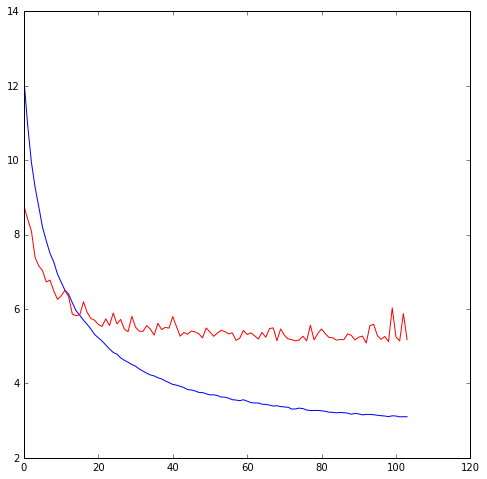

In [252]:
plt.figure(figsize=(8,8))
idx = train_loss_total != 0
plt.plot(train_loss_total[idx], 'b')
plt.plot(test_loss_total[idx], 'r')

In [322]:
def get_label_from_num(num):
    if num == 0:
        return 'car'
    elif num == 1:
        return 'bicycle'
    elif num == 2:
        return 'bike'
    elif num == 3:
        return 'person'

In [410]:
swap = lambda im: im.swapaxes(0,1).swapaxes(1,2)

In [411]:
gen = generate_data_2(train_annotations[:1], C, max_objs=5, size=input_shape)

In [412]:
testdat = [t for t in gen]

In [413]:
Xtest, ytest = testdat[0]

In [414]:
print ytest

[[  0.3984375    0.51041669   0.11250001   0.16666669   1.           0.
    0.           0.         -10.         -10.           0.01         0.01
    0.           0.           0.           0.         -10.         -10.
    0.01         0.01         0.           0.           0.           0.
  -10.         -10.           0.01         0.01         0.           0.
    0.           0.         -10.         -10.           0.01         0.01
    0.           0.           0.           0.        ]]


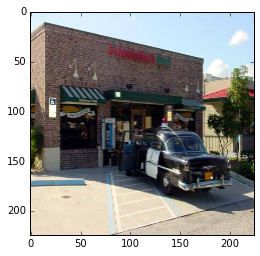

In [415]:
plt.imshow(swap(Xtest[0]))

In [409]:
out_fn = theano.function([yl.input], yl.output_test)

In [417]:
Xtest_out = out_fn(Xtest[:])

In [429]:
np.round(100 * Xtest_out[0,:,3,2]) / 100

array([ 0.02      ,  0.01      ,  0.11      ,  0.16      ,  0.43000001,
        1.46000004, -1.52999997,  0.01      ,  0.07      ,  0.02      ,
        0.99000001,  0.        ,  0.        ,  0.        ], dtype=float32)

In [432]:
def foo(x, x0=.1):
    b = 2 * x0
    c = x0 / 2
    y = np.zeros_like(x)
    idx1, idx2 = np.abs(x) < x0, np.abs(x) >= x0
    y[idx1] = x[idx1]^2
    y[idx2] = b * (x[idx2] - c)
    return y

In [431]:
# Xtest_out[0,[4,9],:,:]

In [419]:
N = int(np.random.rand() * Xtest_out.shape[0])
print N

0


In [420]:
coords = yolo.YoloObjectDetector.nms(Xtest_out[N], S, B, C, thresh=.2, overlap=.05)
print coords.shape

(2, 6)


In [421]:
im = utils.draw_coord(swap(Xtest[N]), coords, get_label_from_num)

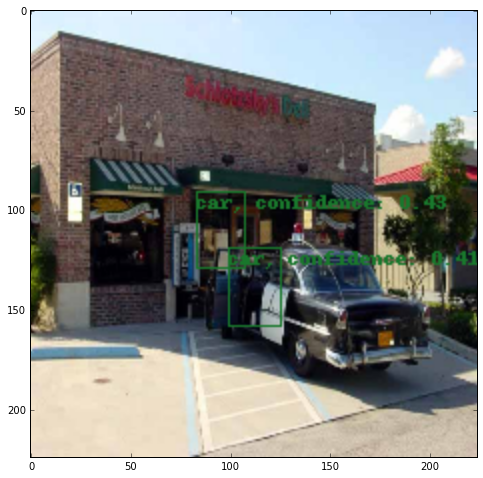

In [422]:
plt.figure(figsize=(8,8))
plt.imshow(im)

In [292]:
pred = np.copy(Xtest_out[N])
score = pred[[4,9]] * pred[-C:].max(keepdims=True)
score = score.flatten()
args = score.argsort()[::-1][:10]
preds = []
for i in range(args.size):
    idx = np.unravel_index(args[i], pred[[4,9]].shape)
    crd = pred[5*idx[0]:5*idx[0] + 4,idx[1], idx[2]]
    tmp = crd[[2,3]]
    tmp[tmp<1] = 0.5*tmp[tmp<1]**2
    tmp[tmp>=1] = np.abs(tmp[tmp>=1]) - 0.5
    crd[[2,3]] = tmp
    crd = crd.tolist()
    crd[0], crd[1] = crd[0] + np.float_(idx[2]) /S[1], crd[1] + np.float_(idx[1]) / S[0]
    crd.append(score[args[i]])
    preds.append(crd)
preds = np.asarray(preds)

In [ ]:
nms(preds, .3)

In [ ]:
plt.imshow(draw_coord(swap(Xtest[N]), nms(preds, .3)[0], None))

In [ ]:
tmp = np.arange()

In [ ]:
swap = lambda x: x.swapaxes(0,1).swapaxes(1,2)

In [ ]:
N = int(Xtest.shape[0] * np.random.rand())
print N
a, b = draw_best(swap(Xtest[N]), Xtest_out[N], num = 5, thresh=.2)

In [ ]:
plt.figure(figsize=(6,6))
plt.imshow(a)
print b
# print '%s with class score: %.3f, objectness: %.3f' % (get_label_from_num(c.argmax()), c.max(), b)
# print c
# print d

In [ ]:
im = swap(Xtest[int(np.random.rand()*Xtest.shape[0])])

In [ ]:
im2 = rgb2hsv(im)

In [ ]:
im2[:,:,1:] *= (1. + .3 * np.random.rand(1,1,2))

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(im)
plt.subplot(1,2,2)
plt.imshow(hsv2rgb(im2))

In [ ]:
im3 = hsv2rgb(im2)